# Summary:

**NOTE:** Feature extraction is supposed to be run on your local-machine. Model training is supposed to be run also on local machine. Can be run on Google Colab.


**Another NOTE:** If you do not wish to extract the features yourself, go to the section "Load the dataset" and start from there after importing and correcting your paths.

Another Deep learning model for Gender Classification has been used. This model is the one and only Convolutional Neural Networks. Many researchers documented the potential for CNN's in Speech Recognition. The utilization of librosa's library in saving the spectrogram images of the audiofile and training the CNN on those spectograms is promising. The process goes as follows:
- Use librosa.display function to view the melspectrogram, the audio file must stay as it is without sampling to utilize all the possible features in the image.
- Export the images with no-axis and labels to a Folder that the notebook automatically creates in the main-directory.
- Generate train,test datasets by importing all the audio-files' names alongside the corresponding gender which is being used in the ImageDataGenerator by Keras.
- Shuffle, Shuffle, Shuffle.. Keep doing it :).
- Use the test-set to generate a validation-set, it is splitted in half (That is because my local machine couldn't generate the whole dataset, the memory kept getting overloaded and eventually crash, so I decided to take a subset of both training and test sets).
- Rescale the images (Normalize) to a factor of 1/2^(Sum of bits for each channel -RGB- 8 bits each).
- Perform Data Augmentation to increase the size of the dataset. The goal when performing data augmentation is to increase and improve the generalizability of the proposed model.
- Create a baseline model and an improved model with Hyperparameter tuning alongside a final model with Keras-tuner.
- Save the best nominated model.


**NOTE:** _The reason for having the **feature extraction** and the **model** together is because of the nature of ImageDataGenerator, I couldn't pickle the iterator as it was _thread.lock which means it is being used by the server-process. I decided to save every possible resource to avoid extracting the features again as it takes long time; for that, I ran the model on Google Colab and extracted the features with data-preprocessing on my local machine._

In [1]:
import os
import librosa
import librosa.display
import random
import re
from datetime import datetime
import datetime
import time
import math
import shutil
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set();
import missingno

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

In [31]:
#Load Tensorboard
%load_ext tensorboard

**IMPORTANT:**
Specify the paths

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    print('Running on Colab, please run feature extraction on your local-machine, you can run the modeling on Google Colab.')
    dataPath_train = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-train/train-clean-100" # Path of train speakers folders.
    root_train = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-train" # Path of the Whole train dataset alongside the .txt files
    dataPath_test = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-test/test-clean" # Path of train speakers folders.
    root_test = "/content/drive/My Drive/Google Colab/Data/LibriSpeech-test"  # Path of the Whole train dataset alongside the .txt files
    delimeter = '/' 
    delimeterM = '/' #A delimeter to distinguish between Local machine and Colab
    dest_save = '/content/drive/My Drive/Google Colab/Data/CNN-data' # Where to save the csv files.
    models_path = '/content/drive/My Drive/Google Colab/models'
    log_dir = '/content/drive/My Drive/Google Colab//log_dir/cnn' #For Tensorboard
else:
    print('Not Running on Google Colab')
    dataPath_train = "./Data/LibriSpeech-train/train-clean-100" # Path of train speakers folders.
    root_train = "./Data/LibriSpeech-train" # Path of the Whole train dataset alongside the .txt files
    dataPath_test = "./Data/LibriSpeech-test/test-clean" # Path of train speakers folders.
    root_test = "./Data/LibriSpeech-test"  # Path of the Whole train dataset alongside the .txt files
    delimeter = '/' 
    delimeterM = '\\' #A delimeter to distinguish between Local machine and Colab
    dest_save = './Data/CNN-data' # Where to save the csv files.
    models_path = './models'
    log_dir = './log_dir/cnn' #For Tensorboard

Not Running on Google Colab


**Create files for the images in the main-directory:**

In [ ]:
os.mkdir(dest_save + delimeter +'images-train')
os.mkdir(dest_save + delimeter +'images-test')
os.mkdir(dest_save + delimeter +'images-val')

In [ ]:
def extract_image(sound, sample_rate, name, destinationFolder, delimeter = '/'):
    """
    A function that saves the figure of the spectrogram to a destination folder.
    ...

    Parameters
    ----------
    sound : numpy.ndarray
        Signal wave-form extracted from librosa.
    sample_rate : numpy.ndarray
        Sampling rate for the generated signal from librosa.
    name : str
        Name of the audio file.
    destinationFolder : str
        Path to the images destination Folder.
        
    """
    #To remove axis and lables to keep the image as it without any additional framing.
    fig = plt.figure(figsize=[1,1])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    # The melspectrogram it can be considered as the visual representation of a signal.
    # In addition, it represents how the spectrum of frequencies vary over time.
    # This helps a lot, especially when the specification of the minimum frequency and the maximum frequency is present!
    spectrogram = librosa.feature.melspectrogram(y=sound, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), fmin=50, fmax=280, x_axis='time', y_axis='mel')
    
    file_name  = destinationFolder + delimeter + name + '.jpg'
    plt.savefig(file_name, dpi=500, pad_inches=0, bbox_inches='tight')
    
    plt.close()

In [4]:
def dataset_creation(dataPath, root, dest_save, dest_images, fileFormat=".flac", size = 5000 , audioPerFolder = 40, delimeter = '/', delimeterM = '\\'):
    """
    A function that crawls in the given file path to a specifize size of audio files then save a .jpg image of the spectrogram of 
    this audio-file to be used in the CNN model. In addition, return a dataset containing the names of audio-files alongside the corresponding gender.

    ...

    Parameters
    ----------
    dataPath : str
        The path where the dataset belongs.
    root : str
        The path of the dataset alongside the .txt files.
    dest_save : str
        Destination folder of the generated images (spectrograms).
    fileFormat : str
        Audio file format.
    size : int
        Maximum number of Audio-files in the dataset.
    audioPerFolder : int
        Audio file per speaker of a book to be generated.
    delimeter : str
        To be used for splitting and concatenating paths.
    delimeterM : str
        A delimeter to distinguish between Local machine and Google Colab.
        
    Returns
    -------
    pandas.DataFrame
        The whole generated Dataset.
        
    """
    
    #Initial Dataframe for the final generated dataset.
    df = pd.DataFrame(columns=['id_speaker', 'file_name'])
    
    # loading the features using extract_features function.
    i = 0

    for path, subdirs, files in os.walk(dataPath):
        if i == size:
            break;
        j = 0
        for name in files:
            if i == size: #if the files are equal to the total specified size of the dataset, break.
                break;
            print(name)
            #Retreive the speaker_id from the path.
            speaker_id = path.split(delimeterM)[-2].split(delimeter)[0]
            if name.endswith(fileFormat):
                #Retreive the signal and the default sample_rate from librosa.
                path_file = os.path.join(path, name)
                sound, sample_rate = librosa.load(path_file, res_type='kaiser_fast', sr=None) #sr=None to take the signal as it is without sampling
                extract_image(sound, sample_rate, name , dest_images)
                #Add them to the dataframe.
                df.loc[i,'id_speaker'] = speaker_id
                df.loc[i,'file_name'] = name +'.jpg' #Changed the name to .jpg to be used in ImageDataGenerator.
                i+=1
                j+=1 
                if j == audioPerFolder: #Number of audio-files per folder
                    break;

    
    print("##########################################################")
    print('Finished creating dataset Features, Now adding labels.')

    # Parsing the labels from SPEAKERS.txt file.
    labels = pd.DataFrame(columns=['id_speaker', 'gender'])
    f = open(root + '/' + "SPEAKERS.TXT", "r", encoding="UTF8").readlines()

    i = 0
    for idx, line in enumerate(f):
        if idx > 11: # Get rid of the unneeded sentences in the beginning for the parsing.
            parsed = re.split('\s+',line)
            if parsed[4] == dataPath.split(delimeter)[-1]: # To ensure taking the right speakers from the right train/test set.
                labels.loc[i] = parsed[0], parsed[2] # Labels
                i += 1

    dataset = pd.merge(df, labels, on='id_speaker')  # Joining both dataframes.
    
    #dataset["gender"].replace({"M": 1, "F": 0}, inplace=True) #Replacing M to 1 and F to 0.
    
    dataset.to_csv(dest_save + delimeter + 'images-'+ dest_images.split('-')[-1] +'.csv',index = False) # The dataset can be found in current-directory.
                                                          # This is for future purposes in case I want to improve on this notebook
    print('Finished Adding Labels.')
    return dataset

In [ ]:
print("Generating training-set...")
dataset_train = dataset_creation(dataPath_train, root_train, dest_save, dest_save + delimeter + 'images-train', size = 5000, audioPerFolder = 10, delimeterM = delimeterM)

In [ ]:
dataset_train

In [ ]:
dataset_train.shape

In [ ]:
dataset_train.head()

In [ ]:
# Shuffle the data.
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [ ]:
dataset_train.head()

In [ ]:
print("Generating Test-set... ")
dataset_test = dataset_creation(dataPath_test, root_test, dest_save, dest_save + delimeter + 'images-test', size = 3000, audioPerFolder = 30,  delimeterM = delimeterM)

In [ ]:
print(dataset_test.shape)

In [ ]:
dataset_test.head()

In [ ]:
# Specifying the shape of validation set.
shape_of_val = int(dataset_test.shape[0]*1/2)
print(shape_of_val)

In [ ]:
#Shuffle the data
dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)

In [ ]:
dataset_test.head()

**Split the data in half:**
- Look for the spectrogram of the audio.
- Move it to the validation folder.
- Add it to validation DataFrame.
- Drop it from test DataFrame.

In [ ]:
i =0
dataset_val = pd.DataFrame(columns=dataset_test.columns)
for file in dataset_test['file_name']:
    path = dest_save + '/images-test/'+ file
    to_path = dest_save + '/images-val/'
    shutil.move(path, to_path)
    dataset_val.loc[i,'id_speaker'] = dataset_test.loc[i,'id_speaker']
    dataset_val.loc[i,'file_name'] = dataset_test.loc[i,'file_name']
    dataset_val.loc[i,'gender'] = dataset_test.loc[i,'gender']
    dataset_test.drop(i, axis=0, inplace=True)
    i+=1
    if i == shape_of_val:
        break;

**Now the data is ready for modeling**:
- Save the data as CSV (Also update the test-set as it has been updated)
- Use ImageDataGenerator to use it as an iterator to build the images in batches. ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.
- Run CNN model with Dropout and specifying the epoch steps and validation steps (# of Samples / batch_size)
- Save the models

**Update the test-set's csv file and create a csv for the validation set:**

In [ ]:
dataset_test.to_csv(dest_save + delimeter + 'images-'+ (dest_save + delimeter + 'images-test').split('-')[-1] +'.csv',index = False)

In [ ]:
dataset_val.to_csv(dest_save + delimeter + 'images-'+ (dest_save + delimeter + 'images-val').split('-')[-1] +'.csv',index = False)

# Load the Dataset

In [3]:
dataset_train = pd.read_csv(dest_save + delimeter + 'images-train.csv')

In [4]:
dataset_test = pd.read_csv(dest_save + delimeter + 'images-test.csv')

In [5]:
dataset_val = pd.read_csv(dest_save + delimeter + 'images-val.csv')

In [6]:
print(dataset_train.shape, dataset_test.shape, dataset_val.shape)

(5000, 3) (1019, 3) (1019, 3)


In [7]:
datagen=ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator=datagen.flow_from_dataframe(
    dataframe=dataset_train,
    directory=dest_save + "/images-train/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 5000 validated image filenames belonging to 2 classes.


In [9]:
val_generator=datagen.flow_from_dataframe(
    dataframe=dataset_val,
    directory=dest_save + "/images-val/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 1019 validated image filenames belonging to 2 classes.


In [10]:
test_generator=datagen.flow_from_dataframe(
    dataframe=dataset_test,
    directory=dest_save + "/images-test/",
    x_col="file_name",
    y_col="gender",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 1019 validated image filenames belonging to 2 classes.


In [11]:
def plot_accuracy_loss(acc_train, acc_val, loss_train, loss_val):
    """
    A fuction that plots the Training & Validation accuracy alongside the plot for loss.
    ...

    Parameters
    ----------
    acc_train : list
        Training Accuracies.
    acc_val : list
        Validation Accuracies.
    loss_train : list
        Training Losses.
    loss_val : list
        Validation Losses.
        
    """

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,15))

    ax1.plot(acc_train, label='Training Accuracy', color='#185fad')
    ax1.plot(acc_val, label='Validation Accuracy', color='orange')

    ax2.plot(loss_train, label='Training Loss', color='#185fad')
    ax2.plot(loss_val, label='Validation Loss', color='orange')


    ax1.set_title('Training and Validation Accuracy', fontsize=30)
    ax1.set_xlabel('Epoch', fontsize = 30)
    ax1.set_ylabel('Accuracy', fontsize = 30)
    ax1.legend(fontsize = 30);
    ax2.set_title('Training and Validation Loss', fontsize=30)
    ax2.set_xlabel('Epoch', fontsize = 30)
    ax2.set_ylabel('Accuracy', fontsize = 30)
    ax2.legend(fontsize = 30);
    plt.tight_layout()
    plt.show();

# Proposed CNN Models:
In this section, different models will be tested on, starting off with the Baseline Model as it will contain an intuitive architecture for a deep CNN; afterwards a comparison is present with loss and accuracy to observe where the model is going.
The following is present:
- Create a Baseline model and observe the results visually.
- Create an improved model where one-to-max two parameters are tuned.
- Create a keras-tuner with some parameters that are based on Grid Search on this CNN.
- Pick the best model to be nominated for the next step.


**Baseline Model:**


In [39]:
# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir+'/Baseline')

baseline_model = Sequential()

# 3X3X32 filters, RGB 64x64 input image.
baseline_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64,64,3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Flatten()) #Fully Connected Layer
baseline_model.add(Dense(512, activation='relu'))

baseline_model.add(Dense(128, activation='relu')) #Fully Connected Layer

baseline_model.add(Dense(2, activation='softmax'))

baseline_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])


In [40]:
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)        

In [41]:
baseline_history = baseline_model.fit_generator(generator=train_generator,
                              steps_per_epoch=int(dataset_train.shape[0]/32),
                              validation_data=val_generator, 
                              validation_steps=int(dataset_val.shape[0]/32), epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
156/156 [==============================] - 17s 109ms/step - loss: 0.6913 - accuracy: 0.5268 - val_loss: 0.6890 - val_accuracy: 0.5383
Epoch 2/100
156/156 [==============================] - 18s 113ms/step - loss: 0.6894 - accuracy: 0.5320 - val_loss: 0.6881 - val_accuracy: 0.5383
Epoch 3/100
156/156 [==============================] - 18s 114ms/step - loss: 0.6882 - accuracy: 0.5308 - val_loss: 0.6868 - val_accuracy: 0.5383
Epoch 4/100
156/156 [==============================] - 17s 107ms/step - loss: 0.6863 - accuracy: 0.5445 - val_loss: 0.6858 - val_accuracy: 0.5383
Epoch 5/100
156/156 [==============================] - 18s 118ms/step - loss: 0.6840 - accuracy: 0.5640 - val_loss: 0.6864 - val_accuracy: 0.6502
Epoch 6/100
156/156 [==============================] - 18s 116ms/step - loss: 0.6797 - accuracy: 0.5775 - val_loss: 0.6790 - val_accuracy: 0.5706
Epoch 7/100
156/156 [==============================] - 19s 121ms/step - loss: 0.6746 - accuracy: 0.6000 - val_loss: 0.6727 -

Epoch 57/100
156/156 [==============================] - 17s 109ms/step - loss: 0.0219 - accuracy: 0.9950 - val_loss: 0.1897 - val_accuracy: 0.9395
Epoch 58/100
156/156 [==============================] - 18s 113ms/step - loss: 0.0210 - accuracy: 0.9950 - val_loss: 0.1916 - val_accuracy: 0.9395
Epoch 59/100
156/156 [==============================] - 17s 111ms/step - loss: 0.0212 - accuracy: 0.9954 - val_loss: 0.1695 - val_accuracy: 0.9385
Epoch 60/100
156/156 [==============================] - 18s 115ms/step - loss: 0.0246 - accuracy: 0.9940 - val_loss: 0.2348 - val_accuracy: 0.9254
Epoch 61/100
156/156 [==============================] - 17s 107ms/step - loss: 0.0177 - accuracy: 0.9962 - val_loss: 0.1987 - val_accuracy: 0.9395
Epoch 62/100
156/156 [==============================] - 16s 101ms/step - loss: 0.0144 - accuracy: 0.9978 - val_loss: 0.1978 - val_accuracy: 0.9375
Epoch 63/100
156/156 [==============================] - 16s 100ms/step - loss: 0.0127 - accuracy: 0.9976 - val_loss: 0

In [45]:
loss, acc = baseline_model.evaluate_generator(test_generator, steps=len(test_generator))

In [46]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.2583247423171997 Accuracy: 0.9489696025848389


_As per above; 94.86% for a Baseline model is quite great!
  The parameters are simple with no regularization._
  
  _Due to this good accuracy as a baseline model, adding dropout to the Improved model shall have a good effect and flatten the the loss curve a bit.._

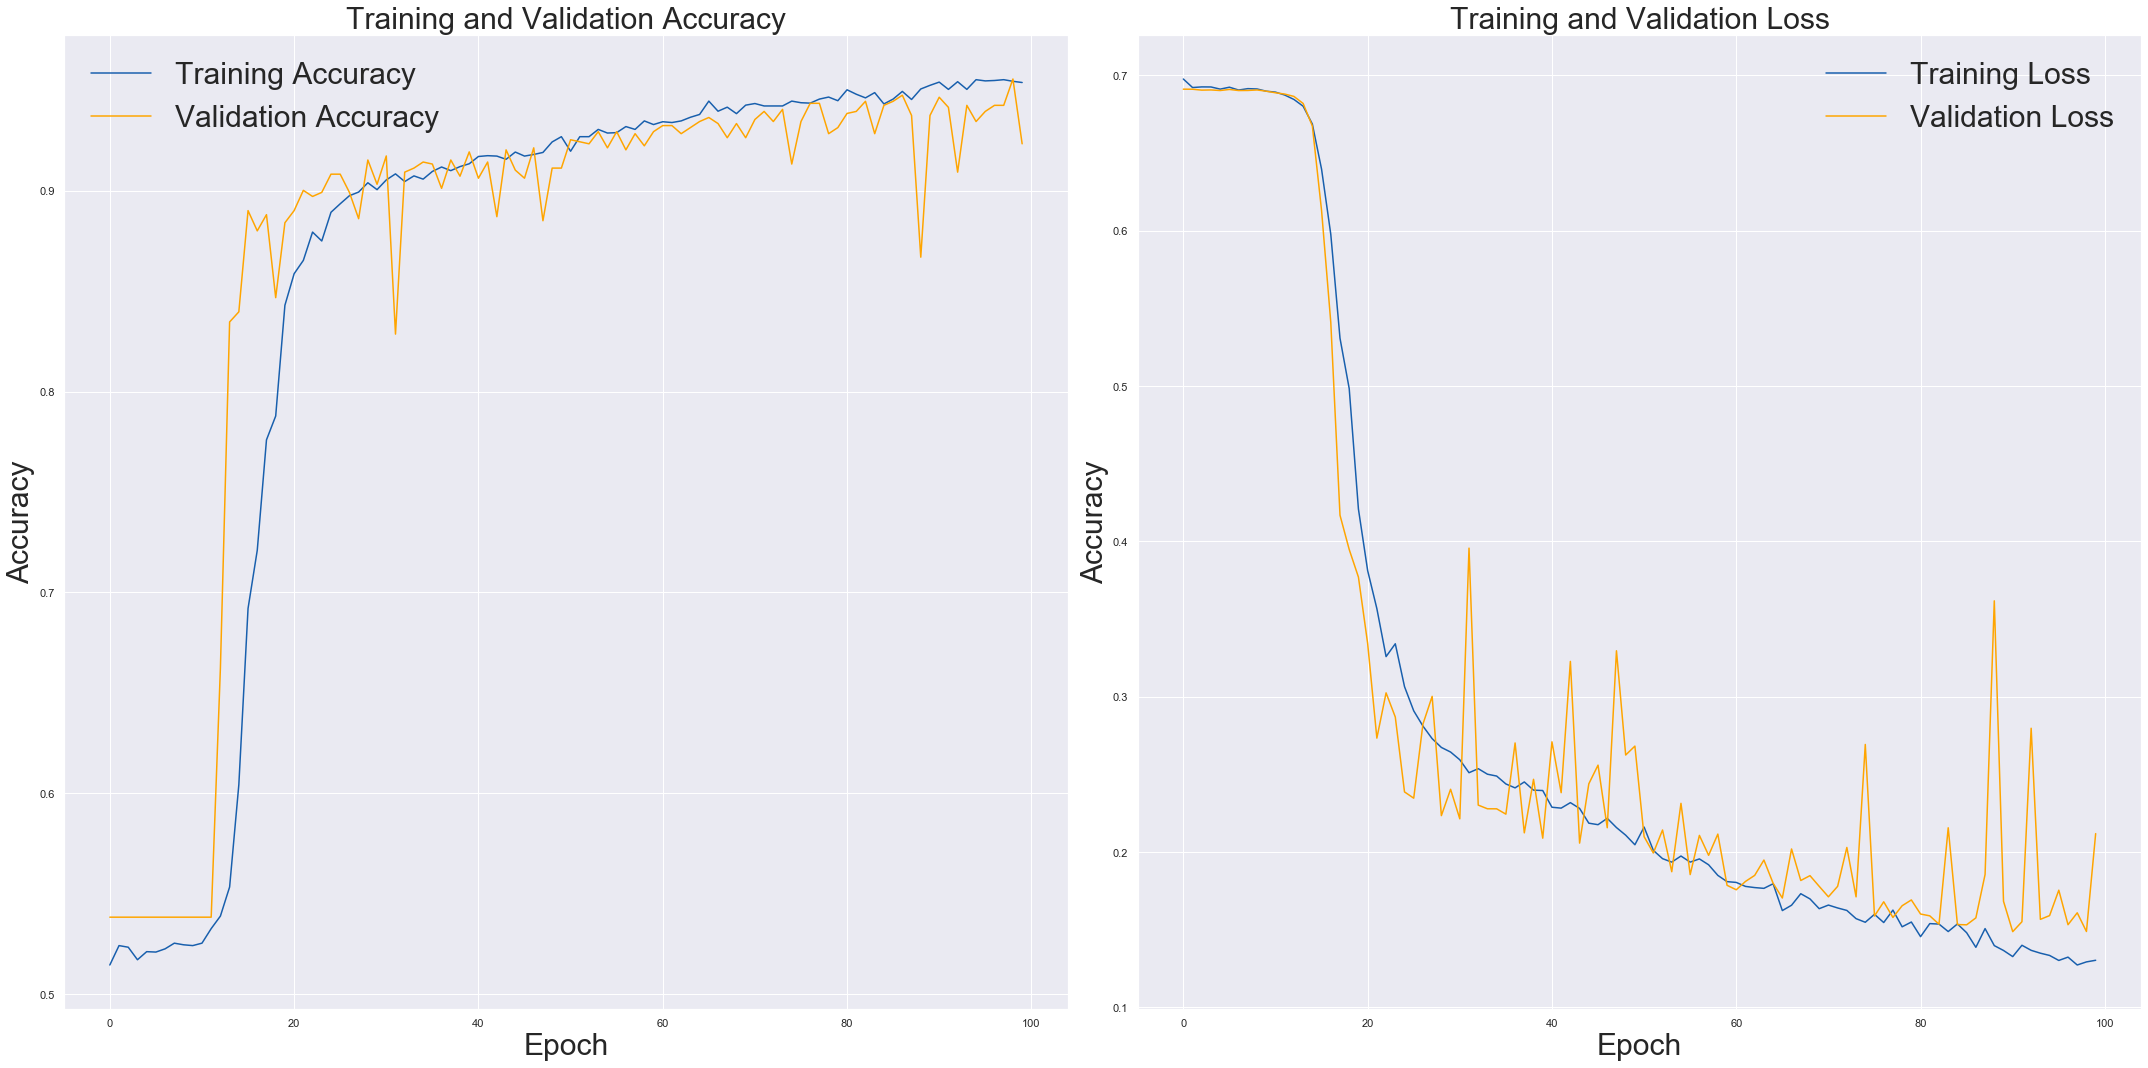

In [47]:
train_acc_baseline = baseline_history.history['accuracy']
val_acc_baseline = baseline_history.history['val_accuracy']
train_loss_baseline = baseline_history.history['loss']
val_loss_baseline = baseline_history.history['val_loss']


plot_accuracy_loss(train_acc, val_acc, train_loss, val_loss)

_Tensorboard (Optional)_

In [37]:
%tensorboard --logdir logdir + '/Baseline'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7368.

**Improved model:**

In [12]:
# Tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir+'/BaselineImproved')

imp_model = Sequential()

# 3X3X32 filters, RGB 64x64 input image.
imp_model.add(Conv2D(kernel_size=(3, 3), filters = 32, input_shape=(64, 64, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))

imp_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.3)) #Add dropout

imp_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.4))
imp_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
imp_model.add(MaxPooling2D(pool_size=(2, 2)))
imp_model.add(Dropout(0.4))

imp_model.add(Flatten()) #Fully Connected Layer
imp_model.add(Dense(512, activation='relu'))
imp_model.add(Dropout(0.3))
imp_model.add(Dense(128, activation='relu')) #Fully Connected Layer
imp_model.add(Dropout(0.2))
imp_model.add(Dense(2, activation='softmax'))

imp_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.7),
                  metrics=['accuracy']) #Add momentum.


In [13]:
imp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0

In [13]:
imp_history = imp_model.fit_generator(generator=train_generator,
                              steps_per_epoch=int(dataset_train.shape[0]/32),
                              validation_data=val_generator, 
                              validation_steps=int(dataset_val.shape[0]/32), epochs=100, callbacks=[tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/156 [..............................] - ETA: 0s - loss: 0.7306 - accuracy: 0.5000WARNING:tensorflow:From C:\Users\o_haw\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
156/156 [==============================] - ETA: 14s - loss: 0.7423 - accuracy: 0.510 - ETA: 18s - loss: 0.7495 - accuracy: 0.437 - ETA: 21s - loss: 0.7389 - accuracy: 0.450 - ETA: 23s - loss: 0.7330 - accuracy: 0.447 - ETA: 24s - loss: 0.7264 - accuracy: 0.455 - ETA: 24s - loss: 0.7230 - accuracy: 0.460 - ETA: 25s - loss: 0.7230 - accuracy: 0.454 - ETA: 25s - loss: 0.7173 - accuracy: 0.468 - ETA: 25s - loss: 0.7184 - accuracy: 0.471 - ETA: 25s - loss: 0.7179 - accuracy: 0.468 - ETA: 26s - loss: 0.7186 - accuracy: 0.468 - ETA: 26s - loss: 0.

156/156 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.59 - ETA: 6s - loss: 0.6874 - accuracy: 0.53 - ETA: 8s - loss: 0.6976 - accuracy: 0.48 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 10s - loss: 0.7001 - accuracy: 0.487 - ETA: 10s - loss: 0.7017 - accuracy: 0.474 - ETA: 10s - loss: 0.6992 - accuracy: 0.495 - ETA: 11s - loss: 0.7001 - accuracy: 0.492 - ETA: 11s - loss: 0.6993 - accuracy: 0.493 - ETA: 11s - loss: 0.6993 - accuracy: 0.487 - ETA: 11s - loss: 0.7002 - accuracy: 0.480 - ETA: 11s - loss: 0.6998 - accuracy: 0.481 - ETA: 11s - loss: 0.6968 - accuracy: 0.507 - ETA: 11s - loss: 0.6971 - accuracy: 0.500 - ETA: 11s - loss: 0.6964 - accuracy: 0.500 - ETA: 11s - loss: 0.6965 - accuracy: 0.500 - ETA: 11s - loss: 0.6963 - accuracy: 0.496 - ETA: 11s - loss: 0.6958 - accuracy: 0.501 - ETA: 11s - loss: 0.6950 - accuracy: 0.506 - ETA: 10s - loss: 0.6947 - accuracy: 0.509 - ETA: 10s - loss: 0.6941 - accuracy: 0.517 - ETA: 10s - loss: 0.6943 - accuracy: 0.518

156/156 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.37 - ETA: 6s - loss: 0.6947 - accuracy: 0.45 - ETA: 8s - loss: 0.6962 - accuracy: 0.46 - ETA: 9s - loss: 0.6952 - accuracy: 0.48 - ETA: 10s - loss: 0.6932 - accuracy: 0.500 - ETA: 10s - loss: 0.6931 - accuracy: 0.484 - ETA: 10s - loss: 0.6942 - accuracy: 0.473 - ETA: 10s - loss: 0.6955 - accuracy: 0.464 - ETA: 11s - loss: 0.6962 - accuracy: 0.454 - ETA: 11s - loss: 0.6949 - accuracy: 0.475 - ETA: 11s - loss: 0.6950 - accuracy: 0.474 - ETA: 11s - loss: 0.6948 - accuracy: 0.479 - ETA: 11s - loss: 0.6951 - accuracy: 0.473 - ETA: 11s - loss: 0.6946 - accuracy: 0.473 - ETA: 11s - loss: 0.6938 - accuracy: 0.483 - ETA: 11s - loss: 0.6933 - accuracy: 0.494 - ETA: 11s - loss: 0.6929 - accuracy: 0.498 - ETA: 11s - loss: 0.6920 - accuracy: 0.501 - ETA: 10s - loss: 0.6910 - accuracy: 0.506 - ETA: 10s - loss: 0.6905 - accuracy: 0.507 - ETA: 10s - loss: 0.6909 - accuracy: 0.506 - ETA: 10s - loss: 0.6907 - accuracy: 0.505

156/156 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.65 - ETA: 7s - loss: 0.6662 - accuracy: 0.60 - ETA: 9s - loss: 0.6750 - accuracy: 0.57 - ETA: 10s - loss: 0.6737 - accuracy: 0.554 - ETA: 10s - loss: 0.6700 - accuracy: 0.568 - ETA: 11s - loss: 0.6722 - accuracy: 0.562 - ETA: 11s - loss: 0.6736 - accuracy: 0.562 - ETA: 11s - loss: 0.6740 - accuracy: 0.562 - ETA: 11s - loss: 0.6744 - accuracy: 0.569 - ETA: 11s - loss: 0.6770 - accuracy: 0.565 - ETA: 11s - loss: 0.6763 - accuracy: 0.568 - ETA: 11s - loss: 0.6782 - accuracy: 0.562 - ETA: 11s - loss: 0.6761 - accuracy: 0.572 - ETA: 11s - loss: 0.6764 - accuracy: 0.569 - ETA: 11s - loss: 0.6760 - accuracy: 0.566 - ETA: 11s - loss: 0.6748 - accuracy: 0.568 - ETA: 11s - loss: 0.6752 - accuracy: 0.569 - ETA: 11s - loss: 0.6769 - accuracy: 0.566 - ETA: 11s - loss: 0.6783 - accuracy: 0.559 - ETA: 11s - loss: 0.6781 - accuracy: 0.557 - ETA: 11s - loss: 0.6778 - accuracy: 0.558 - ETA: 11s - loss: 0.6784 - accuracy: 0.5

156/156 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.78 - ETA: 7s - loss: 0.5488 - accuracy: 0.78 - ETA: 7s - loss: 0.5327 - accuracy: 0.80 - ETA: 8s - loss: 0.5136 - accuracy: 0.82 - ETA: 9s - loss: 0.5206 - accuracy: 0.77 - ETA: 9s - loss: 0.5109 - accuracy: 0.80 - ETA: 10s - loss: 0.5392 - accuracy: 0.758 - ETA: 10s - loss: 0.5754 - accuracy: 0.715 - ETA: 10s - loss: 0.5834 - accuracy: 0.702 - ETA: 10s - loss: 0.5831 - accuracy: 0.704 - ETA: 10s - loss: 0.5825 - accuracy: 0.697 - ETA: 10s - loss: 0.5768 - accuracy: 0.699 - ETA: 10s - loss: 0.5790 - accuracy: 0.698 - ETA: 10s - loss: 0.5715 - accuracy: 0.708 - ETA: 10s - loss: 0.5646 - accuracy: 0.711 - ETA: 10s - loss: 0.5639 - accuracy: 0.709 - ETA: 10s - loss: 0.5654 - accuracy: 0.710 - ETA: 10s - loss: 0.5681 - accuracy: 0.705 - ETA: 10s - loss: 0.5616 - accuracy: 0.715 - ETA: 10s - loss: 0.5798 - accuracy: 0.708 - ETA: 10s - loss: 0.5731 - accuracy: 0.717 - ETA: 10s - loss: 0.5724 - accuracy: 0.716 - E

156/156 [==============================] - ETA: 1s - loss: 0.1851 - accuracy: 0.96 - ETA: 6s - loss: 0.2259 - accuracy: 0.93 - ETA: 8s - loss: 0.2879 - accuracy: 0.88 - ETA: 9s - loss: 0.2496 - accuracy: 0.91 - ETA: 10s - loss: 0.2644 - accuracy: 0.900 - ETA: 10s - loss: 0.2533 - accuracy: 0.911 - ETA: 10s - loss: 0.2470 - accuracy: 0.910 - ETA: 11s - loss: 0.2492 - accuracy: 0.910 - ETA: 11s - loss: 0.2345 - accuracy: 0.916 - ETA: 11s - loss: 0.2429 - accuracy: 0.915 - ETA: 11s - loss: 0.2356 - accuracy: 0.920 - ETA: 11s - loss: 0.2314 - accuracy: 0.921 - ETA: 11s - loss: 0.2377 - accuracy: 0.918 - ETA: 11s - loss: 0.2436 - accuracy: 0.910 - ETA: 11s - loss: 0.2417 - accuracy: 0.912 - ETA: 11s - loss: 0.2333 - accuracy: 0.916 - ETA: 11s - loss: 0.2339 - accuracy: 0.917 - ETA: 11s - loss: 0.2347 - accuracy: 0.916 - ETA: 11s - loss: 0.2299 - accuracy: 0.919 - ETA: 10s - loss: 0.2285 - accuracy: 0.918 - ETA: 10s - loss: 0.2316 - accuracy: 0.915 - ETA: 10s - loss: 0.2314 - accuracy: 0.914

156/156 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.90 - ETA: 6s - loss: 0.2142 - accuracy: 0.92 - ETA: 8s - loss: 0.1968 - accuracy: 0.92 - ETA: 9s - loss: 0.1878 - accuracy: 0.93 - ETA: 10s - loss: 0.1658 - accuracy: 0.950 - ETA: 10s - loss: 0.1969 - accuracy: 0.932 - ETA: 10s - loss: 0.2287 - accuracy: 0.924 - ETA: 11s - loss: 0.2717 - accuracy: 0.902 - ETA: 11s - loss: 0.2832 - accuracy: 0.902 - ETA: 11s - loss: 0.2801 - accuracy: 0.906 - ETA: 11s - loss: 0.2881 - accuracy: 0.903 - ETA: 11s - loss: 0.2840 - accuracy: 0.908 - ETA: 11s - loss: 0.2781 - accuracy: 0.908 - ETA: 11s - loss: 0.2726 - accuracy: 0.910 - ETA: 11s - loss: 0.2712 - accuracy: 0.910 - ETA: 11s - loss: 0.2644 - accuracy: 0.912 - ETA: 11s - loss: 0.2592 - accuracy: 0.911 - ETA: 11s - loss: 0.2629 - accuracy: 0.908 - ETA: 10s - loss: 0.2584 - accuracy: 0.909 - ETA: 10s - loss: 0.2538 - accuracy: 0.910 - ETA: 10s - loss: 0.2496 - accuracy: 0.912 - ETA: 10s - loss: 0.2500 - accuracy: 0.910

156/156 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.93 - ETA: 7s - loss: 0.3120 - accuracy: 0.89 - ETA: 9s - loss: 0.3150 - accuracy: 0.89 - ETA: 10s - loss: 0.2571 - accuracy: 0.921 - ETA: 10s - loss: 0.2309 - accuracy: 0.931 - ETA: 10s - loss: 0.2178 - accuracy: 0.927 - ETA: 11s - loss: 0.2054 - accuracy: 0.928 - ETA: 11s - loss: 0.1949 - accuracy: 0.929 - ETA: 11s - loss: 0.2209 - accuracy: 0.920 - ETA: 11s - loss: 0.2343 - accuracy: 0.918 - ETA: 11s - loss: 0.2304 - accuracy: 0.917 - ETA: 11s - loss: 0.2208 - accuracy: 0.919 - ETA: 11s - loss: 0.2195 - accuracy: 0.920 - ETA: 11s - loss: 0.2123 - accuracy: 0.919 - ETA: 11s - loss: 0.2035 - accuracy: 0.925 - ETA: 11s - loss: 0.2170 - accuracy: 0.919 - ETA: 11s - loss: 0.2169 - accuracy: 0.919 - ETA: 11s - loss: 0.2087 - accuracy: 0.921 - ETA: 11s - loss: 0.2119 - accuracy: 0.919 - ETA: 11s - loss: 0.2063 - accuracy: 0.921 - ETA: 11s - loss: 0.2079 - accuracy: 0.921 - ETA: 11s - loss: 0.2081 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - ETA: 6s - loss: 0.1353 - accuracy: 0.96 - ETA: 8s - loss: 0.1098 - accuracy: 0.97 - ETA: 9s - loss: 0.0983 - accuracy: 0.97 - ETA: 10s - loss: 0.0936 - accuracy: 0.975 - ETA: 10s - loss: 0.0956 - accuracy: 0.968 - ETA: 11s - loss: 0.1132 - accuracy: 0.959 - ETA: 11s - loss: 0.1176 - accuracy: 0.957 - ETA: 11s - loss: 0.1147 - accuracy: 0.958 - ETA: 11s - loss: 0.1130 - accuracy: 0.962 - ETA: 11s - loss: 0.1211 - accuracy: 0.963 - ETA: 11s - loss: 0.1258 - accuracy: 0.958 - ETA: 11s - loss: 0.1226 - accuracy: 0.959 - ETA: 11s - loss: 0.1346 - accuracy: 0.955 - ETA: 11s - loss: 0.1433 - accuracy: 0.952 - ETA: 11s - loss: 0.1411 - accuracy: 0.953 - ETA: 11s - loss: 0.1393 - accuracy: 0.952 - ETA: 11s - loss: 0.1580 - accuracy: 0.946 - ETA: 11s - loss: 0.1637 - accuracy: 0.945 - ETA: 11s - loss: 0.1682 - accuracy: 0.943 - ETA: 10s - loss: 0.1691 - accuracy: 0.942 - ETA: 10s - loss: 0.1718 - accuracy: 0.940

156/156 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 6s - loss: 0.1185 - accuracy: 0.96 - ETA: 8s - loss: 0.1511 - accuracy: 0.95 - ETA: 9s - loss: 0.1588 - accuracy: 0.96 - ETA: 10s - loss: 0.1342 - accuracy: 0.968 - ETA: 10s - loss: 0.1226 - accuracy: 0.968 - ETA: 11s - loss: 0.1258 - accuracy: 0.968 - ETA: 11s - loss: 0.1184 - accuracy: 0.968 - ETA: 11s - loss: 0.1129 - accuracy: 0.968 - ETA: 11s - loss: 0.1119 - accuracy: 0.968 - ETA: 11s - loss: 0.1172 - accuracy: 0.968 - ETA: 11s - loss: 0.1159 - accuracy: 0.963 - ETA: 11s - loss: 0.1215 - accuracy: 0.956 - ETA: 11s - loss: 0.1277 - accuracy: 0.955 - ETA: 11s - loss: 0.1327 - accuracy: 0.954 - ETA: 11s - loss: 0.1318 - accuracy: 0.955 - ETA: 11s - loss: 0.1291 - accuracy: 0.957 - ETA: 11s - loss: 0.1397 - accuracy: 0.953 - ETA: 11s - loss: 0.1353 - accuracy: 0.955 - ETA: 11s - loss: 0.1332 - accuracy: 0.954 - ETA: 10s - loss: 0.1372 - accuracy: 0.953 - ETA: 10s - loss: 0.1412 - accuracy: 0.951

156/156 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.96 - ETA: 7s - loss: 0.1505 - accuracy: 0.95 - ETA: 9s - loss: 0.1137 - accuracy: 0.96 - ETA: 9s - loss: 0.1472 - accuracy: 0.95 - ETA: 10s - loss: 0.1780 - accuracy: 0.943 - ETA: 10s - loss: 0.2008 - accuracy: 0.937 - ETA: 10s - loss: 0.2123 - accuracy: 0.933 - ETA: 11s - loss: 0.1990 - accuracy: 0.937 - ETA: 11s - loss: 0.1953 - accuracy: 0.937 - ETA: 11s - loss: 0.2069 - accuracy: 0.934 - ETA: 11s - loss: 0.2027 - accuracy: 0.937 - ETA: 11s - loss: 0.1990 - accuracy: 0.934 - ETA: 11s - loss: 0.1989 - accuracy: 0.932 - ETA: 11s - loss: 0.1926 - accuracy: 0.933 - ETA: 11s - loss: 0.1896 - accuracy: 0.933 - ETA: 11s - loss: 0.1877 - accuracy: 0.931 - ETA: 11s - loss: 0.1842 - accuracy: 0.933 - ETA: 11s - loss: 0.1871 - accuracy: 0.934 - ETA: 11s - loss: 0.1819 - accuracy: 0.935 - ETA: 10s - loss: 0.1850 - accuracy: 0.934 - ETA: 10s - loss: 0.1892 - accuracy: 0.933 - ETA: 10s - loss: 0.1903 - accuracy: 0.930

156/156 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.96 - ETA: 7s - loss: 0.1299 - accuracy: 0.95 - ETA: 9s - loss: 0.1204 - accuracy: 0.94 - ETA: 10s - loss: 0.1510 - accuracy: 0.937 - ETA: 10s - loss: 0.1639 - accuracy: 0.943 - ETA: 10s - loss: 0.1455 - accuracy: 0.953 - ETA: 11s - loss: 0.1442 - accuracy: 0.950 - ETA: 11s - loss: 0.1507 - accuracy: 0.945 - ETA: 11s - loss: 0.1662 - accuracy: 0.944 - ETA: 11s - loss: 0.1625 - accuracy: 0.946 - ETA: 11s - loss: 0.1523 - accuracy: 0.948 - ETA: 11s - loss: 0.1538 - accuracy: 0.947 - ETA: 11s - loss: 0.1486 - accuracy: 0.949 - ETA: 11s - loss: 0.1567 - accuracy: 0.948 - ETA: 11s - loss: 0.1595 - accuracy: 0.947 - ETA: 11s - loss: 0.1534 - accuracy: 0.949 - ETA: 11s - loss: 0.1494 - accuracy: 0.950 - ETA: 11s - loss: 0.1428 - accuracy: 0.953 - ETA: 11s - loss: 0.1455 - accuracy: 0.952 - ETA: 11s - loss: 0.1443 - accuracy: 0.953 - ETA: 11s - loss: 0.1427 - accuracy: 0.953 - ETA: 10s - loss: 0.1400 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 6s - loss: 0.0615 - accuracy: 0.98 - ETA: 8s - loss: 0.0554 - accuracy: 0.98 - ETA: 9s - loss: 0.0806 - accuracy: 0.98 - ETA: 10s - loss: 0.0810 - accuracy: 0.981 - ETA: 10s - loss: 0.0824 - accuracy: 0.979 - ETA: 10s - loss: 0.0831 - accuracy: 0.977 - ETA: 11s - loss: 0.0960 - accuracy: 0.972 - ETA: 11s - loss: 0.0974 - accuracy: 0.972 - ETA: 11s - loss: 0.0967 - accuracy: 0.968 - ETA: 11s - loss: 0.1026 - accuracy: 0.965 - ETA: 11s - loss: 0.1006 - accuracy: 0.966 - ETA: 11s - loss: 0.1113 - accuracy: 0.959 - ETA: 11s - loss: 0.1289 - accuracy: 0.957 - ETA: 11s - loss: 0.1264 - accuracy: 0.958 - ETA: 11s - loss: 0.1282 - accuracy: 0.957 - ETA: 11s - loss: 0.1308 - accuracy: 0.955 - ETA: 11s - loss: 0.1346 - accuracy: 0.953 - ETA: 10s - loss: 0.1339 - accuracy: 0.953 - ETA: 10s - loss: 0.1318 - accuracy: 0.954 - ETA: 10s - loss: 0.1307 - accuracy: 0.953 - ETA: 10s - loss: 0.1380 - accuracy: 0.950

156/156 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.96 - ETA: 7s - loss: 0.1022 - accuracy: 0.96 - ETA: 9s - loss: 0.1141 - accuracy: 0.96 - ETA: 10s - loss: 0.1464 - accuracy: 0.953 - ETA: 10s - loss: 0.1958 - accuracy: 0.943 - ETA: 11s - loss: 0.1727 - accuracy: 0.953 - ETA: 11s - loss: 0.1551 - accuracy: 0.959 - ETA: 11s - loss: 0.1697 - accuracy: 0.953 - ETA: 11s - loss: 0.1624 - accuracy: 0.954 - ETA: 11s - loss: 0.1604 - accuracy: 0.953 - ETA: 11s - loss: 0.1552 - accuracy: 0.951 - ETA: 11s - loss: 0.1451 - accuracy: 0.955 - ETA: 11s - loss: 0.1448 - accuracy: 0.956 - ETA: 11s - loss: 0.1451 - accuracy: 0.955 - ETA: 11s - loss: 0.1501 - accuracy: 0.954 - ETA: 11s - loss: 0.1538 - accuracy: 0.953 - ETA: 11s - loss: 0.1479 - accuracy: 0.955 - ETA: 11s - loss: 0.1522 - accuracy: 0.954 - ETA: 11s - loss: 0.1538 - accuracy: 0.952 - ETA: 11s - loss: 0.1487 - accuracy: 0.954 - ETA: 11s - loss: 0.1445 - accuracy: 0.956 - ETA: 11s - loss: 0.1509 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.87 - ETA: 6s - loss: 0.1500 - accuracy: 0.92 - ETA: 8s - loss: 0.1407 - accuracy: 0.92 - ETA: 9s - loss: 0.1499 - accuracy: 0.92 - ETA: 10s - loss: 0.1450 - accuracy: 0.937 - ETA: 10s - loss: 0.1416 - accuracy: 0.942 - ETA: 11s - loss: 0.1327 - accuracy: 0.946 - ETA: 11s - loss: 0.1216 - accuracy: 0.953 - ETA: 11s - loss: 0.1317 - accuracy: 0.947 - ETA: 11s - loss: 0.1283 - accuracy: 0.946 - ETA: 11s - loss: 0.1312 - accuracy: 0.946 - ETA: 11s - loss: 0.1453 - accuracy: 0.942 - ETA: 11s - loss: 0.1408 - accuracy: 0.944 - ETA: 11s - loss: 0.1401 - accuracy: 0.944 - ETA: 11s - loss: 0.1410 - accuracy: 0.945 - ETA: 11s - loss: 0.1393 - accuracy: 0.947 - ETA: 11s - loss: 0.1400 - accuracy: 0.944 - ETA: 11s - loss: 0.1392 - accuracy: 0.947 - ETA: 11s - loss: 0.1353 - accuracy: 0.949 - ETA: 11s - loss: 0.1387 - accuracy: 0.948 - ETA: 11s - loss: 0.1386 - accuracy: 0.949 - ETA: 10s - loss: 0.1417 - accuracy: 0.947

156/156 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 1.00 - ETA: 6s - loss: 0.0610 - accuracy: 0.98 - ETA: 8s - loss: 0.0590 - accuracy: 0.97 - ETA: 9s - loss: 0.1007 - accuracy: 0.96 - ETA: 10s - loss: 0.1554 - accuracy: 0.943 - ETA: 10s - loss: 0.1380 - accuracy: 0.947 - ETA: 10s - loss: 0.1820 - accuracy: 0.942 - ETA: 10s - loss: 0.1850 - accuracy: 0.937 - ETA: 11s - loss: 0.1807 - accuracy: 0.937 - ETA: 11s - loss: 0.1669 - accuracy: 0.943 - ETA: 11s - loss: 0.1682 - accuracy: 0.943 - ETA: 11s - loss: 0.1649 - accuracy: 0.945 - ETA: 11s - loss: 0.1627 - accuracy: 0.947 - ETA: 11s - loss: 0.1561 - accuracy: 0.948 - ETA: 11s - loss: 0.1529 - accuracy: 0.947 - ETA: 11s - loss: 0.1571 - accuracy: 0.943 - ETA: 11s - loss: 0.1501 - accuracy: 0.946 - ETA: 10s - loss: 0.1448 - accuracy: 0.949 - ETA: 10s - loss: 0.1459 - accuracy: 0.947 - ETA: 10s - loss: 0.1427 - accuracy: 0.949 - ETA: 10s - loss: 0.1383 - accuracy: 0.951 - ETA: 10s - loss: 0.1349 - accuracy: 0.952

156/156 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.96 - ETA: 6s - loss: 0.0982 - accuracy: 0.95 - ETA: 8s - loss: 0.0925 - accuracy: 0.95 - ETA: 9s - loss: 0.0767 - accuracy: 0.96 - ETA: 10s - loss: 0.0759 - accuracy: 0.968 - ETA: 10s - loss: 0.0709 - accuracy: 0.968 - ETA: 10s - loss: 0.0651 - accuracy: 0.973 - ETA: 11s - loss: 0.0664 - accuracy: 0.972 - ETA: 11s - loss: 0.0650 - accuracy: 0.972 - ETA: 11s - loss: 0.0619 - accuracy: 0.971 - ETA: 11s - loss: 0.0622 - accuracy: 0.968 - ETA: 11s - loss: 0.0813 - accuracy: 0.966 - ETA: 11s - loss: 0.0793 - accuracy: 0.966 - ETA: 11s - loss: 0.0856 - accuracy: 0.966 - ETA: 11s - loss: 0.1016 - accuracy: 0.964 - ETA: 11s - loss: 0.1024 - accuracy: 0.964 - ETA: 11s - loss: 0.1044 - accuracy: 0.961 - ETA: 11s - loss: 0.1064 - accuracy: 0.958 - ETA: 11s - loss: 0.1103 - accuracy: 0.958 - ETA: 10s - loss: 0.1161 - accuracy: 0.956 - ETA: 10s - loss: 0.1117 - accuracy: 0.958 - ETA: 10s - loss: 0.1143 - accuracy: 0.957

156/156 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.96 - ETA: 6s - loss: 0.1782 - accuracy: 0.93 - ETA: 8s - loss: 0.1352 - accuracy: 0.94 - ETA: 9s - loss: 0.1249 - accuracy: 0.95 - ETA: 10s - loss: 0.1184 - accuracy: 0.956 - ETA: 10s - loss: 0.1153 - accuracy: 0.958 - ETA: 11s - loss: 0.1500 - accuracy: 0.950 - ETA: 11s - loss: 0.1424 - accuracy: 0.953 - ETA: 11s - loss: 0.1332 - accuracy: 0.958 - ETA: 11s - loss: 0.1242 - accuracy: 0.962 - ETA: 11s - loss: 0.1177 - accuracy: 0.963 - ETA: 11s - loss: 0.1315 - accuracy: 0.953 - ETA: 11s - loss: 0.1268 - accuracy: 0.954 - ETA: 11s - loss: 0.1214 - accuracy: 0.957 - ETA: 11s - loss: 0.1181 - accuracy: 0.958 - ETA: 11s - loss: 0.1122 - accuracy: 0.960 - ETA: 11s - loss: 0.1139 - accuracy: 0.959 - ETA: 11s - loss: 0.1089 - accuracy: 0.961 - ETA: 11s - loss: 0.1052 - accuracy: 0.962 - ETA: 11s - loss: 0.1087 - accuracy: 0.962 - ETA: 11s - loss: 0.1068 - accuracy: 0.964 - ETA: 11s - loss: 0.1036 - accuracy: 0.965

156/156 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 1.00 - ETA: 7s - loss: 0.1209 - accuracy: 0.96 - ETA: 9s - loss: 0.1190 - accuracy: 0.95 - ETA: 9s - loss: 0.1026 - accuracy: 0.96 - ETA: 10s - loss: 0.1008 - accuracy: 0.956 - ETA: 10s - loss: 0.1065 - accuracy: 0.958 - ETA: 11s - loss: 0.1177 - accuracy: 0.955 - ETA: 11s - loss: 0.1168 - accuracy: 0.957 - ETA: 11s - loss: 0.1604 - accuracy: 0.951 - ETA: 11s - loss: 0.1497 - accuracy: 0.953 - ETA: 11s - loss: 0.1417 - accuracy: 0.957 - ETA: 11s - loss: 0.1321 - accuracy: 0.960 - ETA: 11s - loss: 0.1289 - accuracy: 0.961 - ETA: 11s - loss: 0.1221 - accuracy: 0.964 - ETA: 11s - loss: 0.1186 - accuracy: 0.964 - ETA: 11s - loss: 0.1208 - accuracy: 0.964 - ETA: 11s - loss: 0.1230 - accuracy: 0.963 - ETA: 11s - loss: 0.1203 - accuracy: 0.963 - ETA: 11s - loss: 0.1164 - accuracy: 0.963 - ETA: 11s - loss: 0.1131 - accuracy: 0.965 - ETA: 11s - loss: 0.1176 - accuracy: 0.965 - ETA: 11s - loss: 0.1192 - accuracy: 0.964

156/156 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.93 - ETA: 7s - loss: 0.1154 - accuracy: 0.95 - ETA: 9s - loss: 0.1338 - accuracy: 0.95 - ETA: 9s - loss: 0.1075 - accuracy: 0.96 - ETA: 10s - loss: 0.0924 - accuracy: 0.975 - ETA: 10s - loss: 0.1282 - accuracy: 0.958 - ETA: 11s - loss: 0.1223 - accuracy: 0.959 - ETA: 11s - loss: 0.1244 - accuracy: 0.957 - ETA: 11s - loss: 0.1210 - accuracy: 0.958 - ETA: 11s - loss: 0.1108 - accuracy: 0.962 - ETA: 11s - loss: 0.1139 - accuracy: 0.957 - ETA: 11s - loss: 0.1118 - accuracy: 0.958 - ETA: 11s - loss: 0.1056 - accuracy: 0.961 - ETA: 11s - loss: 0.1069 - accuracy: 0.962 - ETA: 11s - loss: 0.1046 - accuracy: 0.962 - ETA: 11s - loss: 0.1008 - accuracy: 0.964 - ETA: 11s - loss: 0.1072 - accuracy: 0.963 - ETA: 11s - loss: 0.1037 - accuracy: 0.963 - ETA: 11s - loss: 0.1046 - accuracy: 0.963 - ETA: 11s - loss: 0.1117 - accuracy: 0.964 - ETA: 11s - loss: 0.1113 - accuracy: 0.962 - ETA: 11s - loss: 0.1109 - accuracy: 0.961

156/156 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.93 - ETA: 7s - loss: 0.1022 - accuracy: 0.96 - ETA: 9s - loss: 0.0951 - accuracy: 0.95 - ETA: 10s - loss: 0.0997 - accuracy: 0.960 - ETA: 10s - loss: 0.1031 - accuracy: 0.962 - ETA: 10s - loss: 0.0919 - accuracy: 0.968 - ETA: 11s - loss: 0.0902 - accuracy: 0.968 - ETA: 11s - loss: 0.0929 - accuracy: 0.968 - ETA: 11s - loss: 0.0873 - accuracy: 0.968 - ETA: 11s - loss: 0.0883 - accuracy: 0.968 - ETA: 11s - loss: 0.1136 - accuracy: 0.965 - ETA: 11s - loss: 0.1121 - accuracy: 0.966 - ETA: 11s - loss: 0.1099 - accuracy: 0.966 - ETA: 11s - loss: 0.1116 - accuracy: 0.966 - ETA: 11s - loss: 0.1099 - accuracy: 0.966 - ETA: 11s - loss: 0.1098 - accuracy: 0.964 - ETA: 11s - loss: 0.1121 - accuracy: 0.963 - ETA: 11s - loss: 0.1140 - accuracy: 0.961 - ETA: 11s - loss: 0.1099 - accuracy: 0.963 - ETA: 11s - loss: 0.1066 - accuracy: 0.964 - ETA: 11s - loss: 0.1137 - accuracy: 0.959 - ETA: 10s - loss: 0.1127 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 5s - loss: 0.0827 - accuracy: 0.96 - ETA: 8s - loss: 0.0778 - accuracy: 0.96 - ETA: 9s - loss: 0.0789 - accuracy: 0.96 - ETA: 9s - loss: 0.0983 - accuracy: 0.95 - ETA: 10s - loss: 0.0919 - accuracy: 0.958 - ETA: 10s - loss: 0.1037 - accuracy: 0.946 - ETA: 10s - loss: 0.1023 - accuracy: 0.945 - ETA: 11s - loss: 0.0930 - accuracy: 0.951 - ETA: 11s - loss: 0.1011 - accuracy: 0.946 - ETA: 11s - loss: 0.0962 - accuracy: 0.951 - ETA: 11s - loss: 0.1075 - accuracy: 0.950 - ETA: 11s - loss: 0.0998 - accuracy: 0.954 - ETA: 11s - loss: 0.0943 - accuracy: 0.957 - ETA: 11s - loss: 0.0890 - accuracy: 0.960 - ETA: 11s - loss: 0.0846 - accuracy: 0.962 - ETA: 11s - loss: 0.0815 - accuracy: 0.965 - ETA: 11s - loss: 0.0790 - accuracy: 0.965 - ETA: 11s - loss: 0.0825 - accuracy: 0.963 - ETA: 11s - loss: 0.0830 - accuracy: 0.964 - ETA: 10s - loss: 0.0829 - accuracy: 0.962 - ETA: 10s - loss: 0.0828 - accuracy: 0.963 -

156/156 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.93 - ETA: 6s - loss: 0.0760 - accuracy: 0.95 - ETA: 8s - loss: 0.0739 - accuracy: 0.96 - ETA: 9s - loss: 0.0572 - accuracy: 0.97 - ETA: 10s - loss: 0.0907 - accuracy: 0.975 - ETA: 10s - loss: 0.0910 - accuracy: 0.968 - ETA: 11s - loss: 0.0825 - accuracy: 0.973 - ETA: 11s - loss: 0.0883 - accuracy: 0.972 - ETA: 11s - loss: 0.0912 - accuracy: 0.972 - ETA: 11s - loss: 0.0909 - accuracy: 0.971 - ETA: 11s - loss: 0.0894 - accuracy: 0.968 - ETA: 11s - loss: 0.0832 - accuracy: 0.971 - ETA: 11s - loss: 0.0872 - accuracy: 0.968 - ETA: 11s - loss: 0.0859 - accuracy: 0.966 - ETA: 11s - loss: 0.0849 - accuracy: 0.968 - ETA: 11s - loss: 0.0820 - accuracy: 0.970 - ETA: 11s - loss: 0.0827 - accuracy: 0.968 - ETA: 11s - loss: 0.0786 - accuracy: 0.970 - ETA: 11s - loss: 0.0769 - accuracy: 0.970 - ETA: 11s - loss: 0.0750 - accuracy: 0.970 - ETA: 11s - loss: 0.0740 - accuracy: 0.970 - ETA: 11s - loss: 0.0765 - accuracy: 0.970

156/156 [==============================] - ETA: 1s - loss: 0.0183 - accuracy: 1.00 - ETA: 7s - loss: 0.0606 - accuracy: 0.96 - ETA: 8s - loss: 0.0488 - accuracy: 0.97 - ETA: 9s - loss: 0.0468 - accuracy: 0.97 - ETA: 10s - loss: 0.0432 - accuracy: 0.981 - ETA: 10s - loss: 0.0374 - accuracy: 0.984 - ETA: 10s - loss: 0.0340 - accuracy: 0.986 - ETA: 11s - loss: 0.0309 - accuracy: 0.988 - ETA: 11s - loss: 0.0413 - accuracy: 0.982 - ETA: 11s - loss: 0.0380 - accuracy: 0.984 - ETA: 11s - loss: 0.0406 - accuracy: 0.983 - ETA: 11s - loss: 0.0416 - accuracy: 0.981 - ETA: 11s - loss: 0.0634 - accuracy: 0.978 - ETA: 11s - loss: 0.0606 - accuracy: 0.979 - ETA: 11s - loss: 0.0696 - accuracy: 0.977 - ETA: 11s - loss: 0.0709 - accuracy: 0.974 - ETA: 11s - loss: 0.0675 - accuracy: 0.976 - ETA: 11s - loss: 0.0647 - accuracy: 0.977 - ETA: 10s - loss: 0.0617 - accuracy: 0.978 - ETA: 10s - loss: 0.0600 - accuracy: 0.979 - ETA: 10s - loss: 0.0587 - accuracy: 0.980 - ETA: 10s - loss: 0.0566 - accuracy: 0.981

156/156 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.96 - ETA: 7s - loss: 0.0884 - accuracy: 0.96 - ETA: 9s - loss: 0.0757 - accuracy: 0.97 - ETA: 10s - loss: 0.0641 - accuracy: 0.984 - ETA: 9s - loss: 0.0556 - accuracy: 0.988 - ETA: 9s - loss: 0.0504 - accuracy: 0.99 - ETA: 10s - loss: 0.0461 - accuracy: 0.991 - ETA: 10s - loss: 0.0455 - accuracy: 0.988 - ETA: 10s - loss: 0.0591 - accuracy: 0.986 - ETA: 10s - loss: 0.0547 - accuracy: 0.987 - ETA: 10s - loss: 0.0630 - accuracy: 0.986 - ETA: 10s - loss: 0.0594 - accuracy: 0.987 - ETA: 10s - loss: 0.0616 - accuracy: 0.985 - ETA: 10s - loss: 0.0581 - accuracy: 0.986 - ETA: 10s - loss: 0.0558 - accuracy: 0.987 - ETA: 10s - loss: 0.0567 - accuracy: 0.986 - ETA: 10s - loss: 0.0575 - accuracy: 0.985 - ETA: 10s - loss: 0.0588 - accuracy: 0.984 - ETA: 10s - loss: 0.0583 - accuracy: 0.983 - ETA: 10s - loss: 0.0577 - accuracy: 0.983 - ETA: 10s - loss: 0.0559 - accuracy: 0.983 - ETA: 10s - loss: 0.0542 - accuracy: 0.984 

156/156 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.93 - ETA: 7s - loss: 0.1168 - accuracy: 0.95 - ETA: 9s - loss: 0.0847 - accuracy: 0.96 - ETA: 10s - loss: 0.1002 - accuracy: 0.960 - ETA: 10s - loss: 0.0927 - accuracy: 0.968 - ETA: 11s - loss: 0.0783 - accuracy: 0.974 - ETA: 11s - loss: 0.1035 - accuracy: 0.968 - ETA: 11s - loss: 0.0987 - accuracy: 0.968 - ETA: 11s - loss: 0.0923 - accuracy: 0.968 - ETA: 11s - loss: 0.0855 - accuracy: 0.971 - ETA: 11s - loss: 0.0796 - accuracy: 0.974 - ETA: 11s - loss: 0.0739 - accuracy: 0.976 - ETA: 11s - loss: 0.0709 - accuracy: 0.976 - ETA: 11s - loss: 0.0670 - accuracy: 0.977 - ETA: 11s - loss: 0.0689 - accuracy: 0.977 - ETA: 11s - loss: 0.0687 - accuracy: 0.976 - ETA: 11s - loss: 0.0727 - accuracy: 0.974 - ETA: 11s - loss: 0.0708 - accuracy: 0.974 - ETA: 11s - loss: 0.0683 - accuracy: 0.975 - ETA: 11s - loss: 0.0715 - accuracy: 0.975 - ETA: 11s - loss: 0.0737 - accuracy: 0.973 - ETA: 11s - loss: 0.0713 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 1.00 - ETA: 7s - loss: 0.0327 - accuracy: 1.00 - ETA: 9s - loss: 0.0308 - accuracy: 1.00 - ETA: 10s - loss: 0.0572 - accuracy: 0.992 - ETA: 10s - loss: 0.0590 - accuracy: 0.987 - ETA: 10s - loss: 0.0504 - accuracy: 0.989 - ETA: 11s - loss: 0.0513 - accuracy: 0.986 - ETA: 11s - loss: 0.0583 - accuracy: 0.984 - ETA: 11s - loss: 0.0527 - accuracy: 0.986 - ETA: 11s - loss: 0.0568 - accuracy: 0.984 - ETA: 11s - loss: 0.0542 - accuracy: 0.985 - ETA: 11s - loss: 0.0504 - accuracy: 0.987 - ETA: 11s - loss: 0.0479 - accuracy: 0.988 - ETA: 11s - loss: 0.0523 - accuracy: 0.986 - ETA: 11s - loss: 0.0498 - accuracy: 0.987 - ETA: 11s - loss: 0.0474 - accuracy: 0.988 - ETA: 11s - loss: 0.0477 - accuracy: 0.987 - ETA: 11s - loss: 0.0480 - accuracy: 0.986 - ETA: 11s - loss: 0.0459 - accuracy: 0.986 - ETA: 11s - loss: 0.0451 - accuracy: 0.987 - ETA: 11s - loss: 0.0446 - accuracy: 0.986 - ETA: 11s - loss: 0.0444 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 1.00 - ETA: 7s - loss: 0.0678 - accuracy: 0.98 - ETA: 9s - loss: 0.0753 - accuracy: 0.97 - ETA: 10s - loss: 0.0592 - accuracy: 0.984 - ETA: 10s - loss: 0.0529 - accuracy: 0.987 - ETA: 10s - loss: 0.0500 - accuracy: 0.984 - ETA: 11s - loss: 0.0494 - accuracy: 0.982 - ETA: 11s - loss: 0.0498 - accuracy: 0.980 - ETA: 11s - loss: 0.0476 - accuracy: 0.982 - ETA: 11s - loss: 0.0553 - accuracy: 0.981 - ETA: 11s - loss: 0.0511 - accuracy: 0.983 - ETA: 11s - loss: 0.0551 - accuracy: 0.976 - ETA: 11s - loss: 0.0515 - accuracy: 0.978 - ETA: 11s - loss: 0.0668 - accuracy: 0.975 - ETA: 11s - loss: 0.0655 - accuracy: 0.975 - ETA: 11s - loss: 0.0623 - accuracy: 0.976 - ETA: 11s - loss: 0.0590 - accuracy: 0.977 - ETA: 11s - loss: 0.0591 - accuracy: 0.979 - ETA: 11s - loss: 0.0565 - accuracy: 0.980 - ETA: 11s - loss: 0.0541 - accuracy: 0.981 - ETA: 11s - loss: 0.0529 - accuracy: 0.982 - ETA: 11s - loss: 0.0536 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.96 - ETA: 7s - loss: 0.0762 - accuracy: 0.96 - ETA: 9s - loss: 0.0684 - accuracy: 0.97 - ETA: 10s - loss: 0.0659 - accuracy: 0.984 - ETA: 11s - loss: 0.0601 - accuracy: 0.987 - ETA: 11s - loss: 0.0551 - accuracy: 0.984 - ETA: 11s - loss: 0.0502 - accuracy: 0.986 - ETA: 11s - loss: 0.0558 - accuracy: 0.984 - ETA: 11s - loss: 0.0501 - accuracy: 0.986 - ETA: 11s - loss: 0.0479 - accuracy: 0.987 - ETA: 11s - loss: 0.0443 - accuracy: 0.988 - ETA: 11s - loss: 0.0425 - accuracy: 0.989 - ETA: 11s - loss: 0.0474 - accuracy: 0.985 - ETA: 11s - loss: 0.0446 - accuracy: 0.986 - ETA: 11s - loss: 0.0432 - accuracy: 0.987 - ETA: 11s - loss: 0.0410 - accuracy: 0.988 - ETA: 11s - loss: 0.0405 - accuracy: 0.987 - ETA: 11s - loss: 0.0430 - accuracy: 0.986 - ETA: 11s - loss: 0.0411 - accuracy: 0.986 - ETA: 11s - loss: 0.0399 - accuracy: 0.987 - ETA: 11s - loss: 0.0388 - accuracy: 0.988 - ETA: 11s - loss: 0.0398 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 1.00 - ETA: 7s - loss: 0.0150 - accuracy: 1.00 - ETA: 9s - loss: 0.0110 - accuracy: 1.00 - ETA: 10s - loss: 0.0179 - accuracy: 0.990 - ETA: 10s - loss: 0.0183 - accuracy: 0.992 - ETA: 10s - loss: 0.0635 - accuracy: 0.976 - ETA: 11s - loss: 0.0745 - accuracy: 0.975 - ETA: 11s - loss: 0.0988 - accuracy: 0.969 - ETA: 11s - loss: 0.1016 - accuracy: 0.969 - ETA: 11s - loss: 0.0937 - accuracy: 0.973 - ETA: 11s - loss: 0.0864 - accuracy: 0.975 - ETA: 11s - loss: 0.0822 - accuracy: 0.975 - ETA: 11s - loss: 0.0812 - accuracy: 0.974 - ETA: 11s - loss: 0.0763 - accuracy: 0.976 - ETA: 11s - loss: 0.0715 - accuracy: 0.978 - ETA: 11s - loss: 0.0672 - accuracy: 0.979 - ETA: 11s - loss: 0.0649 - accuracy: 0.980 - ETA: 11s - loss: 0.0641 - accuracy: 0.980 - ETA: 11s - loss: 0.0611 - accuracy: 0.981 - ETA: 11s - loss: 0.0589 - accuracy: 0.982 - ETA: 10s - loss: 0.0593 - accuracy: 0.981 - ETA: 10s - loss: 0.0604 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.00 - ETA: 9s - loss: 0.0433 - accuracy: 0.98 - ETA: 11s - loss: 0.0355 - accuracy: 0.989 - ETA: 12s - loss: 0.0315 - accuracy: 0.992 - ETA: 13s - loss: 0.0279 - accuracy: 0.993 - ETA: 13s - loss: 0.0245 - accuracy: 0.994 - ETA: 13s - loss: 0.0238 - accuracy: 0.995 - ETA: 13s - loss: 0.0219 - accuracy: 0.996 - ETA: 13s - loss: 0.0447 - accuracy: 0.993 - ETA: 13s - loss: 0.0417 - accuracy: 0.993 - ETA: 13s - loss: 0.0424 - accuracy: 0.991 - ETA: 13s - loss: 0.0425 - accuracy: 0.989 - ETA: 12s - loss: 0.0399 - accuracy: 0.990 - ETA: 12s - loss: 0.0454 - accuracy: 0.988 - ETA: 12s - loss: 0.0445 - accuracy: 0.989 - ETA: 12s - loss: 0.0422 - accuracy: 0.990 - ETA: 12s - loss: 0.0400 - accuracy: 0.990 - ETA: 12s - loss: 0.0384 - accuracy: 0.991 - ETA: 12s - loss: 0.0371 - accuracy: 0.991 - ETA: 12s - loss: 0.0357 - accuracy: 0.992 - ETA: 12s - loss: 0.0343 - accuracy: 0.992 - ETA: 12s - loss: 0.0347 - accuracy: 0

156/156 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 1.00 - ETA: 7s - loss: 0.0172 - accuracy: 1.00 - ETA: 9s - loss: 0.0166 - accuracy: 1.00 - ETA: 10s - loss: 0.0717 - accuracy: 0.984 - ETA: 10s - loss: 0.0643 - accuracy: 0.981 - ETA: 11s - loss: 0.0553 - accuracy: 0.984 - ETA: 11s - loss: 0.0483 - accuracy: 0.986 - ETA: 11s - loss: 0.0451 - accuracy: 0.988 - ETA: 12s - loss: 0.0435 - accuracy: 0.986 - ETA: 12s - loss: 0.0400 - accuracy: 0.987 - ETA: 12s - loss: 0.0369 - accuracy: 0.988 - ETA: 12s - loss: 0.0363 - accuracy: 0.987 - ETA: 12s - loss: 0.0358 - accuracy: 0.988 - ETA: 12s - loss: 0.0334 - accuracy: 0.988 - ETA: 12s - loss: 0.0314 - accuracy: 0.989 - ETA: 12s - loss: 0.0319 - accuracy: 0.988 - ETA: 12s - loss: 0.0326 - accuracy: 0.987 - ETA: 12s - loss: 0.0344 - accuracy: 0.986 - ETA: 12s - loss: 0.0339 - accuracy: 0.986 - ETA: 12s - loss: 0.0348 - accuracy: 0.985 - ETA: 12s - loss: 0.0336 - accuracy: 0.986 - ETA: 12s - loss: 0.0332 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 1.00 - ETA: 7s - loss: 0.0178 - accuracy: 1.00 - ETA: 8s - loss: 0.0740 - accuracy: 0.98 - ETA: 9s - loss: 0.0616 - accuracy: 0.99 - ETA: 10s - loss: 0.0502 - accuracy: 0.993 - ETA: 10s - loss: 0.0873 - accuracy: 0.979 - ETA: 10s - loss: 0.0777 - accuracy: 0.982 - ETA: 11s - loss: 0.0700 - accuracy: 0.984 - ETA: 11s - loss: 0.0682 - accuracy: 0.982 - ETA: 11s - loss: 0.0631 - accuracy: 0.984 - ETA: 11s - loss: 0.0581 - accuracy: 0.985 - ETA: 11s - loss: 0.0636 - accuracy: 0.984 - ETA: 11s - loss: 0.0592 - accuracy: 0.985 - ETA: 11s - loss: 0.0557 - accuracy: 0.986 - ETA: 11s - loss: 0.0536 - accuracy: 0.987 - ETA: 11s - loss: 0.0506 - accuracy: 0.988 - ETA: 11s - loss: 0.0484 - accuracy: 0.989 - ETA: 11s - loss: 0.0494 - accuracy: 0.986 - ETA: 11s - loss: 0.0543 - accuracy: 0.985 - ETA: 10s - loss: 0.0530 - accuracy: 0.985 - ETA: 10s - loss: 0.0511 - accuracy: 0.986 - ETA: 10s - loss: 0.0562 - accuracy: 0.985

156/156 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.96 - ETA: 6s - loss: 0.0883 - accuracy: 0.96 - ETA: 8s - loss: 0.0602 - accuracy: 0.97 - ETA: 9s - loss: 0.0500 - accuracy: 0.98 - ETA: 10s - loss: 0.0413 - accuracy: 0.987 - ETA: 10s - loss: 0.0371 - accuracy: 0.989 - ETA: 10s - loss: 0.0429 - accuracy: 0.986 - ETA: 10s - loss: 0.0391 - accuracy: 0.988 - ETA: 10s - loss: 0.0350 - accuracy: 0.989 - ETA: 11s - loss: 0.0327 - accuracy: 0.990 - ETA: 11s - loss: 0.0300 - accuracy: 0.991 - ETA: 11s - loss: 0.0281 - accuracy: 0.992 - ETA: 11s - loss: 0.0290 - accuracy: 0.990 - ETA: 11s - loss: 0.0278 - accuracy: 0.991 - ETA: 11s - loss: 0.0262 - accuracy: 0.991 - ETA: 11s - loss: 0.0346 - accuracy: 0.990 - ETA: 10s - loss: 0.0328 - accuracy: 0.990 - ETA: 10s - loss: 0.0313 - accuracy: 0.991 - ETA: 10s - loss: 0.0300 - accuracy: 0.991 - ETA: 10s - loss: 0.0288 - accuracy: 0.992 - ETA: 10s - loss: 0.0276 - accuracy: 0.992 - ETA: 10s - loss: 0.0264 - accuracy: 0.992

156/156 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.96 - ETA: 8s - loss: 0.0189 - accuracy: 0.98 - ETA: 10s - loss: 0.0219 - accuracy: 0.989 - ETA: 11s - loss: 0.0260 - accuracy: 0.992 - ETA: 11s - loss: 0.0437 - accuracy: 0.987 - ETA: 12s - loss: 0.0376 - accuracy: 0.989 - ETA: 12s - loss: 0.0330 - accuracy: 0.991 - ETA: 12s - loss: 0.0301 - accuracy: 0.992 - ETA: 12s - loss: 0.0414 - accuracy: 0.986 - ETA: 12s - loss: 0.0375 - accuracy: 0.987 - ETA: 12s - loss: 0.0344 - accuracy: 0.988 - ETA: 12s - loss: 0.0327 - accuracy: 0.989 - ETA: 12s - loss: 0.0391 - accuracy: 0.985 - ETA: 12s - loss: 0.0441 - accuracy: 0.982 - ETA: 12s - loss: 0.0429 - accuracy: 0.983 - ETA: 12s - loss: 0.0421 - accuracy: 0.984 - ETA: 12s - loss: 0.0408 - accuracy: 0.985 - ETA: 12s - loss: 0.0432 - accuracy: 0.982 - ETA: 12s - loss: 0.0415 - accuracy: 0.983 - ETA: 12s - loss: 0.0397 - accuracy: 0.984 - ETA: 12s - loss: 0.0403 - accuracy: 0.983 - ETA: 11s - loss: 0.0504 - accuracy: 0

156/156 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 1.00 - ETA: 7s - loss: 0.0193 - accuracy: 1.00 - ETA: 9s - loss: 0.0143 - accuracy: 1.00 - ETA: 10s - loss: 0.0133 - accuracy: 1.000 - ETA: 10s - loss: 0.0235 - accuracy: 0.993 - ETA: 10s - loss: 0.0198 - accuracy: 0.994 - ETA: 11s - loss: 0.0212 - accuracy: 0.995 - ETA: 11s - loss: 0.0191 - accuracy: 0.996 - ETA: 11s - loss: 0.0177 - accuracy: 0.996 - ETA: 11s - loss: 0.0165 - accuracy: 0.996 - ETA: 11s - loss: 0.0159 - accuracy: 0.997 - ETA: 11s - loss: 0.0158 - accuracy: 0.997 - ETA: 11s - loss: 0.0243 - accuracy: 0.995 - ETA: 11s - loss: 0.0244 - accuracy: 0.995 - ETA: 11s - loss: 0.0230 - accuracy: 0.995 - ETA: 11s - loss: 0.0219 - accuracy: 0.996 - ETA: 10s - loss: 0.0211 - accuracy: 0.996 - ETA: 10s - loss: 0.0208 - accuracy: 0.996 - ETA: 10s - loss: 0.0217 - accuracy: 0.995 - ETA: 10s - loss: 0.0208 - accuracy: 0.995 - ETA: 10s - loss: 0.0200 - accuracy: 0.995 - ETA: 10s - loss: 0.0194 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.93 - ETA: 6s - loss: 0.1233 - accuracy: 0.92 - ETA: 9s - loss: 0.0868 - accuracy: 0.94 - ETA: 10s - loss: 0.0803 - accuracy: 0.953 - ETA: 10s - loss: 0.0830 - accuracy: 0.950 - ETA: 11s - loss: 0.0703 - accuracy: 0.958 - ETA: 11s - loss: 0.0614 - accuracy: 0.964 - ETA: 11s - loss: 0.0658 - accuracy: 0.964 - ETA: 11s - loss: 0.0747 - accuracy: 0.965 - ETA: 11s - loss: 0.0870 - accuracy: 0.962 - ETA: 11s - loss: 0.0823 - accuracy: 0.965 - ETA: 11s - loss: 0.0800 - accuracy: 0.966 - ETA: 11s - loss: 0.0744 - accuracy: 0.968 - ETA: 11s - loss: 0.0782 - accuracy: 0.966 - ETA: 11s - loss: 0.0785 - accuracy: 0.966 - ETA: 11s - loss: 0.0739 - accuracy: 0.968 - ETA: 11s - loss: 0.0698 - accuracy: 0.970 - ETA: 11s - loss: 0.0685 - accuracy: 0.970 - ETA: 11s - loss: 0.0656 - accuracy: 0.972 - ETA: 11s - loss: 0.0744 - accuracy: 0.971 - ETA: 11s - loss: 0.0712 - accuracy: 0.973 - ETA: 11s - loss: 0.0686 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 1.00 - ETA: 7s - loss: 0.0289 - accuracy: 1.00 - ETA: 9s - loss: 0.0204 - accuracy: 1.00 - ETA: 10s - loss: 0.0200 - accuracy: 1.000 - ETA: 11s - loss: 0.0190 - accuracy: 1.000 - ETA: 11s - loss: 0.0173 - accuracy: 1.000 - ETA: 11s - loss: 0.0167 - accuracy: 1.000 - ETA: 11s - loss: 0.0153 - accuracy: 1.000 - ETA: 11s - loss: 0.0186 - accuracy: 0.996 - ETA: 11s - loss: 0.0200 - accuracy: 0.996 - ETA: 11s - loss: 0.0195 - accuracy: 0.997 - ETA: 12s - loss: 0.0182 - accuracy: 0.997 - ETA: 12s - loss: 0.0171 - accuracy: 0.997 - ETA: 11s - loss: 0.0163 - accuracy: 0.997 - ETA: 11s - loss: 0.0161 - accuracy: 0.997 - ETA: 11s - loss: 0.0152 - accuracy: 0.998 - ETA: 11s - loss: 0.0331 - accuracy: 0.994 - ETA: 11s - loss: 0.0315 - accuracy: 0.994 - ETA: 11s - loss: 0.0306 - accuracy: 0.995 - ETA: 11s - loss: 0.0293 - accuracy: 0.995 - ETA: 11s - loss: 0.0284 - accuracy: 0.995 - ETA: 11s - loss: 0.0273 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.00 - ETA: 7s - loss: 0.0244 - accuracy: 0.98 - ETA: 9s - loss: 0.0309 - accuracy: 0.98 - ETA: 10s - loss: 0.0526 - accuracy: 0.984 - ETA: 11s - loss: 0.0593 - accuracy: 0.981 - ETA: 11s - loss: 0.0505 - accuracy: 0.984 - ETA: 11s - loss: 0.0453 - accuracy: 0.986 - ETA: 12s - loss: 0.0444 - accuracy: 0.984 - ETA: 12s - loss: 0.0642 - accuracy: 0.982 - ETA: 12s - loss: 0.0604 - accuracy: 0.984 - ETA: 12s - loss: 0.0597 - accuracy: 0.983 - ETA: 12s - loss: 0.0573 - accuracy: 0.981 - ETA: 12s - loss: 0.0599 - accuracy: 0.978 - ETA: 12s - loss: 0.0588 - accuracy: 0.977 - ETA: 12s - loss: 0.0553 - accuracy: 0.979 - ETA: 12s - loss: 0.0597 - accuracy: 0.978 - ETA: 12s - loss: 0.0571 - accuracy: 0.979 - ETA: 12s - loss: 0.0542 - accuracy: 0.980 - ETA: 12s - loss: 0.0552 - accuracy: 0.980 - ETA: 11s - loss: 0.0559 - accuracy: 0.979 - ETA: 11s - loss: 0.0533 - accuracy: 0.980 - ETA: 11s - loss: 0.0513 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.00 - ETA: 7s - loss: 0.0045 - accuracy: 1.00 - ETA: 11s - loss: 0.0669 - accuracy: 0.979 - ETA: 12s - loss: 0.0528 - accuracy: 0.984 - ETA: 13s - loss: 0.0464 - accuracy: 0.987 - ETA: 14s - loss: 0.0448 - accuracy: 0.989 - ETA: 14s - loss: 0.0392 - accuracy: 0.991 - ETA: 14s - loss: 0.0350 - accuracy: 0.992 - ETA: 14s - loss: 0.0314 - accuracy: 0.993 - ETA: 14s - loss: 0.0301 - accuracy: 0.993 - ETA: 14s - loss: 0.0287 - accuracy: 0.994 - ETA: 14s - loss: 0.0272 - accuracy: 0.994 - ETA: 14s - loss: 0.0288 - accuracy: 0.992 - ETA: 14s - loss: 0.0279 - accuracy: 0.993 - ETA: 14s - loss: 0.0264 - accuracy: 0.993 - ETA: 14s - loss: 0.0250 - accuracy: 0.994 - ETA: 13s - loss: 0.0242 - accuracy: 0.994 - ETA: 13s - loss: 0.0236 - accuracy: 0.994 - ETA: 13s - loss: 0.0225 - accuracy: 0.995 - ETA: 13s - loss: 0.0223 - accuracy: 0.995 - ETA: 13s - loss: 0.0216 - accuracy: 0.995 - ETA: 13s - loss: 0.0244 - accuracy: 0

156/156 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 7s - loss: 0.0027 - accuracy: 1.00 - ETA: 9s - loss: 0.0348 - accuracy: 0.97 - ETA: 10s - loss: 0.0278 - accuracy: 0.984 - ETA: 10s - loss: 0.0236 - accuracy: 0.987 - ETA: 10s - loss: 0.0208 - accuracy: 0.989 - ETA: 11s - loss: 0.0196 - accuracy: 0.991 - ETA: 11s - loss: 0.0460 - accuracy: 0.984 - ETA: 11s - loss: 0.0428 - accuracy: 0.986 - ETA: 11s - loss: 0.0389 - accuracy: 0.987 - ETA: 11s - loss: 0.0444 - accuracy: 0.985 - ETA: 11s - loss: 0.0408 - accuracy: 0.987 - ETA: 11s - loss: 0.0381 - accuracy: 0.988 - ETA: 11s - loss: 0.0364 - accuracy: 0.988 - ETA: 11s - loss: 0.0364 - accuracy: 0.987 - ETA: 11s - loss: 0.0361 - accuracy: 0.988 - ETA: 11s - loss: 0.0385 - accuracy: 0.987 - ETA: 11s - loss: 0.0418 - accuracy: 0.986 - ETA: 11s - loss: 0.0415 - accuracy: 0.985 - ETA: 11s - loss: 0.0426 - accuracy: 0.984 - ETA: 11s - loss: 0.0470 - accuracy: 0.983 - ETA: 11s - loss: 0.0452 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 1.00 - ETA: 7s - loss: 0.0251 - accuracy: 1.00 - ETA: 9s - loss: 0.0175 - accuracy: 1.00 - ETA: 10s - loss: 0.0333 - accuracy: 0.992 - ETA: 10s - loss: 0.0276 - accuracy: 0.993 - ETA: 11s - loss: 0.0279 - accuracy: 0.989 - ETA: 11s - loss: 0.0240 - accuracy: 0.991 - ETA: 11s - loss: 0.0282 - accuracy: 0.988 - ETA: 11s - loss: 0.0260 - accuracy: 0.989 - ETA: 11s - loss: 0.0299 - accuracy: 0.987 - ETA: 11s - loss: 0.0273 - accuracy: 0.988 - ETA: 12s - loss: 0.0254 - accuracy: 0.989 - ETA: 12s - loss: 0.0239 - accuracy: 0.990 - ETA: 12s - loss: 0.0227 - accuracy: 0.991 - ETA: 12s - loss: 0.0214 - accuracy: 0.991 - ETA: 12s - loss: 0.0275 - accuracy: 0.990 - ETA: 12s - loss: 0.0264 - accuracy: 0.990 - ETA: 11s - loss: 0.0254 - accuracy: 0.991 - ETA: 11s - loss: 0.0247 - accuracy: 0.991 - ETA: 11s - loss: 0.0313 - accuracy: 0.989 - ETA: 11s - loss: 0.0311 - accuracy: 0.989 - ETA: 11s - loss: 0.0302 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 1.00 - ETA: 7s - loss: 0.0175 - accuracy: 1.00 - ETA: 9s - loss: 0.0128 - accuracy: 1.00 - ETA: 10s - loss: 0.0138 - accuracy: 1.000 - ETA: 10s - loss: 0.0195 - accuracy: 0.993 - ETA: 11s - loss: 0.0164 - accuracy: 0.994 - ETA: 11s - loss: 0.0180 - accuracy: 0.995 - ETA: 11s - loss: 0.0182 - accuracy: 0.996 - ETA: 11s - loss: 0.0178 - accuracy: 0.996 - ETA: 11s - loss: 0.0163 - accuracy: 0.996 - ETA: 11s - loss: 0.0162 - accuracy: 0.997 - ETA: 11s - loss: 0.0162 - accuracy: 0.997 - ETA: 11s - loss: 0.0155 - accuracy: 0.997 - ETA: 11s - loss: 0.0147 - accuracy: 0.997 - ETA: 11s - loss: 0.0139 - accuracy: 0.997 - ETA: 11s - loss: 0.0130 - accuracy: 0.998 - ETA: 11s - loss: 0.0149 - accuracy: 0.996 - ETA: 11s - loss: 0.0143 - accuracy: 0.996 - ETA: 11s - loss: 0.0141 - accuracy: 0.996 - ETA: 11s - loss: 0.0136 - accuracy: 0.996 - ETA: 11s - loss: 0.0131 - accuracy: 0.997 - ETA: 11s - loss: 0.0126 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 1.00 - ETA: 7s - loss: 0.0087 - accuracy: 1.00 - ETA: 9s - loss: 0.0061 - accuracy: 1.00 - ETA: 10s - loss: 0.0490 - accuracy: 0.984 - ETA: 10s - loss: 0.0412 - accuracy: 0.987 - ETA: 11s - loss: 0.0347 - accuracy: 0.989 - ETA: 11s - loss: 0.0362 - accuracy: 0.986 - ETA: 11s - loss: 0.0328 - accuracy: 0.988 - ETA: 11s - loss: 0.0365 - accuracy: 0.982 - ETA: 11s - loss: 0.0331 - accuracy: 0.984 - ETA: 11s - loss: 0.0317 - accuracy: 0.985 - ETA: 11s - loss: 0.0326 - accuracy: 0.984 - ETA: 11s - loss: 0.0308 - accuracy: 0.985 - ETA: 11s - loss: 0.0290 - accuracy: 0.986 - ETA: 11s - loss: 0.0272 - accuracy: 0.987 - ETA: 11s - loss: 0.0338 - accuracy: 0.986 - ETA: 11s - loss: 0.0319 - accuracy: 0.987 - ETA: 11s - loss: 0.0307 - accuracy: 0.987 - ETA: 11s - loss: 0.0293 - accuracy: 0.988 - ETA: 11s - loss: 0.0281 - accuracy: 0.989 - ETA: 11s - loss: 0.0270 - accuracy: 0.989 - ETA: 11s - loss: 0.0259 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 1.00 - ETA: 7s - loss: 0.0175 - accuracy: 1.00 - ETA: 9s - loss: 0.0577 - accuracy: 0.98 - ETA: 10s - loss: 0.0644 - accuracy: 0.984 - ETA: 11s - loss: 0.0541 - accuracy: 0.987 - ETA: 11s - loss: 0.0488 - accuracy: 0.989 - ETA: 11s - loss: 0.0447 - accuracy: 0.991 - ETA: 11s - loss: 0.0445 - accuracy: 0.988 - ETA: 12s - loss: 0.0410 - accuracy: 0.989 - ETA: 12s - loss: 0.0372 - accuracy: 0.990 - ETA: 12s - loss: 0.0341 - accuracy: 0.991 - ETA: 12s - loss: 0.0382 - accuracy: 0.987 - ETA: 12s - loss: 0.0358 - accuracy: 0.988 - ETA: 12s - loss: 0.0430 - accuracy: 0.986 - ETA: 12s - loss: 0.0425 - accuracy: 0.987 - ETA: 12s - loss: 0.0401 - accuracy: 0.988 - ETA: 12s - loss: 0.0387 - accuracy: 0.989 - ETA: 12s - loss: 0.0370 - accuracy: 0.989 - ETA: 11s - loss: 0.0354 - accuracy: 0.990 - ETA: 11s - loss: 0.0344 - accuracy: 0.990 - ETA: 11s - loss: 0.0329 - accuracy: 0.991 - ETA: 11s - loss: 0.0318 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 7s - loss: 0.0036 - accuracy: 1.00 - ETA: 9s - loss: 0.0034 - accuracy: 1.00 - ETA: 10s - loss: 0.0068 - accuracy: 1.000 - ETA: 10s - loss: 0.0068 - accuracy: 1.000 - ETA: 11s - loss: 0.0092 - accuracy: 1.000 - ETA: 11s - loss: 0.0161 - accuracy: 0.995 - ETA: 11s - loss: 0.0147 - accuracy: 0.996 - ETA: 11s - loss: 0.0135 - accuracy: 0.996 - ETA: 11s - loss: 0.0148 - accuracy: 0.996 - ETA: 11s - loss: 0.0137 - accuracy: 0.997 - ETA: 11s - loss: 0.0168 - accuracy: 0.994 - ETA: 11s - loss: 0.0162 - accuracy: 0.995 - ETA: 11s - loss: 0.0269 - accuracy: 0.991 - ETA: 11s - loss: 0.0255 - accuracy: 0.991 - ETA: 11s - loss: 0.0279 - accuracy: 0.990 - ETA: 11s - loss: 0.0268 - accuracy: 0.990 - ETA: 11s - loss: 0.0261 - accuracy: 0.991 - ETA: 11s - loss: 0.0312 - accuracy: 0.990 - ETA: 11s - loss: 0.0329 - accuracy: 0.989 - ETA: 11s - loss: 0.0329 - accuracy: 0.988 - ETA: 11s - loss: 0.0391 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.00 - ETA: 7s - loss: 0.0205 - accuracy: 1.00 - ETA: 9s - loss: 0.0140 - accuracy: 1.00 - ETA: 10s - loss: 0.0110 - accuracy: 1.000 - ETA: 10s - loss: 0.0113 - accuracy: 1.000 - ETA: 11s - loss: 0.0100 - accuracy: 1.000 - ETA: 11s - loss: 0.0110 - accuracy: 1.000 - ETA: 11s - loss: 0.0098 - accuracy: 1.000 - ETA: 11s - loss: 0.0272 - accuracy: 0.996 - ETA: 11s - loss: 0.0255 - accuracy: 0.996 - ETA: 11s - loss: 0.0242 - accuracy: 0.997 - ETA: 11s - loss: 0.0223 - accuracy: 0.997 - ETA: 11s - loss: 0.0208 - accuracy: 0.997 - ETA: 11s - loss: 0.0194 - accuracy: 0.997 - ETA: 11s - loss: 0.0182 - accuracy: 0.997 - ETA: 11s - loss: 0.0172 - accuracy: 0.998 - ETA: 11s - loss: 0.0168 - accuracy: 0.998 - ETA: 11s - loss: 0.0160 - accuracy: 0.998 - ETA: 11s - loss: 0.0155 - accuracy: 0.998 - ETA: 11s - loss: 0.0163 - accuracy: 0.996 - ETA: 11s - loss: 0.0156 - accuracy: 0.997 - ETA: 11s - loss: 0.0154 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 5.8137e-04 - accuracy: 1.00 - ETA: 7s - loss: 0.0064 - accuracy: 1.0000   - ETA: 10s - loss: 0.0045 - accuracy: 1.000 - ETA: 10s - loss: 0.0037 - accuracy: 1.000 - ETA: 11s - loss: 0.0164 - accuracy: 0.993 - ETA: 11s - loss: 0.0196 - accuracy: 0.989 - ETA: 12s - loss: 0.0187 - accuracy: 0.991 - ETA: 12s - loss: 0.0170 - accuracy: 0.992 - ETA: 12s - loss: 0.0213 - accuracy: 0.989 - ETA: 12s - loss: 0.0298 - accuracy: 0.984 - ETA: 12s - loss: 0.0279 - accuracy: 0.985 - ETA: 12s - loss: 0.0258 - accuracy: 0.987 - ETA: 12s - loss: 0.0240 - accuracy: 0.988 - ETA: 12s - loss: 0.0297 - accuracy: 0.984 - ETA: 12s - loss: 0.0317 - accuracy: 0.983 - ETA: 12s - loss: 0.0318 - accuracy: 0.984 - ETA: 12s - loss: 0.0300 - accuracy: 0.985 - ETA: 12s - loss: 0.0289 - accuracy: 0.986 - ETA: 12s - loss: 0.0278 - accuracy: 0.986 - ETA: 12s - loss: 0.0267 - accuracy: 0.987 - ETA: 12s - loss: 0.0272 - accuracy: 0.986 - ETA: 11s - loss: 0.0260 - acc

156/156 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 1.00 - ETA: 7s - loss: 0.0305 - accuracy: 0.98 - ETA: 9s - loss: 0.0220 - accuracy: 0.98 - ETA: 10s - loss: 0.0175 - accuracy: 0.992 - ETA: 10s - loss: 0.0147 - accuracy: 0.993 - ETA: 10s - loss: 0.0132 - accuracy: 0.994 - ETA: 11s - loss: 0.0151 - accuracy: 0.995 - ETA: 11s - loss: 0.0133 - accuracy: 0.996 - ETA: 11s - loss: 0.0121 - accuracy: 0.996 - ETA: 11s - loss: 0.0119 - accuracy: 0.996 - ETA: 11s - loss: 0.0109 - accuracy: 0.997 - ETA: 11s - loss: 0.0154 - accuracy: 0.994 - ETA: 11s - loss: 0.0199 - accuracy: 0.992 - ETA: 11s - loss: 0.0186 - accuracy: 0.993 - ETA: 11s - loss: 0.0175 - accuracy: 0.993 - ETA: 11s - loss: 0.0166 - accuracy: 0.994 - ETA: 11s - loss: 0.0163 - accuracy: 0.994 - ETA: 11s - loss: 0.0202 - accuracy: 0.993 - ETA: 11s - loss: 0.0192 - accuracy: 0.993 - ETA: 11s - loss: 0.0184 - accuracy: 0.993 - ETA: 11s - loss: 0.0200 - accuracy: 0.992 - ETA: 11s - loss: 0.0192 - accuracy: 0.9

156/156 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.00 - ETA: 7s - loss: 0.0027 - accuracy: 1.00 - ETA: 9s - loss: 0.0039 - accuracy: 1.00 - ETA: 10s - loss: 0.0056 - accuracy: 1.000 - ETA: 11s - loss: 0.0049 - accuracy: 1.000 - ETA: 11s - loss: 0.0041 - accuracy: 1.000 - ETA: 11s - loss: 0.0047 - accuracy: 1.000 - ETA: 12s - loss: 0.0058 - accuracy: 1.000 - ETA: 12s - loss: 0.0062 - accuracy: 1.000 - ETA: 12s - loss: 0.0061 - accuracy: 1.000 - ETA: 12s - loss: 0.0059 - accuracy: 1.000 - ETA: 12s - loss: 0.0056 - accuracy: 1.000 - ETA: 12s - loss: 0.0053 - accuracy: 1.000 - ETA: 12s - loss: 0.0078 - accuracy: 0.997 - ETA: 12s - loss: 0.0074 - accuracy: 0.997 - ETA: 12s - loss: 0.0074 - accuracy: 0.998 - ETA: 11s - loss: 0.0107 - accuracy: 0.996 - ETA: 11s - loss: 0.0117 - accuracy: 0.994 - ETA: 11s - loss: 0.0112 - accuracy: 0.995 - ETA: 11s - loss: 0.0108 - accuracy: 0.995 - ETA: 11s - loss: 0.0103 - accuracy: 0.995 - ETA: 11s - loss: 0.0143 - accuracy: 0.9

In [15]:
loss, acc = imp_model.evaluate_generator(test_generator, steps=len(test_generator))

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [16]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.2699907124042511 Accuracy: 0.92934250831604


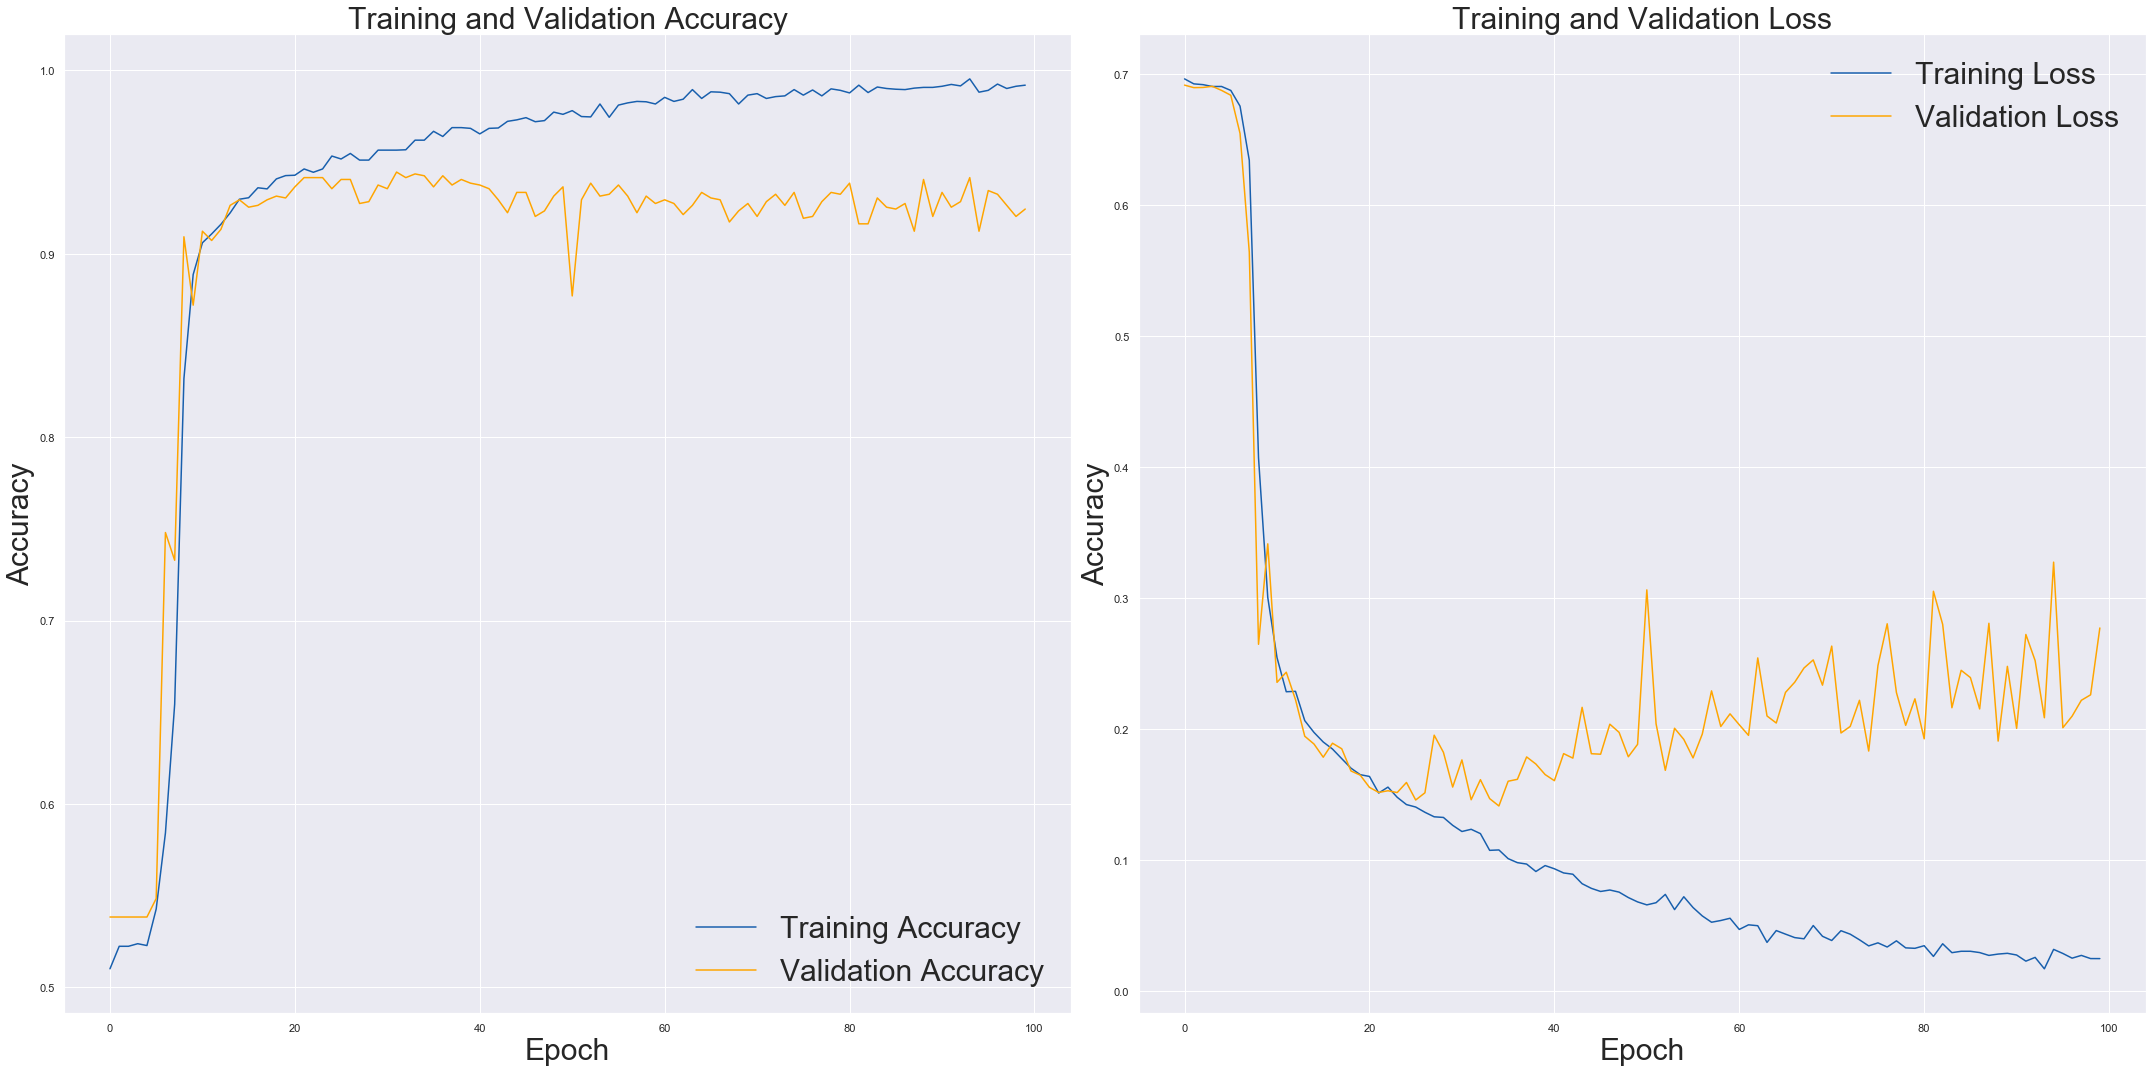

In [18]:
train_acc_imp = imp_history.history['accuracy']
val_acc_imp = imp_history.history['val_accuracy']
train_loss_imp = imp_history.history['loss']
val_loss_imp = imp_history.history['val_loss']


plot_accuracy_loss(train_acc_imp, val_acc_imp, train_loss_imp, val_loss_imp)

_As per the graphs above, dropout has lowered the oscillations and fluctuations of the loss and accuracy val curves; yet the model's loss has risen up, therefore; **early stopping** is a must to be added to the next step of the hyperparameter tuning. The previous models had 4 conv layers, we can do opt to 3 or 2 to observe the difference._

**Keras-tuner with Hyperparameter tuning CNN Model:**

In [21]:
tensorboard_callback = TensorBoard(log_dir=log_dir+'/modelHP')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto') #Add early stopping

class MyHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        hp_model = Sequential()
        
        initializer = tf.keras.initializers.GlorotNormal() # Add initializers for the Dense layers because 
                                                            # Conv2D's default initializer is GlorotNormal.
        initializerZeros = tf.keras.initializers.Zeros() #Add zeros initializer on the softmax's weights.
        
        # 3X3X32 filters, RGB 64x64 input image.
        hp_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64,64,3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        hp_model.add(Dropout(hp.Float('drop1',
                                       min_value = 0.1,
                                       max_value = 0.5,
                                       step = 0.1))) #Add dropout
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        

        hp_model.add(Conv2D(filters= 128, kernel_size=(3, 3), activation='relu'))
        hp_model.add(MaxPooling2D(pool_size=(2, 2)))
        hp_model.add(Dropout(hp.Float('drop2',
                                       min_value = 0.2,
                                       max_value = 0.6,
                                       step = 0.1))) #Add dropout


        hp_model.add(Flatten()) #Fully Connected Layer
        hp_model.add(Dense(512, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu'))
        hp_model.add(Dropout(0.3))
        hp_model.add(Dense(128, kernel_initializer = initializer,  kernel_regularizer = 'l2',activation='relu')) #Fully Connected Layer
        hp_model.add(Dropout(0.2))
        hp_model.add(Dense(2, kernel_initializer = initializerZeros,  kernel_regularizer = 'l2',activation='softmax'))

        hp_model.compile(loss='categorical_crossentropy',
        # Likewase in NN, CNN's do not work with Adam on this dataset, it is extremely noisy, SGD is way better than Adam.
        optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('lr', values = [0.001,0.01,0.1]),
                                                        momentum = hp.Choice('momentum', values=[0.3,0.4,0.5,0.6,0.7,0.8])), 
                                                        metrics=['accuracy'])

        return hp_model


hypermodel = MyHyperModel(num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=15, #15 Trials only for this Hyperparameter tuning.
    directory='my_dir',
    project_name='cnnHyperParameter')

s = tuner.search(train_generator,
             epochs=100,
             validation_data=val_generator,
             callbacks= [tensorboard_callback, early_stop],
             batch_size = 128
             )

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9669 - accuracy: 0.375 - ETA: 14s - loss: 11.9647 - accuracy: 0.42 - ETA: 13s - loss: 11.9620 - accuracy: 0.44 - ETA: 13s - loss: 11.9594 - accuracy: 0.42 - ETA: 13s - loss: 11.9563 - accuracy: 0.45 - ETA: 13s - loss: 11.9529 - accuracy: 0.47 - ETA: 13s - loss: 11.9496 - accuracy: 0.48 - ETA: 13s - loss: 11.9463 - accuracy: 0.48 - ETA: 13s - loss: 11.9435 - accuracy: 0.48 - ETA: 12s - loss: 11.9400 - accuracy: 0.49 - ETA: 12s - loss: 11.9368 - accuracy: 0.50 - ETA: 12s - loss: 11.9336 - accuracy: 0.50 - ETA: 12s - loss: 11.9305 - accuracy: 0.50 - ETA: 12s - loss: 11.9272 - accuracy: 0.50 - ETA: 12s - loss: 11.9237 - accuracy: 0.51 - ETA: 12s - loss: 11.9203 - accuracy: 0.51 - ETA: 12s - loss: 11.9173 - accuracy: 0.51 - ETA: 12s - loss: 11.9140 - accuracy: 0.51 - ETA: 12s - loss: 11.9104 - accuracy: 0.51 - ETA: 11s - loss: 11.9068 - accuracy: 0.52 - ETA: 11s - loss: 11.9043 - accuracy: 0.51 - ETA: 11s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 10.1114 - accuracy: 0.593 - ETA: 6s - loss: 10.1125 - accuracy: 0.546 - ETA: 9s - loss: 10.1094 - accuracy: 0.541 - ETA: 10s - loss: 10.1038 - accuracy: 0.57 - ETA: 10s - loss: 10.1022 - accuracy: 0.56 - ETA: 10s - loss: 10.0993 - accuracy: 0.56 - ETA: 11s - loss: 10.0968 - accuracy: 0.55 - ETA: 11s - loss: 10.0932 - accuracy: 0.56 - ETA: 11s - loss: 10.0902 - accuracy: 0.56 - ETA: 11s - loss: 10.0895 - accuracy: 0.55 - ETA: 11s - loss: 10.0869 - accuracy: 0.55 - ETA: 11s - loss: 10.0845 - accuracy: 0.54 - ETA: 11s - loss: 10.0821 - accuracy: 0.54 - ETA: 11s - loss: 10.0784 - accuracy: 0.55 - ETA: 11s - loss: 10.0769 - accuracy: 0.54 - ETA: 11s - loss: 10.0737 - accuracy: 0.54 - ETA: 11s - loss: 10.0719 - accuracy: 0.54 - ETA: 11s - loss: 10.0687 - accuracy: 0.54 - ETA: 11s - loss: 10.0649 - accuracy: 0.55 - ETA: 11s - loss: 10.0621 - accuracy: 0.55 - ETA: 11s - loss: 10.0598 - accuracy: 0.55 - ETA: 11s - loss: 10.0569 - accura

157/157 [==============================] - ETA: 0s - loss: 8.5648 - accuracy: 0.53 - ETA: 7s - loss: 8.5644 - accuracy: 0.50 - ETA: 9s - loss: 8.5619 - accuracy: 0.51 - ETA: 10s - loss: 8.5590 - accuracy: 0.515 - ETA: 11s - loss: 8.5584 - accuracy: 0.500 - ETA: 11s - loss: 8.5564 - accuracy: 0.494 - ETA: 11s - loss: 8.5541 - accuracy: 0.495 - ETA: 11s - loss: 8.5519 - accuracy: 0.496 - ETA: 11s - loss: 8.5495 - accuracy: 0.506 - ETA: 11s - loss: 8.5479 - accuracy: 0.493 - ETA: 12s - loss: 8.5451 - accuracy: 0.505 - ETA: 12s - loss: 8.5429 - accuracy: 0.507 - ETA: 12s - loss: 8.5408 - accuracy: 0.504 - ETA: 12s - loss: 8.5379 - accuracy: 0.513 - ETA: 12s - loss: 8.5357 - accuracy: 0.516 - ETA: 12s - loss: 8.5337 - accuracy: 0.515 - ETA: 12s - loss: 8.5314 - accuracy: 0.516 - ETA: 12s - loss: 8.5287 - accuracy: 0.519 - ETA: 12s - loss: 8.5266 - accuracy: 0.516 - ETA: 11s - loss: 8.5242 - accuracy: 0.518 - ETA: 11s - loss: 8.5219 - accuracy: 0.520 - ETA: 11s - loss: 8.5199 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.2823 - accuracy: 0.46 - ETA: 6s - loss: 7.2770 - accuracy: 0.46 - ETA: 8s - loss: 7.2746 - accuracy: 0.47 - ETA: 10s - loss: 7.2752 - accuracy: 0.453 - ETA: 11s - loss: 7.2692 - accuracy: 0.493 - ETA: 11s - loss: 7.2662 - accuracy: 0.505 - ETA: 11s - loss: 7.2628 - accuracy: 0.522 - ETA: 12s - loss: 7.2592 - accuracy: 0.539 - ETA: 12s - loss: 7.2606 - accuracy: 0.517 - ETA: 12s - loss: 7.2596 - accuracy: 0.509 - ETA: 12s - loss: 7.2579 - accuracy: 0.505 - ETA: 12s - loss: 7.2550 - accuracy: 0.513 - ETA: 12s - loss: 7.2534 - accuracy: 0.509 - ETA: 12s - loss: 7.2513 - accuracy: 0.513 - ETA: 12s - loss: 7.2489 - accuracy: 0.518 - ETA: 12s - loss: 7.2468 - accuracy: 0.519 - ETA: 12s - loss: 7.2448 - accuracy: 0.520 - ETA: 11s - loss: 7.2435 - accuracy: 0.513 - ETA: 11s - loss: 7.2415 - accuracy: 0.514 - ETA: 11s - loss: 7.2399 - accuracy: 0.510 - ETA: 11s - loss: 7.2382 - accuracy: 0.508 - ETA: 11s - loss: 7.2366 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.2029 - accuracy: 0.43 - ETA: 7s - loss: 6.2033 - accuracy: 0.39 - ETA: 9s - loss: 6.1960 - accuracy: 0.43 - ETA: 10s - loss: 6.1947 - accuracy: 0.437 - ETA: 11s - loss: 6.1922 - accuracy: 0.450 - ETA: 11s - loss: 6.1902 - accuracy: 0.447 - ETA: 11s - loss: 6.1853 - accuracy: 0.491 - ETA: 11s - loss: 6.1833 - accuracy: 0.496 - ETA: 11s - loss: 6.1806 - accuracy: 0.506 - ETA: 11s - loss: 6.1804 - accuracy: 0.493 - ETA: 12s - loss: 6.1783 - accuracy: 0.500 - ETA: 12s - loss: 6.1761 - accuracy: 0.507 - ETA: 12s - loss: 6.1754 - accuracy: 0.497 - ETA: 12s - loss: 6.1739 - accuracy: 0.495 - ETA: 12s - loss: 6.1731 - accuracy: 0.489 - ETA: 12s - loss: 6.1717 - accuracy: 0.486 - ETA: 11s - loss: 6.1700 - accuracy: 0.489 - ETA: 11s - loss: 6.1680 - accuracy: 0.494 - ETA: 11s - loss: 6.1661 - accuracy: 0.496 - ETA: 11s - loss: 6.1646 - accuracy: 0.495 - ETA: 11s - loss: 6.1630 - accuracy: 0.497 - ETA: 11s - loss: 6.1611 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 5.2856 - accuracy: 0.59 - ETA: 6s - loss: 5.2894 - accuracy: 0.51 - ETA: 9s - loss: 5.2890 - accuracy: 0.50 - ETA: 10s - loss: 5.2861 - accuracy: 0.539 - ETA: 10s - loss: 5.2853 - accuracy: 0.518 - ETA: 11s - loss: 5.2836 - accuracy: 0.520 - ETA: 11s - loss: 5.2834 - accuracy: 0.508 - ETA: 11s - loss: 5.2824 - accuracy: 0.500 - ETA: 11s - loss: 5.2811 - accuracy: 0.503 - ETA: 11s - loss: 5.2794 - accuracy: 0.509 - ETA: 12s - loss: 5.2769 - accuracy: 0.528 - ETA: 12s - loss: 5.2752 - accuracy: 0.526 - ETA: 12s - loss: 5.2737 - accuracy: 0.519 - ETA: 12s - loss: 5.2722 - accuracy: 0.517 - ETA: 12s - loss: 5.2709 - accuracy: 0.520 - ETA: 12s - loss: 5.2699 - accuracy: 0.511 - ETA: 12s - loss: 5.2683 - accuracy: 0.516 - ETA: 11s - loss: 5.2663 - accuracy: 0.520 - ETA: 11s - loss: 5.2647 - accuracy: 0.526 - ETA: 11s - loss: 5.2634 - accuracy: 0.523 - ETA: 11s - loss: 5.2624 - accuracy: 0.519 - ETA: 11s - loss: 5.2605 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.5430 - accuracy: 0.43 - ETA: 6s - loss: 4.5325 - accuracy: 0.48 - ETA: 8s - loss: 4.5279 - accuracy: 0.51 - ETA: 9s - loss: 4.5253 - accuracy: 0.54 - ETA: 10s - loss: 4.5229 - accuracy: 0.562 - ETA: 10s - loss: 4.5227 - accuracy: 0.552 - ETA: 11s - loss: 4.5223 - accuracy: 0.540 - ETA: 11s - loss: 4.5224 - accuracy: 0.531 - ETA: 11s - loss: 4.5238 - accuracy: 0.510 - ETA: 11s - loss: 4.5242 - accuracy: 0.500 - ETA: 11s - loss: 4.5234 - accuracy: 0.491 - ETA: 11s - loss: 4.5226 - accuracy: 0.489 - ETA: 11s - loss: 4.5207 - accuracy: 0.500 - ETA: 11s - loss: 4.5188 - accuracy: 0.513 - ETA: 11s - loss: 4.5165 - accuracy: 0.527 - ETA: 11s - loss: 4.5148 - accuracy: 0.533 - ETA: 11s - loss: 4.5133 - accuracy: 0.538 - ETA: 11s - loss: 4.5123 - accuracy: 0.538 - ETA: 11s - loss: 4.5103 - accuracy: 0.544 - ETA: 11s - loss: 4.5091 - accuracy: 0.539 - ETA: 11s - loss: 4.5073 - accuracy: 0.541 - ETA: 11s - loss: 4.5061 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 3.8866 - accuracy: 0.56 - ETA: 6s - loss: 3.8861 - accuracy: 0.59 - ETA: 9s - loss: 3.8808 - accuracy: 0.61 - ETA: 10s - loss: 3.8813 - accuracy: 0.585 - ETA: 10s - loss: 3.8778 - accuracy: 0.593 - ETA: 11s - loss: 3.8751 - accuracy: 0.599 - ETA: 11s - loss: 3.8775 - accuracy: 0.598 - ETA: 11s - loss: 3.8764 - accuracy: 0.585 - ETA: 11s - loss: 3.8783 - accuracy: 0.579 - ETA: 11s - loss: 3.8762 - accuracy: 0.578 - ETA: 11s - loss: 3.8754 - accuracy: 0.573 - ETA: 11s - loss: 3.8756 - accuracy: 0.575 - ETA: 11s - loss: 3.8752 - accuracy: 0.569 - ETA: 11s - loss: 3.8757 - accuracy: 0.558 - ETA: 11s - loss: 3.8731 - accuracy: 0.566 - ETA: 11s - loss: 3.8729 - accuracy: 0.568 - ETA: 11s - loss: 3.8705 - accuracy: 0.568 - ETA: 11s - loss: 3.8691 - accuracy: 0.572 - ETA: 11s - loss: 3.8688 - accuracy: 0.570 - ETA: 11s - loss: 3.8684 - accuracy: 0.570 - ETA: 11s - loss: 3.8669 - accuracy: 0.575 - ETA: 11s - loss: 3.8651 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.2061 - accuracy: 0.78 - ETA: 6s - loss: 3.2142 - accuracy: 0.75 - ETA: 8s - loss: 3.2149 - accuracy: 0.78 - ETA: 10s - loss: 3.2332 - accuracy: 0.734 - ETA: 10s - loss: 3.2678 - accuracy: 0.693 - ETA: 11s - loss: 3.2811 - accuracy: 0.682 - ETA: 11s - loss: 3.2751 - accuracy: 0.692 - ETA: 11s - loss: 3.2708 - accuracy: 0.699 - ETA: 11s - loss: 3.2612 - accuracy: 0.708 - ETA: 11s - loss: 3.2589 - accuracy: 0.706 - ETA: 11s - loss: 3.2567 - accuracy: 0.710 - ETA: 11s - loss: 3.2549 - accuracy: 0.718 - ETA: 11s - loss: 3.2488 - accuracy: 0.728 - ETA: 11s - loss: 3.2488 - accuracy: 0.729 - ETA: 11s - loss: 3.2473 - accuracy: 0.725 - ETA: 11s - loss: 3.2496 - accuracy: 0.712 - ETA: 11s - loss: 3.2503 - accuracy: 0.711 - ETA: 11s - loss: 3.2447 - accuracy: 0.718 - ETA: 11s - loss: 3.2410 - accuracy: 0.720 - ETA: 11s - loss: 3.2405 - accuracy: 0.718 - ETA: 11s - loss: 3.2374 - accuracy: 0.721 - ETA: 11s - loss: 3.2392 - accuracy: 0.7

157/157 [==============================] - ETA: 0s - loss: 2.6355 - accuracy: 0.84 - ETA: 7s - loss: 2.6635 - accuracy: 0.84 - ETA: 9s - loss: 2.6774 - accuracy: 0.82 - ETA: 10s - loss: 2.6671 - accuracy: 0.835 - ETA: 11s - loss: 2.6967 - accuracy: 0.837 - ETA: 11s - loss: 2.7125 - accuracy: 0.817 - ETA: 11s - loss: 2.7175 - accuracy: 0.808 - ETA: 12s - loss: 2.7296 - accuracy: 0.793 - ETA: 12s - loss: 2.7168 - accuracy: 0.795 - ETA: 12s - loss: 2.7108 - accuracy: 0.800 - ETA: 12s - loss: 2.7149 - accuracy: 0.795 - ETA: 12s - loss: 2.7291 - accuracy: 0.786 - ETA: 11s - loss: 2.7155 - accuracy: 0.795 - ETA: 11s - loss: 2.7107 - accuracy: 0.792 - ETA: 11s - loss: 2.7058 - accuracy: 0.793 - ETA: 11s - loss: 2.7101 - accuracy: 0.793 - ETA: 11s - loss: 2.7069 - accuracy: 0.794 - ETA: 11s - loss: 2.7028 - accuracy: 0.795 - ETA: 11s - loss: 2.6984 - accuracy: 0.799 - ETA: 11s - loss: 2.6916 - accuracy: 0.800 - ETA: 11s - loss: 2.6859 - accuracy: 0.803 - ETA: 11s - loss: 2.6855 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 2.2314 - accuracy: 0.84 - ETA: 6s - loss: 2.1645 - accuracy: 0.90 - ETA: 9s - loss: 2.2053 - accuracy: 0.88 - ETA: 10s - loss: 2.2089 - accuracy: 0.875 - ETA: 11s - loss: 2.1998 - accuracy: 0.887 - ETA: 11s - loss: 2.1989 - accuracy: 0.901 - ETA: 11s - loss: 2.2167 - accuracy: 0.892 - ETA: 11s - loss: 2.2088 - accuracy: 0.890 - ETA: 11s - loss: 2.2148 - accuracy: 0.888 - ETA: 11s - loss: 2.2128 - accuracy: 0.884 - ETA: 11s - loss: 2.2122 - accuracy: 0.886 - ETA: 11s - loss: 2.2073 - accuracy: 0.888 - ETA: 11s - loss: 2.2197 - accuracy: 0.882 - ETA: 11s - loss: 2.2107 - accuracy: 0.888 - ETA: 11s - loss: 2.2161 - accuracy: 0.887 - ETA: 11s - loss: 2.2156 - accuracy: 0.884 - ETA: 11s - loss: 2.2184 - accuracy: 0.886 - ETA: 11s - loss: 2.2188 - accuracy: 0.883 - ETA: 11s - loss: 2.2234 - accuracy: 0.875 - ETA: 11s - loss: 2.2250 - accuracy: 0.873 - ETA: 11s - loss: 2.2192 - accuracy: 0.876 - ETA: 11s - loss: 2.2144 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 1.8532 - accuracy: 0.90 - ETA: 6s - loss: 1.7966 - accuracy: 0.93 - ETA: 8s - loss: 1.8032 - accuracy: 0.93 - ETA: 9s - loss: 1.7936 - accuracy: 0.93 - ETA: 10s - loss: 1.8018 - accuracy: 0.931 - ETA: 10s - loss: 1.8065 - accuracy: 0.921 - ETA: 11s - loss: 1.8127 - accuracy: 0.919 - ETA: 11s - loss: 1.8143 - accuracy: 0.921 - ETA: 11s - loss: 1.8106 - accuracy: 0.920 - ETA: 11s - loss: 1.8217 - accuracy: 0.918 - ETA: 11s - loss: 1.8216 - accuracy: 0.920 - ETA: 11s - loss: 1.8233 - accuracy: 0.919 - ETA: 11s - loss: 1.8120 - accuracy: 0.925 - ETA: 11s - loss: 1.8102 - accuracy: 0.926 - ETA: 11s - loss: 1.8064 - accuracy: 0.925 - ETA: 11s - loss: 1.8070 - accuracy: 0.921 - ETA: 11s - loss: 1.8010 - accuracy: 0.924 - ETA: 11s - loss: 1.7964 - accuracy: 0.927 - ETA: 11s - loss: 1.7905 - accuracy: 0.929 - ETA: 11s - loss: 1.7884 - accuracy: 0.929 - ETA: 11s - loss: 1.8091 - accuracy: 0.919 - ETA: 11s - loss: 1.8272 - accuracy: 0.911

157/157 [==============================] - ETA: 0s - loss: 1.4551 - accuracy: 0.96 - ETA: 7s - loss: 1.5051 - accuracy: 0.92 - ETA: 9s - loss: 1.5147 - accuracy: 0.91 - ETA: 11s - loss: 1.5407 - accuracy: 0.898 - ETA: 11s - loss: 1.5470 - accuracy: 0.906 - ETA: 12s - loss: 1.5428 - accuracy: 0.911 - ETA: 12s - loss: 1.5250 - accuracy: 0.924 - ETA: 13s - loss: 1.5153 - accuracy: 0.933 - ETA: 13s - loss: 1.5293 - accuracy: 0.923 - ETA: 13s - loss: 1.5210 - accuracy: 0.928 - ETA: 13s - loss: 1.5188 - accuracy: 0.931 - ETA: 13s - loss: 1.5368 - accuracy: 0.927 - ETA: 13s - loss: 1.5293 - accuracy: 0.930 - ETA: 13s - loss: 1.5292 - accuracy: 0.928 - ETA: 13s - loss: 1.5253 - accuracy: 0.931 - ETA: 13s - loss: 1.5176 - accuracy: 0.935 - ETA: 13s - loss: 1.5114 - accuracy: 0.939 - ETA: 13s - loss: 1.5075 - accuracy: 0.941 - ETA: 13s - loss: 1.5114 - accuracy: 0.939 - ETA: 13s - loss: 1.5064 - accuracy: 0.940 - ETA: 13s - loss: 1.5072 - accuracy: 0.940 - ETA: 13s - loss: 1.5079 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 1.1871 - accuracy: 1.00 - ETA: 6s - loss: 1.2723 - accuracy: 0.95 - ETA: 8s - loss: 1.3147 - accuracy: 0.93 - ETA: 9s - loss: 1.3036 - accuracy: 0.94 - ETA: 10s - loss: 1.2812 - accuracy: 0.956 - ETA: 10s - loss: 1.2998 - accuracy: 0.953 - ETA: 10s - loss: 1.2874 - accuracy: 0.955 - ETA: 11s - loss: 1.2830 - accuracy: 0.957 - ETA: 11s - loss: 1.2789 - accuracy: 0.951 - ETA: 11s - loss: 1.2872 - accuracy: 0.946 - ETA: 11s - loss: 1.2838 - accuracy: 0.948 - ETA: 11s - loss: 1.2902 - accuracy: 0.947 - ETA: 11s - loss: 1.2849 - accuracy: 0.949 - ETA: 11s - loss: 1.2896 - accuracy: 0.946 - ETA: 11s - loss: 1.2870 - accuracy: 0.947 - ETA: 11s - loss: 1.2951 - accuracy: 0.945 - ETA: 11s - loss: 1.2931 - accuracy: 0.946 - ETA: 11s - loss: 1.2959 - accuracy: 0.944 - ETA: 11s - loss: 1.2886 - accuracy: 0.947 - ETA: 11s - loss: 1.2860 - accuracy: 0.946 - ETA: 11s - loss: 1.2887 - accuracy: 0.946 - ETA: 11s - loss: 1.2879 - accuracy: 0.944

157/157 [==============================] - ETA: 0s - loss: 1.1406 - accuracy: 0.93 - ETA: 7s - loss: 1.1408 - accuracy: 0.90 - ETA: 10s - loss: 1.1171 - accuracy: 0.927 - ETA: 11s - loss: 1.0849 - accuracy: 0.945 - ETA: 12s - loss: 1.1078 - accuracy: 0.943 - ETA: 12s - loss: 1.1052 - accuracy: 0.937 - ETA: 13s - loss: 1.1011 - accuracy: 0.942 - ETA: 13s - loss: 1.1206 - accuracy: 0.937 - ETA: 13s - loss: 1.1170 - accuracy: 0.934 - ETA: 13s - loss: 1.1258 - accuracy: 0.934 - ETA: 12s - loss: 1.1281 - accuracy: 0.931 - ETA: 12s - loss: 1.1280 - accuracy: 0.929 - ETA: 12s - loss: 1.1244 - accuracy: 0.930 - ETA: 12s - loss: 1.1275 - accuracy: 0.928 - ETA: 12s - loss: 1.1205 - accuracy: 0.931 - ETA: 12s - loss: 1.1160 - accuracy: 0.933 - ETA: 12s - loss: 1.1122 - accuracy: 0.935 - ETA: 12s - loss: 1.1047 - accuracy: 0.939 - ETA: 12s - loss: 1.1013 - accuracy: 0.940 - ETA: 12s - loss: 1.0970 - accuracy: 0.943 - ETA: 12s - loss: 1.0932 - accuracy: 0.944 - ETA: 12s - loss: 1.0926 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.96 - ETA: 6s - loss: 0.9038 - accuracy: 0.95 - ETA: 8s - loss: 0.9946 - accuracy: 0.91 - ETA: 9s - loss: 0.9943 - accuracy: 0.91 - ETA: 10s - loss: 0.9693 - accuracy: 0.931 - ETA: 10s - loss: 0.9852 - accuracy: 0.927 - ETA: 10s - loss: 0.9838 - accuracy: 0.924 - ETA: 10s - loss: 0.9716 - accuracy: 0.929 - ETA: 11s - loss: 0.9603 - accuracy: 0.937 - ETA: 11s - loss: 0.9531 - accuracy: 0.940 - ETA: 11s - loss: 0.9431 - accuracy: 0.946 - ETA: 11s - loss: 0.9631 - accuracy: 0.937 - ETA: 11s - loss: 0.9651 - accuracy: 0.935 - ETA: 11s - loss: 0.9678 - accuracy: 0.935 - ETA: 11s - loss: 0.9619 - accuracy: 0.939 - ETA: 11s - loss: 0.9552 - accuracy: 0.943 - ETA: 11s - loss: 0.9589 - accuracy: 0.939 - ETA: 11s - loss: 0.9522 - accuracy: 0.942 - ETA: 11s - loss: 0.9620 - accuracy: 0.940 - ETA: 11s - loss: 0.9764 - accuracy: 0.935 - ETA: 10s - loss: 0.9739 - accuracy: 0.937 - ETA: 10s - loss: 0.9700 - accuracy: 0.940

157/157 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.96 - ETA: 7s - loss: 0.8894 - accuracy: 0.93 - ETA: 9s - loss: 0.8755 - accuracy: 0.92 - ETA: 10s - loss: 0.8511 - accuracy: 0.937 - ETA: 10s - loss: 0.8301 - accuracy: 0.950 - ETA: 11s - loss: 0.8578 - accuracy: 0.942 - ETA: 11s - loss: 0.8654 - accuracy: 0.942 - ETA: 11s - loss: 0.8516 - accuracy: 0.945 - ETA: 11s - loss: 0.8621 - accuracy: 0.941 - ETA: 11s - loss: 0.8576 - accuracy: 0.943 - ETA: 11s - loss: 0.8443 - accuracy: 0.948 - ETA: 11s - loss: 0.8616 - accuracy: 0.937 - ETA: 12s - loss: 0.8606 - accuracy: 0.939 - ETA: 12s - loss: 0.8524 - accuracy: 0.944 - ETA: 12s - loss: 0.8440 - accuracy: 0.947 - ETA: 12s - loss: 0.8476 - accuracy: 0.947 - ETA: 12s - loss: 0.8532 - accuracy: 0.943 - ETA: 12s - loss: 0.8536 - accuracy: 0.944 - ETA: 12s - loss: 0.8483 - accuracy: 0.947 - ETA: 12s - loss: 0.8481 - accuracy: 0.945 - ETA: 12s - loss: 0.8469 - accuracy: 0.944 - ETA: 12s - loss: 0.8539 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.93 - ETA: 7s - loss: 0.7047 - accuracy: 0.95 - ETA: 9s - loss: 0.7108 - accuracy: 0.93 - ETA: 10s - loss: 0.6907 - accuracy: 0.945 - ETA: 11s - loss: 0.7075 - accuracy: 0.937 - ETA: 12s - loss: 0.6981 - accuracy: 0.937 - ETA: 12s - loss: 0.6892 - accuracy: 0.946 - ETA: 12s - loss: 0.6979 - accuracy: 0.945 - ETA: 12s - loss: 0.7131 - accuracy: 0.941 - ETA: 12s - loss: 0.7040 - accuracy: 0.946 - ETA: 12s - loss: 0.7011 - accuracy: 0.948 - ETA: 12s - loss: 0.6931 - accuracy: 0.953 - ETA: 12s - loss: 0.6988 - accuracy: 0.951 - ETA: 12s - loss: 0.6992 - accuracy: 0.950 - ETA: 12s - loss: 0.7024 - accuracy: 0.947 - ETA: 12s - loss: 0.7008 - accuracy: 0.949 - ETA: 12s - loss: 0.7047 - accuracy: 0.948 - ETA: 12s - loss: 0.7002 - accuracy: 0.951 - ETA: 12s - loss: 0.6954 - accuracy: 0.953 - ETA: 12s - loss: 0.7009 - accuracy: 0.951 - ETA: 12s - loss: 0.7096 - accuracy: 0.949 - ETA: 12s - loss: 0.7075 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.96 - ETA: 6s - loss: 0.6870 - accuracy: 0.95 - ETA: 9s - loss: 0.7787 - accuracy: 0.92 - ETA: 9s - loss: 0.7448 - accuracy: 0.92 - ETA: 10s - loss: 0.7070 - accuracy: 0.943 - ETA: 10s - loss: 0.6883 - accuracy: 0.947 - ETA: 11s - loss: 0.6755 - accuracy: 0.950 - ETA: 11s - loss: 0.6640 - accuracy: 0.953 - ETA: 11s - loss: 0.6497 - accuracy: 0.958 - ETA: 11s - loss: 0.6514 - accuracy: 0.956 - ETA: 11s - loss: 0.6412 - accuracy: 0.960 - ETA: 11s - loss: 0.6365 - accuracy: 0.958 - ETA: 11s - loss: 0.6455 - accuracy: 0.951 - ETA: 11s - loss: 0.6380 - accuracy: 0.955 - ETA: 11s - loss: 0.6377 - accuracy: 0.954 - ETA: 11s - loss: 0.6318 - accuracy: 0.957 - ETA: 11s - loss: 0.6281 - accuracy: 0.957 - ETA: 11s - loss: 0.6265 - accuracy: 0.958 - ETA: 11s - loss: 0.6295 - accuracy: 0.957 - ETA: 11s - loss: 0.6259 - accuracy: 0.957 - ETA: 11s - loss: 0.6263 - accuracy: 0.956 - ETA: 11s - loss: 0.6233 - accuracy: 0.957

157/157 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.96 - ETA: 6s - loss: 0.5170 - accuracy: 0.98 - ETA: 8s - loss: 0.5083 - accuracy: 0.97 - ETA: 9s - loss: 0.4989 - accuracy: 0.98 - ETA: 10s - loss: 0.5110 - accuracy: 0.975 - ETA: 10s - loss: 0.5060 - accuracy: 0.974 - ETA: 11s - loss: 0.5075 - accuracy: 0.973 - ETA: 11s - loss: 0.5028 - accuracy: 0.976 - ETA: 11s - loss: 0.5058 - accuracy: 0.975 - ETA: 11s - loss: 0.5109 - accuracy: 0.971 - ETA: 11s - loss: 0.5311 - accuracy: 0.960 - ETA: 11s - loss: 0.5327 - accuracy: 0.958 - ETA: 11s - loss: 0.5336 - accuracy: 0.956 - ETA: 11s - loss: 0.5272 - accuracy: 0.959 - ETA: 11s - loss: 0.5242 - accuracy: 0.960 - ETA: 11s - loss: 0.5216 - accuracy: 0.960 - ETA: 11s - loss: 0.5311 - accuracy: 0.957 - ETA: 11s - loss: 0.5292 - accuracy: 0.958 - ETA: 11s - loss: 0.5238 - accuracy: 0.960 - ETA: 11s - loss: 0.5203 - accuracy: 0.962 - ETA: 11s - loss: 0.5201 - accuracy: 0.962 - ETA: 11s - loss: 0.5231 - accuracy: 0.961

157/157 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.90 - ETA: 8s - loss: 0.5263 - accuracy: 0.92 - ETA: 10s - loss: 0.5494 - accuracy: 0.906 - ETA: 11s - loss: 0.5475 - accuracy: 0.921 - ETA: 11s - loss: 0.5223 - accuracy: 0.937 - ETA: 11s - loss: 0.5133 - accuracy: 0.942 - ETA: 12s - loss: 0.4948 - accuracy: 0.950 - ETA: 12s - loss: 0.4883 - accuracy: 0.949 - ETA: 12s - loss: 0.4794 - accuracy: 0.951 - ETA: 12s - loss: 0.4694 - accuracy: 0.956 - ETA: 12s - loss: 0.4612 - accuracy: 0.960 - ETA: 12s - loss: 0.4540 - accuracy: 0.963 - ETA: 12s - loss: 0.4504 - accuracy: 0.966 - ETA: 12s - loss: 0.4516 - accuracy: 0.964 - ETA: 12s - loss: 0.4463 - accuracy: 0.966 - ETA: 12s - loss: 0.4482 - accuracy: 0.964 - ETA: 12s - loss: 0.4446 - accuracy: 0.966 - ETA: 12s - loss: 0.4482 - accuracy: 0.965 - ETA: 12s - loss: 0.4507 - accuracy: 0.965 - ETA: 12s - loss: 0.4490 - accuracy: 0.965 - ETA: 12s - loss: 0.4473 - accuracy: 0.965 - ETA: 12s - loss: 0.4493 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 1.00 - ETA: 6s - loss: 0.3568 - accuracy: 1.00 - ETA: 8s - loss: 0.3690 - accuracy: 0.97 - ETA: 9s - loss: 0.3745 - accuracy: 0.97 - ETA: 10s - loss: 0.3855 - accuracy: 0.968 - ETA: 11s - loss: 0.3872 - accuracy: 0.963 - ETA: 11s - loss: 0.3783 - accuracy: 0.968 - ETA: 11s - loss: 0.3856 - accuracy: 0.964 - ETA: 11s - loss: 0.4045 - accuracy: 0.954 - ETA: 11s - loss: 0.4017 - accuracy: 0.953 - ETA: 11s - loss: 0.4008 - accuracy: 0.951 - ETA: 11s - loss: 0.4115 - accuracy: 0.947 - ETA: 11s - loss: 0.4318 - accuracy: 0.944 - ETA: 11s - loss: 0.4449 - accuracy: 0.939 - ETA: 11s - loss: 0.4404 - accuracy: 0.943 - ETA: 11s - loss: 0.4386 - accuracy: 0.943 - ETA: 11s - loss: 0.4329 - accuracy: 0.946 - ETA: 11s - loss: 0.4307 - accuracy: 0.946 - ETA: 11s - loss: 0.4320 - accuracy: 0.945 - ETA: 11s - loss: 0.4262 - accuracy: 0.948 - ETA: 11s - loss: 0.4332 - accuracy: 0.946 - ETA: 11s - loss: 0.4322 - accuracy: 0.946

157/157 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.96 - ETA: 6s - loss: 0.4171 - accuracy: 0.95 - ETA: 8s - loss: 0.4342 - accuracy: 0.94 - ETA: 9s - loss: 0.4239 - accuracy: 0.95 - ETA: 10s - loss: 0.4627 - accuracy: 0.931 - ETA: 10s - loss: 0.4361 - accuracy: 0.942 - ETA: 11s - loss: 0.4319 - accuracy: 0.942 - ETA: 11s - loss: 0.4425 - accuracy: 0.929 - ETA: 11s - loss: 0.4323 - accuracy: 0.934 - ETA: 11s - loss: 0.4266 - accuracy: 0.937 - ETA: 11s - loss: 0.4206 - accuracy: 0.940 - ETA: 11s - loss: 0.4168 - accuracy: 0.940 - ETA: 11s - loss: 0.4112 - accuracy: 0.942 - ETA: 11s - loss: 0.4118 - accuracy: 0.942 - ETA: 11s - loss: 0.4062 - accuracy: 0.945 - ETA: 11s - loss: 0.4039 - accuracy: 0.947 - ETA: 11s - loss: 0.3966 - accuracy: 0.950 - ETA: 11s - loss: 0.3989 - accuracy: 0.947 - ETA: 11s - loss: 0.3964 - accuracy: 0.949 - ETA: 11s - loss: 0.3994 - accuracy: 0.950 - ETA: 11s - loss: 0.4046 - accuracy: 0.944 - ETA: 11s - loss: 0.4010 - accuracy: 0.946

157/157 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.96 - ETA: 6s - loss: 0.3383 - accuracy: 0.95 - ETA: 8s - loss: 0.4293 - accuracy: 0.92 - ETA: 10s - loss: 0.3908 - accuracy: 0.937 - ETA: 10s - loss: 0.3792 - accuracy: 0.943 - ETA: 11s - loss: 0.3588 - accuracy: 0.953 - ETA: 11s - loss: 0.3645 - accuracy: 0.946 - ETA: 11s - loss: 0.3566 - accuracy: 0.949 - ETA: 11s - loss: 0.3650 - accuracy: 0.944 - ETA: 11s - loss: 0.3645 - accuracy: 0.943 - ETA: 11s - loss: 0.3649 - accuracy: 0.943 - ETA: 11s - loss: 0.3574 - accuracy: 0.945 - ETA: 11s - loss: 0.3521 - accuracy: 0.949 - ETA: 11s - loss: 0.3474 - accuracy: 0.950 - ETA: 11s - loss: 0.3449 - accuracy: 0.952 - ETA: 11s - loss: 0.3392 - accuracy: 0.955 - ETA: 11s - loss: 0.3397 - accuracy: 0.954 - ETA: 11s - loss: 0.3431 - accuracy: 0.953 - ETA: 11s - loss: 0.3443 - accuracy: 0.952 - ETA: 11s - loss: 0.3440 - accuracy: 0.953 - ETA: 11s - loss: 0.3442 - accuracy: 0.953 - ETA: 11s - loss: 0.3431 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 1.00 - ETA: 6s - loss: 0.3320 - accuracy: 0.96 - ETA: 9s - loss: 0.3072 - accuracy: 0.96 - ETA: 10s - loss: 0.2893 - accuracy: 0.976 - ETA: 10s - loss: 0.3057 - accuracy: 0.968 - ETA: 11s - loss: 0.2894 - accuracy: 0.974 - ETA: 11s - loss: 0.2821 - accuracy: 0.977 - ETA: 10s - loss: 0.2745 - accuracy: 0.977 - ETA: 10s - loss: 0.2704 - accuracy: 0.979 - ETA: 10s - loss: 0.2798 - accuracy: 0.969 - ETA: 10s - loss: 0.2824 - accuracy: 0.969 - ETA: 10s - loss: 0.2784 - accuracy: 0.971 - ETA: 10s - loss: 0.2749 - accuracy: 0.971 - ETA: 10s - loss: 0.2732 - accuracy: 0.971 - ETA: 11s - loss: 0.2713 - accuracy: 0.971 - ETA: 11s - loss: 0.2779 - accuracy: 0.969 - ETA: 10s - loss: 0.2735 - accuracy: 0.971 - ETA: 10s - loss: 0.2731 - accuracy: 0.969 - ETA: 10s - loss: 0.2850 - accuracy: 0.965 - ETA: 10s - loss: 0.2832 - accuracy: 0.967 - ETA: 10s - loss: 0.2861 - accuracy: 0.964 - ETA: 10s - loss: 0.2862 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.96 - ETA: 6s - loss: 0.2666 - accuracy: 0.96 - ETA: 8s - loss: 0.2606 - accuracy: 0.95 - ETA: 9s - loss: 0.2678 - accuracy: 0.96 - ETA: 10s - loss: 0.2552 - accuracy: 0.968 - ETA: 10s - loss: 0.2726 - accuracy: 0.963 - ETA: 11s - loss: 0.2661 - accuracy: 0.964 - ETA: 11s - loss: 0.2635 - accuracy: 0.964 - ETA: 11s - loss: 0.2901 - accuracy: 0.961 - ETA: 11s - loss: 0.2941 - accuracy: 0.959 - ETA: 11s - loss: 0.2888 - accuracy: 0.960 - ETA: 11s - loss: 0.2816 - accuracy: 0.963 - ETA: 11s - loss: 0.2790 - accuracy: 0.963 - ETA: 11s - loss: 0.2744 - accuracy: 0.964 - ETA: 11s - loss: 0.2685 - accuracy: 0.966 - ETA: 11s - loss: 0.2724 - accuracy: 0.962 - ETA: 11s - loss: 0.2760 - accuracy: 0.963 - ETA: 11s - loss: 0.2827 - accuracy: 0.960 - ETA: 11s - loss: 0.2857 - accuracy: 0.958 - ETA: 11s - loss: 0.2861 - accuracy: 0.959 - ETA: 11s - loss: 0.2843 - accuracy: 0.959 - ETA: 11s - loss: 0.2814 - accuracy: 0.960

157/157 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.96 - ETA: 6s - loss: 0.3260 - accuracy: 0.93 - ETA: 8s - loss: 0.3284 - accuracy: 0.94 - ETA: 9s - loss: 0.2956 - accuracy: 0.95 - ETA: 10s - loss: 0.3116 - accuracy: 0.950 - ETA: 10s - loss: 0.2877 - accuracy: 0.958 - ETA: 11s - loss: 0.2922 - accuracy: 0.955 - ETA: 11s - loss: 0.2799 - accuracy: 0.960 - ETA: 11s - loss: 0.2840 - accuracy: 0.958 - ETA: 11s - loss: 0.2752 - accuracy: 0.962 - ETA: 11s - loss: 0.2739 - accuracy: 0.960 - ETA: 11s - loss: 0.2788 - accuracy: 0.953 - ETA: 11s - loss: 0.2750 - accuracy: 0.954 - ETA: 11s - loss: 0.2700 - accuracy: 0.957 - ETA: 11s - loss: 0.2675 - accuracy: 0.956 - ETA: 11s - loss: 0.2612 - accuracy: 0.959 - ETA: 11s - loss: 0.2553 - accuracy: 0.961 - ETA: 11s - loss: 0.2503 - accuracy: 0.963 - ETA: 11s - loss: 0.2481 - accuracy: 0.963 - ETA: 11s - loss: 0.2440 - accuracy: 0.965 - ETA: 11s - loss: 0.2407 - accuracy: 0.967 - ETA: 11s - loss: 0.2447 - accuracy: 0.965

157/157 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 1.00 - ETA: 7s - loss: 0.1600 - accuracy: 1.00 - ETA: 9s - loss: 0.1666 - accuracy: 0.98 - ETA: 10s - loss: 0.1653 - accuracy: 0.992 - ETA: 10s - loss: 0.2097 - accuracy: 0.968 - ETA: 10s - loss: 0.2027 - accuracy: 0.974 - ETA: 11s - loss: 0.1948 - accuracy: 0.977 - ETA: 11s - loss: 0.1968 - accuracy: 0.976 - ETA: 11s - loss: 0.2066 - accuracy: 0.972 - ETA: 11s - loss: 0.2233 - accuracy: 0.968 - ETA: 11s - loss: 0.2252 - accuracy: 0.968 - ETA: 11s - loss: 0.2321 - accuracy: 0.960 - ETA: 11s - loss: 0.2418 - accuracy: 0.956 - ETA: 11s - loss: 0.2387 - accuracy: 0.957 - ETA: 11s - loss: 0.2382 - accuracy: 0.956 - ETA: 11s - loss: 0.2354 - accuracy: 0.957 - ETA: 11s - loss: 0.2386 - accuracy: 0.957 - ETA: 11s - loss: 0.2394 - accuracy: 0.958 - ETA: 11s - loss: 0.2383 - accuracy: 0.957 - ETA: 11s - loss: 0.2359 - accuracy: 0.959 - ETA: 11s - loss: 0.2399 - accuracy: 0.958 - ETA: 11s - loss: 0.2445 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.96 - ETA: 6s - loss: 0.1684 - accuracy: 0.98 - ETA: 8s - loss: 0.1710 - accuracy: 0.97 - ETA: 9s - loss: 0.1845 - accuracy: 0.97 - ETA: 10s - loss: 0.1943 - accuracy: 0.968 - ETA: 10s - loss: 0.1954 - accuracy: 0.974 - ETA: 10s - loss: 0.2000 - accuracy: 0.968 - ETA: 11s - loss: 0.1935 - accuracy: 0.972 - ETA: 11s - loss: 0.1991 - accuracy: 0.968 - ETA: 11s - loss: 0.2061 - accuracy: 0.965 - ETA: 11s - loss: 0.2005 - accuracy: 0.968 - ETA: 11s - loss: 0.1961 - accuracy: 0.971 - ETA: 11s - loss: 0.2014 - accuracy: 0.971 - ETA: 11s - loss: 0.2113 - accuracy: 0.968 - ETA: 11s - loss: 0.2178 - accuracy: 0.964 - ETA: 11s - loss: 0.2267 - accuracy: 0.960 - ETA: 11s - loss: 0.2233 - accuracy: 0.963 - ETA: 11s - loss: 0.2205 - accuracy: 0.965 - ETA: 11s - loss: 0.2233 - accuracy: 0.965 - ETA: 11s - loss: 0.2206 - accuracy: 0.965 - ETA: 11s - loss: 0.2180 - accuracy: 0.967 - ETA: 10s - loss: 0.2151 - accuracy: 0.967

157/157 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.93 - ETA: 6s - loss: 0.2641 - accuracy: 0.90 - ETA: 8s - loss: 0.2332 - accuracy: 0.92 - ETA: 10s - loss: 0.2427 - accuracy: 0.921 - ETA: 10s - loss: 0.2338 - accuracy: 0.925 - ETA: 11s - loss: 0.2356 - accuracy: 0.932 - ETA: 11s - loss: 0.2310 - accuracy: 0.937 - ETA: 11s - loss: 0.2232 - accuracy: 0.941 - ETA: 11s - loss: 0.2302 - accuracy: 0.941 - ETA: 11s - loss: 0.2296 - accuracy: 0.943 - ETA: 11s - loss: 0.2215 - accuracy: 0.948 - ETA: 11s - loss: 0.2255 - accuracy: 0.947 - ETA: 11s - loss: 0.2185 - accuracy: 0.951 - ETA: 11s - loss: 0.2149 - accuracy: 0.953 - ETA: 11s - loss: 0.2110 - accuracy: 0.954 - ETA: 11s - loss: 0.2232 - accuracy: 0.951 - ETA: 11s - loss: 0.2191 - accuracy: 0.952 - ETA: 11s - loss: 0.2253 - accuracy: 0.949 - ETA: 11s - loss: 0.2276 - accuracy: 0.949 - ETA: 11s - loss: 0.2265 - accuracy: 0.948 - ETA: 11s - loss: 0.2246 - accuracy: 0.947 - ETA: 11s - loss: 0.2215 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 1.00 - ETA: 6s - loss: 0.2097 - accuracy: 0.93 - ETA: 9s - loss: 0.1978 - accuracy: 0.95 - ETA: 10s - loss: 0.1995 - accuracy: 0.953 - ETA: 11s - loss: 0.1861 - accuracy: 0.956 - ETA: 11s - loss: 0.1894 - accuracy: 0.958 - ETA: 11s - loss: 0.1999 - accuracy: 0.959 - ETA: 11s - loss: 0.1903 - accuracy: 0.964 - ETA: 11s - loss: 0.2042 - accuracy: 0.958 - ETA: 11s - loss: 0.2035 - accuracy: 0.959 - ETA: 11s - loss: 0.1967 - accuracy: 0.963 - ETA: 11s - loss: 0.2047 - accuracy: 0.958 - ETA: 11s - loss: 0.2223 - accuracy: 0.951 - ETA: 11s - loss: 0.2227 - accuracy: 0.953 - ETA: 11s - loss: 0.2250 - accuracy: 0.950 - ETA: 11s - loss: 0.2303 - accuracy: 0.951 - ETA: 11s - loss: 0.2261 - accuracy: 0.954 - ETA: 11s - loss: 0.2215 - accuracy: 0.956 - ETA: 11s - loss: 0.2309 - accuracy: 0.952 - ETA: 10s - loss: 0.2269 - accuracy: 0.953 - ETA: 10s - loss: 0.2306 - accuracy: 0.952 - ETA: 10s - loss: 0.2264 - accuracy: 0.9

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9615 - accuracy: 0.593 - ETA: 11s - loss: 11.9357 - accuracy: 0.62 - ETA: 12s - loss: 11.9062 - accuracy: 0.59 - ETA: 12s - loss: 11.8738 - accuracy: 0.57 - ETA: 12s - loss: 11.8301 - accuracy: 0.60 - ETA: 12s - loss: 11.7895 - accuracy: 0.59 - ETA: 12s - loss: 11.7474 - accuracy: 0.60 - ETA: 12s - loss: 11.7083 - accuracy: 0.59 - ETA: 12s - loss: 11.6700 - accuracy: 0.58 - ETA: 12s - loss: 11.6317 - accuracy: 0.56 - ETA: 12s - loss: 11.5910 - accuracy: 0.55 - ETA: 12s - loss: 11.5495 - accuracy: 0.55 - ETA: 12s - loss: 11.5081 - accuracy: 0.54 - ETA: 12s - loss: 11.4665 - accuracy: 0.54 - ETA: 12s - loss: 11.4250 - accuracy: 0.54 - ETA: 12s - loss: 11.3835 - accuracy: 0.54 - ETA: 12s - loss: 11.3425 - accuracy: 0.53 - ETA: 12s - loss: 11.3012 - accuracy: 0.53 - ETA: 12s - loss: 11.2600 - accuracy: 0.54 - ETA: 11s - loss: 11.2191 - accuracy: 0.54 - ETA: 11s - loss: 11.1781 - accuracy: 0.54 - ETA: 11s - loss: 11.1

157/157 [==============================] - ETA: 0s - loss: 1.6095 - accuracy: 0.46 - ETA: 6s - loss: 1.5997 - accuracy: 0.50 - ETA: 8s - loss: 1.5924 - accuracy: 0.53 - ETA: 9s - loss: 1.5886 - accuracy: 0.52 - ETA: 10s - loss: 1.5874 - accuracy: 0.506 - ETA: 10s - loss: 1.5832 - accuracy: 0.515 - ETA: 11s - loss: 1.5796 - accuracy: 0.513 - ETA: 11s - loss: 1.5756 - accuracy: 0.511 - ETA: 11s - loss: 1.5708 - accuracy: 0.527 - ETA: 11s - loss: 1.5662 - accuracy: 0.534 - ETA: 11s - loss: 1.5603 - accuracy: 0.545 - ETA: 11s - loss: 1.5573 - accuracy: 0.544 - ETA: 11s - loss: 1.5533 - accuracy: 0.545 - ETA: 11s - loss: 1.5478 - accuracy: 0.551 - ETA: 11s - loss: 1.5456 - accuracy: 0.547 - ETA: 11s - loss: 1.5419 - accuracy: 0.548 - ETA: 11s - loss: 1.5399 - accuracy: 0.542 - ETA: 11s - loss: 1.5362 - accuracy: 0.541 - ETA: 11s - loss: 1.5323 - accuracy: 0.547 - ETA: 11s - loss: 1.5281 - accuracy: 0.553 - ETA: 11s - loss: 1.5262 - accuracy: 0.546 - ETA: 11s - loss: 1.5222 - accuracy: 0.548

157/157 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.84 - ETA: 7s - loss: 0.5771 - accuracy: 0.82 - ETA: 9s - loss: 0.6262 - accuracy: 0.79 - ETA: 10s - loss: 0.6059 - accuracy: 0.796 - ETA: 10s - loss: 0.6010 - accuracy: 0.793 - ETA: 11s - loss: 0.5814 - accuracy: 0.802 - ETA: 11s - loss: 0.5847 - accuracy: 0.794 - ETA: 11s - loss: 0.5796 - accuracy: 0.793 - ETA: 11s - loss: 0.5762 - accuracy: 0.788 - ETA: 11s - loss: 0.5696 - accuracy: 0.790 - ETA: 11s - loss: 0.5810 - accuracy: 0.784 - ETA: 11s - loss: 0.6161 - accuracy: 0.773 - ETA: 11s - loss: 0.6263 - accuracy: 0.757 - ETA: 11s - loss: 0.6317 - accuracy: 0.750 - ETA: 11s - loss: 0.6378 - accuracy: 0.743 - ETA: 11s - loss: 0.6360 - accuracy: 0.746 - ETA: 11s - loss: 0.6353 - accuracy: 0.744 - ETA: 11s - loss: 0.6327 - accuracy: 0.746 - ETA: 11s - loss: 0.6353 - accuracy: 0.743 - ETA: 11s - loss: 0.6318 - accuracy: 0.746 - ETA: 11s - loss: 0.6289 - accuracy: 0.750 - ETA: 11s - loss: 0.6326 - accuracy: 0.7

157/157 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.84 - ETA: 7s - loss: 0.3714 - accuracy: 0.85 - ETA: 9s - loss: 0.4130 - accuracy: 0.84 - ETA: 10s - loss: 0.3721 - accuracy: 0.867 - ETA: 11s - loss: 0.3589 - accuracy: 0.875 - ETA: 11s - loss: 0.3298 - accuracy: 0.890 - ETA: 11s - loss: 0.3231 - accuracy: 0.892 - ETA: 12s - loss: 0.3151 - accuracy: 0.898 - ETA: 12s - loss: 0.3159 - accuracy: 0.892 - ETA: 12s - loss: 0.3272 - accuracy: 0.890 - ETA: 12s - loss: 0.3256 - accuracy: 0.892 - ETA: 12s - loss: 0.3205 - accuracy: 0.893 - ETA: 11s - loss: 0.3913 - accuracy: 0.863 - ETA: 11s - loss: 0.4245 - accuracy: 0.839 - ETA: 11s - loss: 0.4209 - accuracy: 0.842 - ETA: 11s - loss: 0.4193 - accuracy: 0.842 - ETA: 11s - loss: 0.4194 - accuracy: 0.844 - ETA: 11s - loss: 0.4089 - accuracy: 0.851 - ETA: 11s - loss: 0.4005 - accuracy: 0.857 - ETA: 11s - loss: 0.3885 - accuracy: 0.864 - ETA: 11s - loss: 0.3878 - accuracy: 0.867 - ETA: 11s - loss: 0.3828 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.93 - ETA: 6s - loss: 0.3698 - accuracy: 0.90 - ETA: 8s - loss: 0.3496 - accuracy: 0.90 - ETA: 10s - loss: 0.3382 - accuracy: 0.890 - ETA: 10s - loss: 0.3246 - accuracy: 0.893 - ETA: 11s - loss: 0.2964 - accuracy: 0.906 - ETA: 11s - loss: 0.2760 - accuracy: 0.919 - ETA: 11s - loss: 0.2561 - accuracy: 0.929 - ETA: 11s - loss: 0.2539 - accuracy: 0.927 - ETA: 11s - loss: 0.2454 - accuracy: 0.931 - ETA: 11s - loss: 0.2730 - accuracy: 0.920 - ETA: 11s - loss: 0.2776 - accuracy: 0.919 - ETA: 11s - loss: 0.2957 - accuracy: 0.908 - ETA: 11s - loss: 0.2906 - accuracy: 0.908 - ETA: 11s - loss: 0.2852 - accuracy: 0.912 - ETA: 11s - loss: 0.2921 - accuracy: 0.908 - ETA: 11s - loss: 0.2929 - accuracy: 0.909 - ETA: 11s - loss: 0.2872 - accuracy: 0.913 - ETA: 11s - loss: 0.2889 - accuracy: 0.912 - ETA: 11s - loss: 0.2853 - accuracy: 0.914 - ETA: 11s - loss: 0.2817 - accuracy: 0.913 - ETA: 11s - loss: 0.2895 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 1.00 - ETA: 6s - loss: 0.2860 - accuracy: 0.92 - ETA: 8s - loss: 0.2669 - accuracy: 0.93 - ETA: 10s - loss: 0.2492 - accuracy: 0.937 - ETA: 10s - loss: 0.2439 - accuracy: 0.937 - ETA: 11s - loss: 0.2577 - accuracy: 0.927 - ETA: 11s - loss: 0.2595 - accuracy: 0.919 - ETA: 11s - loss: 0.2506 - accuracy: 0.925 - ETA: 11s - loss: 0.2464 - accuracy: 0.927 - ETA: 12s - loss: 0.2484 - accuracy: 0.928 - ETA: 12s - loss: 0.2353 - accuracy: 0.934 - ETA: 12s - loss: 0.2287 - accuracy: 0.937 - ETA: 12s - loss: 0.2207 - accuracy: 0.939 - ETA: 12s - loss: 0.2143 - accuracy: 0.942 - ETA: 12s - loss: 0.2131 - accuracy: 0.941 - ETA: 12s - loss: 0.2127 - accuracy: 0.939 - ETA: 12s - loss: 0.2189 - accuracy: 0.937 - ETA: 12s - loss: 0.2145 - accuracy: 0.941 - ETA: 12s - loss: 0.2106 - accuracy: 0.942 - ETA: 12s - loss: 0.2081 - accuracy: 0.942 - ETA: 12s - loss: 0.2103 - accuracy: 0.942 - ETA: 11s - loss: 0.2120 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 1.00 - ETA: 6s - loss: 0.1852 - accuracy: 0.95 - ETA: 9s - loss: 0.1601 - accuracy: 0.96 - ETA: 10s - loss: 0.1508 - accuracy: 0.968 - ETA: 10s - loss: 0.1460 - accuracy: 0.975 - ETA: 11s - loss: 0.1367 - accuracy: 0.979 - ETA: 11s - loss: 0.1342 - accuracy: 0.982 - ETA: 11s - loss: 0.1288 - accuracy: 0.984 - ETA: 11s - loss: 0.1349 - accuracy: 0.982 - ETA: 11s - loss: 0.1659 - accuracy: 0.971 - ETA: 11s - loss: 0.1654 - accuracy: 0.968 - ETA: 11s - loss: 0.1695 - accuracy: 0.966 - ETA: 11s - loss: 0.1727 - accuracy: 0.961 - ETA: 11s - loss: 0.1744 - accuracy: 0.962 - ETA: 11s - loss: 0.1732 - accuracy: 0.964 - ETA: 11s - loss: 0.1691 - accuracy: 0.966 - ETA: 11s - loss: 0.1674 - accuracy: 0.968 - ETA: 11s - loss: 0.1634 - accuracy: 0.970 - ETA: 11s - loss: 0.1647 - accuracy: 0.968 - ETA: 11s - loss: 0.1660 - accuracy: 0.968 - ETA: 11s - loss: 0.1686 - accuracy: 0.965 - ETA: 11s - loss: 0.1656 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 1.00 - ETA: 6s - loss: 0.1578 - accuracy: 0.96 - ETA: 8s - loss: 0.1834 - accuracy: 0.96 - ETA: 10s - loss: 0.1816 - accuracy: 0.968 - ETA: 10s - loss: 0.1657 - accuracy: 0.975 - ETA: 11s - loss: 0.1520 - accuracy: 0.979 - ETA: 11s - loss: 0.1541 - accuracy: 0.977 - ETA: 11s - loss: 0.1513 - accuracy: 0.976 - ETA: 11s - loss: 0.1498 - accuracy: 0.975 - ETA: 11s - loss: 0.1472 - accuracy: 0.978 - ETA: 11s - loss: 0.1501 - accuracy: 0.977 - ETA: 11s - loss: 0.1499 - accuracy: 0.976 - ETA: 11s - loss: 0.1535 - accuracy: 0.976 - ETA: 11s - loss: 0.1579 - accuracy: 0.975 - ETA: 11s - loss: 0.1550 - accuracy: 0.977 - ETA: 11s - loss: 0.1520 - accuracy: 0.978 - ETA: 11s - loss: 0.1651 - accuracy: 0.976 - ETA: 11s - loss: 0.1684 - accuracy: 0.972 - ETA: 11s - loss: 0.1656 - accuracy: 0.973 - ETA: 11s - loss: 0.1620 - accuracy: 0.975 - ETA: 11s - loss: 0.1593 - accuracy: 0.976 - ETA: 11s - loss: 0.1562 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.93 - ETA: 6s - loss: 0.1346 - accuracy: 0.96 - ETA: 8s - loss: 0.1265 - accuracy: 0.96 - ETA: 10s - loss: 0.1370 - accuracy: 0.968 - ETA: 10s - loss: 0.1670 - accuracy: 0.962 - ETA: 11s - loss: 0.1600 - accuracy: 0.963 - ETA: 11s - loss: 0.1595 - accuracy: 0.964 - ETA: 11s - loss: 0.1536 - accuracy: 0.964 - ETA: 11s - loss: 0.1489 - accuracy: 0.968 - ETA: 11s - loss: 0.1454 - accuracy: 0.971 - ETA: 11s - loss: 0.1471 - accuracy: 0.971 - ETA: 11s - loss: 0.1421 - accuracy: 0.974 - ETA: 11s - loss: 0.1405 - accuracy: 0.973 - ETA: 11s - loss: 0.1490 - accuracy: 0.971 - ETA: 11s - loss: 0.1482 - accuracy: 0.970 - ETA: 11s - loss: 0.1602 - accuracy: 0.964 - ETA: 11s - loss: 0.1571 - accuracy: 0.966 - ETA: 11s - loss: 0.1697 - accuracy: 0.961 - ETA: 11s - loss: 0.1662 - accuracy: 0.963 - ETA: 11s - loss: 0.1636 - accuracy: 0.965 - ETA: 11s - loss: 0.1656 - accuracy: 0.965 - ETA: 11s - loss: 0.1690 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.93 - ETA: 6s - loss: 0.2115 - accuracy: 0.96 - ETA: 9s - loss: 0.1920 - accuracy: 0.96 - ETA: 9s - loss: 0.1753 - accuracy: 0.97 - ETA: 10s - loss: 0.1659 - accuracy: 0.975 - ETA: 11s - loss: 0.1582 - accuracy: 0.974 - ETA: 11s - loss: 0.1528 - accuracy: 0.973 - ETA: 11s - loss: 0.1617 - accuracy: 0.968 - ETA: 11s - loss: 0.1556 - accuracy: 0.972 - ETA: 11s - loss: 0.1497 - accuracy: 0.975 - ETA: 11s - loss: 0.1435 - accuracy: 0.977 - ETA: 11s - loss: 0.1394 - accuracy: 0.979 - ETA: 11s - loss: 0.1383 - accuracy: 0.978 - ETA: 11s - loss: 0.1550 - accuracy: 0.975 - ETA: 11s - loss: 0.1597 - accuracy: 0.975 - ETA: 11s - loss: 0.1590 - accuracy: 0.974 - ETA: 11s - loss: 0.1587 - accuracy: 0.972 - ETA: 11s - loss: 0.1567 - accuracy: 0.974 - ETA: 11s - loss: 0.1579 - accuracy: 0.973 - ETA: 11s - loss: 0.1552 - accuracy: 0.975 - ETA: 11s - loss: 0.1574 - accuracy: 0.973 - ETA: 11s - loss: 0.1552 - accuracy: 0.974

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9562 - accuracy: 0.625 - ETA: 11s - loss: 11.9301 - accuracy: 0.64 - ETA: 12s - loss: 11.8978 - accuracy: 0.60 - ETA: 12s - loss: 11.8546 - accuracy: 0.60 - ETA: 12s - loss: 11.8155 - accuracy: 0.56 - ETA: 12s - loss: 11.7668 - accuracy: 0.54 - ETA: 12s - loss: 11.7100 - accuracy: 0.54 - ETA: 12s - loss: 11.6506 - accuracy: 0.55 - ETA: 12s - loss: 11.5889 - accuracy: 0.56 - ETA: 12s - loss: 11.5284 - accuracy: 0.55 - ETA: 12s - loss: 11.4667 - accuracy: 0.54 - ETA: 12s - loss: 11.4036 - accuracy: 0.54 - ETA: 12s - loss: 11.3394 - accuracy: 0.54 - ETA: 11s - loss: 11.2751 - accuracy: 0.54 - ETA: 11s - loss: 11.2104 - accuracy: 0.54 - ETA: 11s - loss: 11.1458 - accuracy: 0.54 - ETA: 11s - loss: 11.0816 - accuracy: 0.54 - ETA: 11s - loss: 11.0192 - accuracy: 0.53 - ETA: 11s - loss: 10.9550 - accuracy: 0.53 - ETA: 11s - loss: 10.8915 - accuracy: 0.53 - ETA: 11s - loss: 10.8284 - accuracy: 0.52 - ETA: 11s - loss: 10.7

157/157 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.56 - ETA: 7s - loss: 0.8405 - accuracy: 0.59 - ETA: 10s - loss: 0.8390 - accuracy: 0.593 - ETA: 11s - loss: 0.8440 - accuracy: 0.570 - ETA: 11s - loss: 0.8517 - accuracy: 0.537 - ETA: 11s - loss: 0.8494 - accuracy: 0.541 - ETA: 12s - loss: 0.8464 - accuracy: 0.549 - ETA: 12s - loss: 0.8457 - accuracy: 0.546 - ETA: 12s - loss: 0.8456 - accuracy: 0.541 - ETA: 12s - loss: 0.8452 - accuracy: 0.537 - ETA: 12s - loss: 0.8427 - accuracy: 0.545 - ETA: 12s - loss: 0.8418 - accuracy: 0.544 - ETA: 12s - loss: 0.8425 - accuracy: 0.533 - ETA: 12s - loss: 0.8418 - accuracy: 0.531 - ETA: 12s - loss: 0.8405 - accuracy: 0.533 - ETA: 12s - loss: 0.8393 - accuracy: 0.535 - ETA: 12s - loss: 0.8383 - accuracy: 0.534 - ETA: 12s - loss: 0.8371 - accuracy: 0.536 - ETA: 12s - loss: 0.8351 - accuracy: 0.546 - ETA: 11s - loss: 0.8344 - accuracy: 0.541 - ETA: 11s - loss: 0.8345 - accuracy: 0.533 - ETA: 11s - loss: 0.8336 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.65 - ETA: 6s - loss: 0.6875 - accuracy: 0.62 - ETA: 9s - loss: 0.6940 - accuracy: 0.56 - ETA: 10s - loss: 0.6939 - accuracy: 0.554 - ETA: 10s - loss: 0.6949 - accuracy: 0.543 - ETA: 11s - loss: 0.6972 - accuracy: 0.526 - ETA: 11s - loss: 0.7004 - accuracy: 0.500 - ETA: 11s - loss: 0.7006 - accuracy: 0.492 - ETA: 11s - loss: 0.7005 - accuracy: 0.475 - ETA: 11s - loss: 0.7001 - accuracy: 0.475 - ETA: 11s - loss: 0.6995 - accuracy: 0.480 - ETA: 11s - loss: 0.6993 - accuracy: 0.481 - ETA: 11s - loss: 0.6982 - accuracy: 0.490 - ETA: 11s - loss: 0.6995 - accuracy: 0.482 - ETA: 11s - loss: 0.6977 - accuracy: 0.495 - ETA: 11s - loss: 0.6977 - accuracy: 0.496 - ETA: 11s - loss: 0.6957 - accuracy: 0.509 - ETA: 11s - loss: 0.6959 - accuracy: 0.508 - ETA: 11s - loss: 0.6976 - accuracy: 0.501 - ETA: 11s - loss: 0.6977 - accuracy: 0.501 - ETA: 11s - loss: 0.6967 - accuracy: 0.507 - ETA: 11s - loss: 0.6971 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.43 - ETA: 6s - loss: 0.6976 - accuracy: 0.51 - ETA: 8s - loss: 0.6988 - accuracy: 0.50 - ETA: 10s - loss: 0.6978 - accuracy: 0.500 - ETA: 10s - loss: 0.6965 - accuracy: 0.506 - ETA: 10s - loss: 0.6957 - accuracy: 0.510 - ETA: 11s - loss: 0.6954 - accuracy: 0.508 - ETA: 11s - loss: 0.6954 - accuracy: 0.503 - ETA: 11s - loss: 0.6956 - accuracy: 0.489 - ETA: 11s - loss: 0.6954 - accuracy: 0.493 - ETA: 11s - loss: 0.6954 - accuracy: 0.488 - ETA: 11s - loss: 0.6955 - accuracy: 0.484 - ETA: 11s - loss: 0.6955 - accuracy: 0.480 - ETA: 11s - loss: 0.6953 - accuracy: 0.484 - ETA: 11s - loss: 0.6951 - accuracy: 0.485 - ETA: 11s - loss: 0.6950 - accuracy: 0.486 - ETA: 11s - loss: 0.6949 - accuracy: 0.485 - ETA: 11s - loss: 0.6948 - accuracy: 0.489 - ETA: 11s - loss: 0.6947 - accuracy: 0.488 - ETA: 11s - loss: 0.6947 - accuracy: 0.485 - ETA: 11s - loss: 0.6946 - accuracy: 0.492 - ETA: 11s - loss: 0.6948 - accuracy: 0.4

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9444 - accuracy: 0.562 - ETA: 11s - loss: 11.9441 - accuracy: 0.56 - ETA: 12s - loss: 11.9439 - accuracy: 0.53 - ETA: 12s - loss: 11.9435 - accuracy: 0.52 - ETA: 12s - loss: 11.9432 - accuracy: 0.51 - ETA: 12s - loss: 11.9429 - accuracy: 0.49 - ETA: 12s - loss: 11.9425 - accuracy: 0.49 - ETA: 12s - loss: 11.9422 - accuracy: 0.49 - ETA: 12s - loss: 11.9418 - accuracy: 0.49 - ETA: 12s - loss: 11.9414 - accuracy: 0.49 - ETA: 12s - loss: 11.9411 - accuracy: 0.48 - ETA: 12s - loss: 11.9407 - accuracy: 0.48 - ETA: 12s - loss: 11.9403 - accuracy: 0.49 - ETA: 12s - loss: 11.9400 - accuracy: 0.49 - ETA: 12s - loss: 11.9396 - accuracy: 0.48 - ETA: 12s - loss: 11.9392 - accuracy: 0.49 - ETA: 11s - loss: 11.9388 - accuracy: 0.49 - ETA: 11s - loss: 11.9385 - accuracy: 0.48 - ETA: 11s - loss: 11.9381 - accuracy: 0.48 - ETA: 11s - loss: 11.9377 - accuracy: 0.48 - ETA: 11s - loss: 11.9373 - accuracy: 0.49 - ETA: 11s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 11.7044 - accuracy: 0.656 - ETA: 6s - loss: 11.7011 - accuracy: 0.718 - ETA: 8s - loss: 11.7031 - accuracy: 0.666 - ETA: 9s - loss: 11.7037 - accuracy: 0.648 - ETA: 10s - loss: 11.7042 - accuracy: 0.63 - ETA: 10s - loss: 11.7055 - accuracy: 0.59 - ETA: 11s - loss: 11.7058 - accuracy: 0.58 - ETA: 11s - loss: 11.7058 - accuracy: 0.57 - ETA: 11s - loss: 11.7050 - accuracy: 0.58 - ETA: 11s - loss: 11.7048 - accuracy: 0.58 - ETA: 11s - loss: 11.7052 - accuracy: 0.56 - ETA: 11s - loss: 11.7051 - accuracy: 0.55 - ETA: 11s - loss: 11.7052 - accuracy: 0.55 - ETA: 11s - loss: 11.7053 - accuracy: 0.54 - ETA: 11s - loss: 11.7051 - accuracy: 0.53 - ETA: 11s - loss: 11.7050 - accuracy: 0.53 - ETA: 11s - loss: 11.7045 - accuracy: 0.53 - ETA: 11s - loss: 11.7044 - accuracy: 0.53 - ETA: 11s - loss: 11.7042 - accuracy: 0.52 - ETA: 11s - loss: 11.7039 - accuracy: 0.52 - ETA: 11s - loss: 11.7036 - accuracy: 0.52 - ETA: 11s - loss: 11.7032 - accura

157/157 [==============================] - ETA: 0s - loss: 11.4915 - accuracy: 0.406 - ETA: 6s - loss: 11.4837 - accuracy: 0.500 - ETA: 8s - loss: 11.4813 - accuracy: 0.531 - ETA: 9s - loss: 11.4792 - accuracy: 0.554 - ETA: 10s - loss: 11.4806 - accuracy: 0.53 - ETA: 10s - loss: 11.4817 - accuracy: 0.51 - ETA: 11s - loss: 11.4808 - accuracy: 0.51 - ETA: 11s - loss: 11.4808 - accuracy: 0.51 - ETA: 11s - loss: 11.4801 - accuracy: 0.51 - ETA: 11s - loss: 11.4784 - accuracy: 0.53 - ETA: 11s - loss: 11.4776 - accuracy: 0.53 - ETA: 11s - loss: 11.4769 - accuracy: 0.54 - ETA: 11s - loss: 11.4770 - accuracy: 0.53 - ETA: 11s - loss: 11.4762 - accuracy: 0.54 - ETA: 11s - loss: 11.4762 - accuracy: 0.53 - ETA: 11s - loss: 11.4756 - accuracy: 0.54 - ETA: 11s - loss: 11.4757 - accuracy: 0.53 - ETA: 11s - loss: 11.4754 - accuracy: 0.53 - ETA: 11s - loss: 11.4753 - accuracy: 0.53 - ETA: 11s - loss: 11.4750 - accuracy: 0.52 - ETA: 11s - loss: 11.4750 - accuracy: 0.52 - ETA: 11s - loss: 11.4753 - accura

157/157 [==============================] - ETA: 0s - loss: 11.2689 - accuracy: 0.406 - ETA: 6s - loss: 11.2608 - accuracy: 0.500 - ETA: 8s - loss: 11.2554 - accuracy: 0.552 - ETA: 10s - loss: 11.2568 - accuracy: 0.53 - ETA: 10s - loss: 11.2583 - accuracy: 0.51 - ETA: 11s - loss: 11.2580 - accuracy: 0.51 - ETA: 11s - loss: 11.2579 - accuracy: 0.50 - ETA: 11s - loss: 11.2576 - accuracy: 0.50 - ETA: 11s - loss: 11.2570 - accuracy: 0.51 - ETA: 11s - loss: 11.2572 - accuracy: 0.50 - ETA: 11s - loss: 11.2571 - accuracy: 0.50 - ETA: 11s - loss: 11.2565 - accuracy: 0.50 - ETA: 11s - loss: 11.2570 - accuracy: 0.49 - ETA: 11s - loss: 11.2567 - accuracy: 0.49 - ETA: 11s - loss: 11.2569 - accuracy: 0.48 - ETA: 11s - loss: 11.2562 - accuracy: 0.49 - ETA: 11s - loss: 11.2557 - accuracy: 0.49 - ETA: 11s - loss: 11.2553 - accuracy: 0.49 - ETA: 11s - loss: 11.2553 - accuracy: 0.49 - ETA: 11s - loss: 11.2546 - accuracy: 0.49 - ETA: 11s - loss: 11.2544 - accuracy: 0.49 - ETA: 11s - loss: 11.2540 - accura

157/157 [==============================] - ETA: 0s - loss: 11.0304 - accuracy: 0.625 - ETA: 7s - loss: 11.0345 - accuracy: 0.578 - ETA: 9s - loss: 11.0339 - accuracy: 0.572 - ETA: 10s - loss: 11.0380 - accuracy: 0.53 - ETA: 11s - loss: 11.0349 - accuracy: 0.55 - ETA: 11s - loss: 11.0350 - accuracy: 0.55 - ETA: 11s - loss: 11.0374 - accuracy: 0.52 - ETA: 12s - loss: 11.0367 - accuracy: 0.53 - ETA: 12s - loss: 11.0370 - accuracy: 0.52 - ETA: 12s - loss: 11.0359 - accuracy: 0.53 - ETA: 12s - loss: 11.0356 - accuracy: 0.53 - ETA: 13s - loss: 11.0352 - accuracy: 0.53 - ETA: 13s - loss: 11.0344 - accuracy: 0.53 - ETA: 13s - loss: 11.0349 - accuracy: 0.52 - ETA: 13s - loss: 11.0351 - accuracy: 0.52 - ETA: 13s - loss: 11.0349 - accuracy: 0.52 - ETA: 13s - loss: 11.0341 - accuracy: 0.52 - ETA: 13s - loss: 11.0323 - accuracy: 0.54 - ETA: 13s - loss: 11.0318 - accuracy: 0.54 - ETA: 13s - loss: 11.0318 - accuracy: 0.54 - ETA: 13s - loss: 11.0320 - accuracy: 0.53 - ETA: 12s - loss: 11.0319 - accura

157/157 [==============================] - ETA: 0s - loss: 10.8226 - accuracy: 0.562 - ETA: 7s - loss: 10.8248 - accuracy: 0.531 - ETA: 9s - loss: 10.8273 - accuracy: 0.500 - ETA: 10s - loss: 10.8293 - accuracy: 0.47 - ETA: 10s - loss: 10.8264 - accuracy: 0.50 - ETA: 11s - loss: 10.8262 - accuracy: 0.50 - ETA: 11s - loss: 10.8265 - accuracy: 0.49 - ETA: 11s - loss: 10.8240 - accuracy: 0.51 - ETA: 12s - loss: 10.8219 - accuracy: 0.53 - ETA: 12s - loss: 10.8210 - accuracy: 0.53 - ETA: 12s - loss: 10.8195 - accuracy: 0.54 - ETA: 12s - loss: 10.8193 - accuracy: 0.54 - ETA: 12s - loss: 10.8186 - accuracy: 0.55 - ETA: 12s - loss: 10.8184 - accuracy: 0.54 - ETA: 11s - loss: 10.8184 - accuracy: 0.54 - ETA: 11s - loss: 10.8177 - accuracy: 0.54 - ETA: 11s - loss: 10.8184 - accuracy: 0.53 - ETA: 12s - loss: 10.8178 - accuracy: 0.54 - ETA: 12s - loss: 10.8175 - accuracy: 0.54 - ETA: 12s - loss: 10.8173 - accuracy: 0.54 - ETA: 12s - loss: 10.8174 - accuracy: 0.53 - ETA: 11s - loss: 10.8173 - accura

157/157 [==============================] - ETA: 0s - loss: 10.6069 - accuracy: 0.593 - ETA: 7s - loss: 10.6146 - accuracy: 0.531 - ETA: 9s - loss: 10.6185 - accuracy: 0.489 - ETA: 10s - loss: 10.6168 - accuracy: 0.50 - ETA: 11s - loss: 10.6171 - accuracy: 0.49 - ETA: 11s - loss: 10.6186 - accuracy: 0.47 - ETA: 11s - loss: 10.6186 - accuracy: 0.46 - ETA: 12s - loss: 10.6179 - accuracy: 0.47 - ETA: 12s - loss: 10.6173 - accuracy: 0.47 - ETA: 12s - loss: 10.6171 - accuracy: 0.47 - ETA: 12s - loss: 10.6173 - accuracy: 0.46 - ETA: 12s - loss: 10.6172 - accuracy: 0.46 - ETA: 12s - loss: 10.6171 - accuracy: 0.46 - ETA: 12s - loss: 10.6160 - accuracy: 0.47 - ETA: 12s - loss: 10.6146 - accuracy: 0.48 - ETA: 12s - loss: 10.6145 - accuracy: 0.48 - ETA: 12s - loss: 10.6141 - accuracy: 0.48 - ETA: 12s - loss: 10.6132 - accuracy: 0.48 - ETA: 12s - loss: 10.6135 - accuracy: 0.48 - ETA: 12s - loss: 10.6132 - accuracy: 0.48 - ETA: 12s - loss: 10.6122 - accuracy: 0.48 - ETA: 12s - loss: 10.6128 - accura

157/157 [==============================] - ETA: 0s - loss: 10.4037 - accuracy: 0.593 - ETA: 6s - loss: 10.3989 - accuracy: 0.625 - ETA: 9s - loss: 10.3983 - accuracy: 0.625 - ETA: 10s - loss: 10.3980 - accuracy: 0.62 - ETA: 11s - loss: 10.4012 - accuracy: 0.59 - ETA: 11s - loss: 10.4027 - accuracy: 0.57 - ETA: 11s - loss: 10.4033 - accuracy: 0.57 - ETA: 11s - loss: 10.4033 - accuracy: 0.56 - ETA: 12s - loss: 10.4043 - accuracy: 0.55 - ETA: 12s - loss: 10.4049 - accuracy: 0.54 - ETA: 12s - loss: 10.4051 - accuracy: 0.53 - ETA: 12s - loss: 10.4063 - accuracy: 0.52 - ETA: 12s - loss: 10.4065 - accuracy: 0.51 - ETA: 12s - loss: 10.4045 - accuracy: 0.53 - ETA: 11s - loss: 10.4037 - accuracy: 0.53 - ETA: 11s - loss: 10.4029 - accuracy: 0.54 - ETA: 11s - loss: 10.4027 - accuracy: 0.54 - ETA: 11s - loss: 10.4026 - accuracy: 0.53 - ETA: 11s - loss: 10.4027 - accuracy: 0.53 - ETA: 11s - loss: 10.4022 - accuracy: 0.53 - ETA: 11s - loss: 10.4013 - accuracy: 0.54 - ETA: 11s - loss: 10.4007 - accura

157/157 [==============================] - ETA: 0s - loss: 10.2009 - accuracy: 0.593 - ETA: 6s - loss: 10.2042 - accuracy: 0.562 - ETA: 8s - loss: 10.2052 - accuracy: 0.552 - ETA: 10s - loss: 10.2090 - accuracy: 0.51 - ETA: 10s - loss: 10.2070 - accuracy: 0.53 - ETA: 10s - loss: 10.2072 - accuracy: 0.52 - ETA: 11s - loss: 10.2071 - accuracy: 0.52 - ETA: 11s - loss: 10.2057 - accuracy: 0.53 - ETA: 11s - loss: 10.2051 - accuracy: 0.53 - ETA: 11s - loss: 10.2043 - accuracy: 0.54 - ETA: 11s - loss: 10.2043 - accuracy: 0.53 - ETA: 11s - loss: 10.2047 - accuracy: 0.53 - ETA: 11s - loss: 10.2050 - accuracy: 0.52 - ETA: 11s - loss: 10.2048 - accuracy: 0.52 - ETA: 11s - loss: 10.2044 - accuracy: 0.52 - ETA: 11s - loss: 10.2046 - accuracy: 0.51 - ETA: 11s - loss: 10.2038 - accuracy: 0.52 - ETA: 11s - loss: 10.2034 - accuracy: 0.52 - ETA: 11s - loss: 10.2030 - accuracy: 0.52 - ETA: 11s - loss: 10.2028 - accuracy: 0.52 - ETA: 11s - loss: 10.2029 - accuracy: 0.51 - ETA: 11s - loss: 10.2028 - accura

157/157 [==============================] - ETA: 0s - loss: 10.0191 - accuracy: 0.468 - ETA: 6s - loss: 10.0209 - accuracy: 0.437 - ETA: 8s - loss: 10.0173 - accuracy: 0.468 - ETA: 9s - loss: 10.0175 - accuracy: 0.460 - ETA: 10s - loss: 10.0135 - accuracy: 0.49 - ETA: 10s - loss: 10.0129 - accuracy: 0.49 - ETA: 11s - loss: 10.0116 - accuracy: 0.50 - ETA: 11s - loss: 10.0098 - accuracy: 0.51 - ETA: 11s - loss: 10.0086 - accuracy: 0.52 - ETA: 11s - loss: 10.0088 - accuracy: 0.52 - ETA: 11s - loss: 10.0089 - accuracy: 0.51 - ETA: 11s - loss: 10.0076 - accuracy: 0.52 - ETA: 11s - loss: 10.0084 - accuracy: 0.51 - ETA: 11s - loss: 10.0068 - accuracy: 0.53 - ETA: 11s - loss: 10.0059 - accuracy: 0.53 - ETA: 11s - loss: 10.0061 - accuracy: 0.53 - ETA: 11s - loss: 10.0046 - accuracy: 0.54 - ETA: 11s - loss: 10.0047 - accuracy: 0.53 - ETA: 11s - loss: 10.0045 - accuracy: 0.53 - ETA: 11s - loss: 10.0045 - accuracy: 0.53 - ETA: 11s - loss: 10.0048 - accuracy: 0.52 - ETA: 11s - loss: 10.0043 - accura

157/157 [==============================] - ETA: 0s - loss: 9.8306 - accuracy: 0.40 - ETA: 6s - loss: 9.8236 - accuracy: 0.46 - ETA: 8s - loss: 9.8181 - accuracy: 0.52 - ETA: 10s - loss: 9.8124 - accuracy: 0.570 - ETA: 10s - loss: 9.8106 - accuracy: 0.581 - ETA: 10s - loss: 9.8081 - accuracy: 0.599 - ETA: 11s - loss: 9.8060 - accuracy: 0.616 - ETA: 11s - loss: 9.8066 - accuracy: 0.609 - ETA: 11s - loss: 9.8076 - accuracy: 0.597 - ETA: 11s - loss: 9.8083 - accuracy: 0.587 - ETA: 11s - loss: 9.8098 - accuracy: 0.571 - ETA: 11s - loss: 9.8108 - accuracy: 0.559 - ETA: 11s - loss: 9.8116 - accuracy: 0.550 - ETA: 11s - loss: 9.8121 - accuracy: 0.542 - ETA: 11s - loss: 9.8132 - accuracy: 0.529 - ETA: 11s - loss: 9.8137 - accuracy: 0.521 - ETA: 11s - loss: 9.8145 - accuracy: 0.511 - ETA: 11s - loss: 9.8137 - accuracy: 0.515 - ETA: 11s - loss: 9.8134 - accuracy: 0.516 - ETA: 11s - loss: 9.8138 - accuracy: 0.509 - ETA: 11s - loss: 9.8132 - accuracy: 0.511 - ETA: 11s - loss: 9.8132 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.6361 - accuracy: 0.46 - ETA: 6s - loss: 9.6390 - accuracy: 0.43 - ETA: 9s - loss: 9.6399 - accuracy: 0.42 - ETA: 10s - loss: 9.6384 - accuracy: 0.429 - ETA: 10s - loss: 9.6359 - accuracy: 0.450 - ETA: 11s - loss: 9.6337 - accuracy: 0.468 - ETA: 11s - loss: 9.6316 - accuracy: 0.486 - ETA: 11s - loss: 9.6319 - accuracy: 0.480 - ETA: 11s - loss: 9.6297 - accuracy: 0.500 - ETA: 11s - loss: 9.6286 - accuracy: 0.506 - ETA: 11s - loss: 9.6263 - accuracy: 0.525 - ETA: 11s - loss: 9.6278 - accuracy: 0.507 - ETA: 11s - loss: 9.6282 - accuracy: 0.500 - ETA: 11s - loss: 9.6277 - accuracy: 0.502 - ETA: 11s - loss: 9.6266 - accuracy: 0.508 - ETA: 11s - loss: 9.6263 - accuracy: 0.507 - ETA: 11s - loss: 9.6263 - accuracy: 0.505 - ETA: 11s - loss: 9.6267 - accuracy: 0.500 - ETA: 11s - loss: 9.6255 - accuracy: 0.508 - ETA: 11s - loss: 9.6252 - accuracy: 0.507 - ETA: 11s - loss: 9.6247 - accuracy: 0.510 - ETA: 11s - loss: 9.6235 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.4483 - accuracy: 0.46 - ETA: 6s - loss: 9.4472 - accuracy: 0.48 - ETA: 9s - loss: 9.4426 - accuracy: 0.52 - ETA: 10s - loss: 9.4413 - accuracy: 0.531 - ETA: 11s - loss: 9.4396 - accuracy: 0.543 - ETA: 11s - loss: 9.4395 - accuracy: 0.546 - ETA: 12s - loss: 9.4410 - accuracy: 0.531 - ETA: 12s - loss: 9.4419 - accuracy: 0.523 - ETA: 12s - loss: 9.4413 - accuracy: 0.524 - ETA: 12s - loss: 9.4392 - accuracy: 0.540 - ETA: 12s - loss: 9.4390 - accuracy: 0.539 - ETA: 12s - loss: 9.4389 - accuracy: 0.539 - ETA: 12s - loss: 9.4383 - accuracy: 0.540 - ETA: 12s - loss: 9.4371 - accuracy: 0.549 - ETA: 12s - loss: 9.4381 - accuracy: 0.537 - ETA: 12s - loss: 9.4382 - accuracy: 0.533 - ETA: 12s - loss: 9.4378 - accuracy: 0.534 - ETA: 12s - loss: 9.4374 - accuracy: 0.536 - ETA: 12s - loss: 9.4376 - accuracy: 0.532 - ETA: 12s - loss: 9.4377 - accuracy: 0.529 - ETA: 12s - loss: 9.4372 - accuracy: 0.531 - ETA: 12s - loss: 9.4367 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.2477 - accuracy: 0.65 - ETA: 7s - loss: 9.2547 - accuracy: 0.59 - ETA: 9s - loss: 9.2622 - accuracy: 0.53 - ETA: 10s - loss: 9.2660 - accuracy: 0.492 - ETA: 10s - loss: 9.2633 - accuracy: 0.512 - ETA: 11s - loss: 9.2621 - accuracy: 0.520 - ETA: 11s - loss: 9.2616 - accuracy: 0.522 - ETA: 11s - loss: 9.2610 - accuracy: 0.523 - ETA: 11s - loss: 9.2603 - accuracy: 0.524 - ETA: 11s - loss: 9.2617 - accuracy: 0.509 - ETA: 12s - loss: 9.2605 - accuracy: 0.517 - ETA: 12s - loss: 9.2609 - accuracy: 0.510 - ETA: 12s - loss: 9.2601 - accuracy: 0.516 - ETA: 12s - loss: 9.2591 - accuracy: 0.522 - ETA: 12s - loss: 9.2580 - accuracy: 0.529 - ETA: 12s - loss: 9.2582 - accuracy: 0.525 - ETA: 12s - loss: 9.2578 - accuracy: 0.527 - ETA: 11s - loss: 9.2574 - accuracy: 0.527 - ETA: 11s - loss: 9.2566 - accuracy: 0.532 - ETA: 11s - loss: 9.2561 - accuracy: 0.534 - ETA: 11s - loss: 9.2554 - accuracy: 0.538 - ETA: 11s - loss: 9.2548 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.0856 - accuracy: 0.53 - ETA: 7s - loss: 9.0877 - accuracy: 0.50 - ETA: 10s - loss: 9.0832 - accuracy: 0.541 - ETA: 11s - loss: 9.0891 - accuracy: 0.484 - ETA: 12s - loss: 9.0912 - accuracy: 0.462 - ETA: 13s - loss: 9.0890 - accuracy: 0.479 - ETA: 13s - loss: 9.0914 - accuracy: 0.455 - ETA: 13s - loss: 9.0882 - accuracy: 0.480 - ETA: 13s - loss: 9.0861 - accuracy: 0.496 - ETA: 13s - loss: 9.0857 - accuracy: 0.496 - ETA: 13s - loss: 9.0855 - accuracy: 0.497 - ETA: 13s - loss: 9.0854 - accuracy: 0.494 - ETA: 13s - loss: 9.0836 - accuracy: 0.507 - ETA: 13s - loss: 9.0833 - accuracy: 0.506 - ETA: 12s - loss: 9.0818 - accuracy: 0.516 - ETA: 12s - loss: 9.0817 - accuracy: 0.515 - ETA: 12s - loss: 9.0812 - accuracy: 0.518 - ETA: 12s - loss: 9.0814 - accuracy: 0.513 - ETA: 12s - loss: 9.0812 - accuracy: 0.513 - ETA: 12s - loss: 9.0813 - accuracy: 0.509 - ETA: 12s - loss: 9.0817 - accuracy: 0.503 - ETA: 12s - loss: 9.0811 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 8.9163 - accuracy: 0.46 - ETA: 8s - loss: 8.9115 - accuracy: 0.51 - ETA: 10s - loss: 8.9153 - accuracy: 0.479 - ETA: 11s - loss: 8.9158 - accuracy: 0.468 - ETA: 12s - loss: 8.9090 - accuracy: 0.531 - ETA: 12s - loss: 8.9099 - accuracy: 0.520 - ETA: 12s - loss: 8.9083 - accuracy: 0.531 - ETA: 13s - loss: 8.9072 - accuracy: 0.539 - ETA: 13s - loss: 8.9078 - accuracy: 0.531 - ETA: 13s - loss: 8.9073 - accuracy: 0.534 - ETA: 13s - loss: 8.9063 - accuracy: 0.542 - ETA: 14s - loss: 8.9067 - accuracy: 0.536 - ETA: 14s - loss: 8.9074 - accuracy: 0.526 - ETA: 14s - loss: 8.9071 - accuracy: 0.526 - ETA: 14s - loss: 8.9078 - accuracy: 0.518 - ETA: 14s - loss: 8.9085 - accuracy: 0.509 - ETA: 13s - loss: 8.9082 - accuracy: 0.509 - ETA: 14s - loss: 8.9073 - accuracy: 0.515 - ETA: 14s - loss: 8.9075 - accuracy: 0.513 - ETA: 14s - loss: 8.9073 - accuracy: 0.512 - ETA: 13s - loss: 8.9079 - accuracy: 0.504 - ETA: 13s - loss: 8.9077 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 8.7367 - accuracy: 0.56 - ETA: 6s - loss: 8.7411 - accuracy: 0.51 - ETA: 8s - loss: 8.7382 - accuracy: 0.54 - ETA: 10s - loss: 8.7386 - accuracy: 0.531 - ETA: 10s - loss: 8.7373 - accuracy: 0.543 - ETA: 11s - loss: 8.7365 - accuracy: 0.546 - ETA: 11s - loss: 8.7349 - accuracy: 0.558 - ETA: 11s - loss: 8.7333 - accuracy: 0.570 - ETA: 11s - loss: 8.7347 - accuracy: 0.555 - ETA: 11s - loss: 8.7341 - accuracy: 0.559 - ETA: 11s - loss: 8.7335 - accuracy: 0.562 - ETA: 11s - loss: 8.7344 - accuracy: 0.552 - ETA: 11s - loss: 8.7333 - accuracy: 0.557 - ETA: 11s - loss: 8.7323 - accuracy: 0.564 - ETA: 11s - loss: 8.7317 - accuracy: 0.568 - ETA: 11s - loss: 8.7318 - accuracy: 0.566 - ETA: 11s - loss: 8.7324 - accuracy: 0.557 - ETA: 11s - loss: 8.7325 - accuracy: 0.553 - ETA: 11s - loss: 8.7318 - accuracy: 0.559 - ETA: 11s - loss: 8.7320 - accuracy: 0.554 - ETA: 11s - loss: 8.7309 - accuracy: 0.561 - ETA: 11s - loss: 8.7313 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.5792 - accuracy: 0.46 - ETA: 6s - loss: 8.5765 - accuracy: 0.48 - ETA: 8s - loss: 8.5689 - accuracy: 0.55 - ETA: 9s - loss: 8.5687 - accuracy: 0.55 - ETA: 10s - loss: 8.5716 - accuracy: 0.531 - ETA: 10s - loss: 8.5723 - accuracy: 0.526 - ETA: 10s - loss: 8.5723 - accuracy: 0.522 - ETA: 11s - loss: 8.5734 - accuracy: 0.511 - ETA: 11s - loss: 8.5714 - accuracy: 0.527 - ETA: 11s - loss: 8.5714 - accuracy: 0.525 - ETA: 11s - loss: 8.5703 - accuracy: 0.531 - ETA: 11s - loss: 8.5692 - accuracy: 0.539 - ETA: 11s - loss: 8.5677 - accuracy: 0.550 - ETA: 11s - loss: 8.5680 - accuracy: 0.546 - ETA: 11s - loss: 8.5681 - accuracy: 0.543 - ETA: 11s - loss: 8.5675 - accuracy: 0.546 - ETA: 11s - loss: 8.5674 - accuracy: 0.546 - ETA: 11s - loss: 8.5674 - accuracy: 0.543 - ETA: 11s - loss: 8.5676 - accuracy: 0.539 - ETA: 11s - loss: 8.5675 - accuracy: 0.537 - ETA: 11s - loss: 8.5666 - accuracy: 0.543 - ETA: 11s - loss: 8.5673 - accuracy: 0.534

157/157 [==============================] - ETA: 0s - loss: 8.4242 - accuracy: 0.40 - ETA: 7s - loss: 8.4203 - accuracy: 0.43 - ETA: 9s - loss: 8.4141 - accuracy: 0.50 - ETA: 10s - loss: 8.4116 - accuracy: 0.515 - ETA: 11s - loss: 8.4107 - accuracy: 0.512 - ETA: 11s - loss: 8.4098 - accuracy: 0.520 - ETA: 12s - loss: 8.4114 - accuracy: 0.504 - ETA: 12s - loss: 8.4094 - accuracy: 0.519 - ETA: 12s - loss: 8.4078 - accuracy: 0.531 - ETA: 12s - loss: 8.4083 - accuracy: 0.525 - ETA: 12s - loss: 8.4082 - accuracy: 0.525 - ETA: 12s - loss: 8.4084 - accuracy: 0.523 - ETA: 12s - loss: 8.4074 - accuracy: 0.528 - ETA: 12s - loss: 8.4063 - accuracy: 0.535 - ETA: 12s - loss: 8.4064 - accuracy: 0.533 - ETA: 12s - loss: 8.4063 - accuracy: 0.531 - ETA: 12s - loss: 8.4068 - accuracy: 0.523 - ETA: 12s - loss: 8.4058 - accuracy: 0.531 - ETA: 12s - loss: 8.4064 - accuracy: 0.523 - ETA: 12s - loss: 8.4060 - accuracy: 0.525 - ETA: 11s - loss: 8.4059 - accuracy: 0.523 - ETA: 11s - loss: 8.4056 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.2510 - accuracy: 0.53 - ETA: 6s - loss: 8.2430 - accuracy: 0.59 - ETA: 9s - loss: 8.2439 - accuracy: 0.58 - ETA: 10s - loss: 8.2441 - accuracy: 0.578 - ETA: 10s - loss: 8.2452 - accuracy: 0.568 - ETA: 11s - loss: 8.2438 - accuracy: 0.578 - ETA: 11s - loss: 8.2452 - accuracy: 0.562 - ETA: 11s - loss: 8.2452 - accuracy: 0.562 - ETA: 11s - loss: 8.2456 - accuracy: 0.559 - ETA: 11s - loss: 8.2422 - accuracy: 0.587 - ETA: 11s - loss: 8.2417 - accuracy: 0.588 - ETA: 11s - loss: 8.2426 - accuracy: 0.578 - ETA: 11s - loss: 8.2430 - accuracy: 0.572 - ETA: 11s - loss: 8.2430 - accuracy: 0.569 - ETA: 11s - loss: 8.2439 - accuracy: 0.560 - ETA: 11s - loss: 8.2444 - accuracy: 0.552 - ETA: 11s - loss: 8.2453 - accuracy: 0.542 - ETA: 11s - loss: 8.2456 - accuracy: 0.538 - ETA: 11s - loss: 8.2443 - accuracy: 0.547 - ETA: 11s - loss: 8.2437 - accuracy: 0.551 - ETA: 11s - loss: 8.2440 - accuracy: 0.546 - ETA: 11s - loss: 8.2432 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.0895 - accuracy: 0.56 - ETA: 7s - loss: 8.0978 - accuracy: 0.48 - ETA: 9s - loss: 8.0987 - accuracy: 0.47 - ETA: 10s - loss: 8.0927 - accuracy: 0.531 - ETA: 11s - loss: 8.0920 - accuracy: 0.537 - ETA: 11s - loss: 8.0937 - accuracy: 0.520 - ETA: 12s - loss: 8.0931 - accuracy: 0.526 - ETA: 12s - loss: 8.0921 - accuracy: 0.535 - ETA: 12s - loss: 8.0911 - accuracy: 0.541 - ETA: 12s - loss: 8.0912 - accuracy: 0.537 - ETA: 12s - loss: 8.0908 - accuracy: 0.539 - ETA: 12s - loss: 8.0906 - accuracy: 0.539 - ETA: 12s - loss: 8.0910 - accuracy: 0.531 - ETA: 12s - loss: 8.0909 - accuracy: 0.529 - ETA: 12s - loss: 8.0897 - accuracy: 0.537 - ETA: 12s - loss: 8.0892 - accuracy: 0.539 - ETA: 12s - loss: 8.0888 - accuracy: 0.540 - ETA: 12s - loss: 8.0886 - accuracy: 0.539 - ETA: 12s - loss: 8.0884 - accuracy: 0.539 - ETA: 12s - loss: 8.0880 - accuracy: 0.540 - ETA: 12s - loss: 8.0878 - accuracy: 0.541 - ETA: 12s - loss: 8.0879 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.9618 - accuracy: 0.34 - ETA: 7s - loss: 7.9655 - accuracy: 0.31 - ETA: 10s - loss: 7.9561 - accuracy: 0.395 - ETA: 11s - loss: 7.9480 - accuracy: 0.468 - ETA: 12s - loss: 7.9437 - accuracy: 0.500 - ETA: 12s - loss: 7.9408 - accuracy: 0.526 - ETA: 12s - loss: 7.9375 - accuracy: 0.553 - ETA: 12s - loss: 7.9391 - accuracy: 0.535 - ETA: 13s - loss: 7.9388 - accuracy: 0.534 - ETA: 13s - loss: 7.9400 - accuracy: 0.521 - ETA: 13s - loss: 7.9408 - accuracy: 0.511 - ETA: 12s - loss: 7.9402 - accuracy: 0.512 - ETA: 12s - loss: 7.9398 - accuracy: 0.511 - ETA: 12s - loss: 7.9384 - accuracy: 0.521 - ETA: 12s - loss: 7.9380 - accuracy: 0.524 - ETA: 12s - loss: 7.9380 - accuracy: 0.521 - ETA: 12s - loss: 7.9389 - accuracy: 0.510 - ETA: 12s - loss: 7.9393 - accuracy: 0.505 - ETA: 12s - loss: 7.9385 - accuracy: 0.509 - ETA: 12s - loss: 7.9381 - accuracy: 0.510 - ETA: 11s - loss: 7.9378 - accuracy: 0.511 - ETA: 11s - loss: 7.9366 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 7.7913 - accuracy: 0.53 - ETA: 7s - loss: 7.7855 - accuracy: 0.57 - ETA: 9s - loss: 7.7840 - accuracy: 0.58 - ETA: 10s - loss: 7.7899 - accuracy: 0.531 - ETA: 11s - loss: 7.7870 - accuracy: 0.550 - ETA: 11s - loss: 7.7869 - accuracy: 0.546 - ETA: 11s - loss: 7.7849 - accuracy: 0.562 - ETA: 12s - loss: 7.7838 - accuracy: 0.570 - ETA: 12s - loss: 7.7831 - accuracy: 0.572 - ETA: 12s - loss: 7.7834 - accuracy: 0.568 - ETA: 12s - loss: 7.7820 - accuracy: 0.579 - ETA: 12s - loss: 7.7816 - accuracy: 0.580 - ETA: 12s - loss: 7.7802 - accuracy: 0.591 - ETA: 12s - loss: 7.7806 - accuracy: 0.587 - ETA: 12s - loss: 7.7814 - accuracy: 0.577 - ETA: 12s - loss: 7.7814 - accuracy: 0.574 - ETA: 12s - loss: 7.7809 - accuracy: 0.577 - ETA: 12s - loss: 7.7816 - accuracy: 0.567 - ETA: 12s - loss: 7.7822 - accuracy: 0.560 - ETA: 12s - loss: 7.7819 - accuracy: 0.562 - ETA: 11s - loss: 7.7822 - accuracy: 0.558 - ETA: 11s - loss: 7.7823 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.6375 - accuracy: 0.59 - ETA: 6s - loss: 7.6475 - accuracy: 0.48 - ETA: 9s - loss: 7.6516 - accuracy: 0.44 - ETA: 10s - loss: 7.6463 - accuracy: 0.492 - ETA: 11s - loss: 7.6427 - accuracy: 0.525 - ETA: 11s - loss: 7.6454 - accuracy: 0.500 - ETA: 11s - loss: 7.6449 - accuracy: 0.500 - ETA: 11s - loss: 7.6454 - accuracy: 0.496 - ETA: 12s - loss: 7.6452 - accuracy: 0.493 - ETA: 12s - loss: 7.6442 - accuracy: 0.500 - ETA: 12s - loss: 7.6433 - accuracy: 0.505 - ETA: 12s - loss: 7.6435 - accuracy: 0.500 - ETA: 12s - loss: 7.6428 - accuracy: 0.504 - ETA: 12s - loss: 7.6434 - accuracy: 0.497 - ETA: 12s - loss: 7.6424 - accuracy: 0.504 - ETA: 12s - loss: 7.6416 - accuracy: 0.509 - ETA: 12s - loss: 7.6414 - accuracy: 0.511 - ETA: 12s - loss: 7.6413 - accuracy: 0.510 - ETA: 12s - loss: 7.6403 - accuracy: 0.518 - ETA: 12s - loss: 7.6417 - accuracy: 0.503 - ETA: 12s - loss: 7.6416 - accuracy: 0.501 - ETA: 11s - loss: 7.6414 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.5094 - accuracy: 0.43 - ETA: 7s - loss: 7.5016 - accuracy: 0.50 - ETA: 10s - loss: 7.5019 - accuracy: 0.500 - ETA: 11s - loss: 7.5010 - accuracy: 0.507 - ETA: 11s - loss: 7.4995 - accuracy: 0.518 - ETA: 11s - loss: 7.5014 - accuracy: 0.500 - ETA: 11s - loss: 7.4992 - accuracy: 0.517 - ETA: 12s - loss: 7.4991 - accuracy: 0.515 - ETA: 12s - loss: 7.4987 - accuracy: 0.517 - ETA: 12s - loss: 7.4983 - accuracy: 0.518 - ETA: 12s - loss: 7.4993 - accuracy: 0.511 - ETA: 12s - loss: 7.4994 - accuracy: 0.505 - ETA: 12s - loss: 7.4985 - accuracy: 0.512 - ETA: 12s - loss: 7.4978 - accuracy: 0.515 - ETA: 12s - loss: 7.4975 - accuracy: 0.516 - ETA: 12s - loss: 7.4969 - accuracy: 0.521 - ETA: 12s - loss: 7.4959 - accuracy: 0.529 - ETA: 12s - loss: 7.4959 - accuracy: 0.527 - ETA: 12s - loss: 7.4949 - accuracy: 0.534 - ETA: 12s - loss: 7.4952 - accuracy: 0.529 - ETA: 11s - loss: 7.4940 - accuracy: 0.538 - ETA: 11s - loss: 7.4940 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 7.3657 - accuracy: 0.46 - ETA: 6s - loss: 7.3554 - accuracy: 0.56 - ETA: 8s - loss: 7.3596 - accuracy: 0.52 - ETA: 9s - loss: 7.3625 - accuracy: 0.49 - ETA: 10s - loss: 7.3629 - accuracy: 0.487 - ETA: 10s - loss: 7.3622 - accuracy: 0.489 - ETA: 10s - loss: 7.3630 - accuracy: 0.477 - ETA: 11s - loss: 7.3628 - accuracy: 0.476 - ETA: 11s - loss: 7.3601 - accuracy: 0.500 - ETA: 11s - loss: 7.3597 - accuracy: 0.503 - ETA: 11s - loss: 7.3582 - accuracy: 0.511 - ETA: 11s - loss: 7.3579 - accuracy: 0.513 - ETA: 11s - loss: 7.3572 - accuracy: 0.516 - ETA: 11s - loss: 7.3575 - accuracy: 0.513 - ETA: 11s - loss: 7.3583 - accuracy: 0.502 - ETA: 11s - loss: 7.3573 - accuracy: 0.509 - ETA: 11s - loss: 7.3575 - accuracy: 0.505 - ETA: 11s - loss: 7.3572 - accuracy: 0.505 - ETA: 11s - loss: 7.3575 - accuracy: 0.500 - ETA: 11s - loss: 7.3565 - accuracy: 0.507 - ETA: 11s - loss: 7.3566 - accuracy: 0.504 - ETA: 11s - loss: 7.3564 - accuracy: 0.504

157/157 [==============================] - ETA: 0s - loss: 7.2087 - accuracy: 0.62 - ETA: 6s - loss: 7.2146 - accuracy: 0.57 - ETA: 8s - loss: 7.2179 - accuracy: 0.54 - ETA: 9s - loss: 7.2189 - accuracy: 0.53 - ETA: 10s - loss: 7.2181 - accuracy: 0.537 - ETA: 10s - loss: 7.2187 - accuracy: 0.531 - ETA: 10s - loss: 7.2189 - accuracy: 0.526 - ETA: 11s - loss: 7.2181 - accuracy: 0.531 - ETA: 11s - loss: 7.2176 - accuracy: 0.534 - ETA: 11s - loss: 7.2167 - accuracy: 0.540 - ETA: 11s - loss: 7.2172 - accuracy: 0.534 - ETA: 11s - loss: 7.2165 - accuracy: 0.536 - ETA: 11s - loss: 7.2173 - accuracy: 0.528 - ETA: 11s - loss: 7.2166 - accuracy: 0.533 - ETA: 11s - loss: 7.2159 - accuracy: 0.537 - ETA: 11s - loss: 7.2161 - accuracy: 0.535 - ETA: 11s - loss: 7.2158 - accuracy: 0.536 - ETA: 11s - loss: 7.2156 - accuracy: 0.536 - ETA: 11s - loss: 7.2142 - accuracy: 0.546 - ETA: 11s - loss: 7.2137 - accuracy: 0.548 - ETA: 11s - loss: 7.2134 - accuracy: 0.549 - ETA: 11s - loss: 7.2136 - accuracy: 0.545

157/157 [==============================] - ETA: 0s - loss: 7.0913 - accuracy: 0.46 - ETA: 6s - loss: 7.0928 - accuracy: 0.45 - ETA: 7s - loss: 7.0913 - accuracy: 0.46 - ETA: 8s - loss: 7.0920 - accuracy: 0.45 - ETA: 8s - loss: 7.0914 - accuracy: 0.46 - ETA: 9s - loss: 7.0887 - accuracy: 0.48 - ETA: 9s - loss: 7.0894 - accuracy: 0.47 - ETA: 10s - loss: 7.0895 - accuracy: 0.473 - ETA: 10s - loss: 7.0883 - accuracy: 0.483 - ETA: 10s - loss: 7.0884 - accuracy: 0.478 - ETA: 10s - loss: 7.0878 - accuracy: 0.483 - ETA: 10s - loss: 7.0869 - accuracy: 0.489 - ETA: 10s - loss: 7.0863 - accuracy: 0.492 - ETA: 10s - loss: 7.0848 - accuracy: 0.504 - ETA: 10s - loss: 7.0848 - accuracy: 0.502 - ETA: 10s - loss: 7.0851 - accuracy: 0.496 - ETA: 10s - loss: 7.0841 - accuracy: 0.503 - ETA: 10s - loss: 7.0835 - accuracy: 0.506 - ETA: 10s - loss: 7.0835 - accuracy: 0.504 - ETA: 10s - loss: 7.0839 - accuracy: 0.500 - ETA: 10s - loss: 7.0834 - accuracy: 0.501 - ETA: 10s - loss: 7.0830 - accuracy: 0.504 - ETA

157/157 [==============================] - ETA: 0s - loss: 6.9628 - accuracy: 0.43 - ETA: 6s - loss: 6.9550 - accuracy: 0.50 - ETA: 8s - loss: 6.9603 - accuracy: 0.44 - ETA: 9s - loss: 6.9593 - accuracy: 0.45 - ETA: 10s - loss: 6.9563 - accuracy: 0.481 - ETA: 10s - loss: 6.9570 - accuracy: 0.474 - ETA: 10s - loss: 6.9532 - accuracy: 0.508 - ETA: 11s - loss: 6.9514 - accuracy: 0.523 - ETA: 11s - loss: 6.9514 - accuracy: 0.520 - ETA: 11s - loss: 6.9514 - accuracy: 0.518 - ETA: 11s - loss: 6.9512 - accuracy: 0.519 - ETA: 11s - loss: 6.9498 - accuracy: 0.531 - ETA: 11s - loss: 6.9499 - accuracy: 0.528 - ETA: 10s - loss: 6.9501 - accuracy: 0.524 - ETA: 10s - loss: 6.9500 - accuracy: 0.522 - ETA: 10s - loss: 6.9493 - accuracy: 0.526 - ETA: 10s - loss: 6.9480 - accuracy: 0.536 - ETA: 10s - loss: 6.9468 - accuracy: 0.544 - ETA: 10s - loss: 6.9466 - accuracy: 0.543 - ETA: 10s - loss: 6.9468 - accuracy: 0.540 - ETA: 10s - loss: 6.9462 - accuracy: 0.544 - ETA: 10s - loss: 6.9460 - accuracy: 0.544

157/157 [==============================] - ETA: 0s - loss: 6.8164 - accuracy: 0.59 - ETA: 6s - loss: 6.8237 - accuracy: 0.53 - ETA: 8s - loss: 6.8214 - accuracy: 0.55 - ETA: 9s - loss: 6.8214 - accuracy: 0.54 - ETA: 10s - loss: 6.8222 - accuracy: 0.537 - ETA: 10s - loss: 6.8229 - accuracy: 0.526 - ETA: 11s - loss: 6.8190 - accuracy: 0.558 - ETA: 11s - loss: 6.8211 - accuracy: 0.535 - ETA: 11s - loss: 6.8212 - accuracy: 0.531 - ETA: 11s - loss: 6.8202 - accuracy: 0.540 - ETA: 11s - loss: 6.8195 - accuracy: 0.545 - ETA: 11s - loss: 6.8199 - accuracy: 0.539 - ETA: 11s - loss: 6.8203 - accuracy: 0.531 - ETA: 11s - loss: 6.8211 - accuracy: 0.520 - ETA: 11s - loss: 6.8208 - accuracy: 0.520 - ETA: 11s - loss: 6.8196 - accuracy: 0.529 - ETA: 11s - loss: 6.8188 - accuracy: 0.534 - ETA: 11s - loss: 6.8185 - accuracy: 0.536 - ETA: 11s - loss: 6.8183 - accuracy: 0.536 - ETA: 11s - loss: 6.8183 - accuracy: 0.532 - ETA: 11s - loss: 6.8187 - accuracy: 0.526 - ETA: 11s - loss: 6.8182 - accuracy: 0.529

157/157 [==============================] - ETA: 0s - loss: 6.7071 - accuracy: 0.43 - ETA: 6s - loss: 6.6971 - accuracy: 0.51 - ETA: 9s - loss: 6.7006 - accuracy: 0.47 - ETA: 9s - loss: 6.6978 - accuracy: 0.50 - ETA: 10s - loss: 6.6973 - accuracy: 0.512 - ETA: 10s - loss: 6.6955 - accuracy: 0.526 - ETA: 11s - loss: 6.6950 - accuracy: 0.526 - ETA: 11s - loss: 6.6928 - accuracy: 0.543 - ETA: 11s - loss: 6.6926 - accuracy: 0.541 - ETA: 11s - loss: 6.6900 - accuracy: 0.562 - ETA: 11s - loss: 6.6903 - accuracy: 0.559 - ETA: 11s - loss: 6.6907 - accuracy: 0.554 - ETA: 11s - loss: 6.6895 - accuracy: 0.562 - ETA: 11s - loss: 6.6886 - accuracy: 0.569 - ETA: 11s - loss: 6.6891 - accuracy: 0.562 - ETA: 11s - loss: 6.6886 - accuracy: 0.564 - ETA: 11s - loss: 6.6893 - accuracy: 0.557 - ETA: 11s - loss: 6.6884 - accuracy: 0.562 - ETA: 11s - loss: 6.6877 - accuracy: 0.565 - ETA: 11s - loss: 6.6885 - accuracy: 0.557 - ETA: 11s - loss: 6.6881 - accuracy: 0.558 - ETA: 11s - loss: 6.6886 - accuracy: 0.552

157/157 [==============================] - ETA: 0s - loss: 6.5699 - accuracy: 0.53 - ETA: 6s - loss: 6.5720 - accuracy: 0.51 - ETA: 8s - loss: 6.5685 - accuracy: 0.54 - ETA: 9s - loss: 6.5689 - accuracy: 0.53 - ETA: 10s - loss: 6.5690 - accuracy: 0.537 - ETA: 10s - loss: 6.5721 - accuracy: 0.510 - ETA: 10s - loss: 6.5686 - accuracy: 0.540 - ETA: 11s - loss: 6.5680 - accuracy: 0.543 - ETA: 11s - loss: 6.5688 - accuracy: 0.534 - ETA: 11s - loss: 6.5700 - accuracy: 0.521 - ETA: 11s - loss: 6.5703 - accuracy: 0.517 - ETA: 11s - loss: 6.5697 - accuracy: 0.520 - ETA: 11s - loss: 6.5681 - accuracy: 0.533 - ETA: 11s - loss: 6.5681 - accuracy: 0.531 - ETA: 11s - loss: 6.5662 - accuracy: 0.547 - ETA: 11s - loss: 6.5671 - accuracy: 0.537 - ETA: 11s - loss: 6.5668 - accuracy: 0.538 - ETA: 11s - loss: 6.5672 - accuracy: 0.533 - ETA: 11s - loss: 6.5669 - accuracy: 0.532 - ETA: 11s - loss: 6.5665 - accuracy: 0.534 - ETA: 11s - loss: 6.5660 - accuracy: 0.537 - ETA: 11s - loss: 6.5654 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 6.4608 - accuracy: 0.43 - ETA: 6s - loss: 6.4497 - accuracy: 0.53 - ETA: 8s - loss: 6.4491 - accuracy: 0.54 - ETA: 9s - loss: 6.4484 - accuracy: 0.53 - ETA: 10s - loss: 6.4511 - accuracy: 0.512 - ETA: 10s - loss: 6.4505 - accuracy: 0.515 - ETA: 11s - loss: 6.4497 - accuracy: 0.517 - ETA: 11s - loss: 6.4472 - accuracy: 0.535 - ETA: 11s - loss: 6.4481 - accuracy: 0.524 - ETA: 11s - loss: 6.4492 - accuracy: 0.512 - ETA: 11s - loss: 6.4493 - accuracy: 0.511 - ETA: 11s - loss: 6.4480 - accuracy: 0.520 - ETA: 11s - loss: 6.4487 - accuracy: 0.512 - ETA: 11s - loss: 6.4477 - accuracy: 0.520 - ETA: 11s - loss: 6.4470 - accuracy: 0.525 - ETA: 12s - loss: 6.4467 - accuracy: 0.525 - ETA: 11s - loss: 6.4472 - accuracy: 0.520 - ETA: 11s - loss: 6.4469 - accuracy: 0.520 - ETA: 11s - loss: 6.4463 - accuracy: 0.524 - ETA: 11s - loss: 6.4463 - accuracy: 0.521 - ETA: 11s - loss: 6.4467 - accuracy: 0.516 - ETA: 11s - loss: 6.4466 - accuracy: 0.515

157/157 [==============================] - ETA: 0s - loss: 6.3399 - accuracy: 0.43 - ETA: 6s - loss: 6.3225 - accuracy: 0.59 - ETA: 8s - loss: 6.3222 - accuracy: 0.59 - ETA: 9s - loss: 6.3209 - accuracy: 0.60 - ETA: 10s - loss: 6.3218 - accuracy: 0.593 - ETA: 10s - loss: 6.3211 - accuracy: 0.599 - ETA: 11s - loss: 6.3219 - accuracy: 0.589 - ETA: 11s - loss: 6.3217 - accuracy: 0.589 - ETA: 11s - loss: 6.3210 - accuracy: 0.593 - ETA: 11s - loss: 6.3239 - accuracy: 0.565 - ETA: 11s - loss: 6.3244 - accuracy: 0.559 - ETA: 11s - loss: 6.3247 - accuracy: 0.554 - ETA: 11s - loss: 6.3244 - accuracy: 0.555 - ETA: 11s - loss: 6.3255 - accuracy: 0.544 - ETA: 11s - loss: 6.3244 - accuracy: 0.552 - ETA: 11s - loss: 6.3249 - accuracy: 0.546 - ETA: 11s - loss: 6.3251 - accuracy: 0.544 - ETA: 11s - loss: 6.3247 - accuracy: 0.546 - ETA: 11s - loss: 6.3241 - accuracy: 0.549 - ETA: 11s - loss: 6.3236 - accuracy: 0.553 - ETA: 11s - loss: 6.3232 - accuracy: 0.555 - ETA: 11s - loss: 6.3229 - accuracy: 0.556

157/157 [==============================] - ETA: 0s - loss: 6.2318 - accuracy: 0.34 - ETA: 7s - loss: 6.2194 - accuracy: 0.46 - ETA: 9s - loss: 6.2158 - accuracy: 0.50 - ETA: 10s - loss: 6.2126 - accuracy: 0.531 - ETA: 11s - loss: 6.2109 - accuracy: 0.543 - ETA: 11s - loss: 6.2116 - accuracy: 0.536 - ETA: 11s - loss: 6.2090 - accuracy: 0.558 - ETA: 11s - loss: 6.2097 - accuracy: 0.550 - ETA: 11s - loss: 6.2112 - accuracy: 0.534 - ETA: 11s - loss: 6.2127 - accuracy: 0.521 - ETA: 12s - loss: 6.2132 - accuracy: 0.517 - ETA: 12s - loss: 6.2118 - accuracy: 0.526 - ETA: 12s - loss: 6.2127 - accuracy: 0.516 - ETA: 12s - loss: 6.2132 - accuracy: 0.511 - ETA: 11s - loss: 6.2124 - accuracy: 0.516 - ETA: 11s - loss: 6.2125 - accuracy: 0.513 - ETA: 11s - loss: 6.2122 - accuracy: 0.514 - ETA: 11s - loss: 6.2120 - accuracy: 0.513 - ETA: 11s - loss: 6.2119 - accuracy: 0.513 - ETA: 11s - loss: 6.2116 - accuracy: 0.514 - ETA: 11s - loss: 6.2115 - accuracy: 0.513 - ETA: 11s - loss: 6.2105 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.1105 - accuracy: 0.43 - ETA: 7s - loss: 6.1009 - accuracy: 0.51 - ETA: 10s - loss: 6.0937 - accuracy: 0.572 - ETA: 10s - loss: 6.0941 - accuracy: 0.570 - ETA: 11s - loss: 6.0990 - accuracy: 0.525 - ETA: 11s - loss: 6.0994 - accuracy: 0.520 - ETA: 11s - loss: 6.0977 - accuracy: 0.535 - ETA: 11s - loss: 6.0984 - accuracy: 0.527 - ETA: 11s - loss: 6.0992 - accuracy: 0.517 - ETA: 11s - loss: 6.0975 - accuracy: 0.531 - ETA: 11s - loss: 6.0959 - accuracy: 0.542 - ETA: 11s - loss: 6.0945 - accuracy: 0.552 - ETA: 11s - loss: 6.0950 - accuracy: 0.543 - ETA: 11s - loss: 6.0951 - accuracy: 0.540 - ETA: 11s - loss: 6.0953 - accuracy: 0.537 - ETA: 11s - loss: 6.0953 - accuracy: 0.535 - ETA: 11s - loss: 6.0956 - accuracy: 0.531 - ETA: 11s - loss: 6.0945 - accuracy: 0.539 - ETA: 11s - loss: 6.0951 - accuracy: 0.532 - ETA: 11s - loss: 6.0951 - accuracy: 0.531 - ETA: 11s - loss: 6.0953 - accuracy: 0.526 - ETA: 11s - loss: 6.0952 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.9975 - accuracy: 0.40 - ETA: 6s - loss: 5.9922 - accuracy: 0.46 - ETA: 8s - loss: 5.9913 - accuracy: 0.47 - ETA: 9s - loss: 5.9930 - accuracy: 0.46 - ETA: 10s - loss: 5.9934 - accuracy: 0.468 - ETA: 10s - loss: 5.9931 - accuracy: 0.474 - ETA: 11s - loss: 5.9928 - accuracy: 0.473 - ETA: 11s - loss: 5.9934 - accuracy: 0.464 - ETA: 11s - loss: 5.9931 - accuracy: 0.465 - ETA: 11s - loss: 5.9930 - accuracy: 0.465 - ETA: 11s - loss: 5.9917 - accuracy: 0.477 - ETA: 11s - loss: 5.9897 - accuracy: 0.494 - ETA: 11s - loss: 5.9899 - accuracy: 0.490 - ETA: 11s - loss: 5.9903 - accuracy: 0.484 - ETA: 11s - loss: 5.9910 - accuracy: 0.477 - ETA: 11s - loss: 5.9893 - accuracy: 0.490 - ETA: 11s - loss: 5.9880 - accuracy: 0.500 - ETA: 11s - loss: 5.9875 - accuracy: 0.501 - ETA: 11s - loss: 5.9867 - accuracy: 0.506 - ETA: 11s - loss: 5.9864 - accuracy: 0.506 - ETA: 11s - loss: 5.9863 - accuracy: 0.506 - ETA: 11s - loss: 5.9860 - accuracy: 0.505

157/157 [==============================] - ETA: 0s - loss: 5.8635 - accuracy: 0.62 - ETA: 6s - loss: 5.8690 - accuracy: 0.57 - ETA: 8s - loss: 5.8716 - accuracy: 0.56 - ETA: 9s - loss: 5.8752 - accuracy: 0.53 - ETA: 10s - loss: 5.8761 - accuracy: 0.525 - ETA: 10s - loss: 5.8751 - accuracy: 0.531 - ETA: 11s - loss: 5.8769 - accuracy: 0.513 - ETA: 11s - loss: 5.8755 - accuracy: 0.527 - ETA: 11s - loss: 5.8766 - accuracy: 0.517 - ETA: 11s - loss: 5.8761 - accuracy: 0.518 - ETA: 11s - loss: 5.8760 - accuracy: 0.519 - ETA: 11s - loss: 5.8755 - accuracy: 0.523 - ETA: 11s - loss: 5.8754 - accuracy: 0.521 - ETA: 11s - loss: 5.8747 - accuracy: 0.526 - ETA: 11s - loss: 5.8743 - accuracy: 0.529 - ETA: 11s - loss: 5.8743 - accuracy: 0.527 - ETA: 11s - loss: 5.8739 - accuracy: 0.527 - ETA: 11s - loss: 5.8744 - accuracy: 0.520 - ETA: 11s - loss: 5.8744 - accuracy: 0.519 - ETA: 11s - loss: 5.8749 - accuracy: 0.514 - ETA: 11s - loss: 5.8744 - accuracy: 0.517 - ETA: 11s - loss: 5.8740 - accuracy: 0.519

157/157 [==============================] - ETA: 0s - loss: 5.7519 - accuracy: 0.68 - ETA: 6s - loss: 5.7461 - accuracy: 0.75 - ETA: 8s - loss: 5.7490 - accuracy: 0.70 - ETA: 9s - loss: 5.7536 - accuracy: 0.66 - ETA: 10s - loss: 5.7570 - accuracy: 0.631 - ETA: 10s - loss: 5.7594 - accuracy: 0.609 - ETA: 11s - loss: 5.7591 - accuracy: 0.611 - ETA: 11s - loss: 5.7601 - accuracy: 0.601 - ETA: 11s - loss: 5.7596 - accuracy: 0.604 - ETA: 11s - loss: 5.7598 - accuracy: 0.600 - ETA: 11s - loss: 5.7603 - accuracy: 0.593 - ETA: 11s - loss: 5.7617 - accuracy: 0.580 - ETA: 11s - loss: 5.7624 - accuracy: 0.572 - ETA: 11s - loss: 5.7621 - accuracy: 0.573 - ETA: 11s - loss: 5.7625 - accuracy: 0.568 - ETA: 11s - loss: 5.7621 - accuracy: 0.572 - ETA: 11s - loss: 5.7619 - accuracy: 0.573 - ETA: 11s - loss: 5.7617 - accuracy: 0.572 - ETA: 11s - loss: 5.7627 - accuracy: 0.564 - ETA: 11s - loss: 5.7632 - accuracy: 0.556 - ETA: 11s - loss: 5.7636 - accuracy: 0.550 - ETA: 11s - loss: 5.7625 - accuracy: 0.558

157/157 [==============================] - ETA: 0s - loss: 5.6806 - accuracy: 0.37 - ETA: 6s - loss: 5.6729 - accuracy: 0.45 - ETA: 8s - loss: 5.6688 - accuracy: 0.47 - ETA: 9s - loss: 5.6701 - accuracy: 0.46 - ETA: 10s - loss: 5.6682 - accuracy: 0.481 - ETA: 10s - loss: 5.6678 - accuracy: 0.479 - ETA: 11s - loss: 5.6650 - accuracy: 0.504 - ETA: 11s - loss: 5.6636 - accuracy: 0.515 - ETA: 11s - loss: 5.6634 - accuracy: 0.517 - ETA: 11s - loss: 5.6624 - accuracy: 0.525 - ETA: 11s - loss: 5.6627 - accuracy: 0.522 - ETA: 11s - loss: 5.6618 - accuracy: 0.531 - ETA: 11s - loss: 5.6608 - accuracy: 0.538 - ETA: 11s - loss: 5.6604 - accuracy: 0.540 - ETA: 11s - loss: 5.6611 - accuracy: 0.533 - ETA: 11s - loss: 5.6608 - accuracy: 0.537 - ETA: 11s - loss: 5.6605 - accuracy: 0.536 - ETA: 11s - loss: 5.6606 - accuracy: 0.534 - ETA: 11s - loss: 5.6608 - accuracy: 0.531 - ETA: 11s - loss: 5.6614 - accuracy: 0.525 - ETA: 11s - loss: 5.6608 - accuracy: 0.529 - ETA: 11s - loss: 5.6601 - accuracy: 0.534

157/157 [==============================] - ETA: 0s - loss: 5.5638 - accuracy: 0.50 - ETA: 7s - loss: 5.5569 - accuracy: 0.56 - ETA: 9s - loss: 5.5590 - accuracy: 0.54 - ETA: 10s - loss: 5.5525 - accuracy: 0.601 - ETA: 10s - loss: 5.5557 - accuracy: 0.575 - ETA: 11s - loss: 5.5572 - accuracy: 0.562 - ETA: 12s - loss: 5.5550 - accuracy: 0.580 - ETA: 12s - loss: 5.5545 - accuracy: 0.582 - ETA: 12s - loss: 5.5535 - accuracy: 0.590 - ETA: 12s - loss: 5.5531 - accuracy: 0.590 - ETA: 12s - loss: 5.5542 - accuracy: 0.576 - ETA: 12s - loss: 5.5534 - accuracy: 0.580 - ETA: 12s - loss: 5.5554 - accuracy: 0.562 - ETA: 12s - loss: 5.5543 - accuracy: 0.571 - ETA: 12s - loss: 5.5555 - accuracy: 0.560 - ETA: 12s - loss: 5.5556 - accuracy: 0.558 - ETA: 11s - loss: 5.5549 - accuracy: 0.564 - ETA: 11s - loss: 5.5548 - accuracy: 0.564 - ETA: 11s - loss: 5.5549 - accuracy: 0.560 - ETA: 11s - loss: 5.5549 - accuracy: 0.559 - ETA: 11s - loss: 5.5546 - accuracy: 0.559 - ETA: 11s - loss: 5.5553 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.4617 - accuracy: 0.53 - ETA: 6s - loss: 5.4501 - accuracy: 0.62 - ETA: 9s - loss: 5.4551 - accuracy: 0.57 - ETA: 10s - loss: 5.4589 - accuracy: 0.531 - ETA: 11s - loss: 5.4608 - accuracy: 0.518 - ETA: 11s - loss: 5.4628 - accuracy: 0.500 - ETA: 12s - loss: 5.4627 - accuracy: 0.500 - ETA: 13s - loss: 5.4607 - accuracy: 0.515 - ETA: 13s - loss: 5.4602 - accuracy: 0.520 - ETA: 13s - loss: 5.4593 - accuracy: 0.525 - ETA: 13s - loss: 5.4599 - accuracy: 0.517 - ETA: 13s - loss: 5.4591 - accuracy: 0.523 - ETA: 13s - loss: 5.4579 - accuracy: 0.533 - ETA: 13s - loss: 5.4580 - accuracy: 0.531 - ETA: 13s - loss: 5.4578 - accuracy: 0.533 - ETA: 13s - loss: 5.4578 - accuracy: 0.531 - ETA: 13s - loss: 5.4578 - accuracy: 0.529 - ETA: 13s - loss: 5.4572 - accuracy: 0.533 - ETA: 13s - loss: 5.4574 - accuracy: 0.529 - ETA: 13s - loss: 5.4573 - accuracy: 0.529 - ETA: 13s - loss: 5.4578 - accuracy: 0.523 - ETA: 12s - loss: 5.4567 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.3630 - accuracy: 0.53 - ETA: 6s - loss: 5.3620 - accuracy: 0.53 - ETA: 8s - loss: 5.3619 - accuracy: 0.53 - ETA: 10s - loss: 5.3614 - accuracy: 0.531 - ETA: 11s - loss: 5.3599 - accuracy: 0.537 - ETA: 11s - loss: 5.3591 - accuracy: 0.546 - ETA: 11s - loss: 5.3564 - accuracy: 0.571 - ETA: 11s - loss: 5.3575 - accuracy: 0.558 - ETA: 11s - loss: 5.3564 - accuracy: 0.566 - ETA: 11s - loss: 5.3577 - accuracy: 0.553 - ETA: 11s - loss: 5.3575 - accuracy: 0.554 - ETA: 11s - loss: 5.3568 - accuracy: 0.557 - ETA: 11s - loss: 5.3591 - accuracy: 0.533 - ETA: 11s - loss: 5.3582 - accuracy: 0.540 - ETA: 11s - loss: 5.3590 - accuracy: 0.533 - ETA: 11s - loss: 5.3592 - accuracy: 0.531 - ETA: 11s - loss: 5.3599 - accuracy: 0.522 - ETA: 11s - loss: 5.3598 - accuracy: 0.522 - ETA: 11s - loss: 5.3597 - accuracy: 0.521 - ETA: 11s - loss: 5.3588 - accuracy: 0.528 - ETA: 10s - loss: 5.3587 - accuracy: 0.527 - ETA: 10s - loss: 5.3588 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.2630 - accuracy: 0.53 - ETA: 6s - loss: 5.2641 - accuracy: 0.53 - ETA: 9s - loss: 5.2617 - accuracy: 0.55 - ETA: 9s - loss: 5.2611 - accuracy: 0.56 - ETA: 10s - loss: 5.2626 - accuracy: 0.550 - ETA: 10s - loss: 5.2640 - accuracy: 0.541 - ETA: 11s - loss: 5.2634 - accuracy: 0.544 - ETA: 11s - loss: 5.2607 - accuracy: 0.566 - ETA: 11s - loss: 5.2618 - accuracy: 0.555 - ETA: 11s - loss: 5.2620 - accuracy: 0.553 - ETA: 11s - loss: 5.2618 - accuracy: 0.554 - ETA: 11s - loss: 5.2624 - accuracy: 0.546 - ETA: 11s - loss: 5.2621 - accuracy: 0.548 - ETA: 11s - loss: 5.2616 - accuracy: 0.551 - ETA: 11s - loss: 5.2609 - accuracy: 0.556 - ETA: 11s - loss: 5.2606 - accuracy: 0.556 - ETA: 11s - loss: 5.2612 - accuracy: 0.551 - ETA: 11s - loss: 5.2604 - accuracy: 0.555 - ETA: 11s - loss: 5.2606 - accuracy: 0.551 - ETA: 11s - loss: 5.2600 - accuracy: 0.554 - ETA: 11s - loss: 5.2604 - accuracy: 0.549 - ETA: 10s - loss: 5.2601 - accuracy: 0.549

157/157 [==============================] - ETA: 0s - loss: 5.1641 - accuracy: 0.59 - ETA: 7s - loss: 5.1676 - accuracy: 0.56 - ETA: 9s - loss: 5.1650 - accuracy: 0.58 - ETA: 10s - loss: 5.1638 - accuracy: 0.585 - ETA: 11s - loss: 5.1657 - accuracy: 0.562 - ETA: 11s - loss: 5.1661 - accuracy: 0.557 - ETA: 11s - loss: 5.1666 - accuracy: 0.553 - ETA: 11s - loss: 5.1654 - accuracy: 0.562 - ETA: 11s - loss: 5.1673 - accuracy: 0.545 - ETA: 11s - loss: 5.1667 - accuracy: 0.546 - ETA: 11s - loss: 5.1679 - accuracy: 0.534 - ETA: 11s - loss: 5.1673 - accuracy: 0.539 - ETA: 11s - loss: 5.1671 - accuracy: 0.540 - ETA: 11s - loss: 5.1673 - accuracy: 0.537 - ETA: 11s - loss: 5.1673 - accuracy: 0.537 - ETA: 11s - loss: 5.1675 - accuracy: 0.535 - ETA: 11s - loss: 5.1672 - accuracy: 0.534 - ETA: 11s - loss: 5.1676 - accuracy: 0.529 - ETA: 11s - loss: 5.1686 - accuracy: 0.518 - ETA: 11s - loss: 5.1685 - accuracy: 0.517 - ETA: 11s - loss: 5.1681 - accuracy: 0.519 - ETA: 11s - loss: 5.1675 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.0691 - accuracy: 0.62 - ETA: 6s - loss: 5.0684 - accuracy: 0.62 - ETA: 8s - loss: 5.0742 - accuracy: 0.56 - ETA: 9s - loss: 5.0776 - accuracy: 0.53 - ETA: 10s - loss: 5.0772 - accuracy: 0.531 - ETA: 10s - loss: 5.0748 - accuracy: 0.552 - ETA: 10s - loss: 5.0759 - accuracy: 0.540 - ETA: 11s - loss: 5.0746 - accuracy: 0.550 - ETA: 11s - loss: 5.0744 - accuracy: 0.548 - ETA: 11s - loss: 5.0761 - accuracy: 0.531 - ETA: 11s - loss: 5.0746 - accuracy: 0.542 - ETA: 11s - loss: 5.0750 - accuracy: 0.539 - ETA: 11s - loss: 5.0756 - accuracy: 0.533 - ETA: 11s - loss: 5.0756 - accuracy: 0.531 - ETA: 11s - loss: 5.0747 - accuracy: 0.537 - ETA: 11s - loss: 5.0739 - accuracy: 0.543 - ETA: 11s - loss: 5.0745 - accuracy: 0.536 - ETA: 11s - loss: 5.0733 - accuracy: 0.545 - ETA: 11s - loss: 5.0735 - accuracy: 0.541 - ETA: 11s - loss: 5.0743 - accuracy: 0.532 - ETA: 10s - loss: 5.0745 - accuracy: 0.529 - ETA: 10s - loss: 5.0740 - accuracy: 0.532

157/157 [==============================] - ETA: 0s - loss: 4.9827 - accuracy: 0.59 - ETA: 6s - loss: 4.9863 - accuracy: 0.54 - ETA: 8s - loss: 4.9831 - accuracy: 0.56 - ETA: 9s - loss: 4.9848 - accuracy: 0.54 - ETA: 10s - loss: 4.9850 - accuracy: 0.543 - ETA: 10s - loss: 4.9835 - accuracy: 0.552 - ETA: 10s - loss: 4.9827 - accuracy: 0.558 - ETA: 11s - loss: 4.9835 - accuracy: 0.550 - ETA: 11s - loss: 4.9839 - accuracy: 0.545 - ETA: 11s - loss: 4.9853 - accuracy: 0.531 - ETA: 11s - loss: 4.9832 - accuracy: 0.548 - ETA: 11s - loss: 4.9824 - accuracy: 0.554 - ETA: 11s - loss: 4.9827 - accuracy: 0.550 - ETA: 11s - loss: 4.9838 - accuracy: 0.537 - ETA: 11s - loss: 4.9839 - accuracy: 0.535 - ETA: 11s - loss: 4.9844 - accuracy: 0.529 - ETA: 11s - loss: 4.9846 - accuracy: 0.523 - ETA: 11s - loss: 4.9847 - accuracy: 0.522 - ETA: 11s - loss: 4.9839 - accuracy: 0.528 - ETA: 11s - loss: 4.9839 - accuracy: 0.526 - ETA: 11s - loss: 4.9838 - accuracy: 0.526 - ETA: 11s - loss: 4.9840 - accuracy: 0.522

157/157 [==============================] - ETA: 0s - loss: 4.9138 - accuracy: 0.37 - ETA: 7s - loss: 4.9018 - accuracy: 0.48 - ETA: 10s - loss: 4.9008 - accuracy: 0.500 - ETA: 11s - loss: 4.9019 - accuracy: 0.484 - ETA: 11s - loss: 4.8995 - accuracy: 0.506 - ETA: 12s - loss: 4.8973 - accuracy: 0.526 - ETA: 12s - loss: 4.8953 - accuracy: 0.540 - ETA: 12s - loss: 4.8972 - accuracy: 0.523 - ETA: 12s - loss: 4.8963 - accuracy: 0.531 - ETA: 12s - loss: 4.8972 - accuracy: 0.521 - ETA: 12s - loss: 4.8970 - accuracy: 0.519 - ETA: 12s - loss: 4.8966 - accuracy: 0.523 - ETA: 12s - loss: 4.8955 - accuracy: 0.533 - ETA: 12s - loss: 4.8974 - accuracy: 0.515 - ETA: 12s - loss: 4.8980 - accuracy: 0.508 - ETA: 12s - loss: 4.8977 - accuracy: 0.509 - ETA: 11s - loss: 4.8966 - accuracy: 0.518 - ETA: 11s - loss: 4.8979 - accuracy: 0.506 - ETA: 11s - loss: 4.8984 - accuracy: 0.501 - ETA: 11s - loss: 4.8978 - accuracy: 0.504 - ETA: 11s - loss: 4.8973 - accuracy: 0.507 - ETA: 11s - loss: 4.8972 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.8067 - accuracy: 0.56 - ETA: 6s - loss: 4.8127 - accuracy: 0.51 - ETA: 8s - loss: 4.8157 - accuracy: 0.48 - ETA: 9s - loss: 4.8192 - accuracy: 0.45 - ETA: 10s - loss: 4.8190 - accuracy: 0.450 - ETA: 10s - loss: 4.8179 - accuracy: 0.458 - ETA: 10s - loss: 4.8164 - accuracy: 0.468 - ETA: 11s - loss: 4.8162 - accuracy: 0.464 - ETA: 11s - loss: 4.8175 - accuracy: 0.454 - ETA: 11s - loss: 4.8168 - accuracy: 0.459 - ETA: 11s - loss: 4.8154 - accuracy: 0.471 - ETA: 11s - loss: 4.8144 - accuracy: 0.479 - ETA: 11s - loss: 4.8139 - accuracy: 0.483 - ETA: 11s - loss: 4.8135 - accuracy: 0.486 - ETA: 11s - loss: 4.8125 - accuracy: 0.493 - ETA: 11s - loss: 4.8106 - accuracy: 0.509 - ETA: 11s - loss: 4.8110 - accuracy: 0.505 - ETA: 11s - loss: 4.8105 - accuracy: 0.508 - ETA: 11s - loss: 4.8099 - accuracy: 0.511 - ETA: 11s - loss: 4.8089 - accuracy: 0.518 - ETA: 11s - loss: 4.8090 - accuracy: 0.516 - ETA: 10s - loss: 4.8086 - accuracy: 0.519

157/157 [==============================] - ETA: 0s - loss: 4.7254 - accuracy: 0.50 - ETA: 6s - loss: 4.7353 - accuracy: 0.42 - ETA: 9s - loss: 4.7324 - accuracy: 0.44 - ETA: 9s - loss: 4.7288 - accuracy: 0.48 - ETA: 10s - loss: 4.7272 - accuracy: 0.506 - ETA: 10s - loss: 4.7254 - accuracy: 0.520 - ETA: 11s - loss: 4.7199 - accuracy: 0.567 - ETA: 11s - loss: 4.7211 - accuracy: 0.554 - ETA: 11s - loss: 4.7192 - accuracy: 0.566 - ETA: 11s - loss: 4.7186 - accuracy: 0.568 - ETA: 11s - loss: 4.7206 - accuracy: 0.551 - ETA: 11s - loss: 4.7221 - accuracy: 0.536 - ETA: 11s - loss: 4.7225 - accuracy: 0.531 - ETA: 11s - loss: 4.7220 - accuracy: 0.533 - ETA: 11s - loss: 4.7230 - accuracy: 0.525 - ETA: 11s - loss: 4.7222 - accuracy: 0.531 - ETA: 11s - loss: 4.7225 - accuracy: 0.527 - ETA: 11s - loss: 4.7226 - accuracy: 0.526 - ETA: 11s - loss: 4.7225 - accuracy: 0.524 - ETA: 11s - loss: 4.7223 - accuracy: 0.523 - ETA: 11s - loss: 4.7221 - accuracy: 0.525 - ETA: 11s - loss: 4.7221 - accuracy: 0.525

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9601 - accuracy: 0.531 - ETA: 14s - loss: 11.9598 - accuracy: 0.57 - ETA: 14s - loss: 11.9595 - accuracy: 0.56 - ETA: 13s - loss: 11.9590 - accuracy: 0.54 - ETA: 13s - loss: 11.9585 - accuracy: 0.56 - ETA: 13s - loss: 11.9579 - accuracy: 0.54 - ETA: 13s - loss: 11.9572 - accuracy: 0.54 - ETA: 13s - loss: 11.9565 - accuracy: 0.53 - ETA: 13s - loss: 11.9557 - accuracy: 0.54 - ETA: 12s - loss: 11.9549 - accuracy: 0.53 - ETA: 12s - loss: 11.9541 - accuracy: 0.52 - ETA: 12s - loss: 11.9532 - accuracy: 0.52 - ETA: 12s - loss: 11.9523 - accuracy: 0.52 - ETA: 12s - loss: 11.9514 - accuracy: 0.52 - ETA: 12s - loss: 11.9504 - accuracy: 0.52 - ETA: 12s - loss: 11.9494 - accuracy: 0.52 - ETA: 12s - loss: 11.9484 - accuracy: 0.52 - ETA: 12s - loss: 11.9474 - accuracy: 0.52 - ETA: 12s - loss: 11.9464 - accuracy: 0.52 - ETA: 12s - loss: 11.9454 - accuracy: 0.52 - ETA: 12s - loss: 11.9444 - accuracy: 0.52 - ETA: 12s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 11.2629 - accuracy: 0.718 - ETA: 6s - loss: 11.2720 - accuracy: 0.609 - ETA: 8s - loss: 11.2751 - accuracy: 0.562 - ETA: 9s - loss: 11.2712 - accuracy: 0.593 - ETA: 10s - loss: 11.2742 - accuracy: 0.55 - ETA: 10s - loss: 11.2705 - accuracy: 0.57 - ETA: 10s - loss: 11.2683 - accuracy: 0.58 - ETA: 11s - loss: 11.2670 - accuracy: 0.59 - ETA: 11s - loss: 11.2662 - accuracy: 0.59 - ETA: 11s - loss: 11.2655 - accuracy: 0.58 - ETA: 11s - loss: 11.2650 - accuracy: 0.58 - ETA: 11s - loss: 11.2646 - accuracy: 0.57 - ETA: 11s - loss: 11.2643 - accuracy: 0.56 - ETA: 11s - loss: 11.2644 - accuracy: 0.55 - ETA: 11s - loss: 11.2641 - accuracy: 0.54 - ETA: 11s - loss: 11.2636 - accuracy: 0.54 - ETA: 11s - loss: 11.2627 - accuracy: 0.54 - ETA: 11s - loss: 11.2617 - accuracy: 0.53 - ETA: 11s - loss: 11.2606 - accuracy: 0.54 - ETA: 11s - loss: 11.2593 - accuracy: 0.54 - ETA: 11s - loss: 11.2585 - accuracy: 0.54 - ETA: 10s - loss: 11.2572 - accura

157/157 [==============================] - ETA: 0s - loss: 10.6290 - accuracy: 0.593 - ETA: 6s - loss: 10.6248 - accuracy: 0.625 - ETA: 8s - loss: 10.6309 - accuracy: 0.552 - ETA: 9s - loss: 10.6312 - accuracy: 0.539 - ETA: 10s - loss: 10.6326 - accuracy: 0.51 - ETA: 10s - loss: 10.6299 - accuracy: 0.53 - ETA: 11s - loss: 10.6267 - accuracy: 0.55 - ETA: 11s - loss: 10.6271 - accuracy: 0.54 - ETA: 11s - loss: 10.6271 - accuracy: 0.53 - ETA: 11s - loss: 10.6254 - accuracy: 0.54 - ETA: 11s - loss: 10.6245 - accuracy: 0.54 - ETA: 11s - loss: 10.6223 - accuracy: 0.55 - ETA: 11s - loss: 10.6227 - accuracy: 0.54 - ETA: 11s - loss: 10.6226 - accuracy: 0.53 - ETA: 11s - loss: 10.6213 - accuracy: 0.53 - ETA: 11s - loss: 10.6215 - accuracy: 0.52 - ETA: 11s - loss: 10.6201 - accuracy: 0.52 - ETA: 11s - loss: 10.6195 - accuracy: 0.52 - ETA: 11s - loss: 10.6190 - accuracy: 0.51 - ETA: 11s - loss: 10.6185 - accuracy: 0.51 - ETA: 11s - loss: 10.6173 - accuracy: 0.51 - ETA: 10s - loss: 10.6157 - accura

157/157 [==============================] - ETA: 0s - loss: 10.0289 - accuracy: 0.531 - ETA: 6s - loss: 10.0237 - accuracy: 0.578 - ETA: 8s - loss: 10.0244 - accuracy: 0.562 - ETA: 9s - loss: 10.0260 - accuracy: 0.539 - ETA: 10s - loss: 10.0279 - accuracy: 0.51 - ETA: 10s - loss: 10.0277 - accuracy: 0.50 - ETA: 10s - loss: 10.0260 - accuracy: 0.51 - ETA: 11s - loss: 10.0237 - accuracy: 0.52 - ETA: 11s - loss: 10.0206 - accuracy: 0.54 - ETA: 11s - loss: 10.0203 - accuracy: 0.54 - ETA: 11s - loss: 10.0201 - accuracy: 0.53 - ETA: 11s - loss: 10.0190 - accuracy: 0.53 - ETA: 11s - loss: 10.0172 - accuracy: 0.54 - ETA: 11s - loss: 10.0161 - accuracy: 0.54 - ETA: 11s - loss: 10.0142 - accuracy: 0.55 - ETA: 11s - loss: 10.0134 - accuracy: 0.55 - ETA: 12s - loss: 10.0122 - accuracy: 0.55 - ETA: 12s - loss: 10.0113 - accuracy: 0.55 - ETA: 12s - loss: 10.0107 - accuracy: 0.55 - ETA: 11s - loss: 10.0107 - accuracy: 0.54 - ETA: 11s - loss: 10.0097 - accuracy: 0.54 - ETA: 11s - loss: 10.0092 - accura

157/157 [==============================] - ETA: 0s - loss: 9.4636 - accuracy: 0.50 - ETA: 7s - loss: 9.4631 - accuracy: 0.50 - ETA: 9s - loss: 9.4619 - accuracy: 0.51 - ETA: 10s - loss: 9.4606 - accuracy: 0.515 - ETA: 11s - loss: 9.4591 - accuracy: 0.518 - ETA: 11s - loss: 9.4591 - accuracy: 0.510 - ETA: 12s - loss: 9.4595 - accuracy: 0.500 - ETA: 12s - loss: 9.4586 - accuracy: 0.500 - ETA: 12s - loss: 9.4582 - accuracy: 0.493 - ETA: 12s - loss: 9.4573 - accuracy: 0.493 - ETA: 12s - loss: 9.4552 - accuracy: 0.505 - ETA: 12s - loss: 9.4533 - accuracy: 0.515 - ETA: 12s - loss: 9.4535 - accuracy: 0.504 - ETA: 12s - loss: 9.4522 - accuracy: 0.508 - ETA: 12s - loss: 9.4506 - accuracy: 0.514 - ETA: 12s - loss: 9.4492 - accuracy: 0.519 - ETA: 11s - loss: 9.4486 - accuracy: 0.516 - ETA: 11s - loss: 9.4469 - accuracy: 0.522 - ETA: 11s - loss: 9.4463 - accuracy: 0.519 - ETA: 11s - loss: 9.4452 - accuracy: 0.520 - ETA: 11s - loss: 9.4443 - accuracy: 0.520 - ETA: 11s - loss: 9.4434 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.9440 - accuracy: 0.37 - ETA: 6s - loss: 8.9361 - accuracy: 0.43 - ETA: 8s - loss: 8.9356 - accuracy: 0.43 - ETA: 9s - loss: 8.9364 - accuracy: 0.42 - ETA: 10s - loss: 8.9353 - accuracy: 0.431 - ETA: 10s - loss: 8.9325 - accuracy: 0.447 - ETA: 11s - loss: 8.9314 - accuracy: 0.450 - ETA: 11s - loss: 8.9300 - accuracy: 0.457 - ETA: 11s - loss: 8.9287 - accuracy: 0.461 - ETA: 11s - loss: 8.9286 - accuracy: 0.453 - ETA: 11s - loss: 8.9281 - accuracy: 0.448 - ETA: 11s - loss: 8.9251 - accuracy: 0.468 - ETA: 11s - loss: 8.9230 - accuracy: 0.480 - ETA: 11s - loss: 8.9225 - accuracy: 0.477 - ETA: 11s - loss: 8.9216 - accuracy: 0.479 - ETA: 11s - loss: 8.9211 - accuracy: 0.474 - ETA: 11s - loss: 8.9191 - accuracy: 0.485 - ETA: 11s - loss: 8.9182 - accuracy: 0.486 - ETA: 11s - loss: 8.9168 - accuracy: 0.491 - ETA: 11s - loss: 8.9160 - accuracy: 0.490 - ETA: 11s - loss: 8.9149 - accuracy: 0.492 - ETA: 11s - loss: 8.9139 - accuracy: 0.495

157/157 [==============================] - ETA: 0s - loss: 8.4133 - accuracy: 0.62 - ETA: 6s - loss: 8.4165 - accuracy: 0.59 - ETA: 8s - loss: 8.4196 - accuracy: 0.57 - ETA: 9s - loss: 8.4169 - accuracy: 0.58 - ETA: 10s - loss: 8.4177 - accuracy: 0.575 - ETA: 10s - loss: 8.4184 - accuracy: 0.562 - ETA: 10s - loss: 8.4159 - accuracy: 0.575 - ETA: 11s - loss: 8.4152 - accuracy: 0.574 - ETA: 11s - loss: 8.4165 - accuracy: 0.555 - ETA: 11s - loss: 8.4161 - accuracy: 0.553 - ETA: 11s - loss: 8.4153 - accuracy: 0.554 - ETA: 11s - loss: 8.4138 - accuracy: 0.559 - ETA: 11s - loss: 8.4148 - accuracy: 0.545 - ETA: 11s - loss: 8.4147 - accuracy: 0.537 - ETA: 11s - loss: 8.4134 - accuracy: 0.543 - ETA: 11s - loss: 8.4121 - accuracy: 0.546 - ETA: 11s - loss: 8.4107 - accuracy: 0.553 - ETA: 11s - loss: 8.4091 - accuracy: 0.560 - ETA: 11s - loss: 8.4086 - accuracy: 0.557 - ETA: 11s - loss: 8.4081 - accuracy: 0.554 - ETA: 11s - loss: 8.4072 - accuracy: 0.555 - ETA: 11s - loss: 8.4054 - accuracy: 0.563

157/157 [==============================] - ETA: 0s - loss: 7.9533 - accuracy: 0.53 - ETA: 6s - loss: 7.9532 - accuracy: 0.51 - ETA: 8s - loss: 7.9466 - accuracy: 0.57 - ETA: 9s - loss: 7.9422 - accuracy: 0.60 - ETA: 10s - loss: 7.9417 - accuracy: 0.606 - ETA: 10s - loss: 7.9406 - accuracy: 0.609 - ETA: 11s - loss: 7.9438 - accuracy: 0.580 - ETA: 11s - loss: 7.9424 - accuracy: 0.585 - ETA: 11s - loss: 7.9438 - accuracy: 0.566 - ETA: 11s - loss: 7.9431 - accuracy: 0.565 - ETA: 11s - loss: 7.9446 - accuracy: 0.548 - ETA: 11s - loss: 7.9445 - accuracy: 0.541 - ETA: 11s - loss: 7.9437 - accuracy: 0.543 - ETA: 11s - loss: 7.9421 - accuracy: 0.551 - ETA: 11s - loss: 7.9425 - accuracy: 0.541 - ETA: 11s - loss: 7.9411 - accuracy: 0.546 - ETA: 11s - loss: 7.9411 - accuracy: 0.540 - ETA: 11s - loss: 7.9393 - accuracy: 0.550 - ETA: 11s - loss: 7.9380 - accuracy: 0.555 - ETA: 11s - loss: 7.9374 - accuracy: 0.554 - ETA: 11s - loss: 7.9366 - accuracy: 0.555 - ETA: 11s - loss: 7.9367 - accuracy: 0.548

157/157 [==============================] - ETA: 0s - loss: 7.5315 - accuracy: 0.34 - ETA: 6s - loss: 7.5233 - accuracy: 0.42 - ETA: 8s - loss: 7.5208 - accuracy: 0.43 - ETA: 9s - loss: 7.5185 - accuracy: 0.45 - ETA: 10s - loss: 7.5208 - accuracy: 0.425 - ETA: 10s - loss: 7.5179 - accuracy: 0.447 - ETA: 10s - loss: 7.5146 - accuracy: 0.473 - ETA: 11s - loss: 7.5134 - accuracy: 0.476 - ETA: 11s - loss: 7.5126 - accuracy: 0.475 - ETA: 11s - loss: 7.5124 - accuracy: 0.468 - ETA: 11s - loss: 7.5107 - accuracy: 0.480 - ETA: 11s - loss: 7.5100 - accuracy: 0.481 - ETA: 11s - loss: 7.5086 - accuracy: 0.488 - ETA: 11s - loss: 7.5086 - accuracy: 0.482 - ETA: 11s - loss: 7.5087 - accuracy: 0.475 - ETA: 11s - loss: 7.5070 - accuracy: 0.484 - ETA: 11s - loss: 7.5062 - accuracy: 0.485 - ETA: 11s - loss: 7.5053 - accuracy: 0.486 - ETA: 11s - loss: 7.5036 - accuracy: 0.495 - ETA: 11s - loss: 7.5033 - accuracy: 0.490 - ETA: 11s - loss: 7.5022 - accuracy: 0.494 - ETA: 11s - loss: 7.5014 - accuracy: 0.495

157/157 [==============================] - ETA: 0s - loss: 7.0880 - accuracy: 0.59 - ETA: 6s - loss: 7.0916 - accuracy: 0.56 - ETA: 8s - loss: 7.0842 - accuracy: 0.62 - ETA: 9s - loss: 7.0887 - accuracy: 0.58 - ETA: 10s - loss: 7.0830 - accuracy: 0.625 - ETA: 10s - loss: 7.0817 - accuracy: 0.630 - ETA: 10s - loss: 7.0822 - accuracy: 0.620 - ETA: 11s - loss: 7.0835 - accuracy: 0.605 - ETA: 11s - loss: 7.0840 - accuracy: 0.597 - ETA: 11s - loss: 7.0860 - accuracy: 0.578 - ETA: 11s - loss: 7.0869 - accuracy: 0.565 - ETA: 11s - loss: 7.0874 - accuracy: 0.554 - ETA: 11s - loss: 7.0872 - accuracy: 0.550 - ETA: 11s - loss: 7.0862 - accuracy: 0.553 - ETA: 11s - loss: 7.0865 - accuracy: 0.545 - ETA: 11s - loss: 7.0862 - accuracy: 0.541 - ETA: 11s - loss: 7.0857 - accuracy: 0.540 - ETA: 11s - loss: 7.0851 - accuracy: 0.539 - ETA: 11s - loss: 7.0838 - accuracy: 0.546 - ETA: 11s - loss: 7.0833 - accuracy: 0.543 - ETA: 11s - loss: 7.0826 - accuracy: 0.543 - ETA: 11s - loss: 7.0814 - accuracy: 0.546

157/157 [==============================] - ETA: 0s - loss: 6.6984 - accuracy: 0.59 - ETA: 6s - loss: 6.6956 - accuracy: 0.60 - ETA: 9s - loss: 6.7007 - accuracy: 0.56 - ETA: 10s - loss: 6.6998 - accuracy: 0.554 - ETA: 10s - loss: 6.7001 - accuracy: 0.550 - ETA: 10s - loss: 6.7039 - accuracy: 0.515 - ETA: 11s - loss: 6.7038 - accuracy: 0.517 - ETA: 11s - loss: 6.7031 - accuracy: 0.519 - ETA: 11s - loss: 6.7017 - accuracy: 0.527 - ETA: 11s - loss: 6.7005 - accuracy: 0.534 - ETA: 11s - loss: 6.7003 - accuracy: 0.531 - ETA: 11s - loss: 6.6990 - accuracy: 0.536 - ETA: 11s - loss: 6.6988 - accuracy: 0.531 - ETA: 11s - loss: 6.6981 - accuracy: 0.531 - ETA: 11s - loss: 6.6978 - accuracy: 0.529 - ETA: 11s - loss: 6.6967 - accuracy: 0.533 - ETA: 11s - loss: 6.6971 - accuracy: 0.525 - ETA: 11s - loss: 6.6954 - accuracy: 0.533 - ETA: 11s - loss: 6.6946 - accuracy: 0.534 - ETA: 11s - loss: 6.6941 - accuracy: 0.532 - ETA: 11s - loss: 6.6938 - accuracy: 0.531 - ETA: 11s - loss: 6.6931 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.3324 - accuracy: 0.56 - ETA: 6s - loss: 6.3405 - accuracy: 0.51 - ETA: 8s - loss: 6.3403 - accuracy: 0.51 - ETA: 9s - loss: 6.3380 - accuracy: 0.52 - ETA: 10s - loss: 6.3387 - accuracy: 0.512 - ETA: 10s - loss: 6.3374 - accuracy: 0.515 - ETA: 10s - loss: 6.3336 - accuracy: 0.544 - ETA: 11s - loss: 6.3330 - accuracy: 0.546 - ETA: 11s - loss: 6.3325 - accuracy: 0.545 - ETA: 11s - loss: 6.3310 - accuracy: 0.553 - ETA: 11s - loss: 6.3321 - accuracy: 0.542 - ETA: 11s - loss: 6.3341 - accuracy: 0.520 - ETA: 11s - loss: 6.3353 - accuracy: 0.509 - ETA: 11s - loss: 6.3341 - accuracy: 0.513 - ETA: 11s - loss: 6.3330 - accuracy: 0.518 - ETA: 11s - loss: 6.3313 - accuracy: 0.527 - ETA: 11s - loss: 6.3312 - accuracy: 0.525 - ETA: 11s - loss: 6.3318 - accuracy: 0.515 - ETA: 11s - loss: 6.3304 - accuracy: 0.523 - ETA: 11s - loss: 6.3304 - accuracy: 0.518 - ETA: 11s - loss: 6.3296 - accuracy: 0.520 - ETA: 10s - loss: 6.3288 - accuracy: 0.522

157/157 [==============================] - ETA: 0s - loss: 5.9948 - accuracy: 0.56 - ETA: 7s - loss: 5.9913 - accuracy: 0.57 - ETA: 9s - loss: 5.9933 - accuracy: 0.55 - ETA: 10s - loss: 5.9959 - accuracy: 0.523 - ETA: 11s - loss: 5.9921 - accuracy: 0.550 - ETA: 11s - loss: 5.9939 - accuracy: 0.531 - ETA: 11s - loss: 5.9940 - accuracy: 0.522 - ETA: 12s - loss: 5.9936 - accuracy: 0.519 - ETA: 12s - loss: 5.9897 - accuracy: 0.548 - ETA: 12s - loss: 5.9899 - accuracy: 0.543 - ETA: 12s - loss: 5.9897 - accuracy: 0.542 - ETA: 13s - loss: 5.9900 - accuracy: 0.533 - ETA: 12s - loss: 5.9887 - accuracy: 0.538 - ETA: 12s - loss: 5.9868 - accuracy: 0.549 - ETA: 12s - loss: 5.9861 - accuracy: 0.550 - ETA: 12s - loss: 5.9857 - accuracy: 0.548 - ETA: 12s - loss: 5.9848 - accuracy: 0.551 - ETA: 12s - loss: 5.9842 - accuracy: 0.552 - ETA: 12s - loss: 5.9840 - accuracy: 0.547 - ETA: 11s - loss: 5.9830 - accuracy: 0.549 - ETA: 11s - loss: 5.9828 - accuracy: 0.548 - ETA: 11s - loss: 5.9823 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.6743 - accuracy: 0.50 - ETA: 6s - loss: 5.6699 - accuracy: 0.54 - ETA: 8s - loss: 5.6789 - accuracy: 0.46 - ETA: 9s - loss: 5.6755 - accuracy: 0.49 - ETA: 10s - loss: 5.6773 - accuracy: 0.475 - ETA: 10s - loss: 5.6738 - accuracy: 0.500 - ETA: 10s - loss: 5.6736 - accuracy: 0.495 - ETA: 11s - loss: 5.6714 - accuracy: 0.507 - ETA: 11s - loss: 5.6702 - accuracy: 0.513 - ETA: 11s - loss: 5.6701 - accuracy: 0.509 - ETA: 11s - loss: 5.6702 - accuracy: 0.505 - ETA: 11s - loss: 5.6711 - accuracy: 0.492 - ETA: 11s - loss: 5.6705 - accuracy: 0.492 - ETA: 11s - loss: 5.6687 - accuracy: 0.504 - ETA: 11s - loss: 5.6675 - accuracy: 0.512 - ETA: 11s - loss: 5.6669 - accuracy: 0.513 - ETA: 11s - loss: 5.6656 - accuracy: 0.522 - ETA: 11s - loss: 5.6654 - accuracy: 0.520 - ETA: 11s - loss: 5.6656 - accuracy: 0.513 - ETA: 11s - loss: 5.6649 - accuracy: 0.515 - ETA: 11s - loss: 5.6646 - accuracy: 0.514 - ETA: 11s - loss: 5.6643 - accuracy: 0.511

157/157 [==============================] - ETA: 0s - loss: 5.3529 - accuracy: 0.62 - ETA: 7s - loss: 5.3590 - accuracy: 0.59 - ETA: 9s - loss: 5.3618 - accuracy: 0.57 - ETA: 10s - loss: 5.3653 - accuracy: 0.539 - ETA: 11s - loss: 5.3663 - accuracy: 0.531 - ETA: 11s - loss: 5.3664 - accuracy: 0.526 - ETA: 11s - loss: 5.3660 - accuracy: 0.526 - ETA: 11s - loss: 5.3648 - accuracy: 0.523 - ETA: 12s - loss: 5.3651 - accuracy: 0.517 - ETA: 12s - loss: 5.3657 - accuracy: 0.509 - ETA: 12s - loss: 5.3666 - accuracy: 0.497 - ETA: 12s - loss: 5.3671 - accuracy: 0.489 - ETA: 12s - loss: 5.3669 - accuracy: 0.485 - ETA: 12s - loss: 5.3653 - accuracy: 0.495 - ETA: 12s - loss: 5.3649 - accuracy: 0.495 - ETA: 12s - loss: 5.3653 - accuracy: 0.490 - ETA: 12s - loss: 5.3644 - accuracy: 0.492 - ETA: 12s - loss: 5.3634 - accuracy: 0.498 - ETA: 12s - loss: 5.3638 - accuracy: 0.491 - ETA: 12s - loss: 5.3628 - accuracy: 0.496 - ETA: 12s - loss: 5.3620 - accuracy: 0.500 - ETA: 11s - loss: 5.3616 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.0892 - accuracy: 0.43 - ETA: 6s - loss: 5.0812 - accuracy: 0.50 - ETA: 8s - loss: 5.0838 - accuracy: 0.48 - ETA: 10s - loss: 5.0809 - accuracy: 0.523 - ETA: 10s - loss: 5.0789 - accuracy: 0.537 - ETA: 10s - loss: 5.0769 - accuracy: 0.552 - ETA: 11s - loss: 5.0784 - accuracy: 0.535 - ETA: 11s - loss: 5.0769 - accuracy: 0.546 - ETA: 11s - loss: 5.0769 - accuracy: 0.548 - ETA: 11s - loss: 5.0766 - accuracy: 0.550 - ETA: 11s - loss: 5.0764 - accuracy: 0.548 - ETA: 11s - loss: 5.0756 - accuracy: 0.552 - ETA: 11s - loss: 5.0753 - accuracy: 0.552 - ETA: 11s - loss: 5.0753 - accuracy: 0.549 - ETA: 11s - loss: 5.0752 - accuracy: 0.547 - ETA: 11s - loss: 5.0742 - accuracy: 0.554 - ETA: 11s - loss: 5.0745 - accuracy: 0.547 - ETA: 11s - loss: 5.0742 - accuracy: 0.548 - ETA: 11s - loss: 5.0736 - accuracy: 0.551 - ETA: 11s - loss: 5.0740 - accuracy: 0.542 - ETA: 11s - loss: 5.0747 - accuracy: 0.532 - ETA: 11s - loss: 5.0745 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.8343 - accuracy: 0.40 - ETA: 6s - loss: 4.8259 - accuracy: 0.45 - ETA: 9s - loss: 4.8243 - accuracy: 0.44 - ETA: 10s - loss: 4.8236 - accuracy: 0.453 - ETA: 10s - loss: 4.8205 - accuracy: 0.475 - ETA: 11s - loss: 4.8212 - accuracy: 0.474 - ETA: 11s - loss: 4.8170 - accuracy: 0.504 - ETA: 11s - loss: 4.8164 - accuracy: 0.496 - ETA: 11s - loss: 4.8144 - accuracy: 0.510 - ETA: 11s - loss: 4.8150 - accuracy: 0.496 - ETA: 11s - loss: 4.8150 - accuracy: 0.488 - ETA: 11s - loss: 4.8140 - accuracy: 0.492 - ETA: 11s - loss: 4.8136 - accuracy: 0.492 - ETA: 11s - loss: 4.8133 - accuracy: 0.488 - ETA: 11s - loss: 4.8132 - accuracy: 0.485 - ETA: 11s - loss: 4.8116 - accuracy: 0.498 - ETA: 11s - loss: 4.8111 - accuracy: 0.500 - ETA: 11s - loss: 4.8099 - accuracy: 0.510 - ETA: 11s - loss: 4.8081 - accuracy: 0.523 - ETA: 11s - loss: 4.8080 - accuracy: 0.518 - ETA: 11s - loss: 4.8073 - accuracy: 0.522 - ETA: 11s - loss: 4.8070 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.5545 - accuracy: 0.59 - ETA: 6s - loss: 4.5563 - accuracy: 0.59 - ETA: 8s - loss: 4.5568 - accuracy: 0.57 - ETA: 9s - loss: 4.5566 - accuracy: 0.57 - ETA: 10s - loss: 4.5555 - accuracy: 0.581 - ETA: 11s - loss: 4.5561 - accuracy: 0.578 - ETA: 11s - loss: 4.5581 - accuracy: 0.562 - ETA: 12s - loss: 4.5570 - accuracy: 0.566 - ETA: 12s - loss: 4.5564 - accuracy: 0.569 - ETA: 12s - loss: 4.5586 - accuracy: 0.550 - ETA: 12s - loss: 4.5575 - accuracy: 0.551 - ETA: 12s - loss: 4.5579 - accuracy: 0.544 - ETA: 12s - loss: 4.5572 - accuracy: 0.548 - ETA: 12s - loss: 4.5552 - accuracy: 0.558 - ETA: 12s - loss: 4.5552 - accuracy: 0.554 - ETA: 12s - loss: 4.5564 - accuracy: 0.543 - ETA: 11s - loss: 4.5567 - accuracy: 0.536 - ETA: 11s - loss: 4.5566 - accuracy: 0.534 - ETA: 11s - loss: 4.5563 - accuracy: 0.536 - ETA: 11s - loss: 4.5551 - accuracy: 0.542 - ETA: 11s - loss: 4.5546 - accuracy: 0.543 - ETA: 11s - loss: 4.5534 - accuracy: 0.549

157/157 [==============================] - ETA: 0s - loss: 4.3159 - accuracy: 0.65 - ETA: 6s - loss: 4.3234 - accuracy: 0.56 - ETA: 9s - loss: 4.3300 - accuracy: 0.48 - ETA: 10s - loss: 4.3306 - accuracy: 0.492 - ETA: 10s - loss: 4.3317 - accuracy: 0.475 - ETA: 10s - loss: 4.3285 - accuracy: 0.500 - ETA: 11s - loss: 4.3284 - accuracy: 0.500 - ETA: 11s - loss: 4.3267 - accuracy: 0.511 - ETA: 11s - loss: 4.3256 - accuracy: 0.517 - ETA: 11s - loss: 4.3241 - accuracy: 0.525 - ETA: 11s - loss: 4.3247 - accuracy: 0.517 - ETA: 11s - loss: 4.3252 - accuracy: 0.513 - ETA: 11s - loss: 4.3257 - accuracy: 0.507 - ETA: 11s - loss: 4.3242 - accuracy: 0.517 - ETA: 11s - loss: 4.3234 - accuracy: 0.525 - ETA: 11s - loss: 4.3221 - accuracy: 0.531 - ETA: 11s - loss: 4.3218 - accuracy: 0.531 - ETA: 11s - loss: 4.3215 - accuracy: 0.529 - ETA: 11s - loss: 4.3214 - accuracy: 0.523 - ETA: 11s - loss: 4.3214 - accuracy: 0.518 - ETA: 11s - loss: 4.3204 - accuracy: 0.525 - ETA: 11s - loss: 4.3202 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.0951 - accuracy: 0.62 - ETA: 6s - loss: 4.0938 - accuracy: 0.62 - ETA: 9s - loss: 4.0886 - accuracy: 0.67 - ETA: 10s - loss: 4.0918 - accuracy: 0.648 - ETA: 11s - loss: 4.0959 - accuracy: 0.612 - ETA: 12s - loss: 4.0937 - accuracy: 0.625 - ETA: 12s - loss: 4.0990 - accuracy: 0.580 - ETA: 12s - loss: 4.0984 - accuracy: 0.578 - ETA: 13s - loss: 4.0962 - accuracy: 0.586 - ETA: 13s - loss: 4.0959 - accuracy: 0.584 - ETA: 13s - loss: 4.0948 - accuracy: 0.588 - ETA: 13s - loss: 4.0951 - accuracy: 0.583 - ETA: 13s - loss: 4.0947 - accuracy: 0.586 - ETA: 13s - loss: 4.0945 - accuracy: 0.584 - ETA: 12s - loss: 4.0948 - accuracy: 0.575 - ETA: 12s - loss: 4.0947 - accuracy: 0.573 - ETA: 12s - loss: 4.0938 - accuracy: 0.574 - ETA: 12s - loss: 4.0929 - accuracy: 0.577 - ETA: 12s - loss: 4.0927 - accuracy: 0.576 - ETA: 12s - loss: 4.0930 - accuracy: 0.575 - ETA: 12s - loss: 4.0920 - accuracy: 0.579 - ETA: 11s - loss: 4.0917 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.8875 - accuracy: 0.56 - ETA: 7s - loss: 3.8927 - accuracy: 0.54 - ETA: 9s - loss: 3.8909 - accuracy: 0.55 - ETA: 10s - loss: 3.8925 - accuracy: 0.546 - ETA: 10s - loss: 3.8931 - accuracy: 0.550 - ETA: 11s - loss: 3.8936 - accuracy: 0.541 - ETA: 11s - loss: 3.8966 - accuracy: 0.500 - ETA: 12s - loss: 3.8952 - accuracy: 0.507 - ETA: 12s - loss: 3.8945 - accuracy: 0.513 - ETA: 12s - loss: 3.8940 - accuracy: 0.515 - ETA: 12s - loss: 3.8923 - accuracy: 0.531 - ETA: 12s - loss: 3.8919 - accuracy: 0.536 - ETA: 12s - loss: 3.8916 - accuracy: 0.538 - ETA: 12s - loss: 3.8915 - accuracy: 0.542 - ETA: 12s - loss: 3.8909 - accuracy: 0.545 - ETA: 12s - loss: 3.8907 - accuracy: 0.543 - ETA: 12s - loss: 3.8901 - accuracy: 0.544 - ETA: 12s - loss: 3.8902 - accuracy: 0.543 - ETA: 12s - loss: 3.8904 - accuracy: 0.537 - ETA: 12s - loss: 3.8904 - accuracy: 0.534 - ETA: 12s - loss: 3.8901 - accuracy: 0.540 - ETA: 12s - loss: 3.8897 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.7095 - accuracy: 0.46 - ETA: 6s - loss: 3.7005 - accuracy: 0.50 - ETA: 8s - loss: 3.6955 - accuracy: 0.53 - ETA: 9s - loss: 3.6894 - accuracy: 0.57 - ETA: 10s - loss: 3.6898 - accuracy: 0.562 - ETA: 10s - loss: 3.6869 - accuracy: 0.583 - ETA: 10s - loss: 3.6892 - accuracy: 0.562 - ETA: 11s - loss: 3.6898 - accuracy: 0.562 - ETA: 11s - loss: 3.6888 - accuracy: 0.566 - ETA: 11s - loss: 3.6883 - accuracy: 0.565 - ETA: 11s - loss: 3.6874 - accuracy: 0.562 - ETA: 11s - loss: 3.6872 - accuracy: 0.559 - ETA: 11s - loss: 3.6872 - accuracy: 0.560 - ETA: 11s - loss: 3.6888 - accuracy: 0.546 - ETA: 11s - loss: 3.6893 - accuracy: 0.541 - ETA: 11s - loss: 3.6896 - accuracy: 0.535 - ETA: 11s - loss: 3.6913 - accuracy: 0.529 - ETA: 11s - loss: 3.6914 - accuracy: 0.527 - ETA: 11s - loss: 3.6916 - accuracy: 0.528 - ETA: 10s - loss: 3.6910 - accuracy: 0.532 - ETA: 10s - loss: 3.6903 - accuracy: 0.537 - ETA: 10s - loss: 3.6888 - accuracy: 0.546

157/157 [==============================] - ETA: 0s - loss: 3.5060 - accuracy: 0.50 - ETA: 6s - loss: 3.5107 - accuracy: 0.50 - ETA: 8s - loss: 3.4980 - accuracy: 0.55 - ETA: 9s - loss: 3.5011 - accuracy: 0.54 - ETA: 10s - loss: 3.5005 - accuracy: 0.550 - ETA: 10s - loss: 3.5002 - accuracy: 0.557 - ETA: 10s - loss: 3.5016 - accuracy: 0.558 - ETA: 11s - loss: 3.5024 - accuracy: 0.546 - ETA: 11s - loss: 3.5006 - accuracy: 0.559 - ETA: 11s - loss: 3.5000 - accuracy: 0.559 - ETA: 11s - loss: 3.4994 - accuracy: 0.565 - ETA: 11s - loss: 3.4994 - accuracy: 0.562 - ETA: 11s - loss: 3.5001 - accuracy: 0.552 - ETA: 11s - loss: 3.4998 - accuracy: 0.555 - ETA: 11s - loss: 3.5000 - accuracy: 0.556 - ETA: 11s - loss: 3.5003 - accuracy: 0.562 - ETA: 11s - loss: 3.4997 - accuracy: 0.573 - ETA: 11s - loss: 3.5003 - accuracy: 0.572 - ETA: 10s - loss: 3.4995 - accuracy: 0.586 - ETA: 10s - loss: 3.4991 - accuracy: 0.591 - ETA: 10s - loss: 3.4993 - accuracy: 0.592 - ETA: 10s - loss: 3.4988 - accuracy: 0.599

157/157 [==============================] - ETA: 0s - loss: 3.3104 - accuracy: 0.68 - ETA: 6s - loss: 3.3034 - accuracy: 0.78 - ETA: 8s - loss: 3.3077 - accuracy: 0.75 - ETA: 9s - loss: 3.3112 - accuracy: 0.75 - ETA: 10s - loss: 3.3149 - accuracy: 0.712 - ETA: 10s - loss: 3.3119 - accuracy: 0.724 - ETA: 10s - loss: 3.3154 - accuracy: 0.700 - ETA: 11s - loss: 3.3124 - accuracy: 0.710 - ETA: 11s - loss: 3.3114 - accuracy: 0.711 - ETA: 11s - loss: 3.3119 - accuracy: 0.712 - ETA: 11s - loss: 3.3100 - accuracy: 0.724 - ETA: 11s - loss: 3.3093 - accuracy: 0.726 - ETA: 11s - loss: 3.3099 - accuracy: 0.716 - ETA: 11s - loss: 3.3125 - accuracy: 0.705 - ETA: 11s - loss: 3.3104 - accuracy: 0.708 - ETA: 11s - loss: 3.3114 - accuracy: 0.695 - ETA: 11s - loss: 3.3106 - accuracy: 0.698 - ETA: 11s - loss: 3.3099 - accuracy: 0.699 - ETA: 11s - loss: 3.3110 - accuracy: 0.689 - ETA: 11s - loss: 3.3104 - accuracy: 0.695 - ETA: 10s - loss: 3.3104 - accuracy: 0.697 - ETA: 10s - loss: 3.3106 - accuracy: 0.696

157/157 [==============================] - ETA: 0s - loss: 3.0885 - accuracy: 0.81 - ETA: 6s - loss: 3.0445 - accuracy: 0.78 - ETA: 8s - loss: 3.1021 - accuracy: 0.67 - ETA: 9s - loss: 3.1119 - accuracy: 0.64 - ETA: 10s - loss: 3.1075 - accuracy: 0.650 - ETA: 10s - loss: 3.1097 - accuracy: 0.661 - ETA: 10s - loss: 3.1139 - accuracy: 0.669 - ETA: 11s - loss: 3.1163 - accuracy: 0.668 - ETA: 11s - loss: 3.1261 - accuracy: 0.663 - ETA: 11s - loss: 3.1248 - accuracy: 0.668 - ETA: 11s - loss: 3.1206 - accuracy: 0.673 - ETA: 11s - loss: 3.1225 - accuracy: 0.671 - ETA: 11s - loss: 3.1240 - accuracy: 0.668 - ETA: 11s - loss: 3.1189 - accuracy: 0.676 - ETA: 11s - loss: 3.1218 - accuracy: 0.666 - ETA: 11s - loss: 3.1193 - accuracy: 0.671 - ETA: 11s - loss: 3.1204 - accuracy: 0.669 - ETA: 11s - loss: 3.1166 - accuracy: 0.673 - ETA: 11s - loss: 3.1125 - accuracy: 0.679 - ETA: 11s - loss: 3.1127 - accuracy: 0.681 - ETA: 10s - loss: 3.1106 - accuracy: 0.687 - ETA: 10s - loss: 3.1085 - accuracy: 0.688

157/157 [==============================] - ETA: 0s - loss: 2.8252 - accuracy: 0.78 - ETA: 6s - loss: 2.9061 - accuracy: 0.75 - ETA: 8s - loss: 2.9024 - accuracy: 0.72 - ETA: 9s - loss: 2.9407 - accuracy: 0.71 - ETA: 10s - loss: 2.9225 - accuracy: 0.725 - ETA: 10s - loss: 2.9113 - accuracy: 0.724 - ETA: 10s - loss: 2.9195 - accuracy: 0.705 - ETA: 10s - loss: 2.9287 - accuracy: 0.691 - ETA: 11s - loss: 2.9103 - accuracy: 0.711 - ETA: 11s - loss: 2.8912 - accuracy: 0.734 - ETA: 11s - loss: 2.8863 - accuracy: 0.738 - ETA: 11s - loss: 2.8829 - accuracy: 0.744 - ETA: 11s - loss: 2.8713 - accuracy: 0.752 - ETA: 11s - loss: 2.8672 - accuracy: 0.754 - ETA: 11s - loss: 2.8694 - accuracy: 0.750 - ETA: 11s - loss: 2.8657 - accuracy: 0.753 - ETA: 11s - loss: 2.8576 - accuracy: 0.759 - ETA: 11s - loss: 2.8593 - accuracy: 0.756 - ETA: 11s - loss: 2.8556 - accuracy: 0.759 - ETA: 11s - loss: 2.8573 - accuracy: 0.759 - ETA: 11s - loss: 2.8493 - accuracy: 0.766 - ETA: 10s - loss: 2.8476 - accuracy: 0.768

157/157 [==============================] - ETA: 0s - loss: 2.6620 - accuracy: 0.78 - ETA: 8s - loss: 2.5763 - accuracy: 0.84 - ETA: 10s - loss: 2.5617 - accuracy: 0.864 - ETA: 11s - loss: 2.6006 - accuracy: 0.843 - ETA: 11s - loss: 2.5817 - accuracy: 0.850 - ETA: 11s - loss: 2.5826 - accuracy: 0.854 - ETA: 11s - loss: 2.5788 - accuracy: 0.857 - ETA: 11s - loss: 2.5709 - accuracy: 0.863 - ETA: 11s - loss: 2.5649 - accuracy: 0.868 - ETA: 11s - loss: 2.5623 - accuracy: 0.868 - ETA: 11s - loss: 2.5548 - accuracy: 0.872 - ETA: 11s - loss: 2.5538 - accuracy: 0.867 - ETA: 11s - loss: 2.5489 - accuracy: 0.872 - ETA: 11s - loss: 2.5453 - accuracy: 0.875 - ETA: 11s - loss: 2.5427 - accuracy: 0.877 - ETA: 11s - loss: 2.5388 - accuracy: 0.880 - ETA: 11s - loss: 2.5338 - accuracy: 0.886 - ETA: 11s - loss: 2.5411 - accuracy: 0.881 - ETA: 11s - loss: 2.5403 - accuracy: 0.881 - ETA: 11s - loss: 2.5432 - accuracy: 0.879 - ETA: 11s - loss: 2.5429 - accuracy: 0.879 - ETA: 11s - loss: 2.5414 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 2.3693 - accuracy: 0.90 - ETA: 6s - loss: 2.3392 - accuracy: 0.92 - ETA: 8s - loss: 2.3654 - accuracy: 0.90 - ETA: 9s - loss: 2.4046 - accuracy: 0.88 - ETA: 10s - loss: 2.4212 - accuracy: 0.868 - ETA: 10s - loss: 2.4082 - accuracy: 0.880 - ETA: 10s - loss: 2.4043 - accuracy: 0.879 - ETA: 11s - loss: 2.3899 - accuracy: 0.886 - ETA: 11s - loss: 2.3823 - accuracy: 0.892 - ETA: 11s - loss: 2.3740 - accuracy: 0.896 - ETA: 11s - loss: 2.3715 - accuracy: 0.900 - ETA: 11s - loss: 2.3781 - accuracy: 0.895 - ETA: 11s - loss: 2.3848 - accuracy: 0.891 - ETA: 11s - loss: 2.3852 - accuracy: 0.892 - ETA: 11s - loss: 2.3806 - accuracy: 0.893 - ETA: 11s - loss: 2.3858 - accuracy: 0.886 - ETA: 11s - loss: 2.3870 - accuracy: 0.882 - ETA: 11s - loss: 2.3896 - accuracy: 0.880 - ETA: 11s - loss: 2.3881 - accuracy: 0.879 - ETA: 11s - loss: 2.3852 - accuracy: 0.881 - ETA: 10s - loss: 2.3819 - accuracy: 0.883 - ETA: 10s - loss: 2.3822 - accuracy: 0.884

157/157 [==============================] - ETA: 0s - loss: 2.3743 - accuracy: 0.84 - ETA: 6s - loss: 2.3517 - accuracy: 0.85 - ETA: 8s - loss: 2.3259 - accuracy: 0.87 - ETA: 9s - loss: 2.3256 - accuracy: 0.85 - ETA: 10s - loss: 2.2828 - accuracy: 0.875 - ETA: 10s - loss: 2.2837 - accuracy: 0.869 - ETA: 10s - loss: 2.2866 - accuracy: 0.870 - ETA: 11s - loss: 2.2902 - accuracy: 0.871 - ETA: 11s - loss: 2.2832 - accuracy: 0.878 - ETA: 11s - loss: 2.2841 - accuracy: 0.878 - ETA: 11s - loss: 2.2693 - accuracy: 0.883 - ETA: 11s - loss: 2.2617 - accuracy: 0.882 - ETA: 11s - loss: 2.2554 - accuracy: 0.887 - ETA: 11s - loss: 2.2569 - accuracy: 0.883 - ETA: 11s - loss: 2.2567 - accuracy: 0.885 - ETA: 11s - loss: 2.2570 - accuracy: 0.882 - ETA: 11s - loss: 2.2548 - accuracy: 0.884 - ETA: 11s - loss: 2.2529 - accuracy: 0.888 - ETA: 11s - loss: 2.2485 - accuracy: 0.893 - ETA: 11s - loss: 2.2441 - accuracy: 0.895 - ETA: 10s - loss: 2.2374 - accuracy: 0.898 - ETA: 10s - loss: 2.2315 - accuracy: 0.902

157/157 [==============================] - ETA: 0s - loss: 2.0721 - accuracy: 0.90 - ETA: 7s - loss: 2.1515 - accuracy: 0.87 - ETA: 9s - loss: 2.1413 - accuracy: 0.88 - ETA: 10s - loss: 2.1373 - accuracy: 0.875 - ETA: 10s - loss: 2.1210 - accuracy: 0.881 - ETA: 10s - loss: 2.1204 - accuracy: 0.880 - ETA: 11s - loss: 2.1343 - accuracy: 0.875 - ETA: 11s - loss: 2.1367 - accuracy: 0.871 - ETA: 11s - loss: 2.1184 - accuracy: 0.885 - ETA: 11s - loss: 2.1039 - accuracy: 0.893 - ETA: 11s - loss: 2.0968 - accuracy: 0.897 - ETA: 11s - loss: 2.1016 - accuracy: 0.898 - ETA: 11s - loss: 2.0928 - accuracy: 0.903 - ETA: 11s - loss: 2.0904 - accuracy: 0.906 - ETA: 11s - loss: 2.0938 - accuracy: 0.904 - ETA: 11s - loss: 2.0955 - accuracy: 0.904 - ETA: 11s - loss: 2.0933 - accuracy: 0.906 - ETA: 11s - loss: 2.0945 - accuracy: 0.906 - ETA: 11s - loss: 2.0926 - accuracy: 0.907 - ETA: 11s - loss: 2.0880 - accuracy: 0.910 - ETA: 11s - loss: 2.0826 - accuracy: 0.915 - ETA: 11s - loss: 2.0806 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 2.1844 - accuracy: 0.78 - ETA: 6s - loss: 2.0961 - accuracy: 0.79 - ETA: 8s - loss: 2.0517 - accuracy: 0.84 - ETA: 9s - loss: 2.0474 - accuracy: 0.85 - ETA: 10s - loss: 2.0241 - accuracy: 0.875 - ETA: 10s - loss: 1.9887 - accuracy: 0.890 - ETA: 10s - loss: 1.9810 - accuracy: 0.892 - ETA: 10s - loss: 1.9730 - accuracy: 0.898 - ETA: 11s - loss: 1.9626 - accuracy: 0.906 - ETA: 11s - loss: 1.9685 - accuracy: 0.900 - ETA: 11s - loss: 1.9620 - accuracy: 0.906 - ETA: 11s - loss: 1.9616 - accuracy: 0.908 - ETA: 11s - loss: 1.9559 - accuracy: 0.911 - ETA: 11s - loss: 1.9470 - accuracy: 0.917 - ETA: 11s - loss: 1.9542 - accuracy: 0.916 - ETA: 11s - loss: 1.9503 - accuracy: 0.918 - ETA: 11s - loss: 1.9468 - accuracy: 0.921 - ETA: 11s - loss: 1.9517 - accuracy: 0.916 - ETA: 11s - loss: 1.9497 - accuracy: 0.917 - ETA: 10s - loss: 1.9461 - accuracy: 0.918 - ETA: 10s - loss: 1.9430 - accuracy: 0.919 - ETA: 10s - loss: 1.9410 - accuracy: 0.920

157/157 [==============================] - ETA: 0s - loss: 1.8004 - accuracy: 0.96 - ETA: 6s - loss: 1.8231 - accuracy: 0.95 - ETA: 8s - loss: 1.7998 - accuracy: 0.95 - ETA: 9s - loss: 1.8019 - accuracy: 0.96 - ETA: 10s - loss: 1.7973 - accuracy: 0.962 - ETA: 10s - loss: 1.8040 - accuracy: 0.953 - ETA: 10s - loss: 1.8085 - accuracy: 0.946 - ETA: 11s - loss: 1.8133 - accuracy: 0.945 - ETA: 11s - loss: 1.8060 - accuracy: 0.947 - ETA: 11s - loss: 1.8125 - accuracy: 0.943 - ETA: 11s - loss: 1.8093 - accuracy: 0.946 - ETA: 11s - loss: 1.8006 - accuracy: 0.950 - ETA: 11s - loss: 1.8013 - accuracy: 0.947 - ETA: 11s - loss: 1.8004 - accuracy: 0.946 - ETA: 11s - loss: 1.8110 - accuracy: 0.941 - ETA: 11s - loss: 1.8045 - accuracy: 0.945 - ETA: 11s - loss: 1.8039 - accuracy: 0.941 - ETA: 11s - loss: 1.8068 - accuracy: 0.937 - ETA: 11s - loss: 1.8052 - accuracy: 0.937 - ETA: 11s - loss: 1.8082 - accuracy: 0.935 - ETA: 11s - loss: 1.8166 - accuracy: 0.934 - ETA: 10s - loss: 1.8138 - accuracy: 0.936

157/157 [==============================] - ETA: 0s - loss: 1.8246 - accuracy: 0.90 - ETA: 8s - loss: 1.7581 - accuracy: 0.92 - ETA: 11s - loss: 1.7418 - accuracy: 0.927 - ETA: 12s - loss: 1.7238 - accuracy: 0.937 - ETA: 12s - loss: 1.7015 - accuracy: 0.950 - ETA: 12s - loss: 1.6989 - accuracy: 0.947 - ETA: 13s - loss: 1.6900 - accuracy: 0.950 - ETA: 13s - loss: 1.7040 - accuracy: 0.941 - ETA: 13s - loss: 1.6944 - accuracy: 0.947 - ETA: 13s - loss: 1.7002 - accuracy: 0.943 - ETA: 13s - loss: 1.6954 - accuracy: 0.946 - ETA: 12s - loss: 1.7017 - accuracy: 0.942 - ETA: 12s - loss: 1.7050 - accuracy: 0.939 - ETA: 12s - loss: 1.7178 - accuracy: 0.935 - ETA: 12s - loss: 1.7104 - accuracy: 0.939 - ETA: 12s - loss: 1.7079 - accuracy: 0.939 - ETA: 12s - loss: 1.7033 - accuracy: 0.941 - ETA: 12s - loss: 1.7098 - accuracy: 0.937 - ETA: 12s - loss: 1.7040 - accuracy: 0.940 - ETA: 11s - loss: 1.6992 - accuracy: 0.943 - ETA: 11s - loss: 1.6994 - accuracy: 0.944 - ETA: 11s - loss: 1.7056 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 1.6119 - accuracy: 0.96 - ETA: 6s - loss: 1.6032 - accuracy: 0.95 - ETA: 8s - loss: 1.5881 - accuracy: 0.94 - ETA: 9s - loss: 1.6175 - accuracy: 0.94 - ETA: 10s - loss: 1.6667 - accuracy: 0.918 - ETA: 10s - loss: 1.6804 - accuracy: 0.906 - ETA: 10s - loss: 1.6662 - accuracy: 0.910 - ETA: 10s - loss: 1.6727 - accuracy: 0.914 - ETA: 11s - loss: 1.6869 - accuracy: 0.909 - ETA: 11s - loss: 1.6988 - accuracy: 0.906 - ETA: 11s - loss: 1.6989 - accuracy: 0.903 - ETA: 11s - loss: 1.6859 - accuracy: 0.911 - ETA: 11s - loss: 1.6811 - accuracy: 0.915 - ETA: 11s - loss: 1.6708 - accuracy: 0.919 - ETA: 11s - loss: 1.6613 - accuracy: 0.922 - ETA: 11s - loss: 1.6604 - accuracy: 0.919 - ETA: 11s - loss: 1.6530 - accuracy: 0.922 - ETA: 11s - loss: 1.6462 - accuracy: 0.925 - ETA: 11s - loss: 1.6490 - accuracy: 0.924 - ETA: 10s - loss: 1.6409 - accuracy: 0.928 - ETA: 10s - loss: 1.6389 - accuracy: 0.927 - ETA: 10s - loss: 1.6409 - accuracy: 0.926

157/157 [==============================] - ETA: 0s - loss: 1.4948 - accuracy: 0.96 - ETA: 6s - loss: 1.5710 - accuracy: 0.92 - ETA: 8s - loss: 1.5313 - accuracy: 0.93 - ETA: 9s - loss: 1.5138 - accuracy: 0.93 - ETA: 10s - loss: 1.5195 - accuracy: 0.931 - ETA: 10s - loss: 1.5257 - accuracy: 0.927 - ETA: 10s - loss: 1.5671 - accuracy: 0.906 - ETA: 11s - loss: 1.5701 - accuracy: 0.906 - ETA: 11s - loss: 1.5607 - accuracy: 0.909 - ETA: 11s - loss: 1.5500 - accuracy: 0.915 - ETA: 11s - loss: 1.5405 - accuracy: 0.920 - ETA: 11s - loss: 1.5317 - accuracy: 0.924 - ETA: 11s - loss: 1.5289 - accuracy: 0.927 - ETA: 11s - loss: 1.5295 - accuracy: 0.928 - ETA: 11s - loss: 1.5419 - accuracy: 0.927 - ETA: 11s - loss: 1.5441 - accuracy: 0.927 - ETA: 11s - loss: 1.5365 - accuracy: 0.932 - ETA: 11s - loss: 1.5451 - accuracy: 0.928 - ETA: 11s - loss: 1.5459 - accuracy: 0.926 - ETA: 11s - loss: 1.5405 - accuracy: 0.928 - ETA: 10s - loss: 1.5340 - accuracy: 0.931 - ETA: 10s - loss: 1.5278 - accuracy: 0.935

157/157 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.96 - ETA: 6s - loss: 1.4257 - accuracy: 0.95 - ETA: 8s - loss: 1.3981 - accuracy: 0.96 - ETA: 9s - loss: 1.3977 - accuracy: 0.96 - ETA: 10s - loss: 1.4080 - accuracy: 0.956 - ETA: 10s - loss: 1.3956 - accuracy: 0.963 - ETA: 10s - loss: 1.4111 - accuracy: 0.950 - ETA: 11s - loss: 1.4246 - accuracy: 0.949 - ETA: 11s - loss: 1.4401 - accuracy: 0.941 - ETA: 11s - loss: 1.4315 - accuracy: 0.943 - ETA: 11s - loss: 1.4297 - accuracy: 0.943 - ETA: 11s - loss: 1.4241 - accuracy: 0.945 - ETA: 11s - loss: 1.4224 - accuracy: 0.944 - ETA: 11s - loss: 1.4248 - accuracy: 0.946 - ETA: 11s - loss: 1.4310 - accuracy: 0.943 - ETA: 11s - loss: 1.4306 - accuracy: 0.943 - ETA: 11s - loss: 1.4270 - accuracy: 0.944 - ETA: 11s - loss: 1.4271 - accuracy: 0.946 - ETA: 11s - loss: 1.4248 - accuracy: 0.945 - ETA: 11s - loss: 1.4232 - accuracy: 0.945 - ETA: 11s - loss: 1.4176 - accuracy: 0.947 - ETA: 11s - loss: 1.4149 - accuracy: 0.950

157/157 [==============================] - ETA: 0s - loss: 1.3648 - accuracy: 0.93 - ETA: 6s - loss: 1.3773 - accuracy: 0.93 - ETA: 8s - loss: 1.3544 - accuracy: 0.94 - ETA: 9s - loss: 1.3419 - accuracy: 0.95 - ETA: 10s - loss: 1.3369 - accuracy: 0.956 - ETA: 10s - loss: 1.3253 - accuracy: 0.963 - ETA: 10s - loss: 1.3132 - accuracy: 0.968 - ETA: 11s - loss: 1.3273 - accuracy: 0.964 - ETA: 11s - loss: 1.3536 - accuracy: 0.954 - ETA: 11s - loss: 1.3623 - accuracy: 0.950 - ETA: 11s - loss: 1.3685 - accuracy: 0.951 - ETA: 11s - loss: 1.3711 - accuracy: 0.950 - ETA: 11s - loss: 1.3757 - accuracy: 0.944 - ETA: 11s - loss: 1.3782 - accuracy: 0.944 - ETA: 11s - loss: 1.3769 - accuracy: 0.945 - ETA: 11s - loss: 1.3758 - accuracy: 0.945 - ETA: 11s - loss: 1.3760 - accuracy: 0.946 - ETA: 11s - loss: 1.3763 - accuracy: 0.947 - ETA: 11s - loss: 1.3775 - accuracy: 0.949 - ETA: 10s - loss: 1.3744 - accuracy: 0.950 - ETA: 10s - loss: 1.3723 - accuracy: 0.950 - ETA: 10s - loss: 1.3763 - accuracy: 0.948

157/157 [==============================] - ETA: 0s - loss: 1.4027 - accuracy: 0.90 - ETA: 6s - loss: 1.3205 - accuracy: 0.92 - ETA: 8s - loss: 1.3036 - accuracy: 0.92 - ETA: 9s - loss: 1.2706 - accuracy: 0.94 - ETA: 10s - loss: 1.2526 - accuracy: 0.956 - ETA: 10s - loss: 1.2662 - accuracy: 0.947 - ETA: 10s - loss: 1.2639 - accuracy: 0.946 - ETA: 10s - loss: 1.2603 - accuracy: 0.949 - ETA: 11s - loss: 1.2732 - accuracy: 0.947 - ETA: 11s - loss: 1.2733 - accuracy: 0.950 - ETA: 11s - loss: 1.2758 - accuracy: 0.948 - ETA: 11s - loss: 1.2689 - accuracy: 0.953 - ETA: 11s - loss: 1.2677 - accuracy: 0.954 - ETA: 11s - loss: 1.2808 - accuracy: 0.946 - ETA: 11s - loss: 1.2744 - accuracy: 0.950 - ETA: 11s - loss: 1.2691 - accuracy: 0.953 - ETA: 11s - loss: 1.2699 - accuracy: 0.954 - ETA: 11s - loss: 1.2707 - accuracy: 0.953 - ETA: 11s - loss: 1.2699 - accuracy: 0.953 - ETA: 10s - loss: 1.2796 - accuracy: 0.951 - ETA: 10s - loss: 1.2786 - accuracy: 0.950 - ETA: 10s - loss: 1.2803 - accuracy: 0.948

157/157 [==============================] - ETA: 0s - loss: 1.1812 - accuracy: 0.96 - ETA: 6s - loss: 1.1923 - accuracy: 0.95 - ETA: 8s - loss: 1.1960 - accuracy: 0.95 - ETA: 9s - loss: 1.1922 - accuracy: 0.95 - ETA: 10s - loss: 1.1872 - accuracy: 0.950 - ETA: 10s - loss: 1.1783 - accuracy: 0.958 - ETA: 10s - loss: 1.2167 - accuracy: 0.942 - ETA: 10s - loss: 1.2279 - accuracy: 0.937 - ETA: 11s - loss: 1.2301 - accuracy: 0.934 - ETA: 11s - loss: 1.2246 - accuracy: 0.937 - ETA: 11s - loss: 1.2708 - accuracy: 0.926 - ETA: 11s - loss: 1.2586 - accuracy: 0.932 - ETA: 11s - loss: 1.2748 - accuracy: 0.927 - ETA: 11s - loss: 1.2720 - accuracy: 0.928 - ETA: 11s - loss: 1.2809 - accuracy: 0.920 - ETA: 11s - loss: 1.2780 - accuracy: 0.919 - ETA: 11s - loss: 1.2719 - accuracy: 0.924 - ETA: 11s - loss: 1.2657 - accuracy: 0.927 - ETA: 11s - loss: 1.2652 - accuracy: 0.926 - ETA: 10s - loss: 1.2693 - accuracy: 0.923 - ETA: 11s - loss: 1.2661 - accuracy: 0.924 - ETA: 11s - loss: 1.2611 - accuracy: 0.926

157/157 [==============================] - ETA: 0s - loss: 1.0584 - accuracy: 1.00 - ETA: 6s - loss: 1.0950 - accuracy: 0.96 - ETA: 8s - loss: 1.0999 - accuracy: 0.96 - ETA: 9s - loss: 1.1113 - accuracy: 0.95 - ETA: 10s - loss: 1.1257 - accuracy: 0.943 - ETA: 10s - loss: 1.1533 - accuracy: 0.927 - ETA: 11s - loss: 1.1496 - accuracy: 0.933 - ETA: 11s - loss: 1.1547 - accuracy: 0.937 - ETA: 12s - loss: 1.1607 - accuracy: 0.937 - ETA: 12s - loss: 1.1488 - accuracy: 0.943 - ETA: 12s - loss: 1.1395 - accuracy: 0.948 - ETA: 12s - loss: 1.1421 - accuracy: 0.947 - ETA: 12s - loss: 1.1348 - accuracy: 0.951 - ETA: 12s - loss: 1.1424 - accuracy: 0.950 - ETA: 11s - loss: 1.1394 - accuracy: 0.952 - ETA: 12s - loss: 1.1431 - accuracy: 0.953 - ETA: 12s - loss: 1.1419 - accuracy: 0.952 - ETA: 12s - loss: 1.1380 - accuracy: 0.953 - ETA: 12s - loss: 1.1356 - accuracy: 0.952 - ETA: 12s - loss: 1.1334 - accuracy: 0.953 - ETA: 12s - loss: 1.1321 - accuracy: 0.953 - ETA: 12s - loss: 1.1332 - accuracy: 0.954

157/157 [==============================] - ETA: 0s - loss: 1.1284 - accuracy: 0.90 - ETA: 6s - loss: 1.0626 - accuracy: 0.95 - ETA: 8s - loss: 1.0781 - accuracy: 0.94 - ETA: 8s - loss: 1.0652 - accuracy: 0.95 - ETA: 9s - loss: 1.0623 - accuracy: 0.95 - ETA: 9s - loss: 1.0616 - accuracy: 0.96 - ETA: 10s - loss: 1.0652 - accuracy: 0.956 - ETA: 10s - loss: 1.0583 - accuracy: 0.962 - ETA: 10s - loss: 1.0501 - accuracy: 0.966 - ETA: 10s - loss: 1.0590 - accuracy: 0.966 - ETA: 10s - loss: 1.0845 - accuracy: 0.958 - ETA: 10s - loss: 1.0974 - accuracy: 0.954 - ETA: 10s - loss: 1.0914 - accuracy: 0.955 - ETA: 10s - loss: 1.0858 - accuracy: 0.956 - ETA: 10s - loss: 1.0820 - accuracy: 0.957 - ETA: 10s - loss: 1.0810 - accuracy: 0.957 - ETA: 10s - loss: 1.0824 - accuracy: 0.956 - ETA: 10s - loss: 1.0798 - accuracy: 0.957 - ETA: 10s - loss: 1.0799 - accuracy: 0.957 - ETA: 10s - loss: 1.0828 - accuracy: 0.955 - ETA: 10s - loss: 1.0857 - accuracy: 0.954 - ETA: 10s - loss: 1.0809 - accuracy: 0.956 - E

157/157 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 1.00 - ETA: 7s - loss: 0.9844 - accuracy: 0.96 - ETA: 9s - loss: 0.9945 - accuracy: 0.96 - ETA: 11s - loss: 1.0039 - accuracy: 0.960 - ETA: 11s - loss: 0.9878 - accuracy: 0.968 - ETA: 12s - loss: 1.0107 - accuracy: 0.953 - ETA: 12s - loss: 1.0142 - accuracy: 0.950 - ETA: 13s - loss: 1.0086 - accuracy: 0.957 - ETA: 13s - loss: 1.0188 - accuracy: 0.954 - ETA: 12s - loss: 1.0130 - accuracy: 0.956 - ETA: 12s - loss: 1.0117 - accuracy: 0.957 - ETA: 12s - loss: 1.0132 - accuracy: 0.955 - ETA: 12s - loss: 1.0183 - accuracy: 0.951 - ETA: 12s - loss: 1.0116 - accuracy: 0.955 - ETA: 12s - loss: 1.0083 - accuracy: 0.958 - ETA: 12s - loss: 1.0100 - accuracy: 0.957 - ETA: 12s - loss: 1.0141 - accuracy: 0.955 - ETA: 12s - loss: 1.0228 - accuracy: 0.953 - ETA: 12s - loss: 1.0211 - accuracy: 0.953 - ETA: 12s - loss: 1.0241 - accuracy: 0.954 - ETA: 12s - loss: 1.0228 - accuracy: 0.955 - ETA: 12s - loss: 1.0277 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.9935 - accuracy: 0.93 - ETA: 6s - loss: 0.9976 - accuracy: 0.93 - ETA: 8s - loss: 1.0238 - accuracy: 0.92 - ETA: 9s - loss: 1.0172 - accuracy: 0.93 - ETA: 10s - loss: 1.0379 - accuracy: 0.925 - ETA: 10s - loss: 1.0332 - accuracy: 0.921 - ETA: 10s - loss: 1.0339 - accuracy: 0.924 - ETA: 11s - loss: 1.0221 - accuracy: 0.929 - ETA: 11s - loss: 1.0124 - accuracy: 0.934 - ETA: 11s - loss: 1.0083 - accuracy: 0.931 - ETA: 11s - loss: 1.0089 - accuracy: 0.929 - ETA: 11s - loss: 1.0070 - accuracy: 0.929 - ETA: 11s - loss: 1.0028 - accuracy: 0.932 - ETA: 11s - loss: 1.0039 - accuracy: 0.930 - ETA: 11s - loss: 1.0003 - accuracy: 0.933 - ETA: 11s - loss: 1.0053 - accuracy: 0.931 - ETA: 11s - loss: 0.9999 - accuracy: 0.935 - ETA: 11s - loss: 0.9927 - accuracy: 0.939 - ETA: 11s - loss: 0.9928 - accuracy: 0.939 - ETA: 11s - loss: 0.9882 - accuracy: 0.942 - ETA: 11s - loss: 0.9953 - accuracy: 0.939 - ETA: 11s - loss: 0.9923 - accuracy: 0.941

157/157 [==============================] - ETA: 0s - loss: 1.1756 - accuracy: 0.87 - ETA: 6s - loss: 1.0383 - accuracy: 0.92 - ETA: 8s - loss: 0.9969 - accuracy: 0.93 - ETA: 9s - loss: 0.9682 - accuracy: 0.94 - ETA: 10s - loss: 0.9497 - accuracy: 0.950 - ETA: 10s - loss: 0.9651 - accuracy: 0.947 - ETA: 10s - loss: 0.9684 - accuracy: 0.942 - ETA: 11s - loss: 0.9595 - accuracy: 0.945 - ETA: 11s - loss: 0.9480 - accuracy: 0.951 - ETA: 11s - loss: 0.9416 - accuracy: 0.953 - ETA: 11s - loss: 0.9400 - accuracy: 0.954 - ETA: 11s - loss: 0.9319 - accuracy: 0.958 - ETA: 11s - loss: 0.9396 - accuracy: 0.954 - ETA: 11s - loss: 0.9338 - accuracy: 0.957 - ETA: 12s - loss: 0.9307 - accuracy: 0.958 - ETA: 12s - loss: 0.9262 - accuracy: 0.959 - ETA: 12s - loss: 0.9230 - accuracy: 0.961 - ETA: 12s - loss: 0.9185 - accuracy: 0.963 - ETA: 12s - loss: 0.9194 - accuracy: 0.962 - ETA: 12s - loss: 0.9161 - accuracy: 0.962 - ETA: 12s - loss: 0.9142 - accuracy: 0.964 - ETA: 11s - loss: 0.9129 - accuracy: 0.964

157/157 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.96 - ETA: 6s - loss: 0.8710 - accuracy: 0.96 - ETA: 8s - loss: 0.8675 - accuracy: 0.94 - ETA: 10s - loss: 0.8539 - accuracy: 0.953 - ETA: 10s - loss: 0.8387 - accuracy: 0.962 - ETA: 10s - loss: 0.8533 - accuracy: 0.958 - ETA: 11s - loss: 0.8528 - accuracy: 0.964 - ETA: 11s - loss: 0.8753 - accuracy: 0.957 - ETA: 11s - loss: 0.8811 - accuracy: 0.951 - ETA: 11s - loss: 0.8722 - accuracy: 0.956 - ETA: 11s - loss: 0.8673 - accuracy: 0.957 - ETA: 11s - loss: 0.8703 - accuracy: 0.955 - ETA: 11s - loss: 0.8757 - accuracy: 0.954 - ETA: 11s - loss: 0.8734 - accuracy: 0.950 - ETA: 11s - loss: 0.8764 - accuracy: 0.945 - ETA: 11s - loss: 0.8790 - accuracy: 0.943 - ETA: 11s - loss: 0.8844 - accuracy: 0.941 - ETA: 11s - loss: 0.8865 - accuracy: 0.939 - ETA: 11s - loss: 0.8839 - accuracy: 0.940 - ETA: 11s - loss: 0.8924 - accuracy: 0.939 - ETA: 11s - loss: 0.8919 - accuracy: 0.939 - ETA: 11s - loss: 0.8908 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.93 - ETA: 6s - loss: 0.7874 - accuracy: 0.96 - ETA: 8s - loss: 0.8004 - accuracy: 0.96 - ETA: 9s - loss: 0.8207 - accuracy: 0.96 - ETA: 10s - loss: 0.8077 - accuracy: 0.962 - ETA: 10s - loss: 0.7940 - accuracy: 0.968 - ETA: 10s - loss: 0.8260 - accuracy: 0.950 - ETA: 11s - loss: 0.8385 - accuracy: 0.945 - ETA: 11s - loss: 0.8346 - accuracy: 0.947 - ETA: 11s - loss: 0.8571 - accuracy: 0.940 - ETA: 11s - loss: 0.8582 - accuracy: 0.940 - ETA: 11s - loss: 0.8606 - accuracy: 0.937 - ETA: 11s - loss: 0.8601 - accuracy: 0.939 - ETA: 11s - loss: 0.8585 - accuracy: 0.942 - ETA: 11s - loss: 0.8582 - accuracy: 0.943 - ETA: 11s - loss: 0.8598 - accuracy: 0.943 - ETA: 11s - loss: 0.8626 - accuracy: 0.944 - ETA: 11s - loss: 0.8591 - accuracy: 0.946 - ETA: 11s - loss: 0.8569 - accuracy: 0.947 - ETA: 11s - loss: 0.8582 - accuracy: 0.946 - ETA: 10s - loss: 0.8569 - accuracy: 0.946 - ETA: 10s - loss: 0.8507 - accuracy: 0.948

157/157 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 1.00 - ETA: 6s - loss: 0.7071 - accuracy: 1.00 - ETA: 9s - loss: 0.7095 - accuracy: 1.00 - ETA: 10s - loss: 0.7550 - accuracy: 0.984 - ETA: 10s - loss: 0.7883 - accuracy: 0.962 - ETA: 11s - loss: 0.7830 - accuracy: 0.963 - ETA: 11s - loss: 0.7731 - accuracy: 0.968 - ETA: 11s - loss: 0.7757 - accuracy: 0.968 - ETA: 11s - loss: 0.7753 - accuracy: 0.968 - ETA: 12s - loss: 0.7807 - accuracy: 0.968 - ETA: 11s - loss: 0.7735 - accuracy: 0.971 - ETA: 11s - loss: 0.7836 - accuracy: 0.966 - ETA: 11s - loss: 0.7784 - accuracy: 0.966 - ETA: 11s - loss: 0.7809 - accuracy: 0.966 - ETA: 11s - loss: 0.7818 - accuracy: 0.964 - ETA: 11s - loss: 0.7867 - accuracy: 0.962 - ETA: 11s - loss: 0.7834 - accuracy: 0.963 - ETA: 11s - loss: 0.7820 - accuracy: 0.963 - ETA: 11s - loss: 0.7819 - accuracy: 0.962 - ETA: 11s - loss: 0.7784 - accuracy: 0.962 - ETA: 11s - loss: 0.7827 - accuracy: 0.961 - ETA: 11s - loss: 0.7842 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.90 - ETA: 6s - loss: 0.8124 - accuracy: 0.90 - ETA: 9s - loss: 0.7719 - accuracy: 0.92 - ETA: 10s - loss: 0.7516 - accuracy: 0.937 - ETA: 10s - loss: 0.7397 - accuracy: 0.943 - ETA: 10s - loss: 0.7844 - accuracy: 0.925 - ETA: 10s - loss: 0.7890 - accuracy: 0.926 - ETA: 10s - loss: 0.7902 - accuracy: 0.928 - ETA: 10s - loss: 0.7928 - accuracy: 0.922 - ETA: 11s - loss: 0.7842 - accuracy: 0.929 - ETA: 11s - loss: 0.7829 - accuracy: 0.933 - ETA: 11s - loss: 0.7857 - accuracy: 0.931 - ETA: 11s - loss: 0.7817 - accuracy: 0.936 - ETA: 11s - loss: 0.7751 - accuracy: 0.940 - ETA: 11s - loss: 0.7685 - accuracy: 0.944 - ETA: 11s - loss: 0.7664 - accuracy: 0.946 - ETA: 11s - loss: 0.7761 - accuracy: 0.943 - ETA: 11s - loss: 0.7799 - accuracy: 0.943 - ETA: 11s - loss: 0.7862 - accuracy: 0.941 - ETA: 11s - loss: 0.7838 - accuracy: 0.942 - ETA: 11s - loss: 0.7834 - accuracy: 0.942 - ETA: 11s - loss: 0.7809 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.9666 - accuracy: 0.87 - ETA: 6s - loss: 0.9196 - accuracy: 0.89 - ETA: 8s - loss: 0.8207 - accuracy: 0.92 - ETA: 10s - loss: 0.7692 - accuracy: 0.945 - ETA: 10s - loss: 0.7496 - accuracy: 0.950 - ETA: 10s - loss: 0.7289 - accuracy: 0.958 - ETA: 11s - loss: 0.7144 - accuracy: 0.964 - ETA: 11s - loss: 0.7074 - accuracy: 0.964 - ETA: 11s - loss: 0.6968 - accuracy: 0.968 - ETA: 11s - loss: 0.6951 - accuracy: 0.968 - ETA: 11s - loss: 0.6974 - accuracy: 0.965 - ETA: 11s - loss: 0.7025 - accuracy: 0.960 - ETA: 11s - loss: 0.7180 - accuracy: 0.956 - ETA: 11s - loss: 0.7192 - accuracy: 0.957 - ETA: 11s - loss: 0.7137 - accuracy: 0.960 - ETA: 11s - loss: 0.7089 - accuracy: 0.960 - ETA: 11s - loss: 0.7125 - accuracy: 0.955 - ETA: 11s - loss: 0.7182 - accuracy: 0.953 - ETA: 11s - loss: 0.7140 - accuracy: 0.953 - ETA: 11s - loss: 0.7187 - accuracy: 0.953 - ETA: 11s - loss: 0.7295 - accuracy: 0.950 - ETA: 11s - loss: 0.7280 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.93 - ETA: 6s - loss: 0.6735 - accuracy: 0.96 - ETA: 8s - loss: 0.6654 - accuracy: 0.96 - ETA: 9s - loss: 0.6866 - accuracy: 0.96 - ETA: 10s - loss: 0.6763 - accuracy: 0.962 - ETA: 10s - loss: 0.6676 - accuracy: 0.963 - ETA: 11s - loss: 0.6667 - accuracy: 0.959 - ETA: 11s - loss: 0.6938 - accuracy: 0.957 - ETA: 12s - loss: 0.6935 - accuracy: 0.951 - ETA: 12s - loss: 0.6849 - accuracy: 0.956 - ETA: 13s - loss: 0.6773 - accuracy: 0.960 - ETA: 13s - loss: 0.6747 - accuracy: 0.960 - ETA: 13s - loss: 0.6923 - accuracy: 0.956 - ETA: 13s - loss: 0.7001 - accuracy: 0.955 - ETA: 13s - loss: 0.6933 - accuracy: 0.958 - ETA: 13s - loss: 0.6881 - accuracy: 0.960 - ETA: 13s - loss: 0.6847 - accuracy: 0.961 - ETA: 13s - loss: 0.6791 - accuracy: 0.963 - ETA: 12s - loss: 0.6759 - accuracy: 0.965 - ETA: 12s - loss: 0.6835 - accuracy: 0.964 - ETA: 12s - loss: 0.6834 - accuracy: 0.964 - ETA: 12s - loss: 0.6853 - accuracy: 0.963

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9667 - accuracy: 0.468 - ETA: 11s - loss: 11.9645 - accuracy: 0.50 - ETA: 12s - loss: 11.9614 - accuracy: 0.40 - ETA: 12s - loss: 11.9570 - accuracy: 0.40 - ETA: 12s - loss: 11.9513 - accuracy: 0.45 - ETA: 12s - loss: 11.9449 - accuracy: 0.47 - ETA: 12s - loss: 11.9386 - accuracy: 0.46 - ETA: 12s - loss: 11.9309 - accuracy: 0.48 - ETA: 11s - loss: 11.9188 - accuracy: 0.50 - ETA: 11s - loss: 11.9102 - accuracy: 0.49 - ETA: 11s - loss: 11.9009 - accuracy: 0.48 - ETA: 11s - loss: 11.8914 - accuracy: 0.48 - ETA: 11s - loss: 11.8824 - accuracy: 0.47 - ETA: 11s - loss: 11.8725 - accuracy: 0.47 - ETA: 11s - loss: 11.8625 - accuracy: 0.47 - ETA: 11s - loss: 11.8517 - accuracy: 0.49 - ETA: 11s - loss: 11.8415 - accuracy: 0.48 - ETA: 11s - loss: 11.8315 - accuracy: 0.48 - ETA: 11s - loss: 11.8210 - accuracy: 0.48 - ETA: 11s - loss: 11.8107 - accuracy: 0.48 - ETA: 11s - loss: 11.8000 - accuracy: 0.49 - ETA: 11s - loss: 11.7

157/157 [==============================] - ETA: 0s - loss: 6.7368 - accuracy: 0.56 - ETA: 6s - loss: 6.7254 - accuracy: 0.59 - ETA: 9s - loss: 6.7237 - accuracy: 0.56 - ETA: 9s - loss: 6.7215 - accuracy: 0.53 - ETA: 10s - loss: 6.7171 - accuracy: 0.518 - ETA: 10s - loss: 6.7137 - accuracy: 0.500 - ETA: 11s - loss: 6.7080 - accuracy: 0.495 - ETA: 11s - loss: 6.7002 - accuracy: 0.507 - ETA: 11s - loss: 6.6931 - accuracy: 0.513 - ETA: 11s - loss: 6.6861 - accuracy: 0.521 - ETA: 11s - loss: 6.6807 - accuracy: 0.517 - ETA: 11s - loss: 6.6742 - accuracy: 0.520 - ETA: 11s - loss: 6.6678 - accuracy: 0.524 - ETA: 11s - loss: 6.6626 - accuracy: 0.517 - ETA: 11s - loss: 6.6563 - accuracy: 0.520 - ETA: 11s - loss: 6.6490 - accuracy: 0.531 - ETA: 11s - loss: 6.6440 - accuracy: 0.523 - ETA: 11s - loss: 6.6377 - accuracy: 0.526 - ETA: 11s - loss: 6.6319 - accuracy: 0.524 - ETA: 11s - loss: 6.6260 - accuracy: 0.525 - ETA: 11s - loss: 6.6202 - accuracy: 0.523 - ETA: 11s - loss: 6.6147 - accuracy: 0.519

157/157 [==============================] - ETA: 0s - loss: 3.9129 - accuracy: 0.50 - ETA: 6s - loss: 3.9090 - accuracy: 0.50 - ETA: 7s - loss: 3.9027 - accuracy: 0.50 - ETA: 8s - loss: 3.8988 - accuracy: 0.50 - ETA: 9s - loss: 3.8939 - accuracy: 0.52 - ETA: 9s - loss: 3.8906 - accuracy: 0.52 - ETA: 10s - loss: 3.8857 - accuracy: 0.538 - ETA: 10s - loss: 3.8823 - accuracy: 0.537 - ETA: 10s - loss: 3.8776 - accuracy: 0.554 - ETA: 10s - loss: 3.8753 - accuracy: 0.542 - ETA: 10s - loss: 3.8715 - accuracy: 0.547 - ETA: 10s - loss: 3.8689 - accuracy: 0.540 - ETA: 10s - loss: 3.8667 - accuracy: 0.530 - ETA: 10s - loss: 3.8632 - accuracy: 0.532 - ETA: 10s - loss: 3.8598 - accuracy: 0.534 - ETA: 10s - loss: 3.8559 - accuracy: 0.542 - ETA: 10s - loss: 3.8527 - accuracy: 0.541 - ETA: 10s - loss: 3.8491 - accuracy: 0.544 - ETA: 10s - loss: 3.8463 - accuracy: 0.540 - ETA: 10s - loss: 3.8428 - accuracy: 0.543 - ETA: 10s - loss: 3.8401 - accuracy: 0.538 - ETA: 10s - loss: 3.8365 - accuracy: 0.542 - E

157/157 [==============================] - ETA: 0s - loss: 2.4112 - accuracy: 0.43 - ETA: 5s - loss: 2.4015 - accuracy: 0.52 - ETA: 7s - loss: 2.4003 - accuracy: 0.50 - ETA: 8s - loss: 2.3980 - accuracy: 0.51 - ETA: 9s - loss: 2.3969 - accuracy: 0.50 - ETA: 10s - loss: 2.3951 - accuracy: 0.500 - ETA: 10s - loss: 2.3932 - accuracy: 0.500 - ETA: 10s - loss: 2.3909 - accuracy: 0.507 - ETA: 10s - loss: 2.3882 - accuracy: 0.523 - ETA: 11s - loss: 2.3875 - accuracy: 0.506 - ETA: 11s - loss: 2.3856 - accuracy: 0.508 - ETA: 11s - loss: 2.3836 - accuracy: 0.515 - ETA: 11s - loss: 2.3823 - accuracy: 0.507 - ETA: 11s - loss: 2.3810 - accuracy: 0.500 - ETA: 11s - loss: 2.3794 - accuracy: 0.500 - ETA: 11s - loss: 2.3776 - accuracy: 0.501 - ETA: 11s - loss: 2.3754 - accuracy: 0.510 - ETA: 11s - loss: 2.3737 - accuracy: 0.512 - ETA: 11s - loss: 2.3720 - accuracy: 0.511 - ETA: 11s - loss: 2.3701 - accuracy: 0.515 - ETA: 11s - loss: 2.3684 - accuracy: 0.516 - ETA: 11s - loss: 2.3668 - accuracy: 0.514 -

157/157 [==============================] - ETA: 0s - loss: 1.6020 - accuracy: 0.53 - ETA: 6s - loss: 1.6112 - accuracy: 0.46 - ETA: 9s - loss: 1.6068 - accuracy: 0.48 - ETA: 10s - loss: 1.6031 - accuracy: 0.507 - ETA: 10s - loss: 1.5994 - accuracy: 0.525 - ETA: 11s - loss: 1.5991 - accuracy: 0.520 - ETA: 11s - loss: 1.5965 - accuracy: 0.531 - ETA: 11s - loss: 1.5961 - accuracy: 0.527 - ETA: 11s - loss: 1.5932 - accuracy: 0.541 - ETA: 11s - loss: 1.5916 - accuracy: 0.546 - ETA: 11s - loss: 1.5929 - accuracy: 0.534 - ETA: 11s - loss: 1.5917 - accuracy: 0.536 - ETA: 11s - loss: 1.5926 - accuracy: 0.524 - ETA: 11s - loss: 1.5917 - accuracy: 0.524 - ETA: 11s - loss: 1.5909 - accuracy: 0.522 - ETA: 11s - loss: 1.5895 - accuracy: 0.527 - ETA: 11s - loss: 1.5884 - accuracy: 0.527 - ETA: 11s - loss: 1.5871 - accuracy: 0.529 - ETA: 11s - loss: 1.5865 - accuracy: 0.528 - ETA: 11s - loss: 1.5860 - accuracy: 0.525 - ETA: 11s - loss: 1.5841 - accuracy: 0.531 - ETA: 11s - loss: 1.5833 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.1736 - accuracy: 0.53 - ETA: 6s - loss: 1.1665 - accuracy: 0.57 - ETA: 8s - loss: 1.1712 - accuracy: 0.55 - ETA: 9s - loss: 1.1673 - accuracy: 0.57 - ETA: 10s - loss: 1.1655 - accuracy: 0.575 - ETA: 10s - loss: 1.1688 - accuracy: 0.557 - ETA: 10s - loss: 1.1708 - accuracy: 0.544 - ETA: 11s - loss: 1.1717 - accuracy: 0.539 - ETA: 11s - loss: 1.1737 - accuracy: 0.527 - ETA: 11s - loss: 1.1724 - accuracy: 0.531 - ETA: 11s - loss: 1.1742 - accuracy: 0.519 - ETA: 11s - loss: 1.1726 - accuracy: 0.526 - ETA: 11s - loss: 1.1733 - accuracy: 0.516 - ETA: 11s - loss: 1.1717 - accuracy: 0.522 - ETA: 11s - loss: 1.1719 - accuracy: 0.516 - ETA: 11s - loss: 1.1720 - accuracy: 0.511 - ETA: 11s - loss: 1.1707 - accuracy: 0.518 - ETA: 11s - loss: 1.1699 - accuracy: 0.519 - ETA: 11s - loss: 1.1706 - accuracy: 0.509 - ETA: 11s - loss: 1.1705 - accuracy: 0.506 - ETA: 10s - loss: 1.1697 - accuracy: 0.508 - ETA: 10s - loss: 1.1693 - accuracy: 0.507

157/157 [==============================] - ETA: 0s - loss: 0.9550 - accuracy: 0.40 - ETA: 6s - loss: 0.9509 - accuracy: 0.42 - ETA: 8s - loss: 0.9495 - accuracy: 0.46 - ETA: 9s - loss: 0.9509 - accuracy: 0.45 - ETA: 10s - loss: 0.9501 - accuracy: 0.506 - ETA: 10s - loss: 0.9502 - accuracy: 0.510 - ETA: 11s - loss: 0.9499 - accuracy: 0.513 - ETA: 11s - loss: 0.9498 - accuracy: 0.511 - ETA: 11s - loss: 0.9494 - accuracy: 0.513 - ETA: 11s - loss: 0.9488 - accuracy: 0.521 - ETA: 11s - loss: 0.9481 - accuracy: 0.539 - ETA: 11s - loss: 0.9477 - accuracy: 0.546 - ETA: 11s - loss: 0.9475 - accuracy: 0.548 - ETA: 11s - loss: 0.9470 - accuracy: 0.562 - ETA: 11s - loss: 0.9462 - accuracy: 0.568 - ETA: 11s - loss: 0.9456 - accuracy: 0.574 - ETA: 11s - loss: 0.9444 - accuracy: 0.584 - ETA: 11s - loss: 0.9438 - accuracy: 0.579 - ETA: 11s - loss: 0.9443 - accuracy: 0.570 - ETA: 11s - loss: 0.9436 - accuracy: 0.568 - ETA: 11s - loss: 0.9438 - accuracy: 0.561 - ETA: 10s - loss: 0.9442 - accuracy: 0.551

157/157 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.93 - ETA: 6s - loss: 0.5514 - accuracy: 0.92 - ETA: 8s - loss: 0.5684 - accuracy: 0.86 - ETA: 9s - loss: 0.5670 - accuracy: 0.87 - ETA: 10s - loss: 0.5629 - accuracy: 0.887 - ETA: 11s - loss: 0.5586 - accuracy: 0.895 - ETA: 11s - loss: 0.5556 - accuracy: 0.901 - ETA: 11s - loss: 0.5590 - accuracy: 0.890 - ETA: 11s - loss: 0.5649 - accuracy: 0.885 - ETA: 11s - loss: 0.5656 - accuracy: 0.884 - ETA: 11s - loss: 0.5691 - accuracy: 0.877 - ETA: 11s - loss: 0.5800 - accuracy: 0.862 - ETA: 11s - loss: 0.5664 - accuracy: 0.867 - ETA: 11s - loss: 0.5683 - accuracy: 0.859 - ETA: 11s - loss: 0.5594 - accuracy: 0.866 - ETA: 11s - loss: 0.5557 - accuracy: 0.871 - ETA: 11s - loss: 0.5543 - accuracy: 0.873 - ETA: 11s - loss: 0.5478 - accuracy: 0.878 - ETA: 12s - loss: 0.5410 - accuracy: 0.879 - ETA: 12s - loss: 0.5422 - accuracy: 0.875 - ETA: 12s - loss: 0.5385 - accuracy: 0.878 - ETA: 12s - loss: 0.5379 - accuracy: 0.877

157/157 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.93 - ETA: 6s - loss: 0.4102 - accuracy: 0.90 - ETA: 8s - loss: 0.4289 - accuracy: 0.89 - ETA: 9s - loss: 0.4481 - accuracy: 0.88 - ETA: 10s - loss: 0.4142 - accuracy: 0.893 - ETA: 10s - loss: 0.3876 - accuracy: 0.906 - ETA: 10s - loss: 0.3830 - accuracy: 0.910 - ETA: 11s - loss: 0.4018 - accuracy: 0.902 - ETA: 11s - loss: 0.3796 - accuracy: 0.913 - ETA: 11s - loss: 0.3773 - accuracy: 0.912 - ETA: 11s - loss: 0.3582 - accuracy: 0.920 - ETA: 11s - loss: 0.3614 - accuracy: 0.921 - ETA: 11s - loss: 0.3496 - accuracy: 0.925 - ETA: 11s - loss: 0.3599 - accuracy: 0.919 - ETA: 11s - loss: 0.3648 - accuracy: 0.916 - ETA: 11s - loss: 0.3615 - accuracy: 0.918 - ETA: 11s - loss: 0.3570 - accuracy: 0.917 - ETA: 11s - loss: 0.3592 - accuracy: 0.913 - ETA: 11s - loss: 0.3565 - accuracy: 0.912 - ETA: 11s - loss: 0.3563 - accuracy: 0.914 - ETA: 11s - loss: 0.3538 - accuracy: 0.913 - ETA: 10s - loss: 0.3474 - accuracy: 0.914

157/157 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.93 - ETA: 6s - loss: 0.2675 - accuracy: 0.93 - ETA: 8s - loss: 0.2531 - accuracy: 0.92 - ETA: 9s - loss: 0.2373 - accuracy: 0.93 - ETA: 10s - loss: 0.2932 - accuracy: 0.925 - ETA: 10s - loss: 0.2999 - accuracy: 0.921 - ETA: 10s - loss: 0.2814 - accuracy: 0.928 - ETA: 11s - loss: 0.2804 - accuracy: 0.929 - ETA: 11s - loss: 0.2821 - accuracy: 0.927 - ETA: 11s - loss: 0.2670 - accuracy: 0.934 - ETA: 11s - loss: 0.2631 - accuracy: 0.937 - ETA: 11s - loss: 0.2682 - accuracy: 0.940 - ETA: 11s - loss: 0.2669 - accuracy: 0.939 - ETA: 11s - loss: 0.2601 - accuracy: 0.942 - ETA: 11s - loss: 0.2627 - accuracy: 0.941 - ETA: 11s - loss: 0.2607 - accuracy: 0.943 - ETA: 11s - loss: 0.2719 - accuracy: 0.939 - ETA: 11s - loss: 0.2662 - accuracy: 0.942 - ETA: 11s - loss: 0.2613 - accuracy: 0.945 - ETA: 11s - loss: 0.2578 - accuracy: 0.946 - ETA: 11s - loss: 0.2561 - accuracy: 0.947 - ETA: 10s - loss: 0.2627 - accuracy: 0.946

157/157 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.90 - ETA: 6s - loss: 0.2650 - accuracy: 0.92 - ETA: 8s - loss: 0.2490 - accuracy: 0.92 - ETA: 9s - loss: 0.2192 - accuracy: 0.94 - ETA: 10s - loss: 0.2304 - accuracy: 0.943 - ETA: 10s - loss: 0.2450 - accuracy: 0.942 - ETA: 10s - loss: 0.2276 - accuracy: 0.950 - ETA: 11s - loss: 0.2151 - accuracy: 0.957 - ETA: 11s - loss: 0.2172 - accuracy: 0.954 - ETA: 11s - loss: 0.2309 - accuracy: 0.946 - ETA: 11s - loss: 0.2248 - accuracy: 0.948 - ETA: 11s - loss: 0.2136 - accuracy: 0.953 - ETA: 11s - loss: 0.2109 - accuracy: 0.954 - ETA: 11s - loss: 0.2079 - accuracy: 0.955 - ETA: 11s - loss: 0.2221 - accuracy: 0.952 - ETA: 11s - loss: 0.2263 - accuracy: 0.949 - ETA: 11s - loss: 0.2247 - accuracy: 0.948 - ETA: 11s - loss: 0.2198 - accuracy: 0.951 - ETA: 11s - loss: 0.2219 - accuracy: 0.950 - ETA: 11s - loss: 0.2346 - accuracy: 0.945 - ETA: 10s - loss: 0.2371 - accuracy: 0.944 - ETA: 10s - loss: 0.2318 - accuracy: 0.947

157/157 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.90 - ETA: 6s - loss: 0.1837 - accuracy: 0.93 - ETA: 8s - loss: 0.1672 - accuracy: 0.94 - ETA: 9s - loss: 0.1739 - accuracy: 0.94 - ETA: 10s - loss: 0.1549 - accuracy: 0.956 - ETA: 10s - loss: 0.1562 - accuracy: 0.958 - ETA: 10s - loss: 0.1504 - accuracy: 0.959 - ETA: 11s - loss: 0.1567 - accuracy: 0.960 - ETA: 11s - loss: 0.1572 - accuracy: 0.961 - ETA: 11s - loss: 0.1679 - accuracy: 0.959 - ETA: 11s - loss: 0.1826 - accuracy: 0.954 - ETA: 11s - loss: 0.1780 - accuracy: 0.958 - ETA: 11s - loss: 0.1762 - accuracy: 0.959 - ETA: 11s - loss: 0.1742 - accuracy: 0.957 - ETA: 11s - loss: 0.1984 - accuracy: 0.950 - ETA: 11s - loss: 0.1971 - accuracy: 0.947 - ETA: 11s - loss: 0.1907 - accuracy: 0.950 - ETA: 11s - loss: 0.1879 - accuracy: 0.951 - ETA: 11s - loss: 0.1944 - accuracy: 0.947 - ETA: 11s - loss: 0.1953 - accuracy: 0.945 - ETA: 10s - loss: 0.1961 - accuracy: 0.946 - ETA: 10s - loss: 0.2027 - accuracy: 0.943

157/157 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.96 - ETA: 6s - loss: 0.1300 - accuracy: 0.96 - ETA: 9s - loss: 0.1237 - accuracy: 0.96 - ETA: 10s - loss: 0.1172 - accuracy: 0.976 - ETA: 11s - loss: 0.1318 - accuracy: 0.975 - ETA: 11s - loss: 0.1286 - accuracy: 0.974 - ETA: 11s - loss: 0.1280 - accuracy: 0.973 - ETA: 11s - loss: 0.1240 - accuracy: 0.976 - ETA: 11s - loss: 0.1349 - accuracy: 0.972 - ETA: 11s - loss: 0.1386 - accuracy: 0.968 - ETA: 11s - loss: 0.1330 - accuracy: 0.971 - ETA: 11s - loss: 0.1551 - accuracy: 0.966 - ETA: 12s - loss: 0.1675 - accuracy: 0.961 - ETA: 11s - loss: 0.1632 - accuracy: 0.962 - ETA: 11s - loss: 0.1582 - accuracy: 0.964 - ETA: 11s - loss: 0.1596 - accuracy: 0.964 - ETA: 11s - loss: 0.1580 - accuracy: 0.965 - ETA: 11s - loss: 0.1656 - accuracy: 0.961 - ETA: 11s - loss: 0.1614 - accuracy: 0.963 - ETA: 11s - loss: 0.1628 - accuracy: 0.964 - ETA: 11s - loss: 0.1635 - accuracy: 0.964 - ETA: 11s - loss: 0.1659 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.96 - ETA: 8s - loss: 0.1393 - accuracy: 0.95 - ETA: 10s - loss: 0.1537 - accuracy: 0.958 - ETA: 11s - loss: 0.1509 - accuracy: 0.960 - ETA: 12s - loss: 0.1526 - accuracy: 0.962 - ETA: 13s - loss: 0.1402 - accuracy: 0.968 - ETA: 13s - loss: 0.1397 - accuracy: 0.964 - ETA: 13s - loss: 0.1608 - accuracy: 0.960 - ETA: 13s - loss: 0.1636 - accuracy: 0.958 - ETA: 13s - loss: 0.1599 - accuracy: 0.959 - ETA: 13s - loss: 0.1599 - accuracy: 0.954 - ETA: 14s - loss: 0.1571 - accuracy: 0.955 - ETA: 14s - loss: 0.1537 - accuracy: 0.956 - ETA: 14s - loss: 0.1496 - accuracy: 0.959 - ETA: 14s - loss: 0.1565 - accuracy: 0.956 - ETA: 14s - loss: 0.1532 - accuracy: 0.957 - ETA: 14s - loss: 0.1491 - accuracy: 0.959 - ETA: 13s - loss: 0.1440 - accuracy: 0.961 - ETA: 14s - loss: 0.1446 - accuracy: 0.960 - ETA: 14s - loss: 0.1455 - accuracy: 0.959 - ETA: 14s - loss: 0.1529 - accuracy: 0.953 - ETA: 14s - loss: 0.1490 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 1.00 - ETA: 6s - loss: 0.0996 - accuracy: 1.00 - ETA: 8s - loss: 0.0871 - accuracy: 1.00 - ETA: 9s - loss: 0.1055 - accuracy: 0.98 - ETA: 10s - loss: 0.1167 - accuracy: 0.981 - ETA: 10s - loss: 0.1293 - accuracy: 0.979 - ETA: 10s - loss: 0.1220 - accuracy: 0.982 - ETA: 11s - loss: 0.1137 - accuracy: 0.984 - ETA: 11s - loss: 0.1088 - accuracy: 0.986 - ETA: 11s - loss: 0.1103 - accuracy: 0.981 - ETA: 11s - loss: 0.1103 - accuracy: 0.980 - ETA: 11s - loss: 0.1101 - accuracy: 0.981 - ETA: 11s - loss: 0.1289 - accuracy: 0.973 - ETA: 11s - loss: 0.1284 - accuracy: 0.971 - ETA: 11s - loss: 0.1313 - accuracy: 0.970 - ETA: 11s - loss: 0.1349 - accuracy: 0.968 - ETA: 11s - loss: 0.1336 - accuracy: 0.968 - ETA: 11s - loss: 0.1367 - accuracy: 0.967 - ETA: 11s - loss: 0.1375 - accuracy: 0.967 - ETA: 11s - loss: 0.1348 - accuracy: 0.968 - ETA: 11s - loss: 0.1480 - accuracy: 0.967 - ETA: 11s - loss: 0.1441 - accuracy: 0.968

157/157 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.93 - ETA: 6s - loss: 0.1048 - accuracy: 0.96 - ETA: 8s - loss: 0.1536 - accuracy: 0.94 - ETA: 10s - loss: 0.1419 - accuracy: 0.953 - ETA: 10s - loss: 0.1639 - accuracy: 0.943 - ETA: 11s - loss: 0.1683 - accuracy: 0.937 - ETA: 11s - loss: 0.1783 - accuracy: 0.933 - ETA: 11s - loss: 0.1712 - accuracy: 0.937 - ETA: 11s - loss: 0.1676 - accuracy: 0.941 - ETA: 11s - loss: 0.1583 - accuracy: 0.946 - ETA: 11s - loss: 0.1513 - accuracy: 0.951 - ETA: 11s - loss: 0.1453 - accuracy: 0.955 - ETA: 12s - loss: 0.1402 - accuracy: 0.959 - ETA: 12s - loss: 0.1400 - accuracy: 0.959 - ETA: 13s - loss: 0.1344 - accuracy: 0.962 - ETA: 13s - loss: 0.1356 - accuracy: 0.959 - ETA: 13s - loss: 0.1395 - accuracy: 0.957 - ETA: 13s - loss: 0.1353 - accuracy: 0.960 - ETA: 13s - loss: 0.1349 - accuracy: 0.960 - ETA: 13s - loss: 0.1381 - accuracy: 0.959 - ETA: 12s - loss: 0.1352 - accuracy: 0.959 - ETA: 12s - loss: 0.1348 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.93 - ETA: 7s - loss: 0.2164 - accuracy: 0.92 - ETA: 9s - loss: 0.1762 - accuracy: 0.94 - ETA: 10s - loss: 0.1590 - accuracy: 0.953 - ETA: 11s - loss: 0.1482 - accuracy: 0.956 - ETA: 11s - loss: 0.1784 - accuracy: 0.953 - ETA: 11s - loss: 0.1958 - accuracy: 0.950 - ETA: 12s - loss: 0.2049 - accuracy: 0.945 - ETA: 12s - loss: 0.1932 - accuracy: 0.947 - ETA: 12s - loss: 0.1818 - accuracy: 0.953 - ETA: 12s - loss: 0.1836 - accuracy: 0.954 - ETA: 12s - loss: 0.1875 - accuracy: 0.950 - ETA: 12s - loss: 0.1858 - accuracy: 0.949 - ETA: 12s - loss: 0.1813 - accuracy: 0.950 - ETA: 12s - loss: 0.1761 - accuracy: 0.952 - ETA: 12s - loss: 0.1734 - accuracy: 0.953 - ETA: 12s - loss: 0.1666 - accuracy: 0.955 - ETA: 12s - loss: 0.1661 - accuracy: 0.956 - ETA: 12s - loss: 0.1702 - accuracy: 0.952 - ETA: 12s - loss: 0.1698 - accuracy: 0.953 - ETA: 11s - loss: 0.1691 - accuracy: 0.953 - ETA: 11s - loss: 0.1667 - accuracy: 0.9

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9564 - accuracy: 0.625 - ETA: 12s - loss: 11.9535 - accuracy: 0.64 - ETA: 12s - loss: 11.9501 - accuracy: 0.61 - ETA: 12s - loss: 11.9470 - accuracy: 0.57 - ETA: 13s - loss: 11.9426 - accuracy: 0.56 - ETA: 13s - loss: 11.9382 - accuracy: 0.55 - ETA: 13s - loss: 11.9335 - accuracy: 0.54 - ETA: 13s - loss: 11.9285 - accuracy: 0.54 - ETA: 13s - loss: 11.9228 - accuracy: 0.55 - ETA: 13s - loss: 11.9173 - accuracy: 0.55 - ETA: 12s - loss: 11.9119 - accuracy: 0.55 - ETA: 12s - loss: 11.9074 - accuracy: 0.54 - ETA: 12s - loss: 11.9017 - accuracy: 0.55 - ETA: 12s - loss: 11.8962 - accuracy: 0.54 - ETA: 12s - loss: 11.8908 - accuracy: 0.54 - ETA: 12s - loss: 11.8848 - accuracy: 0.55 - ETA: 12s - loss: 11.8798 - accuracy: 0.54 - ETA: 12s - loss: 11.8744 - accuracy: 0.54 - ETA: 12s - loss: 11.8686 - accuracy: 0.54 - ETA: 12s - loss: 11.8630 - accuracy: 0.55 - ETA: 12s - loss: 11.8576 - accuracy: 0.54 - ETA: 12s - loss: 11.8

157/157 [==============================] - ETA: 0s - loss: 8.9185 - accuracy: 0.62 - ETA: 7s - loss: 8.9263 - accuracy: 0.53 - ETA: 9s - loss: 8.9260 - accuracy: 0.50 - ETA: 10s - loss: 8.9234 - accuracy: 0.484 - ETA: 11s - loss: 8.9185 - accuracy: 0.487 - ETA: 11s - loss: 8.9163 - accuracy: 0.468 - ETA: 11s - loss: 8.9109 - accuracy: 0.477 - ETA: 11s - loss: 8.9065 - accuracy: 0.480 - ETA: 11s - loss: 8.9012 - accuracy: 0.489 - ETA: 11s - loss: 8.8966 - accuracy: 0.493 - ETA: 11s - loss: 8.8918 - accuracy: 0.500 - ETA: 11s - loss: 8.8875 - accuracy: 0.500 - ETA: 12s - loss: 8.8838 - accuracy: 0.495 - ETA: 12s - loss: 8.8790 - accuracy: 0.502 - ETA: 12s - loss: 8.8753 - accuracy: 0.497 - ETA: 12s - loss: 8.8709 - accuracy: 0.502 - ETA: 11s - loss: 8.8665 - accuracy: 0.501 - ETA: 11s - loss: 8.8625 - accuracy: 0.503 - ETA: 11s - loss: 8.8578 - accuracy: 0.508 - ETA: 11s - loss: 8.8536 - accuracy: 0.509 - ETA: 11s - loss: 8.8499 - accuracy: 0.506 - ETA: 11s - loss: 8.8458 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.7041 - accuracy: 0.53 - ETA: 7s - loss: 6.7011 - accuracy: 0.53 - ETA: 9s - loss: 6.7020 - accuracy: 0.50 - ETA: 10s - loss: 6.6946 - accuracy: 0.539 - ETA: 11s - loss: 6.6929 - accuracy: 0.531 - ETA: 11s - loss: 6.6903 - accuracy: 0.531 - ETA: 11s - loss: 6.6898 - accuracy: 0.513 - ETA: 12s - loss: 6.6878 - accuracy: 0.507 - ETA: 12s - loss: 6.6857 - accuracy: 0.500 - ETA: 12s - loss: 6.6835 - accuracy: 0.493 - ETA: 12s - loss: 6.6801 - accuracy: 0.497 - ETA: 12s - loss: 6.6776 - accuracy: 0.492 - ETA: 12s - loss: 6.6745 - accuracy: 0.492 - ETA: 12s - loss: 6.6713 - accuracy: 0.495 - ETA: 12s - loss: 6.6673 - accuracy: 0.508 - ETA: 12s - loss: 6.6647 - accuracy: 0.503 - ETA: 12s - loss: 6.6610 - accuracy: 0.511 - ETA: 12s - loss: 6.6571 - accuracy: 0.519 - ETA: 12s - loss: 6.6541 - accuracy: 0.519 - ETA: 12s - loss: 6.6515 - accuracy: 0.517 - ETA: 11s - loss: 6.6485 - accuracy: 0.517 - ETA: 11s - loss: 6.6458 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.0901 - accuracy: 0.50 - ETA: 7s - loss: 5.0871 - accuracy: 0.50 - ETA: 9s - loss: 5.0806 - accuracy: 0.53 - ETA: 10s - loss: 5.0770 - accuracy: 0.531 - ETA: 10s - loss: 5.0743 - accuracy: 0.537 - ETA: 11s - loss: 5.0742 - accuracy: 0.526 - ETA: 11s - loss: 5.0700 - accuracy: 0.540 - ETA: 11s - loss: 5.0688 - accuracy: 0.535 - ETA: 11s - loss: 5.0670 - accuracy: 0.531 - ETA: 12s - loss: 5.0638 - accuracy: 0.537 - ETA: 12s - loss: 5.0623 - accuracy: 0.531 - ETA: 12s - loss: 5.0601 - accuracy: 0.531 - ETA: 12s - loss: 5.0557 - accuracy: 0.548 - ETA: 12s - loss: 5.0541 - accuracy: 0.544 - ETA: 12s - loss: 5.0531 - accuracy: 0.535 - ETA: 12s - loss: 5.0523 - accuracy: 0.525 - ETA: 12s - loss: 5.0502 - accuracy: 0.523 - ETA: 12s - loss: 5.0466 - accuracy: 0.533 - ETA: 12s - loss: 5.0433 - accuracy: 0.541 - ETA: 12s - loss: 5.0424 - accuracy: 0.532 - ETA: 11s - loss: 5.0408 - accuracy: 0.528 - ETA: 11s - loss: 5.0391 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.8878 - accuracy: 0.59 - ETA: 7s - loss: 3.8981 - accuracy: 0.51 - ETA: 10s - loss: 3.8950 - accuracy: 0.531 - ETA: 11s - loss: 3.8941 - accuracy: 0.523 - ETA: 12s - loss: 3.8962 - accuracy: 0.487 - ETA: 13s - loss: 3.8941 - accuracy: 0.489 - ETA: 13s - loss: 3.8907 - accuracy: 0.504 - ETA: 13s - loss: 3.8898 - accuracy: 0.503 - ETA: 13s - loss: 3.8876 - accuracy: 0.510 - ETA: 13s - loss: 3.8865 - accuracy: 0.506 - ETA: 13s - loss: 3.8845 - accuracy: 0.511 - ETA: 13s - loss: 3.8830 - accuracy: 0.510 - ETA: 13s - loss: 3.8818 - accuracy: 0.507 - ETA: 13s - loss: 3.8811 - accuracy: 0.497 - ETA: 13s - loss: 3.8800 - accuracy: 0.493 - ETA: 13s - loss: 3.8790 - accuracy: 0.488 - ETA: 13s - loss: 3.8770 - accuracy: 0.492 - ETA: 13s - loss: 3.8756 - accuracy: 0.489 - ETA: 13s - loss: 3.8741 - accuracy: 0.490 - ETA: 13s - loss: 3.8726 - accuracy: 0.487 - ETA: 13s - loss: 3.8706 - accuracy: 0.494 - ETA: 13s - loss: 3.8690 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 3.0402 - accuracy: 0.46 - ETA: 7s - loss: 3.0440 - accuracy: 0.42 - ETA: 10s - loss: 3.0358 - accuracy: 0.489 - ETA: 11s - loss: 3.0321 - accuracy: 0.515 - ETA: 12s - loss: 3.0323 - accuracy: 0.506 - ETA: 12s - loss: 3.0325 - accuracy: 0.479 - ETA: 13s - loss: 3.0306 - accuracy: 0.486 - ETA: 13s - loss: 3.0297 - accuracy: 0.484 - ETA: 13s - loss: 3.0278 - accuracy: 0.489 - ETA: 13s - loss: 3.0265 - accuracy: 0.487 - ETA: 13s - loss: 3.0250 - accuracy: 0.485 - ETA: 13s - loss: 3.0239 - accuracy: 0.489 - ETA: 13s - loss: 3.0227 - accuracy: 0.490 - ETA: 13s - loss: 3.0211 - accuracy: 0.495 - ETA: 13s - loss: 3.0200 - accuracy: 0.495 - ETA: 13s - loss: 3.0188 - accuracy: 0.496 - ETA: 13s - loss: 3.0176 - accuracy: 0.494 - ETA: 13s - loss: 3.0167 - accuracy: 0.487 - ETA: 13s - loss: 3.0156 - accuracy: 0.491 - ETA: 12s - loss: 3.0134 - accuracy: 0.503 - ETA: 12s - loss: 3.0129 - accuracy: 0.494 - ETA: 12s - loss: 3.0117 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 2.3897 - accuracy: 0.59 - ETA: 6s - loss: 2.3909 - accuracy: 0.56 - ETA: 9s - loss: 2.3954 - accuracy: 0.52 - ETA: 10s - loss: 2.3926 - accuracy: 0.531 - ETA: 10s - loss: 2.3931 - accuracy: 0.518 - ETA: 11s - loss: 2.3933 - accuracy: 0.526 - ETA: 11s - loss: 2.3904 - accuracy: 0.549 - ETA: 11s - loss: 2.3890 - accuracy: 0.558 - ETA: 11s - loss: 2.3871 - accuracy: 0.566 - ETA: 11s - loss: 2.3878 - accuracy: 0.559 - ETA: 11s - loss: 2.3876 - accuracy: 0.556 - ETA: 12s - loss: 2.3867 - accuracy: 0.552 - ETA: 12s - loss: 2.3854 - accuracy: 0.555 - ETA: 12s - loss: 2.3862 - accuracy: 0.546 - ETA: 12s - loss: 2.3871 - accuracy: 0.537 - ETA: 11s - loss: 2.3862 - accuracy: 0.537 - ETA: 11s - loss: 2.3868 - accuracy: 0.525 - ETA: 11s - loss: 2.3856 - accuracy: 0.529 - ETA: 11s - loss: 2.3855 - accuracy: 0.524 - ETA: 11s - loss: 2.3847 - accuracy: 0.521 - ETA: 11s - loss: 2.3836 - accuracy: 0.526 - ETA: 11s - loss: 2.3828 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.9132 - accuracy: 0.68 - ETA: 6s - loss: 1.9117 - accuracy: 0.65 - ETA: 8s - loss: 1.9268 - accuracy: 0.56 - ETA: 9s - loss: 1.9262 - accuracy: 0.55 - ETA: 10s - loss: 1.9277 - accuracy: 0.543 - ETA: 10s - loss: 1.9198 - accuracy: 0.583 - ETA: 11s - loss: 1.9249 - accuracy: 0.558 - ETA: 11s - loss: 1.9249 - accuracy: 0.554 - ETA: 11s - loss: 1.9251 - accuracy: 0.559 - ETA: 11s - loss: 1.9216 - accuracy: 0.575 - ETA: 11s - loss: 1.9213 - accuracy: 0.576 - ETA: 11s - loss: 1.9220 - accuracy: 0.580 - ETA: 11s - loss: 1.9211 - accuracy: 0.576 - ETA: 11s - loss: 1.9206 - accuracy: 0.575 - ETA: 11s - loss: 1.9210 - accuracy: 0.568 - ETA: 11s - loss: 1.9184 - accuracy: 0.574 - ETA: 11s - loss: 1.9190 - accuracy: 0.575 - ETA: 11s - loss: 1.9181 - accuracy: 0.578 - ETA: 11s - loss: 1.9148 - accuracy: 0.580 - ETA: 11s - loss: 1.9140 - accuracy: 0.579 - ETA: 11s - loss: 1.9153 - accuracy: 0.575 - ETA: 11s - loss: 1.9136 - accuracy: 0.571

157/157 [==============================] - ETA: 0s - loss: 1.4695 - accuracy: 0.68 - ETA: 6s - loss: 1.4804 - accuracy: 0.71 - ETA: 9s - loss: 1.4578 - accuracy: 0.73 - ETA: 10s - loss: 1.4331 - accuracy: 0.757 - ETA: 11s - loss: 1.4389 - accuracy: 0.756 - ETA: 11s - loss: 1.4299 - accuracy: 0.765 - ETA: 12s - loss: 1.4186 - accuracy: 0.772 - ETA: 12s - loss: 1.4223 - accuracy: 0.773 - ETA: 12s - loss: 1.4051 - accuracy: 0.791 - ETA: 12s - loss: 1.4068 - accuracy: 0.790 - ETA: 12s - loss: 1.4181 - accuracy: 0.781 - ETA: 12s - loss: 1.4228 - accuracy: 0.778 - ETA: 12s - loss: 1.4257 - accuracy: 0.771 - ETA: 12s - loss: 1.4184 - accuracy: 0.772 - ETA: 12s - loss: 1.4110 - accuracy: 0.777 - ETA: 12s - loss: 1.4125 - accuracy: 0.773 - ETA: 12s - loss: 1.4070 - accuracy: 0.775 - ETA: 12s - loss: 1.3967 - accuracy: 0.784 - ETA: 12s - loss: 1.3930 - accuracy: 0.782 - ETA: 12s - loss: 1.3940 - accuracy: 0.779 - ETA: 12s - loss: 1.3878 - accuracy: 0.784 - ETA: 12s - loss: 1.3865 - accuracy: 0.7

157/157 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.93 - ETA: 6s - loss: 0.9886 - accuracy: 0.87 - ETA: 8s - loss: 0.9778 - accuracy: 0.89 - ETA: 9s - loss: 1.0229 - accuracy: 0.87 - ETA: 10s - loss: 1.0352 - accuracy: 0.875 - ETA: 11s - loss: 1.0273 - accuracy: 0.880 - ETA: 11s - loss: 1.0115 - accuracy: 0.892 - ETA: 11s - loss: 1.0300 - accuracy: 0.878 - ETA: 11s - loss: 1.0290 - accuracy: 0.875 - ETA: 11s - loss: 1.0503 - accuracy: 0.856 - ETA: 11s - loss: 1.0440 - accuracy: 0.855 - ETA: 11s - loss: 1.0413 - accuracy: 0.854 - ETA: 11s - loss: 1.0329 - accuracy: 0.863 - ETA: 11s - loss: 1.0279 - accuracy: 0.861 - ETA: 11s - loss: 1.0256 - accuracy: 0.858 - ETA: 11s - loss: 1.0194 - accuracy: 0.863 - ETA: 11s - loss: 1.0218 - accuracy: 0.862 - ETA: 11s - loss: 1.0235 - accuracy: 0.862 - ETA: 11s - loss: 1.0163 - accuracy: 0.868 - ETA: 11s - loss: 1.0179 - accuracy: 0.868 - ETA: 11s - loss: 1.0155 - accuracy: 0.870 - ETA: 11s - loss: 1.0162 - accuracy: 0.867

157/157 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.96 - ETA: 6s - loss: 0.6748 - accuracy: 0.95 - ETA: 9s - loss: 0.7043 - accuracy: 0.92 - ETA: 10s - loss: 0.7787 - accuracy: 0.890 - ETA: 10s - loss: 0.8047 - accuracy: 0.881 - ETA: 11s - loss: 0.8137 - accuracy: 0.875 - ETA: 11s - loss: 0.7957 - accuracy: 0.879 - ETA: 11s - loss: 0.7720 - accuracy: 0.894 - ETA: 11s - loss: 0.7674 - accuracy: 0.888 - ETA: 11s - loss: 0.7749 - accuracy: 0.890 - ETA: 11s - loss: 0.7633 - accuracy: 0.897 - ETA: 11s - loss: 0.7556 - accuracy: 0.903 - ETA: 11s - loss: 0.7549 - accuracy: 0.903 - ETA: 11s - loss: 0.7538 - accuracy: 0.904 - ETA: 11s - loss: 0.7548 - accuracy: 0.904 - ETA: 11s - loss: 0.7545 - accuracy: 0.906 - ETA: 11s - loss: 0.7497 - accuracy: 0.906 - ETA: 11s - loss: 0.7420 - accuracy: 0.911 - ETA: 11s - loss: 0.7360 - accuracy: 0.914 - ETA: 11s - loss: 0.7335 - accuracy: 0.915 - ETA: 11s - loss: 0.7298 - accuracy: 0.916 - ETA: 11s - loss: 0.7274 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.96 - ETA: 6s - loss: 0.5790 - accuracy: 0.95 - ETA: 9s - loss: 0.5605 - accuracy: 0.94 - ETA: 10s - loss: 0.5434 - accuracy: 0.953 - ETA: 10s - loss: 0.5536 - accuracy: 0.950 - ETA: 11s - loss: 0.5587 - accuracy: 0.947 - ETA: 11s - loss: 0.5834 - accuracy: 0.933 - ETA: 11s - loss: 0.5923 - accuracy: 0.933 - ETA: 11s - loss: 0.6011 - accuracy: 0.923 - ETA: 11s - loss: 0.5926 - accuracy: 0.928 - ETA: 11s - loss: 0.5892 - accuracy: 0.929 - ETA: 11s - loss: 0.5843 - accuracy: 0.929 - ETA: 11s - loss: 0.5798 - accuracy: 0.932 - ETA: 11s - loss: 0.5730 - accuracy: 0.937 - ETA: 11s - loss: 0.5651 - accuracy: 0.941 - ETA: 11s - loss: 0.5593 - accuracy: 0.943 - ETA: 11s - loss: 0.5639 - accuracy: 0.943 - ETA: 11s - loss: 0.5687 - accuracy: 0.942 - ETA: 11s - loss: 0.5760 - accuracy: 0.939 - ETA: 11s - loss: 0.5787 - accuracy: 0.937 - ETA: 11s - loss: 0.5793 - accuracy: 0.936 - ETA: 11s - loss: 0.5759 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.3415 - accuracy: 1.00 - ETA: 7s - loss: 0.3626 - accuracy: 1.00 - ETA: 9s - loss: 0.4337 - accuracy: 0.94 - ETA: 10s - loss: 0.4250 - accuracy: 0.951 - ETA: 10s - loss: 0.4256 - accuracy: 0.948 - ETA: 10s - loss: 0.4145 - accuracy: 0.958 - ETA: 11s - loss: 0.4389 - accuracy: 0.955 - ETA: 11s - loss: 0.4524 - accuracy: 0.952 - ETA: 11s - loss: 0.4623 - accuracy: 0.947 - ETA: 11s - loss: 0.4608 - accuracy: 0.945 - ETA: 11s - loss: 0.4685 - accuracy: 0.942 - ETA: 11s - loss: 0.4606 - accuracy: 0.947 - ETA: 11s - loss: 0.4588 - accuracy: 0.949 - ETA: 11s - loss: 0.4599 - accuracy: 0.950 - ETA: 11s - loss: 0.4643 - accuracy: 0.949 - ETA: 11s - loss: 0.4652 - accuracy: 0.948 - ETA: 11s - loss: 0.4594 - accuracy: 0.951 - ETA: 11s - loss: 0.4668 - accuracy: 0.945 - ETA: 11s - loss: 0.4677 - accuracy: 0.945 - ETA: 11s - loss: 0.4658 - accuracy: 0.941 - ETA: 11s - loss: 0.4664 - accuracy: 0.941 - ETA: 11s - loss: 0.4606 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.93 - ETA: 6s - loss: 0.4295 - accuracy: 0.95 - ETA: 8s - loss: 0.3920 - accuracy: 0.95 - ETA: 9s - loss: 0.4016 - accuracy: 0.93 - ETA: 10s - loss: 0.3793 - accuracy: 0.950 - ETA: 10s - loss: 0.3644 - accuracy: 0.958 - ETA: 11s - loss: 0.3844 - accuracy: 0.950 - ETA: 11s - loss: 0.3888 - accuracy: 0.945 - ETA: 11s - loss: 0.3935 - accuracy: 0.944 - ETA: 11s - loss: 0.3861 - accuracy: 0.946 - ETA: 11s - loss: 0.3785 - accuracy: 0.951 - ETA: 11s - loss: 0.3762 - accuracy: 0.950 - ETA: 11s - loss: 0.3795 - accuracy: 0.951 - ETA: 11s - loss: 0.3807 - accuracy: 0.953 - ETA: 11s - loss: 0.3743 - accuracy: 0.956 - ETA: 11s - loss: 0.3814 - accuracy: 0.951 - ETA: 11s - loss: 0.3768 - accuracy: 0.954 - ETA: 11s - loss: 0.3763 - accuracy: 0.954 - ETA: 11s - loss: 0.3769 - accuracy: 0.952 - ETA: 11s - loss: 0.3870 - accuracy: 0.950 - ETA: 11s - loss: 0.3825 - accuracy: 0.952 - ETA: 11s - loss: 0.3824 - accuracy: 0.951

157/157 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.84 - ETA: 7s - loss: 0.3541 - accuracy: 0.90 - ETA: 10s - loss: 0.3222 - accuracy: 0.927 - ETA: 11s - loss: 0.3044 - accuracy: 0.945 - ETA: 12s - loss: 0.3170 - accuracy: 0.950 - ETA: 12s - loss: 0.3129 - accuracy: 0.953 - ETA: 12s - loss: 0.3182 - accuracy: 0.946 - ETA: 12s - loss: 0.3439 - accuracy: 0.941 - ETA: 13s - loss: 0.3576 - accuracy: 0.934 - ETA: 13s - loss: 0.3572 - accuracy: 0.931 - ETA: 13s - loss: 0.3530 - accuracy: 0.934 - ETA: 13s - loss: 0.3470 - accuracy: 0.937 - ETA: 13s - loss: 0.3402 - accuracy: 0.942 - ETA: 13s - loss: 0.3445 - accuracy: 0.942 - ETA: 13s - loss: 0.3372 - accuracy: 0.945 - ETA: 13s - loss: 0.3492 - accuracy: 0.939 - ETA: 13s - loss: 0.3453 - accuracy: 0.939 - ETA: 13s - loss: 0.3417 - accuracy: 0.941 - ETA: 12s - loss: 0.3451 - accuracy: 0.939 - ETA: 13s - loss: 0.3432 - accuracy: 0.939 - ETA: 13s - loss: 0.3414 - accuracy: 0.939 - ETA: 12s - loss: 0.3417 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 1.00 - ETA: 7s - loss: 0.2012 - accuracy: 0.97 - ETA: 9s - loss: 0.1929 - accuracy: 0.98 - ETA: 10s - loss: 0.2015 - accuracy: 0.980 - ETA: 11s - loss: 0.2008 - accuracy: 0.985 - ETA: 11s - loss: 0.2529 - accuracy: 0.970 - ETA: 11s - loss: 0.2439 - accuracy: 0.975 - ETA: 11s - loss: 0.2398 - accuracy: 0.974 - ETA: 12s - loss: 0.2437 - accuracy: 0.969 - ETA: 12s - loss: 0.2386 - accuracy: 0.973 - ETA: 12s - loss: 0.2412 - accuracy: 0.972 - ETA: 12s - loss: 0.2509 - accuracy: 0.969 - ETA: 12s - loss: 0.2514 - accuracy: 0.966 - ETA: 12s - loss: 0.2491 - accuracy: 0.967 - ETA: 11s - loss: 0.2478 - accuracy: 0.967 - ETA: 11s - loss: 0.2461 - accuracy: 0.967 - ETA: 11s - loss: 0.2486 - accuracy: 0.967 - ETA: 11s - loss: 0.2555 - accuracy: 0.963 - ETA: 11s - loss: 0.2574 - accuracy: 0.964 - ETA: 11s - loss: 0.2581 - accuracy: 0.962 - ETA: 11s - loss: 0.2586 - accuracy: 0.963 - ETA: 11s - loss: 0.2592 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.96 - ETA: 7s - loss: 0.2049 - accuracy: 0.96 - ETA: 9s - loss: 0.2969 - accuracy: 0.92 - ETA: 10s - loss: 0.2982 - accuracy: 0.921 - ETA: 11s - loss: 0.3095 - accuracy: 0.925 - ETA: 11s - loss: 0.2882 - accuracy: 0.937 - ETA: 12s - loss: 0.3011 - accuracy: 0.937 - ETA: 12s - loss: 0.3038 - accuracy: 0.933 - ETA: 13s - loss: 0.2926 - accuracy: 0.941 - ETA: 13s - loss: 0.2838 - accuracy: 0.943 - ETA: 13s - loss: 0.2824 - accuracy: 0.943 - ETA: 13s - loss: 0.2920 - accuracy: 0.940 - ETA: 14s - loss: 0.2866 - accuracy: 0.942 - ETA: 14s - loss: 0.2837 - accuracy: 0.944 - ETA: 13s - loss: 0.2810 - accuracy: 0.943 - ETA: 13s - loss: 0.2734 - accuracy: 0.947 - ETA: 13s - loss: 0.2691 - accuracy: 0.948 - ETA: 13s - loss: 0.2692 - accuracy: 0.947 - ETA: 13s - loss: 0.2642 - accuracy: 0.950 - ETA: 13s - loss: 0.2610 - accuracy: 0.953 - ETA: 13s - loss: 0.2596 - accuracy: 0.953 - ETA: 13s - loss: 0.2552 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.96 - ETA: 7s - loss: 0.2306 - accuracy: 0.95 - ETA: 10s - loss: 0.2071 - accuracy: 0.968 - ETA: 11s - loss: 0.2425 - accuracy: 0.960 - ETA: 10s - loss: 0.2314 - accuracy: 0.964 - ETA: 11s - loss: 0.2415 - accuracy: 0.955 - ETA: 11s - loss: 0.2641 - accuracy: 0.944 - ETA: 11s - loss: 0.2547 - accuracy: 0.950 - ETA: 11s - loss: 0.2508 - accuracy: 0.949 - ETA: 12s - loss: 0.2552 - accuracy: 0.951 - ETA: 12s - loss: 0.2582 - accuracy: 0.950 - ETA: 12s - loss: 0.2564 - accuracy: 0.951 - ETA: 12s - loss: 0.2517 - accuracy: 0.950 - ETA: 12s - loss: 0.2447 - accuracy: 0.953 - ETA: 12s - loss: 0.2576 - accuracy: 0.948 - ETA: 12s - loss: 0.2608 - accuracy: 0.944 - ETA: 12s - loss: 0.2606 - accuracy: 0.945 - ETA: 12s - loss: 0.2629 - accuracy: 0.943 - ETA: 12s - loss: 0.2570 - accuracy: 0.946 - ETA: 12s - loss: 0.2556 - accuracy: 0.946 - ETA: 12s - loss: 0.2590 - accuracy: 0.944 - ETA: 12s - loss: 0.2546 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 1.00 - ETA: 9s - loss: 0.1221 - accuracy: 1.00 - ETA: 11s - loss: 0.1490 - accuracy: 0.979 - ETA: 11s - loss: 0.1650 - accuracy: 0.976 - ETA: 12s - loss: 0.1915 - accuracy: 0.968 - ETA: 12s - loss: 0.1843 - accuracy: 0.974 - ETA: 12s - loss: 0.1796 - accuracy: 0.977 - ETA: 13s - loss: 0.1709 - accuracy: 0.980 - ETA: 13s - loss: 0.1743 - accuracy: 0.975 - ETA: 13s - loss: 0.1847 - accuracy: 0.971 - ETA: 13s - loss: 0.1813 - accuracy: 0.971 - ETA: 13s - loss: 0.1865 - accuracy: 0.966 - ETA: 13s - loss: 0.1912 - accuracy: 0.963 - ETA: 13s - loss: 0.1923 - accuracy: 0.964 - ETA: 13s - loss: 0.1865 - accuracy: 0.966 - ETA: 13s - loss: 0.1938 - accuracy: 0.964 - ETA: 13s - loss: 0.1934 - accuracy: 0.965 - ETA: 12s - loss: 0.1948 - accuracy: 0.965 - ETA: 12s - loss: 0.1932 - accuracy: 0.967 - ETA: 12s - loss: 0.1904 - accuracy: 0.968 - ETA: 12s - loss: 0.1941 - accuracy: 0.967 - ETA: 12s - loss: 0.1914 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.93 - ETA: 7s - loss: 0.2118 - accuracy: 0.95 - ETA: 9s - loss: 0.1775 - accuracy: 0.96 - ETA: 10s - loss: 0.1857 - accuracy: 0.968 - ETA: 11s - loss: 0.1856 - accuracy: 0.956 - ETA: 11s - loss: 0.2027 - accuracy: 0.953 - ETA: 12s - loss: 0.2132 - accuracy: 0.942 - ETA: 12s - loss: 0.2087 - accuracy: 0.941 - ETA: 12s - loss: 0.2062 - accuracy: 0.944 - ETA: 12s - loss: 0.2048 - accuracy: 0.946 - ETA: 12s - loss: 0.1971 - accuracy: 0.951 - ETA: 12s - loss: 0.1985 - accuracy: 0.953 - ETA: 12s - loss: 0.1908 - accuracy: 0.956 - ETA: 12s - loss: 0.1888 - accuracy: 0.957 - ETA: 12s - loss: 0.1839 - accuracy: 0.960 - ETA: 12s - loss: 0.1788 - accuracy: 0.962 - ETA: 12s - loss: 0.1806 - accuracy: 0.961 - ETA: 12s - loss: 0.1839 - accuracy: 0.958 - ETA: 12s - loss: 0.1928 - accuracy: 0.955 - ETA: 12s - loss: 0.1927 - accuracy: 0.956 - ETA: 12s - loss: 0.1929 - accuracy: 0.955 - ETA: 12s - loss: 0.1978 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.93 - ETA: 7s - loss: 0.1679 - accuracy: 0.95 - ETA: 9s - loss: 0.1451 - accuracy: 0.96 - ETA: 11s - loss: 0.2055 - accuracy: 0.953 - ETA: 12s - loss: 0.2137 - accuracy: 0.950 - ETA: 12s - loss: 0.2137 - accuracy: 0.953 - ETA: 12s - loss: 0.2317 - accuracy: 0.942 - ETA: 12s - loss: 0.2343 - accuracy: 0.941 - ETA: 13s - loss: 0.2193 - accuracy: 0.947 - ETA: 12s - loss: 0.2105 - accuracy: 0.953 - ETA: 12s - loss: 0.2032 - accuracy: 0.954 - ETA: 12s - loss: 0.1985 - accuracy: 0.953 - ETA: 12s - loss: 0.1918 - accuracy: 0.956 - ETA: 12s - loss: 0.1840 - accuracy: 0.959 - ETA: 12s - loss: 0.1788 - accuracy: 0.962 - ETA: 12s - loss: 0.1772 - accuracy: 0.960 - ETA: 12s - loss: 0.1793 - accuracy: 0.957 - ETA: 12s - loss: 0.1752 - accuracy: 0.958 - ETA: 12s - loss: 0.1721 - accuracy: 0.958 - ETA: 12s - loss: 0.1762 - accuracy: 0.956 - ETA: 12s - loss: 0.1799 - accuracy: 0.953 - ETA: 12s - loss: 0.1785 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.96 - ETA: 7s - loss: 0.1209 - accuracy: 0.96 - ETA: 9s - loss: 0.1258 - accuracy: 0.97 - ETA: 10s - loss: 0.1206 - accuracy: 0.984 - ETA: 11s - loss: 0.1294 - accuracy: 0.981 - ETA: 11s - loss: 0.1215 - accuracy: 0.984 - ETA: 12s - loss: 0.1180 - accuracy: 0.986 - ETA: 12s - loss: 0.1169 - accuracy: 0.984 - ETA: 12s - loss: 0.1197 - accuracy: 0.982 - ETA: 12s - loss: 0.1215 - accuracy: 0.978 - ETA: 12s - loss: 0.1191 - accuracy: 0.980 - ETA: 12s - loss: 0.1193 - accuracy: 0.979 - ETA: 12s - loss: 0.1251 - accuracy: 0.978 - ETA: 12s - loss: 0.1250 - accuracy: 0.977 - ETA: 12s - loss: 0.1229 - accuracy: 0.979 - ETA: 12s - loss: 0.1206 - accuracy: 0.980 - ETA: 12s - loss: 0.1204 - accuracy: 0.979 - ETA: 12s - loss: 0.1182 - accuracy: 0.980 - ETA: 12s - loss: 0.1232 - accuracy: 0.978 - ETA: 12s - loss: 0.1229 - accuracy: 0.978 - ETA: 12s - loss: 0.1218 - accuracy: 0.979 - ETA: 12s - loss: 0.1218 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.93 - ETA: 7s - loss: 0.1329 - accuracy: 0.96 - ETA: 9s - loss: 0.1414 - accuracy: 0.96 - ETA: 11s - loss: 0.1551 - accuracy: 0.960 - ETA: 11s - loss: 0.1587 - accuracy: 0.956 - ETA: 12s - loss: 0.1501 - accuracy: 0.963 - ETA: 12s - loss: 0.1613 - accuracy: 0.959 - ETA: 12s - loss: 0.1654 - accuracy: 0.953 - ETA: 12s - loss: 0.1606 - accuracy: 0.954 - ETA: 12s - loss: 0.1529 - accuracy: 0.959 - ETA: 12s - loss: 0.1595 - accuracy: 0.954 - ETA: 12s - loss: 0.1567 - accuracy: 0.955 - ETA: 12s - loss: 0.1587 - accuracy: 0.954 - ETA: 12s - loss: 0.1601 - accuracy: 0.955 - ETA: 12s - loss: 0.1588 - accuracy: 0.958 - ETA: 12s - loss: 0.1643 - accuracy: 0.959 - ETA: 12s - loss: 0.1635 - accuracy: 0.959 - ETA: 12s - loss: 0.1599 - accuracy: 0.961 - ETA: 12s - loss: 0.1575 - accuracy: 0.962 - ETA: 12s - loss: 0.1544 - accuracy: 0.964 - ETA: 12s - loss: 0.1512 - accuracy: 0.965 - ETA: 12s - loss: 0.1502 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 1.00 - ETA: 7s - loss: 0.0864 - accuracy: 0.98 - ETA: 9s - loss: 0.0892 - accuracy: 0.98 - ETA: 10s - loss: 0.1040 - accuracy: 0.984 - ETA: 11s - loss: 0.0982 - accuracy: 0.987 - ETA: 11s - loss: 0.1082 - accuracy: 0.984 - ETA: 11s - loss: 0.1079 - accuracy: 0.986 - ETA: 12s - loss: 0.1091 - accuracy: 0.984 - ETA: 12s - loss: 0.1217 - accuracy: 0.975 - ETA: 12s - loss: 0.1299 - accuracy: 0.971 - ETA: 12s - loss: 0.1372 - accuracy: 0.965 - ETA: 12s - loss: 0.1380 - accuracy: 0.963 - ETA: 12s - loss: 0.1354 - accuracy: 0.966 - ETA: 12s - loss: 0.1407 - accuracy: 0.966 - ETA: 12s - loss: 0.1397 - accuracy: 0.964 - ETA: 12s - loss: 0.1444 - accuracy: 0.962 - ETA: 12s - loss: 0.1440 - accuracy: 0.963 - ETA: 12s - loss: 0.1416 - accuracy: 0.965 - ETA: 11s - loss: 0.1457 - accuracy: 0.963 - ETA: 11s - loss: 0.1478 - accuracy: 0.964 - ETA: 11s - loss: 0.1470 - accuracy: 0.964 - ETA: 11s - loss: 0.1452 - accuracy: 0.9

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9681 - accuracy: 0.468 - ETA: 11s - loss: 11.9455 - accuracy: 0.50 - ETA: 13s - loss: 11.9136 - accuracy: 0.45 - ETA: 15s - loss: 11.8727 - accuracy: 0.42 - ETA: 15s - loss: 11.8255 - accuracy: 0.44 - ETA: 15s - loss: 11.7743 - accuracy: 0.44 - ETA: 15s - loss: 11.7191 - accuracy: 0.45 - ETA: 15s - loss: 11.6609 - accuracy: 0.46 - ETA: 15s - loss: 11.6006 - accuracy: 0.48 - ETA: 15s - loss: 11.5407 - accuracy: 0.47 - ETA: 14s - loss: 11.4778 - accuracy: 0.47 - ETA: 14s - loss: 11.4148 - accuracy: 0.47 - ETA: 14s - loss: 11.3512 - accuracy: 0.47 - ETA: 14s - loss: 11.2871 - accuracy: 0.47 - ETA: 14s - loss: 11.2228 - accuracy: 0.47 - ETA: 14s - loss: 11.1582 - accuracy: 0.48 - ETA: 14s - loss: 11.0942 - accuracy: 0.47 - ETA: 14s - loss: 11.0301 - accuracy: 0.47 - ETA: 14s - loss: 10.9661 - accuracy: 0.48 - ETA: 14s - loss: 10.9029 - accuracy: 0.47 - ETA: 14s - loss: 10.8397 - accuracy: 0.47 - ETA: 13s - loss: 10.7

157/157 [==============================] - ETA: 0s - loss: 0.8593 - accuracy: 0.46 - ETA: 6s - loss: 0.8580 - accuracy: 0.43 - ETA: 9s - loss: 0.8563 - accuracy: 0.44 - ETA: 10s - loss: 0.8557 - accuracy: 0.445 - ETA: 11s - loss: 0.8542 - accuracy: 0.456 - ETA: 12s - loss: 0.8535 - accuracy: 0.453 - ETA: 12s - loss: 0.8519 - accuracy: 0.464 - ETA: 12s - loss: 0.8505 - accuracy: 0.472 - ETA: 12s - loss: 0.8490 - accuracy: 0.482 - ETA: 12s - loss: 0.8482 - accuracy: 0.478 - ETA: 12s - loss: 0.8469 - accuracy: 0.483 - ETA: 12s - loss: 0.8462 - accuracy: 0.476 - ETA: 12s - loss: 0.8450 - accuracy: 0.483 - ETA: 12s - loss: 0.8439 - accuracy: 0.482 - ETA: 12s - loss: 0.8429 - accuracy: 0.481 - ETA: 12s - loss: 0.8419 - accuracy: 0.478 - ETA: 12s - loss: 0.8409 - accuracy: 0.476 - ETA: 12s - loss: 0.8397 - accuracy: 0.486 - ETA: 12s - loss: 0.8387 - accuracy: 0.488 - ETA: 12s - loss: 0.8380 - accuracy: 0.485 - ETA: 12s - loss: 0.8371 - accuracy: 0.486 - ETA: 12s - loss: 0.8362 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.50 - ETA: 10s - loss: 0.6877 - accuracy: 0.562 - ETA: 12s - loss: 0.6876 - accuracy: 0.562 - ETA: 13s - loss: 0.6895 - accuracy: 0.554 - ETA: 14s - loss: 0.6953 - accuracy: 0.531 - ETA: 14s - loss: 0.6975 - accuracy: 0.520 - ETA: 14s - loss: 0.6987 - accuracy: 0.513 - ETA: 14s - loss: 0.6969 - accuracy: 0.523 - ETA: 14s - loss: 0.6941 - accuracy: 0.541 - ETA: 14s - loss: 0.6931 - accuracy: 0.546 - ETA: 14s - loss: 0.6931 - accuracy: 0.545 - ETA: 14s - loss: 0.6922 - accuracy: 0.549 - ETA: 14s - loss: 0.6939 - accuracy: 0.540 - ETA: 14s - loss: 0.6948 - accuracy: 0.535 - ETA: 13s - loss: 0.6967 - accuracy: 0.520 - ETA: 13s - loss: 0.6959 - accuracy: 0.530 - ETA: 13s - loss: 0.6958 - accuracy: 0.530 - ETA: 13s - loss: 0.6960 - accuracy: 0.524 - ETA: 12s - loss: 0.6959 - accuracy: 0.522 - ETA: 12s - loss: 0.6959 - accuracy: 0.515 - ETA: 12s - loss: 0.6959 - accuracy: 0.519 - ETA: 12s - loss: 0.6956 - accuracy:

157/157 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.50 - ETA: 7s - loss: 0.6914 - accuracy: 0.53 - ETA: 9s - loss: 0.6972 - accuracy: 0.47 - ETA: 10s - loss: 0.6970 - accuracy: 0.476 - ETA: 11s - loss: 0.6963 - accuracy: 0.481 - ETA: 12s - loss: 0.6957 - accuracy: 0.489 - ETA: 12s - loss: 0.6952 - accuracy: 0.500 - ETA: 12s - loss: 0.6952 - accuracy: 0.480 - ETA: 12s - loss: 0.6948 - accuracy: 0.493 - ETA: 12s - loss: 0.6945 - accuracy: 0.496 - ETA: 12s - loss: 0.6952 - accuracy: 0.488 - ETA: 12s - loss: 0.6947 - accuracy: 0.494 - ETA: 12s - loss: 0.6957 - accuracy: 0.483 - ETA: 12s - loss: 0.6961 - accuracy: 0.475 - ETA: 12s - loss: 0.6960 - accuracy: 0.470 - ETA: 12s - loss: 0.6955 - accuracy: 0.480 - ETA: 12s - loss: 0.6964 - accuracy: 0.472 - ETA: 12s - loss: 0.6959 - accuracy: 0.477 - ETA: 12s - loss: 0.6955 - accuracy: 0.481 - ETA: 12s - loss: 0.6965 - accuracy: 0.475 - ETA: 12s - loss: 0.6966 - accuracy: 0.474 - ETA: 12s - loss: 0.6961 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.65 - ETA: 7s - loss: 0.6802 - accuracy: 0.64 - ETA: 10s - loss: 0.6864 - accuracy: 0.583 - ETA: 11s - loss: 0.6895 - accuracy: 0.554 - ETA: 12s - loss: 0.6885 - accuracy: 0.562 - ETA: 12s - loss: 0.6889 - accuracy: 0.557 - ETA: 12s - loss: 0.6931 - accuracy: 0.522 - ETA: 12s - loss: 0.6922 - accuracy: 0.531 - ETA: 12s - loss: 0.6936 - accuracy: 0.510 - ETA: 13s - loss: 0.6932 - accuracy: 0.521 - ETA: 13s - loss: 0.6931 - accuracy: 0.531 - ETA: 13s - loss: 0.6930 - accuracy: 0.531 - ETA: 12s - loss: 0.6934 - accuracy: 0.521 - ETA: 12s - loss: 0.6932 - accuracy: 0.524 - ETA: 12s - loss: 0.6932 - accuracy: 0.522 - ETA: 12s - loss: 0.6930 - accuracy: 0.525 - ETA: 12s - loss: 0.6924 - accuracy: 0.534 - ETA: 12s - loss: 0.6922 - accuracy: 0.536 - ETA: 12s - loss: 0.6933 - accuracy: 0.528 - ETA: 12s - loss: 0.6938 - accuracy: 0.523 - ETA: 12s - loss: 0.6937 - accuracy: 0.523 - ETA: 12s - loss: 0.6942 - accuracy: 0

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9637 - accuracy: 0.593 - ETA: 12s - loss: 11.9635 - accuracy: 0.56 - ETA: 13s - loss: 11.9631 - accuracy: 0.59 - ETA: 13s - loss: 11.9627 - accuracy: 0.58 - ETA: 13s - loss: 11.9623 - accuracy: 0.55 - ETA: 13s - loss: 11.9619 - accuracy: 0.54 - ETA: 13s - loss: 11.9614 - accuracy: 0.52 - ETA: 13s - loss: 11.9610 - accuracy: 0.51 - ETA: 13s - loss: 11.9605 - accuracy: 0.50 - ETA: 13s - loss: 11.9599 - accuracy: 0.49 - ETA: 13s - loss: 11.9594 - accuracy: 0.49 - ETA: 13s - loss: 11.9589 - accuracy: 0.48 - ETA: 12s - loss: 11.9583 - accuracy: 0.48 - ETA: 12s - loss: 11.9578 - accuracy: 0.47 - ETA: 12s - loss: 11.9572 - accuracy: 0.48 - ETA: 12s - loss: 11.9567 - accuracy: 0.48 - ETA: 12s - loss: 11.9562 - accuracy: 0.48 - ETA: 12s - loss: 11.9556 - accuracy: 0.48 - ETA: 12s - loss: 11.9550 - accuracy: 0.49 - ETA: 12s - loss: 11.9545 - accuracy: 0.49 - ETA: 12s - loss: 11.9539 - accuracy: 0.49 - ETA: 12s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 11.6153 - accuracy: 0.531 - ETA: 7s - loss: 11.6148 - accuracy: 0.531 - ETA: 10s - loss: 11.6166 - accuracy: 0.48 - ETA: 11s - loss: 11.6131 - accuracy: 0.53 - ETA: 12s - loss: 11.6140 - accuracy: 0.51 - ETA: 12s - loss: 11.6143 - accuracy: 0.50 - ETA: 12s - loss: 11.6132 - accuracy: 0.51 - ETA: 12s - loss: 11.6109 - accuracy: 0.54 - ETA: 12s - loss: 11.6102 - accuracy: 0.54 - ETA: 12s - loss: 11.6098 - accuracy: 0.54 - ETA: 13s - loss: 11.6100 - accuracy: 0.53 - ETA: 13s - loss: 11.6097 - accuracy: 0.52 - ETA: 13s - loss: 11.6097 - accuracy: 0.52 - ETA: 13s - loss: 11.6086 - accuracy: 0.52 - ETA: 12s - loss: 11.6079 - accuracy: 0.53 - ETA: 12s - loss: 11.6079 - accuracy: 0.52 - ETA: 12s - loss: 11.6064 - accuracy: 0.53 - ETA: 12s - loss: 11.6055 - accuracy: 0.54 - ETA: 12s - loss: 11.6055 - accuracy: 0.53 - ETA: 12s - loss: 11.6046 - accuracy: 0.54 - ETA: 12s - loss: 11.6039 - accuracy: 0.54 - ETA: 12s - loss: 11.6030 - accura

157/157 [==============================] - ETA: 0s - loss: 11.2771 - accuracy: 0.531 - ETA: 7s - loss: 11.2805 - accuracy: 0.484 - ETA: 10s - loss: 11.2761 - accuracy: 0.53 - ETA: 11s - loss: 11.2752 - accuracy: 0.53 - ETA: 11s - loss: 11.2772 - accuracy: 0.51 - ETA: 12s - loss: 11.2754 - accuracy: 0.52 - ETA: 12s - loss: 11.2765 - accuracy: 0.50 - ETA: 12s - loss: 11.2761 - accuracy: 0.50 - ETA: 12s - loss: 11.2746 - accuracy: 0.51 - ETA: 12s - loss: 11.2736 - accuracy: 0.52 - ETA: 13s - loss: 11.2750 - accuracy: 0.50 - ETA: 13s - loss: 11.2745 - accuracy: 0.50 - ETA: 13s - loss: 11.2738 - accuracy: 0.50 - ETA: 13s - loss: 11.2729 - accuracy: 0.50 - ETA: 13s - loss: 11.2726 - accuracy: 0.50 - ETA: 13s - loss: 11.2713 - accuracy: 0.51 - ETA: 13s - loss: 11.2703 - accuracy: 0.51 - ETA: 12s - loss: 11.2691 - accuracy: 0.52 - ETA: 12s - loss: 11.2690 - accuracy: 0.51 - ETA: 12s - loss: 11.2684 - accuracy: 0.52 - ETA: 12s - loss: 11.2680 - accuracy: 0.51 - ETA: 12s - loss: 11.2674 - accura

157/157 [==============================] - ETA: 0s - loss: 10.9465 - accuracy: 0.562 - ETA: 6s - loss: 10.9450 - accuracy: 0.578 - ETA: 9s - loss: 10.9438 - accuracy: 0.583 - ETA: 10s - loss: 10.9401 - accuracy: 0.61 - ETA: 10s - loss: 10.9431 - accuracy: 0.58 - ETA: 11s - loss: 10.9435 - accuracy: 0.57 - ETA: 11s - loss: 10.9433 - accuracy: 0.56 - ETA: 11s - loss: 10.9438 - accuracy: 0.55 - ETA: 12s - loss: 10.9425 - accuracy: 0.56 - ETA: 12s - loss: 10.9435 - accuracy: 0.55 - ETA: 12s - loss: 10.9441 - accuracy: 0.53 - ETA: 12s - loss: 10.9437 - accuracy: 0.53 - ETA: 12s - loss: 10.9433 - accuracy: 0.53 - ETA: 12s - loss: 10.9435 - accuracy: 0.53 - ETA: 12s - loss: 10.9427 - accuracy: 0.53 - ETA: 12s - loss: 10.9428 - accuracy: 0.52 - ETA: 12s - loss: 10.9431 - accuracy: 0.52 - ETA: 12s - loss: 10.9420 - accuracy: 0.52 - ETA: 11s - loss: 10.9414 - accuracy: 0.52 - ETA: 11s - loss: 10.9416 - accuracy: 0.52 - ETA: 11s - loss: 10.9408 - accuracy: 0.52 - ETA: 11s - loss: 10.9403 - accura

157/157 [==============================] - ETA: 0s - loss: 10.6264 - accuracy: 0.593 - ETA: 7s - loss: 10.6275 - accuracy: 0.578 - ETA: 9s - loss: 10.6297 - accuracy: 0.552 - ETA: 10s - loss: 10.6337 - accuracy: 0.50 - ETA: 11s - loss: 10.6328 - accuracy: 0.51 - ETA: 12s - loss: 10.6312 - accuracy: 0.52 - ETA: 12s - loss: 10.6305 - accuracy: 0.52 - ETA: 13s - loss: 10.6303 - accuracy: 0.52 - ETA: 13s - loss: 10.6307 - accuracy: 0.51 - ETA: 13s - loss: 10.6295 - accuracy: 0.52 - ETA: 13s - loss: 10.6295 - accuracy: 0.51 - ETA: 13s - loss: 10.6295 - accuracy: 0.51 - ETA: 13s - loss: 10.6294 - accuracy: 0.50 - ETA: 13s - loss: 10.6291 - accuracy: 0.50 - ETA: 13s - loss: 10.6280 - accuracy: 0.51 - ETA: 13s - loss: 10.6273 - accuracy: 0.51 - ETA: 13s - loss: 10.6276 - accuracy: 0.50 - ETA: 13s - loss: 10.6278 - accuracy: 0.50 - ETA: 13s - loss: 10.6269 - accuracy: 0.50 - ETA: 13s - loss: 10.6268 - accuracy: 0.49 - ETA: 13s - loss: 10.6261 - accuracy: 0.50 - ETA: 13s - loss: 10.6255 - accura

157/157 [==============================] - ETA: 0s - loss: 10.3287 - accuracy: 0.500 - ETA: 7s - loss: 10.3314 - accuracy: 0.468 - ETA: 9s - loss: 10.3278 - accuracy: 0.500 - ETA: 10s - loss: 10.3259 - accuracy: 0.51 - ETA: 11s - loss: 10.3242 - accuracy: 0.52 - ETA: 11s - loss: 10.3230 - accuracy: 0.53 - ETA: 11s - loss: 10.3220 - accuracy: 0.53 - ETA: 12s - loss: 10.3203 - accuracy: 0.54 - ETA: 12s - loss: 10.3219 - accuracy: 0.52 - ETA: 12s - loss: 10.3214 - accuracy: 0.52 - ETA: 12s - loss: 10.3215 - accuracy: 0.52 - ETA: 12s - loss: 10.3207 - accuracy: 0.52 - ETA: 12s - loss: 10.3198 - accuracy: 0.53 - ETA: 12s - loss: 10.3188 - accuracy: 0.53 - ETA: 12s - loss: 10.3192 - accuracy: 0.52 - ETA: 12s - loss: 10.3181 - accuracy: 0.53 - ETA: 12s - loss: 10.3179 - accuracy: 0.53 - ETA: 12s - loss: 10.3178 - accuracy: 0.52 - ETA: 12s - loss: 10.3176 - accuracy: 0.52 - ETA: 12s - loss: 10.3173 - accuracy: 0.52 - ETA: 12s - loss: 10.3168 - accuracy: 0.52 - ETA: 12s - loss: 10.3161 - accura

157/157 [==============================] - ETA: 0s - loss: 10.0313 - accuracy: 0.500 - ETA: 8s - loss: 10.0261 - accuracy: 0.546 - ETA: 10s - loss: 10.0293 - accuracy: 0.51 - ETA: 12s - loss: 10.0290 - accuracy: 0.50 - ETA: 12s - loss: 10.0277 - accuracy: 0.51 - ETA: 13s - loss: 10.0258 - accuracy: 0.53 - ETA: 13s - loss: 10.0258 - accuracy: 0.52 - ETA: 13s - loss: 10.0256 - accuracy: 0.52 - ETA: 13s - loss: 10.0254 - accuracy: 0.52 - ETA: 13s - loss: 10.0254 - accuracy: 0.52 - ETA: 13s - loss: 10.0250 - accuracy: 0.51 - ETA: 13s - loss: 10.0243 - accuracy: 0.51 - ETA: 13s - loss: 10.0237 - accuracy: 0.52 - ETA: 13s - loss: 10.0235 - accuracy: 0.51 - ETA: 13s - loss: 10.0229 - accuracy: 0.51 - ETA: 13s - loss: 10.0233 - accuracy: 0.50 - ETA: 13s - loss: 10.0229 - accuracy: 0.50 - ETA: 13s - loss: 10.0230 - accuracy: 0.50 - ETA: 13s - loss: 10.0221 - accuracy: 0.50 - ETA: 13s - loss: 10.0218 - accuracy: 0.50 - ETA: 13s - loss: 10.0215 - accuracy: 0.50 - ETA: 13s - loss: 10.0204 - accura

157/157 [==============================] - ETA: 0s - loss: 9.7528 - accuracy: 0.40 - ETA: 8s - loss: 9.7506 - accuracy: 0.42 - ETA: 10s - loss: 9.7495 - accuracy: 0.427 - ETA: 11s - loss: 9.7448 - accuracy: 0.468 - ETA: 12s - loss: 9.7440 - accuracy: 0.468 - ETA: 12s - loss: 9.7423 - accuracy: 0.479 - ETA: 13s - loss: 9.7425 - accuracy: 0.473 - ETA: 13s - loss: 9.7404 - accuracy: 0.488 - ETA: 13s - loss: 9.7421 - accuracy: 0.468 - ETA: 14s - loss: 9.7406 - accuracy: 0.478 - ETA: 14s - loss: 9.7397 - accuracy: 0.483 - ETA: 14s - loss: 9.7388 - accuracy: 0.487 - ETA: 14s - loss: 9.7374 - accuracy: 0.495 - ETA: 14s - loss: 9.7367 - accuracy: 0.497 - ETA: 14s - loss: 9.7354 - accuracy: 0.506 - ETA: 14s - loss: 9.7347 - accuracy: 0.507 - ETA: 14s - loss: 9.7352 - accuracy: 0.498 - ETA: 14s - loss: 9.7346 - accuracy: 0.500 - ETA: 14s - loss: 9.7341 - accuracy: 0.500 - ETA: 14s - loss: 9.7330 - accuracy: 0.506 - ETA: 13s - loss: 9.7328 - accuracy: 0.503 - ETA: 13s - loss: 9.7317 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 9.4650 - accuracy: 0.46 - ETA: 8s - loss: 9.4669 - accuracy: 0.45 - ETA: 10s - loss: 9.4667 - accuracy: 0.447 - ETA: 11s - loss: 9.4645 - accuracy: 0.468 - ETA: 12s - loss: 9.4617 - accuracy: 0.493 - ETA: 12s - loss: 9.4613 - accuracy: 0.489 - ETA: 13s - loss: 9.4632 - accuracy: 0.468 - ETA: 13s - loss: 9.4619 - accuracy: 0.476 - ETA: 13s - loss: 9.4593 - accuracy: 0.496 - ETA: 13s - loss: 9.4579 - accuracy: 0.506 - ETA: 12s - loss: 9.4584 - accuracy: 0.494 - ETA: 12s - loss: 9.4562 - accuracy: 0.510 - ETA: 12s - loss: 9.4548 - accuracy: 0.518 - ETA: 12s - loss: 9.4549 - accuracy: 0.513 - ETA: 12s - loss: 9.4557 - accuracy: 0.502 - ETA: 12s - loss: 9.4551 - accuracy: 0.503 - ETA: 12s - loss: 9.4548 - accuracy: 0.501 - ETA: 12s - loss: 9.4540 - accuracy: 0.505 - ETA: 12s - loss: 9.4533 - accuracy: 0.508 - ETA: 12s - loss: 9.4519 - accuracy: 0.517 - ETA: 12s - loss: 9.4510 - accuracy: 0.520 - ETA: 12s - loss: 9.4508 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 9.1850 - accuracy: 0.56 - ETA: 7s - loss: 9.1860 - accuracy: 0.54 - ETA: 10s - loss: 9.1861 - accuracy: 0.541 - ETA: 11s - loss: 9.1818 - accuracy: 0.578 - ETA: 12s - loss: 9.1823 - accuracy: 0.568 - ETA: 12s - loss: 9.1810 - accuracy: 0.578 - ETA: 13s - loss: 9.1810 - accuracy: 0.575 - ETA: 13s - loss: 9.1806 - accuracy: 0.574 - ETA: 13s - loss: 9.1811 - accuracy: 0.566 - ETA: 13s - loss: 9.1808 - accuracy: 0.565 - ETA: 13s - loss: 9.1801 - accuracy: 0.568 - ETA: 13s - loss: 9.1798 - accuracy: 0.565 - ETA: 13s - loss: 9.1796 - accuracy: 0.564 - ETA: 13s - loss: 9.1789 - accuracy: 0.567 - ETA: 13s - loss: 9.1792 - accuracy: 0.560 - ETA: 13s - loss: 9.1793 - accuracy: 0.556 - ETA: 13s - loss: 9.1795 - accuracy: 0.549 - ETA: 13s - loss: 9.1797 - accuracy: 0.543 - ETA: 13s - loss: 9.1794 - accuracy: 0.542 - ETA: 13s - loss: 9.1790 - accuracy: 0.542 - ETA: 13s - loss: 9.1787 - accuracy: 0.541 - ETA: 13s - loss: 9.1787 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 8.9163 - accuracy: 0.62 - ETA: 7s - loss: 8.9234 - accuracy: 0.54 - ETA: 9s - loss: 8.9264 - accuracy: 0.52 - ETA: 11s - loss: 8.9232 - accuracy: 0.546 - ETA: 11s - loss: 8.9190 - accuracy: 0.581 - ETA: 12s - loss: 8.9183 - accuracy: 0.583 - ETA: 12s - loss: 8.9182 - accuracy: 0.575 - ETA: 12s - loss: 8.9186 - accuracy: 0.566 - ETA: 12s - loss: 8.9169 - accuracy: 0.579 - ETA: 12s - loss: 8.9158 - accuracy: 0.584 - ETA: 13s - loss: 8.9163 - accuracy: 0.576 - ETA: 13s - loss: 8.9165 - accuracy: 0.570 - ETA: 13s - loss: 8.9156 - accuracy: 0.574 - ETA: 13s - loss: 8.9162 - accuracy: 0.564 - ETA: 13s - loss: 8.9161 - accuracy: 0.562 - ETA: 13s - loss: 8.9164 - accuracy: 0.556 - ETA: 13s - loss: 8.9163 - accuracy: 0.553 - ETA: 13s - loss: 8.9168 - accuracy: 0.545 - ETA: 13s - loss: 8.9162 - accuracy: 0.547 - ETA: 13s - loss: 8.9159 - accuracy: 0.546 - ETA: 13s - loss: 8.9152 - accuracy: 0.549 - ETA: 13s - loss: 8.9149 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.6609 - accuracy: 0.62 - ETA: 6s - loss: 8.6627 - accuracy: 0.60 - ETA: 9s - loss: 8.6654 - accuracy: 0.57 - ETA: 12s - loss: 8.6628 - accuracy: 0.593 - ETA: 11s - loss: 8.6653 - accuracy: 0.565 - ETA: 12s - loss: 8.6685 - accuracy: 0.530 - ETA: 12s - loss: 8.6673 - accuracy: 0.538 - ETA: 12s - loss: 8.6660 - accuracy: 0.549 - ETA: 12s - loss: 8.6669 - accuracy: 0.537 - ETA: 12s - loss: 8.6657 - accuracy: 0.542 - ETA: 13s - loss: 8.6657 - accuracy: 0.538 - ETA: 13s - loss: 8.6645 - accuracy: 0.545 - ETA: 13s - loss: 8.6642 - accuracy: 0.544 - ETA: 13s - loss: 8.6645 - accuracy: 0.537 - ETA: 13s - loss: 8.6635 - accuracy: 0.543 - ETA: 13s - loss: 8.6633 - accuracy: 0.540 - ETA: 13s - loss: 8.6623 - accuracy: 0.545 - ETA: 13s - loss: 8.6624 - accuracy: 0.541 - ETA: 13s - loss: 8.6625 - accuracy: 0.535 - ETA: 12s - loss: 8.6615 - accuracy: 0.541 - ETA: 12s - loss: 8.6613 - accuracy: 0.539 - ETA: 12s - loss: 8.6605 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.4309 - accuracy: 0.46 - ETA: 7s - loss: 8.4233 - accuracy: 0.53 - ETA: 9s - loss: 8.4212 - accuracy: 0.55 - ETA: 11s - loss: 8.4209 - accuracy: 0.554 - ETA: 11s - loss: 8.4218 - accuracy: 0.543 - ETA: 12s - loss: 8.4209 - accuracy: 0.546 - ETA: 12s - loss: 8.4204 - accuracy: 0.549 - ETA: 12s - loss: 8.4174 - accuracy: 0.574 - ETA: 12s - loss: 8.4166 - accuracy: 0.576 - ETA: 12s - loss: 8.4173 - accuracy: 0.565 - ETA: 12s - loss: 8.4160 - accuracy: 0.573 - ETA: 12s - loss: 8.4162 - accuracy: 0.567 - ETA: 12s - loss: 8.4157 - accuracy: 0.567 - ETA: 13s - loss: 8.4145 - accuracy: 0.573 - ETA: 12s - loss: 8.4146 - accuracy: 0.568 - ETA: 12s - loss: 8.4142 - accuracy: 0.568 - ETA: 12s - loss: 8.4140 - accuracy: 0.566 - ETA: 12s - loss: 8.4134 - accuracy: 0.567 - ETA: 12s - loss: 8.4131 - accuracy: 0.567 - ETA: 12s - loss: 8.4138 - accuracy: 0.556 - ETA: 12s - loss: 8.4134 - accuracy: 0.556 - ETA: 12s - loss: 8.4126 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.1651 - accuracy: 0.71 - ETA: 8s - loss: 8.1728 - accuracy: 0.64 - ETA: 10s - loss: 8.1748 - accuracy: 0.614 - ETA: 11s - loss: 8.1741 - accuracy: 0.617 - ETA: 12s - loss: 8.1768 - accuracy: 0.587 - ETA: 13s - loss: 8.1780 - accuracy: 0.572 - ETA: 13s - loss: 8.1774 - accuracy: 0.575 - ETA: 13s - loss: 8.1769 - accuracy: 0.578 - ETA: 13s - loss: 8.1779 - accuracy: 0.566 - ETA: 13s - loss: 8.1773 - accuracy: 0.568 - ETA: 13s - loss: 8.1775 - accuracy: 0.565 - ETA: 13s - loss: 8.1778 - accuracy: 0.557 - ETA: 13s - loss: 8.1779 - accuracy: 0.552 - ETA: 13s - loss: 8.1779 - accuracy: 0.549 - ETA: 13s - loss: 8.1774 - accuracy: 0.550 - ETA: 14s - loss: 8.1765 - accuracy: 0.554 - ETA: 14s - loss: 8.1760 - accuracy: 0.555 - ETA: 14s - loss: 8.1751 - accuracy: 0.559 - ETA: 14s - loss: 8.1748 - accuracy: 0.559 - ETA: 14s - loss: 8.1749 - accuracy: 0.554 - ETA: 14s - loss: 8.1749 - accuracy: 0.552 - ETA: 13s - loss: 8.1750 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 7.9580 - accuracy: 0.50 - ETA: 7s - loss: 7.9553 - accuracy: 0.51 - ETA: 9s - loss: 7.9499 - accuracy: 0.56 - ETA: 10s - loss: 7.9508 - accuracy: 0.546 - ETA: 11s - loss: 7.9501 - accuracy: 0.550 - ETA: 11s - loss: 7.9528 - accuracy: 0.520 - ETA: 12s - loss: 7.9537 - accuracy: 0.508 - ETA: 12s - loss: 7.9528 - accuracy: 0.511 - ETA: 12s - loss: 7.9520 - accuracy: 0.517 - ETA: 12s - loss: 7.9518 - accuracy: 0.515 - ETA: 12s - loss: 7.9525 - accuracy: 0.505 - ETA: 12s - loss: 7.9521 - accuracy: 0.505 - ETA: 12s - loss: 7.9513 - accuracy: 0.509 - ETA: 12s - loss: 7.9517 - accuracy: 0.502 - ETA: 12s - loss: 7.9520 - accuracy: 0.495 - ETA: 12s - loss: 7.9494 - accuracy: 0.517 - ETA: 12s - loss: 7.9483 - accuracy: 0.523 - ETA: 12s - loss: 7.9481 - accuracy: 0.522 - ETA: 12s - loss: 7.9475 - accuracy: 0.524 - ETA: 12s - loss: 7.9460 - accuracy: 0.535 - ETA: 12s - loss: 7.9458 - accuracy: 0.534 - ETA: 12s - loss: 7.9456 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.7127 - accuracy: 0.68 - ETA: 8s - loss: 7.7225 - accuracy: 0.59 - ETA: 10s - loss: 7.7270 - accuracy: 0.552 - ETA: 11s - loss: 7.7275 - accuracy: 0.539 - ETA: 12s - loss: 7.7268 - accuracy: 0.543 - ETA: 12s - loss: 7.7276 - accuracy: 0.531 - ETA: 13s - loss: 7.7283 - accuracy: 0.522 - ETA: 13s - loss: 7.7278 - accuracy: 0.523 - ETA: 13s - loss: 7.7260 - accuracy: 0.534 - ETA: 13s - loss: 7.7253 - accuracy: 0.537 - ETA: 13s - loss: 7.7245 - accuracy: 0.542 - ETA: 13s - loss: 7.7238 - accuracy: 0.544 - ETA: 13s - loss: 7.7234 - accuracy: 0.545 - ETA: 13s - loss: 7.7233 - accuracy: 0.542 - ETA: 13s - loss: 7.7230 - accuracy: 0.541 - ETA: 13s - loss: 7.7217 - accuracy: 0.550 - ETA: 14s - loss: 7.7221 - accuracy: 0.544 - ETA: 14s - loss: 7.7217 - accuracy: 0.545 - ETA: 14s - loss: 7.7218 - accuracy: 0.541 - ETA: 14s - loss: 7.7209 - accuracy: 0.545 - ETA: 14s - loss: 7.7208 - accuracy: 0.543 - ETA: 14s - loss: 7.7210 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 7.5054 - accuracy: 0.59 - ETA: 7s - loss: 7.5034 - accuracy: 0.60 - ETA: 9s - loss: 7.5047 - accuracy: 0.59 - ETA: 11s - loss: 7.5076 - accuracy: 0.562 - ETA: 12s - loss: 7.5091 - accuracy: 0.543 - ETA: 12s - loss: 7.5082 - accuracy: 0.546 - ETA: 13s - loss: 7.5070 - accuracy: 0.553 - ETA: 13s - loss: 7.5086 - accuracy: 0.535 - ETA: 13s - loss: 7.5088 - accuracy: 0.531 - ETA: 13s - loss: 7.5102 - accuracy: 0.512 - ETA: 13s - loss: 7.5097 - accuracy: 0.514 - ETA: 14s - loss: 7.5076 - accuracy: 0.528 - ETA: 14s - loss: 7.5083 - accuracy: 0.519 - ETA: 14s - loss: 7.5078 - accuracy: 0.522 - ETA: 13s - loss: 7.5067 - accuracy: 0.529 - ETA: 13s - loss: 7.5069 - accuracy: 0.525 - ETA: 13s - loss: 7.5057 - accuracy: 0.533 - ETA: 13s - loss: 7.5068 - accuracy: 0.519 - ETA: 13s - loss: 7.5067 - accuracy: 0.518 - ETA: 13s - loss: 7.5062 - accuracy: 0.518 - ETA: 13s - loss: 7.5052 - accuracy: 0.525 - ETA: 13s - loss: 7.5039 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.3091 - accuracy: 0.43 - ETA: 7s - loss: 7.3005 - accuracy: 0.53 - ETA: 10s - loss: 7.2980 - accuracy: 0.552 - ETA: 11s - loss: 7.2969 - accuracy: 0.554 - ETA: 12s - loss: 7.2979 - accuracy: 0.543 - ETA: 13s - loss: 7.2992 - accuracy: 0.531 - ETA: 13s - loss: 7.2975 - accuracy: 0.544 - ETA: 14s - loss: 7.2935 - accuracy: 0.578 - ETA: 14s - loss: 7.2928 - accuracy: 0.579 - ETA: 14s - loss: 7.2932 - accuracy: 0.575 - ETA: 14s - loss: 7.2934 - accuracy: 0.571 - ETA: 14s - loss: 7.2923 - accuracy: 0.578 - ETA: 14s - loss: 7.2915 - accuracy: 0.581 - ETA: 14s - loss: 7.2914 - accuracy: 0.580 - ETA: 14s - loss: 7.2916 - accuracy: 0.575 - ETA: 14s - loss: 7.2917 - accuracy: 0.570 - ETA: 14s - loss: 7.2921 - accuracy: 0.564 - ETA: 14s - loss: 7.2911 - accuracy: 0.569 - ETA: 14s - loss: 7.2902 - accuracy: 0.574 - ETA: 14s - loss: 7.2901 - accuracy: 0.571 - ETA: 14s - loss: 7.2896 - accuracy: 0.572 - ETA: 14s - loss: 7.2898 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 7.1111 - accuracy: 0.37 - ETA: 7s - loss: 7.1057 - accuracy: 0.42 - ETA: 9s - loss: 7.1100 - accuracy: 0.38 - ETA: 11s - loss: 7.1050 - accuracy: 0.429 - ETA: 11s - loss: 7.1039 - accuracy: 0.437 - ETA: 12s - loss: 7.1043 - accuracy: 0.432 - ETA: 13s - loss: 7.1009 - accuracy: 0.459 - ETA: 13s - loss: 7.0990 - accuracy: 0.476 - ETA: 13s - loss: 7.0993 - accuracy: 0.472 - ETA: 13s - loss: 7.0982 - accuracy: 0.481 - ETA: 13s - loss: 7.0972 - accuracy: 0.488 - ETA: 13s - loss: 7.0966 - accuracy: 0.492 - ETA: 12s - loss: 7.0968 - accuracy: 0.488 - ETA: 13s - loss: 7.0964 - accuracy: 0.488 - ETA: 13s - loss: 7.0958 - accuracy: 0.491 - ETA: 13s - loss: 7.0955 - accuracy: 0.492 - ETA: 13s - loss: 7.0945 - accuracy: 0.498 - ETA: 13s - loss: 7.0943 - accuracy: 0.496 - ETA: 12s - loss: 7.0939 - accuracy: 0.498 - ETA: 12s - loss: 7.0938 - accuracy: 0.496 - ETA: 12s - loss: 7.0934 - accuracy: 0.497 - ETA: 12s - loss: 7.0924 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.8850 - accuracy: 0.65 - ETA: 7s - loss: 6.8919 - accuracy: 0.59 - ETA: 9s - loss: 6.8907 - accuracy: 0.60 - ETA: 11s - loss: 6.8905 - accuracy: 0.601 - ETA: 11s - loss: 6.8930 - accuracy: 0.575 - ETA: 12s - loss: 6.8972 - accuracy: 0.531 - ETA: 12s - loss: 6.8961 - accuracy: 0.535 - ETA: 12s - loss: 6.8966 - accuracy: 0.527 - ETA: 12s - loss: 6.8970 - accuracy: 0.520 - ETA: 12s - loss: 6.8964 - accuracy: 0.521 - ETA: 12s - loss: 6.8970 - accuracy: 0.511 - ETA: 12s - loss: 6.8962 - accuracy: 0.515 - ETA: 12s - loss: 6.8968 - accuracy: 0.507 - ETA: 12s - loss: 6.8965 - accuracy: 0.506 - ETA: 12s - loss: 6.8963 - accuracy: 0.506 - ETA: 12s - loss: 6.8962 - accuracy: 0.503 - ETA: 12s - loss: 6.8963 - accuracy: 0.500 - ETA: 12s - loss: 6.8953 - accuracy: 0.506 - ETA: 12s - loss: 6.8948 - accuracy: 0.508 - ETA: 12s - loss: 6.8942 - accuracy: 0.510 - ETA: 12s - loss: 6.8936 - accuracy: 0.513 - ETA: 12s - loss: 6.8925 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.7056 - accuracy: 0.53 - ETA: 7s - loss: 6.7122 - accuracy: 0.46 - ETA: 9s - loss: 6.7103 - accuracy: 0.48 - ETA: 10s - loss: 6.7122 - accuracy: 0.468 - ETA: 11s - loss: 6.7127 - accuracy: 0.462 - ETA: 11s - loss: 6.7126 - accuracy: 0.458 - ETA: 12s - loss: 6.7114 - accuracy: 0.468 - ETA: 12s - loss: 6.7094 - accuracy: 0.484 - ETA: 12s - loss: 6.7108 - accuracy: 0.465 - ETA: 12s - loss: 6.7103 - accuracy: 0.468 - ETA: 12s - loss: 6.7103 - accuracy: 0.465 - ETA: 12s - loss: 6.7104 - accuracy: 0.460 - ETA: 12s - loss: 6.7104 - accuracy: 0.456 - ETA: 12s - loss: 6.7113 - accuracy: 0.444 - ETA: 12s - loss: 6.7103 - accuracy: 0.450 - ETA: 12s - loss: 6.7096 - accuracy: 0.453 - ETA: 12s - loss: 6.7083 - accuracy: 0.463 - ETA: 12s - loss: 6.7074 - accuracy: 0.468 - ETA: 12s - loss: 6.7074 - accuracy: 0.465 - ETA: 12s - loss: 6.7063 - accuracy: 0.473 - ETA: 12s - loss: 6.7055 - accuracy: 0.477 - ETA: 12s - loss: 6.7055 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 6.5218 - accuracy: 0.50 - ETA: 7s - loss: 6.5218 - accuracy: 0.51 - ETA: 10s - loss: 6.5242 - accuracy: 0.489 - ETA: 11s - loss: 6.5195 - accuracy: 0.531 - ETA: 12s - loss: 6.5206 - accuracy: 0.518 - ETA: 13s - loss: 6.5204 - accuracy: 0.520 - ETA: 13s - loss: 6.5224 - accuracy: 0.500 - ETA: 13s - loss: 6.5220 - accuracy: 0.500 - ETA: 13s - loss: 6.5219 - accuracy: 0.496 - ETA: 13s - loss: 6.5213 - accuracy: 0.500 - ETA: 13s - loss: 6.5195 - accuracy: 0.514 - ETA: 13s - loss: 6.5196 - accuracy: 0.510 - ETA: 13s - loss: 6.5201 - accuracy: 0.502 - ETA: 13s - loss: 6.5202 - accuracy: 0.497 - ETA: 13s - loss: 6.5195 - accuracy: 0.502 - ETA: 13s - loss: 6.5181 - accuracy: 0.511 - ETA: 13s - loss: 6.5177 - accuracy: 0.512 - ETA: 13s - loss: 6.5180 - accuracy: 0.506 - ETA: 13s - loss: 6.5174 - accuracy: 0.509 - ETA: 13s - loss: 6.5175 - accuracy: 0.506 - ETA: 13s - loss: 6.5173 - accuracy: 0.506 - ETA: 13s - loss: 6.5167 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 6.3374 - accuracy: 0.56 - ETA: 7s - loss: 6.3471 - accuracy: 0.46 - ETA: 9s - loss: 6.3407 - accuracy: 0.52 - ETA: 10s - loss: 6.3379 - accuracy: 0.546 - ETA: 11s - loss: 6.3369 - accuracy: 0.550 - ETA: 11s - loss: 6.3376 - accuracy: 0.541 - ETA: 11s - loss: 6.3385 - accuracy: 0.531 - ETA: 12s - loss: 6.3389 - accuracy: 0.527 - ETA: 12s - loss: 6.3378 - accuracy: 0.534 - ETA: 12s - loss: 6.3379 - accuracy: 0.531 - ETA: 13s - loss: 6.3369 - accuracy: 0.536 - ETA: 13s - loss: 6.3357 - accuracy: 0.546 - ETA: 13s - loss: 6.3349 - accuracy: 0.550 - ETA: 13s - loss: 6.3348 - accuracy: 0.549 - ETA: 12s - loss: 6.3349 - accuracy: 0.545 - ETA: 12s - loss: 6.3356 - accuracy: 0.536 - ETA: 12s - loss: 6.3365 - accuracy: 0.525 - ETA: 12s - loss: 6.3363 - accuracy: 0.524 - ETA: 12s - loss: 6.3352 - accuracy: 0.530 - ETA: 12s - loss: 6.3348 - accuracy: 0.532 - ETA: 12s - loss: 6.3343 - accuracy: 0.533 - ETA: 12s - loss: 6.3333 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.1756 - accuracy: 0.43 - ETA: 7s - loss: 6.1743 - accuracy: 0.45 - ETA: 10s - loss: 6.1715 - accuracy: 0.468 - ETA: 11s - loss: 6.1664 - accuracy: 0.515 - ETA: 11s - loss: 6.1661 - accuracy: 0.512 - ETA: 12s - loss: 6.1665 - accuracy: 0.505 - ETA: 13s - loss: 6.1669 - accuracy: 0.500 - ETA: 14s - loss: 6.1650 - accuracy: 0.515 - ETA: 14s - loss: 6.1643 - accuracy: 0.517 - ETA: 13s - loss: 6.1641 - accuracy: 0.515 - ETA: 14s - loss: 6.1643 - accuracy: 0.514 - ETA: 14s - loss: 6.1641 - accuracy: 0.513 - ETA: 13s - loss: 6.1638 - accuracy: 0.514 - ETA: 13s - loss: 6.1629 - accuracy: 0.520 - ETA: 13s - loss: 6.1629 - accuracy: 0.516 - ETA: 13s - loss: 6.1630 - accuracy: 0.513 - ETA: 13s - loss: 6.1627 - accuracy: 0.514 - ETA: 12s - loss: 6.1614 - accuracy: 0.524 - ETA: 12s - loss: 6.1610 - accuracy: 0.524 - ETA: 12s - loss: 6.1609 - accuracy: 0.523 - ETA: 12s - loss: 6.1607 - accuracy: 0.522 - ETA: 12s - loss: 6.1598 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 6.0107 - accuracy: 0.40 - ETA: 7s - loss: 6.0034 - accuracy: 0.46 - ETA: 9s - loss: 5.9990 - accuracy: 0.50 - ETA: 11s - loss: 6.0019 - accuracy: 0.468 - ETA: 11s - loss: 5.9997 - accuracy: 0.487 - ETA: 11s - loss: 5.9982 - accuracy: 0.500 - ETA: 12s - loss: 5.9957 - accuracy: 0.522 - ETA: 12s - loss: 5.9933 - accuracy: 0.543 - ETA: 12s - loss: 5.9938 - accuracy: 0.534 - ETA: 13s - loss: 5.9935 - accuracy: 0.534 - ETA: 13s - loss: 5.9936 - accuracy: 0.531 - ETA: 13s - loss: 5.9936 - accuracy: 0.528 - ETA: 13s - loss: 5.9936 - accuracy: 0.526 - ETA: 13s - loss: 5.9934 - accuracy: 0.526 - ETA: 12s - loss: 5.9943 - accuracy: 0.514 - ETA: 12s - loss: 5.9935 - accuracy: 0.519 - ETA: 12s - loss: 5.9928 - accuracy: 0.522 - ETA: 12s - loss: 5.9929 - accuracy: 0.519 - ETA: 12s - loss: 5.9922 - accuracy: 0.523 - ETA: 12s - loss: 5.9920 - accuracy: 0.521 - ETA: 12s - loss: 5.9909 - accuracy: 0.529 - ETA: 12s - loss: 5.9899 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.8451 - accuracy: 0.40 - ETA: 8s - loss: 5.8446 - accuracy: 0.42 - ETA: 10s - loss: 5.8413 - accuracy: 0.447 - ETA: 12s - loss: 5.8395 - accuracy: 0.460 - ETA: 13s - loss: 5.8391 - accuracy: 0.462 - ETA: 13s - loss: 5.8368 - accuracy: 0.479 - ETA: 14s - loss: 5.8347 - accuracy: 0.495 - ETA: 14s - loss: 5.8332 - accuracy: 0.507 - ETA: 14s - loss: 5.8337 - accuracy: 0.500 - ETA: 14s - loss: 5.8343 - accuracy: 0.490 - ETA: 14s - loss: 5.8333 - accuracy: 0.497 - ETA: 14s - loss: 5.8320 - accuracy: 0.505 - ETA: 14s - loss: 5.8318 - accuracy: 0.504 - ETA: 14s - loss: 5.8318 - accuracy: 0.502 - ETA: 14s - loss: 5.8302 - accuracy: 0.514 - ETA: 14s - loss: 5.8301 - accuracy: 0.511 - ETA: 14s - loss: 5.8302 - accuracy: 0.509 - ETA: 14s - loss: 5.8286 - accuracy: 0.522 - ETA: 14s - loss: 5.8293 - accuracy: 0.513 - ETA: 14s - loss: 5.8287 - accuracy: 0.517 - ETA: 14s - loss: 5.8290 - accuracy: 0.511 - ETA: 14s - loss: 5.8282 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.6751 - accuracy: 0.50 - ETA: 8s - loss: 5.6773 - accuracy: 0.48 - ETA: 10s - loss: 5.6710 - accuracy: 0.541 - ETA: 11s - loss: 5.6684 - accuracy: 0.562 - ETA: 12s - loss: 5.6710 - accuracy: 0.537 - ETA: 12s - loss: 5.6731 - accuracy: 0.515 - ETA: 13s - loss: 5.6715 - accuracy: 0.526 - ETA: 13s - loss: 5.6702 - accuracy: 0.535 - ETA: 13s - loss: 5.6697 - accuracy: 0.538 - ETA: 13s - loss: 5.6707 - accuracy: 0.528 - ETA: 13s - loss: 5.6716 - accuracy: 0.519 - ETA: 13s - loss: 5.6724 - accuracy: 0.510 - ETA: 13s - loss: 5.6723 - accuracy: 0.509 - ETA: 13s - loss: 5.6722 - accuracy: 0.508 - ETA: 13s - loss: 5.6722 - accuracy: 0.508 - ETA: 14s - loss: 5.6720 - accuracy: 0.507 - ETA: 13s - loss: 5.6718 - accuracy: 0.507 - ETA: 13s - loss: 5.6712 - accuracy: 0.510 - ETA: 13s - loss: 5.6714 - accuracy: 0.506 - ETA: 13s - loss: 5.6712 - accuracy: 0.504 - ETA: 13s - loss: 5.6708 - accuracy: 0.506 - ETA: 13s - loss: 5.6708 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.5100 - accuracy: 0.62 - ETA: 7s - loss: 5.5095 - accuracy: 0.62 - ETA: 10s - loss: 5.5116 - accuracy: 0.604 - ETA: 11s - loss: 5.5130 - accuracy: 0.585 - ETA: 12s - loss: 5.5162 - accuracy: 0.556 - ETA: 12s - loss: 5.5153 - accuracy: 0.562 - ETA: 13s - loss: 5.5140 - accuracy: 0.571 - ETA: 13s - loss: 5.5141 - accuracy: 0.570 - ETA: 13s - loss: 5.5138 - accuracy: 0.569 - ETA: 13s - loss: 5.5136 - accuracy: 0.568 - ETA: 13s - loss: 5.5125 - accuracy: 0.576 - ETA: 13s - loss: 5.5122 - accuracy: 0.575 - ETA: 14s - loss: 5.5128 - accuracy: 0.567 - ETA: 14s - loss: 5.5137 - accuracy: 0.555 - ETA: 14s - loss: 5.5149 - accuracy: 0.543 - ETA: 14s - loss: 5.5148 - accuracy: 0.541 - ETA: 14s - loss: 5.5138 - accuracy: 0.547 - ETA: 13s - loss: 5.5125 - accuracy: 0.557 - ETA: 13s - loss: 5.5134 - accuracy: 0.547 - ETA: 13s - loss: 5.5130 - accuracy: 0.548 - ETA: 13s - loss: 5.5135 - accuracy: 0.541 - ETA: 13s - loss: 5.5139 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.3531 - accuracy: 0.68 - ETA: 8s - loss: 5.3652 - accuracy: 0.57 - ETA: 14s - loss: 5.3657 - accuracy: 0.562 - ETA: 16s - loss: 5.3690 - accuracy: 0.531 - ETA: 17s - loss: 5.3676 - accuracy: 0.543 - ETA: 18s - loss: 5.3672 - accuracy: 0.546 - ETA: 17s - loss: 5.3665 - accuracy: 0.549 - ETA: 17s - loss: 5.3657 - accuracy: 0.554 - ETA: 17s - loss: 5.3651 - accuracy: 0.559 - ETA: 17s - loss: 5.3675 - accuracy: 0.534 - ETA: 17s - loss: 5.3679 - accuracy: 0.528 - ETA: 16s - loss: 5.3677 - accuracy: 0.528 - ETA: 16s - loss: 5.3672 - accuracy: 0.531 - ETA: 16s - loss: 5.3685 - accuracy: 0.517 - ETA: 16s - loss: 5.3675 - accuracy: 0.525 - ETA: 16s - loss: 5.3673 - accuracy: 0.525 - ETA: 15s - loss: 5.3666 - accuracy: 0.529 - ETA: 15s - loss: 5.3665 - accuracy: 0.529 - ETA: 15s - loss: 5.3673 - accuracy: 0.519 - ETA: 15s - loss: 5.3670 - accuracy: 0.520 - ETA: 15s - loss: 5.3665 - accuracy: 0.522 - ETA: 15s - loss: 5.3668 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.2414 - accuracy: 0.37 - ETA: 7s - loss: 5.2186 - accuracy: 0.57 - ETA: 10s - loss: 5.2176 - accuracy: 0.593 - ETA: 11s - loss: 5.2167 - accuracy: 0.601 - ETA: 12s - loss: 5.2168 - accuracy: 0.600 - ETA: 12s - loss: 5.2179 - accuracy: 0.588 - ETA: 13s - loss: 5.2173 - accuracy: 0.593 - ETA: 13s - loss: 5.2192 - accuracy: 0.574 - ETA: 13s - loss: 5.2187 - accuracy: 0.576 - ETA: 14s - loss: 5.2181 - accuracy: 0.578 - ETA: 14s - loss: 5.2181 - accuracy: 0.576 - ETA: 14s - loss: 5.2194 - accuracy: 0.562 - ETA: 14s - loss: 5.2191 - accuracy: 0.562 - ETA: 14s - loss: 5.2198 - accuracy: 0.553 - ETA: 14s - loss: 5.2195 - accuracy: 0.554 - ETA: 14s - loss: 5.2192 - accuracy: 0.554 - ETA: 14s - loss: 5.2187 - accuracy: 0.557 - ETA: 14s - loss: 5.2195 - accuracy: 0.546 - ETA: 14s - loss: 5.2200 - accuracy: 0.541 - ETA: 14s - loss: 5.2207 - accuracy: 0.532 - ETA: 14s - loss: 5.2208 - accuracy: 0.529 - ETA: 14s - loss: 5.2207 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 5.0834 - accuracy: 0.56 - ETA: 8s - loss: 5.0775 - accuracy: 0.60 - ETA: 10s - loss: 5.0831 - accuracy: 0.552 - ETA: 12s - loss: 5.0859 - accuracy: 0.523 - ETA: 12s - loss: 5.0829 - accuracy: 0.550 - ETA: 12s - loss: 5.0846 - accuracy: 0.531 - ETA: 13s - loss: 5.0867 - accuracy: 0.508 - ETA: 13s - loss: 5.0845 - accuracy: 0.527 - ETA: 13s - loss: 5.0841 - accuracy: 0.527 - ETA: 13s - loss: 5.0828 - accuracy: 0.537 - ETA: 13s - loss: 5.0821 - accuracy: 0.542 - ETA: 13s - loss: 5.0832 - accuracy: 0.531 - ETA: 13s - loss: 5.0830 - accuracy: 0.531 - ETA: 13s - loss: 5.0824 - accuracy: 0.533 - ETA: 13s - loss: 5.0817 - accuracy: 0.537 - ETA: 12s - loss: 5.0812 - accuracy: 0.541 - ETA: 12s - loss: 5.0811 - accuracy: 0.540 - ETA: 12s - loss: 5.0807 - accuracy: 0.541 - ETA: 12s - loss: 5.0804 - accuracy: 0.542 - ETA: 12s - loss: 5.0806 - accuracy: 0.539 - ETA: 12s - loss: 5.0805 - accuracy: 0.537 - ETA: 12s - loss: 5.0809 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.9325 - accuracy: 0.68 - ETA: 7s - loss: 4.9411 - accuracy: 0.60 - ETA: 10s - loss: 4.9432 - accuracy: 0.583 - ETA: 11s - loss: 4.9476 - accuracy: 0.539 - ETA: 11s - loss: 4.9465 - accuracy: 0.543 - ETA: 12s - loss: 4.9478 - accuracy: 0.531 - ETA: 12s - loss: 4.9458 - accuracy: 0.549 - ETA: 13s - loss: 4.9468 - accuracy: 0.539 - ETA: 13s - loss: 4.9465 - accuracy: 0.541 - ETA: 13s - loss: 4.9464 - accuracy: 0.540 - ETA: 13s - loss: 4.9468 - accuracy: 0.534 - ETA: 13s - loss: 4.9468 - accuracy: 0.531 - ETA: 13s - loss: 4.9476 - accuracy: 0.524 - ETA: 13s - loss: 4.9482 - accuracy: 0.517 - ETA: 13s - loss: 4.9476 - accuracy: 0.520 - ETA: 13s - loss: 4.9472 - accuracy: 0.523 - ETA: 13s - loss: 4.9457 - accuracy: 0.534 - ETA: 13s - loss: 4.9455 - accuracy: 0.536 - ETA: 13s - loss: 4.9461 - accuracy: 0.529 - ETA: 13s - loss: 4.9457 - accuracy: 0.531 - ETA: 13s - loss: 4.9452 - accuracy: 0.534 - ETA: 12s - loss: 4.9450 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.7954 - accuracy: 0.75 - ETA: 7s - loss: 4.8053 - accuracy: 0.65 - ETA: 9s - loss: 4.8058 - accuracy: 0.64 - ETA: 11s - loss: 4.8096 - accuracy: 0.609 - ETA: 11s - loss: 4.8103 - accuracy: 0.600 - ETA: 12s - loss: 4.8116 - accuracy: 0.583 - ETA: 12s - loss: 4.8120 - accuracy: 0.575 - ETA: 12s - loss: 4.8133 - accuracy: 0.562 - ETA: 12s - loss: 4.8143 - accuracy: 0.552 - ETA: 12s - loss: 4.8152 - accuracy: 0.540 - ETA: 12s - loss: 4.8139 - accuracy: 0.548 - ETA: 13s - loss: 4.8153 - accuracy: 0.533 - ETA: 13s - loss: 4.8144 - accuracy: 0.540 - ETA: 13s - loss: 4.8144 - accuracy: 0.537 - ETA: 13s - loss: 4.8147 - accuracy: 0.533 - ETA: 13s - loss: 4.8141 - accuracy: 0.537 - ETA: 13s - loss: 4.8137 - accuracy: 0.538 - ETA: 13s - loss: 4.8137 - accuracy: 0.536 - ETA: 12s - loss: 4.8137 - accuracy: 0.534 - ETA: 12s - loss: 4.8134 - accuracy: 0.535 - ETA: 12s - loss: 4.8135 - accuracy: 0.532 - ETA: 12s - loss: 4.8130 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.6928 - accuracy: 0.50 - ETA: 7s - loss: 4.6869 - accuracy: 0.56 - ETA: 11s - loss: 4.6828 - accuracy: 0.593 - ETA: 12s - loss: 4.6847 - accuracy: 0.578 - ETA: 13s - loss: 4.6861 - accuracy: 0.562 - ETA: 13s - loss: 4.6852 - accuracy: 0.567 - ETA: 13s - loss: 4.6854 - accuracy: 0.562 - ETA: 13s - loss: 4.6875 - accuracy: 0.543 - ETA: 13s - loss: 4.6869 - accuracy: 0.545 - ETA: 13s - loss: 4.6866 - accuracy: 0.546 - ETA: 14s - loss: 4.6874 - accuracy: 0.536 - ETA: 13s - loss: 4.6872 - accuracy: 0.538 - ETA: 13s - loss: 4.6878 - accuracy: 0.530 - ETA: 13s - loss: 4.6881 - accuracy: 0.525 - ETA: 13s - loss: 4.6863 - accuracy: 0.539 - ETA: 13s - loss: 4.6849 - accuracy: 0.551 - ETA: 13s - loss: 4.6847 - accuracy: 0.550 - ETA: 13s - loss: 4.6839 - accuracy: 0.556 - ETA: 13s - loss: 4.6845 - accuracy: 0.549 - ETA: 13s - loss: 4.6844 - accuracy: 0.548 - ETA: 13s - loss: 4.6844 - accuracy: 0.546 - ETA: 13s - loss: 4.6838 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.5710 - accuracy: 0.50 - ETA: 6s - loss: 4.5649 - accuracy: 0.54 - ETA: 9s - loss: 4.5719 - accuracy: 0.47 - ETA: 10s - loss: 4.5704 - accuracy: 0.492 - ETA: 11s - loss: 4.5690 - accuracy: 0.500 - ETA: 12s - loss: 4.5673 - accuracy: 0.515 - ETA: 12s - loss: 4.5654 - accuracy: 0.531 - ETA: 12s - loss: 4.5661 - accuracy: 0.523 - ETA: 12s - loss: 4.5655 - accuracy: 0.527 - ETA: 12s - loss: 4.5653 - accuracy: 0.528 - ETA: 12s - loss: 4.5656 - accuracy: 0.522 - ETA: 12s - loss: 4.5656 - accuracy: 0.520 - ETA: 12s - loss: 4.5660 - accuracy: 0.516 - ETA: 12s - loss: 4.5655 - accuracy: 0.520 - ETA: 12s - loss: 4.5651 - accuracy: 0.520 - ETA: 12s - loss: 4.5657 - accuracy: 0.513 - ETA: 12s - loss: 4.5652 - accuracy: 0.516 - ETA: 12s - loss: 4.5642 - accuracy: 0.524 - ETA: 12s - loss: 4.5642 - accuracy: 0.521 - ETA: 12s - loss: 4.5640 - accuracy: 0.521 - ETA: 12s - loss: 4.5641 - accuracy: 0.519 - ETA: 12s - loss: 4.5639 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.4542 - accuracy: 0.46 - ETA: 6s - loss: 4.4538 - accuracy: 0.46 - ETA: 10s - loss: 4.4464 - accuracy: 0.531 - ETA: 11s - loss: 4.4412 - accuracy: 0.578 - ETA: 11s - loss: 4.4432 - accuracy: 0.556 - ETA: 12s - loss: 4.4428 - accuracy: 0.557 - ETA: 12s - loss: 4.4419 - accuracy: 0.562 - ETA: 13s - loss: 4.4406 - accuracy: 0.574 - ETA: 13s - loss: 4.4403 - accuracy: 0.572 - ETA: 13s - loss: 4.4403 - accuracy: 0.571 - ETA: 13s - loss: 4.4397 - accuracy: 0.576 - ETA: 13s - loss: 4.4395 - accuracy: 0.578 - ETA: 13s - loss: 4.4405 - accuracy: 0.567 - ETA: 13s - loss: 4.4413 - accuracy: 0.558 - ETA: 13s - loss: 4.4420 - accuracy: 0.550 - ETA: 13s - loss: 4.4416 - accuracy: 0.550 - ETA: 13s - loss: 4.4416 - accuracy: 0.549 - ETA: 13s - loss: 4.4418 - accuracy: 0.546 - ETA: 12s - loss: 4.4421 - accuracy: 0.542 - ETA: 12s - loss: 4.4427 - accuracy: 0.535 - ETA: 12s - loss: 4.4429 - accuracy: 0.532 - ETA: 12s - loss: 4.4428 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.3176 - accuracy: 0.65 - ETA: 7s - loss: 4.3228 - accuracy: 0.60 - ETA: 9s - loss: 4.3301 - accuracy: 0.53 - ETA: 10s - loss: 4.3322 - accuracy: 0.507 - ETA: 11s - loss: 4.3308 - accuracy: 0.518 - ETA: 11s - loss: 4.3303 - accuracy: 0.520 - ETA: 12s - loss: 4.3316 - accuracy: 0.508 - ETA: 12s - loss: 4.3326 - accuracy: 0.500 - ETA: 13s - loss: 4.3310 - accuracy: 0.513 - ETA: 14s - loss: 4.3309 - accuracy: 0.512 - ETA: 14s - loss: 4.3298 - accuracy: 0.522 - ETA: 14s - loss: 4.3307 - accuracy: 0.510 - ETA: 14s - loss: 4.3296 - accuracy: 0.519 - ETA: 14s - loss: 4.3296 - accuracy: 0.517 - ETA: 13s - loss: 4.3291 - accuracy: 0.520 - ETA: 13s - loss: 4.3290 - accuracy: 0.519 - ETA: 13s - loss: 4.3286 - accuracy: 0.522 - ETA: 13s - loss: 4.3288 - accuracy: 0.519 - ETA: 13s - loss: 4.3288 - accuracy: 0.518 - ETA: 13s - loss: 4.3285 - accuracy: 0.518 - ETA: 13s - loss: 4.3287 - accuracy: 0.514 - ETA: 12s - loss: 4.3288 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.2211 - accuracy: 0.50 - ETA: 8s - loss: 4.2215 - accuracy: 0.50 - ETA: 11s - loss: 4.2233 - accuracy: 0.479 - ETA: 12s - loss: 4.2272 - accuracy: 0.437 - ETA: 12s - loss: 4.2242 - accuracy: 0.462 - ETA: 13s - loss: 4.2234 - accuracy: 0.468 - ETA: 13s - loss: 4.2227 - accuracy: 0.473 - ETA: 13s - loss: 4.2230 - accuracy: 0.468 - ETA: 13s - loss: 4.2219 - accuracy: 0.479 - ETA: 13s - loss: 4.2208 - accuracy: 0.487 - ETA: 13s - loss: 4.2207 - accuracy: 0.488 - ETA: 13s - loss: 4.2208 - accuracy: 0.484 - ETA: 13s - loss: 4.2208 - accuracy: 0.483 - ETA: 13s - loss: 4.2203 - accuracy: 0.486 - ETA: 13s - loss: 4.2199 - accuracy: 0.489 - ETA: 13s - loss: 4.2202 - accuracy: 0.484 - ETA: 13s - loss: 4.2197 - accuracy: 0.489 - ETA: 13s - loss: 4.2191 - accuracy: 0.493 - ETA: 13s - loss: 4.2186 - accuracy: 0.495 - ETA: 13s - loss: 4.2183 - accuracy: 0.495 - ETA: 12s - loss: 4.2184 - accuracy: 0.492 - ETA: 12s - loss: 4.2179 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 4.1101 - accuracy: 0.53 - ETA: 7s - loss: 4.1100 - accuracy: 0.53 - ETA: 10s - loss: 4.1119 - accuracy: 0.510 - ETA: 11s - loss: 4.1088 - accuracy: 0.531 - ETA: 12s - loss: 4.1081 - accuracy: 0.537 - ETA: 12s - loss: 4.1049 - accuracy: 0.562 - ETA: 12s - loss: 4.1044 - accuracy: 0.562 - ETA: 12s - loss: 4.1044 - accuracy: 0.562 - ETA: 13s - loss: 4.1054 - accuracy: 0.552 - ETA: 13s - loss: 4.1033 - accuracy: 0.568 - ETA: 13s - loss: 4.1019 - accuracy: 0.579 - ETA: 13s - loss: 4.1011 - accuracy: 0.585 - ETA: 13s - loss: 4.1012 - accuracy: 0.581 - ETA: 13s - loss: 4.1025 - accuracy: 0.569 - ETA: 13s - loss: 4.1030 - accuracy: 0.562 - ETA: 13s - loss: 4.1030 - accuracy: 0.560 - ETA: 13s - loss: 4.1029 - accuracy: 0.558 - ETA: 13s - loss: 4.1025 - accuracy: 0.560 - ETA: 13s - loss: 4.1019 - accuracy: 0.565 - ETA: 13s - loss: 4.1026 - accuracy: 0.557 - ETA: 12s - loss: 4.1025 - accuracy: 0.556 - ETA: 12s - loss: 4.1015 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 3.9983 - accuracy: 0.59 - ETA: 7s - loss: 4.0091 - accuracy: 0.48 - ETA: 9s - loss: 4.0091 - accuracy: 0.47 - ETA: 10s - loss: 4.0057 - accuracy: 0.507 - ETA: 11s - loss: 4.0041 - accuracy: 0.518 - ETA: 11s - loss: 4.0031 - accuracy: 0.526 - ETA: 12s - loss: 4.0028 - accuracy: 0.531 - ETA: 12s - loss: 4.0030 - accuracy: 0.527 - ETA: 12s - loss: 4.0032 - accuracy: 0.524 - ETA: 12s - loss: 4.0036 - accuracy: 0.518 - ETA: 12s - loss: 4.0029 - accuracy: 0.522 - ETA: 12s - loss: 4.0023 - accuracy: 0.526 - ETA: 12s - loss: 4.0027 - accuracy: 0.521 - ETA: 12s - loss: 4.0029 - accuracy: 0.517 - ETA: 12s - loss: 4.0029 - accuracy: 0.516 - ETA: 12s - loss: 4.0027 - accuracy: 0.515 - ETA: 12s - loss: 4.0035 - accuracy: 0.507 - ETA: 12s - loss: 4.0032 - accuracy: 0.508 - ETA: 12s - loss: 4.0032 - accuracy: 0.508 - ETA: 12s - loss: 4.0032 - accuracy: 0.506 - ETA: 12s - loss: 4.0031 - accuracy: 0.506 - ETA: 12s - loss: 4.0027 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.8944 - accuracy: 0.59 - ETA: 7s - loss: 3.8957 - accuracy: 0.57 - ETA: 9s - loss: 3.8989 - accuracy: 0.54 - ETA: 11s - loss: 3.8972 - accuracy: 0.554 - ETA: 11s - loss: 3.8964 - accuracy: 0.562 - ETA: 12s - loss: 3.9008 - accuracy: 0.520 - ETA: 12s - loss: 3.8997 - accuracy: 0.531 - ETA: 12s - loss: 3.9005 - accuracy: 0.523 - ETA: 13s - loss: 3.9015 - accuracy: 0.513 - ETA: 13s - loss: 3.9009 - accuracy: 0.518 - ETA: 13s - loss: 3.8998 - accuracy: 0.528 - ETA: 13s - loss: 3.9000 - accuracy: 0.523 - ETA: 13s - loss: 3.8985 - accuracy: 0.536 - ETA: 13s - loss: 3.8985 - accuracy: 0.533 - ETA: 13s - loss: 3.8987 - accuracy: 0.531 - ETA: 13s - loss: 3.8988 - accuracy: 0.529 - ETA: 13s - loss: 3.8986 - accuracy: 0.529 - ETA: 13s - loss: 3.8976 - accuracy: 0.536 - ETA: 13s - loss: 3.8976 - accuracy: 0.534 - ETA: 13s - loss: 3.8971 - accuracy: 0.537 - ETA: 13s - loss: 3.8968 - accuracy: 0.538 - ETA: 13s - loss: 3.8973 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.7991 - accuracy: 0.56 - ETA: 7s - loss: 3.8011 - accuracy: 0.53 - ETA: 9s - loss: 3.8031 - accuracy: 0.51 - ETA: 10s - loss: 3.8052 - accuracy: 0.492 - ETA: 11s - loss: 3.8041 - accuracy: 0.500 - ETA: 11s - loss: 3.8029 - accuracy: 0.510 - ETA: 12s - loss: 3.8024 - accuracy: 0.513 - ETA: 12s - loss: 3.8014 - accuracy: 0.519 - ETA: 12s - loss: 3.8014 - accuracy: 0.517 - ETA: 12s - loss: 3.8013 - accuracy: 0.518 - ETA: 13s - loss: 3.8016 - accuracy: 0.514 - ETA: 13s - loss: 3.8010 - accuracy: 0.518 - ETA: 13s - loss: 3.8002 - accuracy: 0.524 - ETA: 13s - loss: 3.7994 - accuracy: 0.531 - ETA: 13s - loss: 3.7981 - accuracy: 0.541 - ETA: 13s - loss: 3.7994 - accuracy: 0.529 - ETA: 13s - loss: 3.7993 - accuracy: 0.529 - ETA: 12s - loss: 3.7995 - accuracy: 0.526 - ETA: 12s - loss: 3.7991 - accuracy: 0.528 - ETA: 12s - loss: 3.7994 - accuracy: 0.523 - ETA: 12s - loss: 3.7990 - accuracy: 0.525 - ETA: 12s - loss: 3.7984 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.7048 - accuracy: 0.53 - ETA: 7s - loss: 3.7047 - accuracy: 0.53 - ETA: 10s - loss: 3.7035 - accuracy: 0.541 - ETA: 11s - loss: 3.7062 - accuracy: 0.515 - ETA: 12s - loss: 3.7089 - accuracy: 0.493 - ETA: 12s - loss: 3.7093 - accuracy: 0.489 - ETA: 13s - loss: 3.7087 - accuracy: 0.495 - ETA: 13s - loss: 3.7074 - accuracy: 0.507 - ETA: 13s - loss: 3.7053 - accuracy: 0.524 - ETA: 13s - loss: 3.7040 - accuracy: 0.534 - ETA: 13s - loss: 3.7044 - accuracy: 0.528 - ETA: 13s - loss: 3.7061 - accuracy: 0.513 - ETA: 13s - loss: 3.7061 - accuracy: 0.512 - ETA: 13s - loss: 3.7061 - accuracy: 0.511 - ETA: 13s - loss: 3.7066 - accuracy: 0.506 - ETA: 13s - loss: 3.7065 - accuracy: 0.505 - ETA: 13s - loss: 3.7067 - accuracy: 0.501 - ETA: 13s - loss: 3.7059 - accuracy: 0.506 - ETA: 13s - loss: 3.7056 - accuracy: 0.508 - ETA: 13s - loss: 3.7054 - accuracy: 0.509 - ETA: 13s - loss: 3.7057 - accuracy: 0.506 - ETA: 13s - loss: 3.7057 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 3.6047 - accuracy: 0.59 - ETA: 8s - loss: 3.6114 - accuracy: 0.53 - ETA: 11s - loss: 3.6107 - accuracy: 0.541 - ETA: 12s - loss: 3.6113 - accuracy: 0.531 - ETA: 13s - loss: 3.6110 - accuracy: 0.531 - ETA: 13s - loss: 3.6104 - accuracy: 0.536 - ETA: 14s - loss: 3.6081 - accuracy: 0.558 - ETA: 14s - loss: 3.6087 - accuracy: 0.550 - ETA: 14s - loss: 3.6112 - accuracy: 0.527 - ETA: 14s - loss: 3.6127 - accuracy: 0.512 - ETA: 14s - loss: 3.6124 - accuracy: 0.514 - ETA: 14s - loss: 3.6122 - accuracy: 0.515 - ETA: 14s - loss: 3.6128 - accuracy: 0.509 - ETA: 14s - loss: 3.6124 - accuracy: 0.511 - ETA: 13s - loss: 3.6125 - accuracy: 0.508 - ETA: 13s - loss: 3.6115 - accuracy: 0.517 - ETA: 13s - loss: 3.6113 - accuracy: 0.518 - ETA: 13s - loss: 3.6108 - accuracy: 0.520 - ETA: 13s - loss: 3.6104 - accuracy: 0.523 - ETA: 13s - loss: 3.6097 - accuracy: 0.528 - ETA: 13s - loss: 3.6099 - accuracy: 0.525 - ETA: 13s - loss: 3.6101 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 3.5128 - accuracy: 0.62 - ETA: 7s - loss: 3.5205 - accuracy: 0.54 - ETA: 9s - loss: 3.5200 - accuracy: 0.55 - ETA: 11s - loss: 3.5181 - accuracy: 0.562 - ETA: 11s - loss: 3.5194 - accuracy: 0.550 - ETA: 12s - loss: 3.5188 - accuracy: 0.557 - ETA: 12s - loss: 3.5184 - accuracy: 0.562 - ETA: 13s - loss: 3.5181 - accuracy: 0.562 - ETA: 13s - loss: 3.5201 - accuracy: 0.541 - ETA: 13s - loss: 3.5191 - accuracy: 0.550 - ETA: 13s - loss: 3.5194 - accuracy: 0.545 - ETA: 14s - loss: 3.5196 - accuracy: 0.541 - ETA: 14s - loss: 3.5193 - accuracy: 0.543 - ETA: 14s - loss: 3.5183 - accuracy: 0.549 - ETA: 14s - loss: 3.5187 - accuracy: 0.543 - ETA: 14s - loss: 3.5188 - accuracy: 0.541 - ETA: 13s - loss: 3.5186 - accuracy: 0.542 - ETA: 13s - loss: 3.5180 - accuracy: 0.545 - ETA: 13s - loss: 3.5180 - accuracy: 0.544 - ETA: 12s - loss: 3.5189 - accuracy: 0.534 - ETA: 13s - loss: 3.5188 - accuracy: 0.533 - ETA: 13s - loss: 3.5190 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.4345 - accuracy: 0.53 - ETA: 6s - loss: 3.4342 - accuracy: 0.53 - ETA: 9s - loss: 3.4298 - accuracy: 0.57 - ETA: 9s - loss: 3.4339 - accuracy: 0.53 - ETA: 10s - loss: 3.4337 - accuracy: 0.531 - ETA: 10s - loss: 3.4358 - accuracy: 0.510 - ETA: 11s - loss: 3.4351 - accuracy: 0.517 - ETA: 11s - loss: 3.4356 - accuracy: 0.511 - ETA: 11s - loss: 3.4352 - accuracy: 0.513 - ETA: 11s - loss: 3.4352 - accuracy: 0.512 - ETA: 11s - loss: 3.4339 - accuracy: 0.522 - ETA: 11s - loss: 3.4344 - accuracy: 0.518 - ETA: 11s - loss: 3.4325 - accuracy: 0.533 - ETA: 11s - loss: 3.4325 - accuracy: 0.533 - ETA: 11s - loss: 3.4312 - accuracy: 0.543 - ETA: 11s - loss: 3.4317 - accuracy: 0.537 - ETA: 11s - loss: 3.4312 - accuracy: 0.540 - ETA: 11s - loss: 3.4312 - accuracy: 0.539 - ETA: 11s - loss: 3.4304 - accuracy: 0.544 - ETA: 11s - loss: 3.4311 - accuracy: 0.537 - ETA: 11s - loss: 3.4307 - accuracy: 0.540 - ETA: 11s - loss: 3.4304 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 3.3435 - accuracy: 0.59 - ETA: 6s - loss: 3.3529 - accuracy: 0.50 - ETA: 8s - loss: 3.3574 - accuracy: 0.45 - ETA: 9s - loss: 3.3587 - accuracy: 0.44 - ETA: 10s - loss: 3.3554 - accuracy: 0.475 - ETA: 10s - loss: 3.3536 - accuracy: 0.489 - ETA: 11s - loss: 3.3530 - accuracy: 0.495 - ETA: 11s - loss: 3.3537 - accuracy: 0.488 - ETA: 11s - loss: 3.3538 - accuracy: 0.486 - ETA: 11s - loss: 3.3553 - accuracy: 0.471 - ETA: 11s - loss: 3.3552 - accuracy: 0.471 - ETA: 11s - loss: 3.3556 - accuracy: 0.466 - ETA: 11s - loss: 3.3551 - accuracy: 0.468 - ETA: 11s - loss: 3.3550 - accuracy: 0.468 - ETA: 11s - loss: 3.3539 - accuracy: 0.477 - ETA: 11s - loss: 3.3532 - accuracy: 0.480 - ETA: 11s - loss: 3.3528 - accuracy: 0.483 - ETA: 11s - loss: 3.3513 - accuracy: 0.496 - ETA: 10s - loss: 3.3506 - accuracy: 0.503 - ETA: 10s - loss: 3.3502 - accuracy: 0.504 - ETA: 10s - loss: 3.3497 - accuracy: 0.508 - ETA: 10s - loss: 3.3496 - accuracy: 0.508

157/157 [==============================] - ETA: 0s - loss: 3.2417 - accuracy: 0.78 - ETA: 6s - loss: 3.2487 - accuracy: 0.70 - ETA: 8s - loss: 3.2500 - accuracy: 0.68 - ETA: 10s - loss: 3.2546 - accuracy: 0.640 - ETA: 10s - loss: 3.2561 - accuracy: 0.625 - ETA: 11s - loss: 3.2567 - accuracy: 0.619 - ETA: 11s - loss: 3.2599 - accuracy: 0.589 - ETA: 11s - loss: 3.2630 - accuracy: 0.562 - ETA: 11s - loss: 3.2633 - accuracy: 0.559 - ETA: 11s - loss: 3.2627 - accuracy: 0.562 - ETA: 11s - loss: 3.2625 - accuracy: 0.562 - ETA: 11s - loss: 3.2632 - accuracy: 0.554 - ETA: 11s - loss: 3.2625 - accuracy: 0.560 - ETA: 11s - loss: 3.2612 - accuracy: 0.569 - ETA: 11s - loss: 3.2600 - accuracy: 0.579 - ETA: 11s - loss: 3.2591 - accuracy: 0.585 - ETA: 11s - loss: 3.2599 - accuracy: 0.577 - ETA: 11s - loss: 3.2599 - accuracy: 0.576 - ETA: 11s - loss: 3.2602 - accuracy: 0.572 - ETA: 11s - loss: 3.2603 - accuracy: 0.570 - ETA: 11s - loss: 3.2607 - accuracy: 0.565 - ETA: 11s - loss: 3.2604 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.1984 - accuracy: 0.43 - ETA: 7s - loss: 3.1960 - accuracy: 0.46 - ETA: 9s - loss: 3.1953 - accuracy: 0.46 - ETA: 10s - loss: 3.1905 - accuracy: 0.515 - ETA: 10s - loss: 3.1880 - accuracy: 0.537 - ETA: 11s - loss: 3.1864 - accuracy: 0.546 - ETA: 11s - loss: 3.1845 - accuracy: 0.562 - ETA: 11s - loss: 3.1831 - accuracy: 0.570 - ETA: 11s - loss: 3.1837 - accuracy: 0.562 - ETA: 11s - loss: 3.1848 - accuracy: 0.550 - ETA: 11s - loss: 3.1858 - accuracy: 0.539 - ETA: 11s - loss: 3.1863 - accuracy: 0.533 - ETA: 11s - loss: 3.1852 - accuracy: 0.543 - ETA: 11s - loss: 3.1847 - accuracy: 0.546 - ETA: 11s - loss: 3.1852 - accuracy: 0.541 - ETA: 11s - loss: 3.1845 - accuracy: 0.546 - ETA: 11s - loss: 3.1845 - accuracy: 0.546 - ETA: 11s - loss: 3.1840 - accuracy: 0.550 - ETA: 11s - loss: 3.1842 - accuracy: 0.547 - ETA: 11s - loss: 3.1841 - accuracy: 0.546 - ETA: 11s - loss: 3.1840 - accuracy: 0.546 - ETA: 11s - loss: 3.1842 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.1264 - accuracy: 0.37 - ETA: 6s - loss: 3.1215 - accuracy: 0.42 - ETA: 8s - loss: 3.1195 - accuracy: 0.43 - ETA: 9s - loss: 3.1203 - accuracy: 0.42 - ETA: 10s - loss: 3.1182 - accuracy: 0.450 - ETA: 10s - loss: 3.1157 - accuracy: 0.474 - ETA: 11s - loss: 3.1138 - accuracy: 0.491 - ETA: 11s - loss: 3.1121 - accuracy: 0.507 - ETA: 11s - loss: 3.1109 - accuracy: 0.517 - ETA: 11s - loss: 3.1107 - accuracy: 0.515 - ETA: 11s - loss: 3.1100 - accuracy: 0.522 - ETA: 11s - loss: 3.1088 - accuracy: 0.533 - ETA: 11s - loss: 3.1089 - accuracy: 0.531 - ETA: 11s - loss: 3.1097 - accuracy: 0.522 - ETA: 11s - loss: 3.1089 - accuracy: 0.529 - ETA: 11s - loss: 3.1078 - accuracy: 0.537 - ETA: 11s - loss: 3.1075 - accuracy: 0.540 - ETA: 11s - loss: 3.1082 - accuracy: 0.533 - ETA: 11s - loss: 3.1080 - accuracy: 0.534 - ETA: 11s - loss: 3.1077 - accuracy: 0.535 - ETA: 11s - loss: 3.1074 - accuracy: 0.537 - ETA: 11s - loss: 3.1075 - accuracy: 0.535

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9847 - accuracy: 0.281 - ETA: 11s - loss: 11.9657 - accuracy: 0.35 - ETA: 12s - loss: 11.9331 - accuracy: 0.39 - ETA: 12s - loss: 11.8913 - accuracy: 0.39 - ETA: 12s - loss: 11.8368 - accuracy: 0.42 - ETA: 12s - loss: 11.7756 - accuracy: 0.44 - ETA: 12s - loss: 11.7090 - accuracy: 0.46 - ETA: 12s - loss: 11.6381 - accuracy: 0.47 - ETA: 12s - loss: 11.5633 - accuracy: 0.46 - ETA: 12s - loss: 11.4856 - accuracy: 0.45 - ETA: 12s - loss: 11.4055 - accuracy: 0.46 - ETA: 12s - loss: 11.3228 - accuracy: 0.47 - ETA: 12s - loss: 11.2401 - accuracy: 0.46 - ETA: 12s - loss: 11.1549 - accuracy: 0.46 - ETA: 12s - loss: 11.0686 - accuracy: 0.47 - ETA: 12s - loss: 10.9821 - accuracy: 0.47 - ETA: 12s - loss: 10.8940 - accuracy: 0.48 - ETA: 12s - loss: 10.8059 - accuracy: 0.49 - ETA: 12s - loss: 10.7203 - accuracy: 0.49 - ETA: 11s - loss: 10.6312 - accuracy: 0.50 - ETA: 11s - loss: 10.5454 - accuracy: 0.50 - ETA: 11s - loss: 10.4

157/157 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.53 - ETA: 6s - loss: 0.7103 - accuracy: 0.50 - ETA: 9s - loss: 0.7100 - accuracy: 0.50 - ETA: 8s - loss: 0.7113 - accuracy: 0.46 - ETA: 9s - loss: 0.7110 - accuracy: 0.45 - ETA: 9s - loss: 0.7101 - accuracy: 0.47 - ETA: 10s - loss: 0.7103 - accuracy: 0.474 - ETA: 10s - loss: 0.7106 - accuracy: 0.473 - ETA: 10s - loss: 0.7100 - accuracy: 0.479 - ETA: 10s - loss: 0.7083 - accuracy: 0.493 - ETA: 10s - loss: 0.7075 - accuracy: 0.500 - ETA: 10s - loss: 0.7078 - accuracy: 0.500 - ETA: 10s - loss: 0.7057 - accuracy: 0.511 - ETA: 10s - loss: 0.7077 - accuracy: 0.504 - ETA: 10s - loss: 0.7080 - accuracy: 0.504 - ETA: 10s - loss: 0.7085 - accuracy: 0.501 - ETA: 11s - loss: 0.7082 - accuracy: 0.503 - ETA: 11s - loss: 0.7077 - accuracy: 0.506 - ETA: 10s - loss: 0.7081 - accuracy: 0.503 - ETA: 10s - loss: 0.7083 - accuracy: 0.500 - ETA: 10s - loss: 0.7079 - accuracy: 0.502 - ETA: 10s - loss: 0.7078 - accuracy: 0.501 - E

157/157 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.53 - ETA: 6s - loss: 0.6940 - accuracy: 0.46 - ETA: 8s - loss: 0.6934 - accuracy: 0.50 - ETA: 9s - loss: 0.6964 - accuracy: 0.45 - ETA: 10s - loss: 0.6962 - accuracy: 0.456 - ETA: 10s - loss: 0.6955 - accuracy: 0.468 - ETA: 11s - loss: 0.6960 - accuracy: 0.455 - ETA: 11s - loss: 0.6956 - accuracy: 0.464 - ETA: 11s - loss: 0.6954 - accuracy: 0.461 - ETA: 11s - loss: 0.6951 - accuracy: 0.468 - ETA: 11s - loss: 0.6950 - accuracy: 0.468 - ETA: 11s - loss: 0.6949 - accuracy: 0.471 - ETA: 11s - loss: 0.6947 - accuracy: 0.476 - ETA: 11s - loss: 0.6947 - accuracy: 0.471 - ETA: 11s - loss: 0.6946 - accuracy: 0.472 - ETA: 11s - loss: 0.6946 - accuracy: 0.462 - ETA: 11s - loss: 0.6945 - accuracy: 0.466 - ETA: 11s - loss: 0.6944 - accuracy: 0.470 - ETA: 11s - loss: 0.6942 - accuracy: 0.473 - ETA: 11s - loss: 0.6945 - accuracy: 0.471 - ETA: 11s - loss: 0.6945 - accuracy: 0.473 - ETA: 11s - loss: 0.6948 - accuracy: 0.471

157/157 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.46 - ETA: 8s - loss: 0.6928 - accuracy: 0.53 - ETA: 10s - loss: 0.6932 - accuracy: 0.510 - ETA: 11s - loss: 0.6918 - accuracy: 0.554 - ETA: 12s - loss: 0.6918 - accuracy: 0.550 - ETA: 12s - loss: 0.6912 - accuracy: 0.552 - ETA: 12s - loss: 0.6912 - accuracy: 0.549 - ETA: 12s - loss: 0.6943 - accuracy: 0.527 - ETA: 13s - loss: 0.6950 - accuracy: 0.520 - ETA: 13s - loss: 0.6950 - accuracy: 0.518 - ETA: 13s - loss: 0.6950 - accuracy: 0.517 - ETA: 13s - loss: 0.6945 - accuracy: 0.520 - ETA: 13s - loss: 0.6946 - accuracy: 0.516 - ETA: 13s - loss: 0.6945 - accuracy: 0.515 - ETA: 13s - loss: 0.6943 - accuracy: 0.518 - ETA: 12s - loss: 0.6940 - accuracy: 0.525 - ETA: 12s - loss: 0.6944 - accuracy: 0.514 - ETA: 12s - loss: 0.6942 - accuracy: 0.519 - ETA: 12s - loss: 0.6941 - accuracy: 0.518 - ETA: 12s - loss: 0.6943 - accuracy: 0.510 - ETA: 12s - loss: 0.6943 - accuracy: 0.508 - ETA: 12s - loss: 0.6944 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.7255 - accuracy: 0.37 - ETA: 7s - loss: 0.7057 - accuracy: 0.46 - ETA: 9s - loss: 0.6993 - accuracy: 0.50 - ETA: 10s - loss: 0.7007 - accuracy: 0.484 - ETA: 10s - loss: 0.6981 - accuracy: 0.500 - ETA: 11s - loss: 0.6959 - accuracy: 0.515 - ETA: 11s - loss: 0.6952 - accuracy: 0.517 - ETA: 11s - loss: 0.6955 - accuracy: 0.511 - ETA: 11s - loss: 0.6944 - accuracy: 0.520 - ETA: 11s - loss: 0.6938 - accuracy: 0.525 - ETA: 11s - loss: 0.6954 - accuracy: 0.508 - ETA: 11s - loss: 0.6951 - accuracy: 0.510 - ETA: 11s - loss: 0.6948 - accuracy: 0.512 - ETA: 11s - loss: 0.6944 - accuracy: 0.517 - ETA: 11s - loss: 0.6951 - accuracy: 0.504 - ETA: 11s - loss: 0.6949 - accuracy: 0.505 - ETA: 11s - loss: 0.6948 - accuracy: 0.503 - ETA: 11s - loss: 0.6947 - accuracy: 0.501 - ETA: 11s - loss: 0.6947 - accuracy: 0.500 - ETA: 11s - loss: 0.6945 - accuracy: 0.506 - ETA: 11s - loss: 0.6946 - accuracy: 0.503 - ETA: 11s - loss: 0.6946 - accuracy: 0.5

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9579 - accuracy: 0.593 - ETA: 15s - loss: 11.9577 - accuracy: 0.59 - ETA: 15s - loss: 11.9574 - accuracy: 0.62 - ETA: 15s - loss: 11.9570 - accuracy: 0.61 - ETA: 14s - loss: 11.9566 - accuracy: 0.59 - ETA: 14s - loss: 11.9562 - accuracy: 0.58 - ETA: 14s - loss: 11.9558 - accuracy: 0.56 - ETA: 14s - loss: 11.9554 - accuracy: 0.57 - ETA: 13s - loss: 11.9550 - accuracy: 0.55 - ETA: 13s - loss: 11.9546 - accuracy: 0.54 - ETA: 13s - loss: 11.9542 - accuracy: 0.53 - ETA: 13s - loss: 11.9537 - accuracy: 0.53 - ETA: 13s - loss: 11.9533 - accuracy: 0.53 - ETA: 13s - loss: 11.9528 - accuracy: 0.53 - ETA: 13s - loss: 11.9524 - accuracy: 0.54 - ETA: 13s - loss: 11.9519 - accuracy: 0.54 - ETA: 12s - loss: 11.9515 - accuracy: 0.54 - ETA: 12s - loss: 11.9510 - accuracy: 0.54 - ETA: 12s - loss: 11.9506 - accuracy: 0.53 - ETA: 12s - loss: 11.9501 - accuracy: 0.54 - ETA: 12s - loss: 11.9497 - accuracy: 0.54 - ETA: 12s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 11.6774 - accuracy: 0.562 - ETA: 6s - loss: 11.6763 - accuracy: 0.578 - ETA: 9s - loss: 11.6756 - accuracy: 0.583 - ETA: 10s - loss: 11.6753 - accuracy: 0.57 - ETA: 10s - loss: 11.6743 - accuracy: 0.59 - ETA: 11s - loss: 11.6736 - accuracy: 0.59 - ETA: 11s - loss: 11.6737 - accuracy: 0.58 - ETA: 11s - loss: 11.6736 - accuracy: 0.57 - ETA: 11s - loss: 11.6730 - accuracy: 0.57 - ETA: 11s - loss: 11.6727 - accuracy: 0.57 - ETA: 11s - loss: 11.6731 - accuracy: 0.55 - ETA: 11s - loss: 11.6729 - accuracy: 0.54 - ETA: 11s - loss: 11.6726 - accuracy: 0.54 - ETA: 11s - loss: 11.6724 - accuracy: 0.53 - ETA: 11s - loss: 11.6722 - accuracy: 0.53 - ETA: 11s - loss: 11.6718 - accuracy: 0.53 - ETA: 11s - loss: 11.6715 - accuracy: 0.52 - ETA: 11s - loss: 11.6711 - accuracy: 0.52 - ETA: 11s - loss: 11.6707 - accuracy: 0.52 - ETA: 11s - loss: 11.6703 - accuracy: 0.52 - ETA: 11s - loss: 11.6699 - accuracy: 0.52 - ETA: 11s - loss: 11.6696 - accura

157/157 [==============================] - ETA: 0s - loss: 11.4089 - accuracy: 0.468 - ETA: 6s - loss: 11.4068 - accuracy: 0.500 - ETA: 8s - loss: 11.4077 - accuracy: 0.479 - ETA: 9s - loss: 11.4061 - accuracy: 0.500 - ETA: 10s - loss: 11.4056 - accuracy: 0.50 - ETA: 10s - loss: 11.4055 - accuracy: 0.49 - ETA: 11s - loss: 11.4055 - accuracy: 0.48 - ETA: 11s - loss: 11.4045 - accuracy: 0.49 - ETA: 11s - loss: 11.4032 - accuracy: 0.51 - ETA: 11s - loss: 11.4017 - accuracy: 0.52 - ETA: 11s - loss: 11.4014 - accuracy: 0.52 - ETA: 11s - loss: 11.4008 - accuracy: 0.52 - ETA: 11s - loss: 11.4002 - accuracy: 0.53 - ETA: 11s - loss: 11.3997 - accuracy: 0.53 - ETA: 11s - loss: 11.3995 - accuracy: 0.52 - ETA: 11s - loss: 11.3984 - accuracy: 0.53 - ETA: 11s - loss: 11.3976 - accuracy: 0.54 - ETA: 11s - loss: 11.3976 - accuracy: 0.53 - ETA: 11s - loss: 11.3970 - accuracy: 0.54 - ETA: 11s - loss: 11.3970 - accuracy: 0.53 - ETA: 11s - loss: 11.3963 - accuracy: 0.53 - ETA: 11s - loss: 11.3961 - accura

157/157 [==============================] - ETA: 0s - loss: 11.1434 - accuracy: 0.468 - ETA: 6s - loss: 11.1455 - accuracy: 0.437 - ETA: 8s - loss: 11.1421 - accuracy: 0.479 - ETA: 9s - loss: 11.1396 - accuracy: 0.507 - ETA: 10s - loss: 11.1413 - accuracy: 0.48 - ETA: 10s - loss: 11.1395 - accuracy: 0.50 - ETA: 11s - loss: 11.1388 - accuracy: 0.50 - ETA: 11s - loss: 11.1376 - accuracy: 0.51 - ETA: 11s - loss: 11.1373 - accuracy: 0.51 - ETA: 11s - loss: 11.1373 - accuracy: 0.50 - ETA: 11s - loss: 11.1367 - accuracy: 0.51 - ETA: 11s - loss: 11.1361 - accuracy: 0.51 - ETA: 11s - loss: 11.1354 - accuracy: 0.51 - ETA: 11s - loss: 11.1344 - accuracy: 0.52 - ETA: 11s - loss: 11.1342 - accuracy: 0.52 - ETA: 11s - loss: 11.1338 - accuracy: 0.52 - ETA: 11s - loss: 11.1327 - accuracy: 0.52 - ETA: 11s - loss: 11.1324 - accuracy: 0.52 - ETA: 11s - loss: 11.1321 - accuracy: 0.52 - ETA: 11s - loss: 11.1318 - accuracy: 0.52 - ETA: 11s - loss: 11.1315 - accuracy: 0.52 - ETA: 11s - loss: 11.1312 - accura

157/157 [==============================] - ETA: 0s - loss: 10.8771 - accuracy: 0.562 - ETA: 6s - loss: 10.8768 - accuracy: 0.562 - ETA: 8s - loss: 10.8809 - accuracy: 0.510 - ETA: 10s - loss: 10.8754 - accuracy: 0.57 - ETA: 10s - loss: 10.8735 - accuracy: 0.58 - ETA: 11s - loss: 10.8730 - accuracy: 0.58 - ETA: 11s - loss: 10.8721 - accuracy: 0.59 - ETA: 11s - loss: 10.8726 - accuracy: 0.58 - ETA: 11s - loss: 10.8721 - accuracy: 0.58 - ETA: 11s - loss: 10.8714 - accuracy: 0.58 - ETA: 11s - loss: 10.8709 - accuracy: 0.58 - ETA: 11s - loss: 10.8702 - accuracy: 0.59 - ETA: 11s - loss: 10.8693 - accuracy: 0.59 - ETA: 11s - loss: 10.8695 - accuracy: 0.58 - ETA: 11s - loss: 10.8694 - accuracy: 0.58 - ETA: 11s - loss: 10.8703 - accuracy: 0.57 - ETA: 11s - loss: 10.8700 - accuracy: 0.56 - ETA: 11s - loss: 10.8700 - accuracy: 0.56 - ETA: 11s - loss: 10.8701 - accuracy: 0.55 - ETA: 11s - loss: 10.8698 - accuracy: 0.55 - ETA: 11s - loss: 10.8694 - accuracy: 0.55 - ETA: 11s - loss: 10.8688 - accura

157/157 [==============================] - ETA: 0s - loss: 10.6309 - accuracy: 0.500 - ETA: 6s - loss: 10.6300 - accuracy: 0.500 - ETA: 9s - loss: 10.6276 - accuracy: 0.520 - ETA: 10s - loss: 10.6254 - accuracy: 0.53 - ETA: 10s - loss: 10.6245 - accuracy: 0.54 - ETA: 11s - loss: 10.6258 - accuracy: 0.52 - ETA: 11s - loss: 10.6245 - accuracy: 0.53 - ETA: 11s - loss: 10.6238 - accuracy: 0.53 - ETA: 11s - loss: 10.6235 - accuracy: 0.53 - ETA: 11s - loss: 10.6243 - accuracy: 0.52 - ETA: 11s - loss: 10.6246 - accuracy: 0.51 - ETA: 11s - loss: 10.6239 - accuracy: 0.52 - ETA: 11s - loss: 10.6229 - accuracy: 0.52 - ETA: 11s - loss: 10.6240 - accuracy: 0.51 - ETA: 11s - loss: 10.6241 - accuracy: 0.50 - ETA: 11s - loss: 10.6230 - accuracy: 0.51 - ETA: 11s - loss: 10.6220 - accuracy: 0.52 - ETA: 11s - loss: 10.6212 - accuracy: 0.52 - ETA: 11s - loss: 10.6207 - accuracy: 0.52 - ETA: 11s - loss: 10.6210 - accuracy: 0.51 - ETA: 11s - loss: 10.6204 - accuracy: 0.51 - ETA: 11s - loss: 10.6201 - accura

157/157 [==============================] - ETA: 0s - loss: 10.3802 - accuracy: 0.531 - ETA: 6s - loss: 10.3786 - accuracy: 0.546 - ETA: 9s - loss: 10.3847 - accuracy: 0.479 - ETA: 10s - loss: 10.3815 - accuracy: 0.50 - ETA: 10s - loss: 10.3813 - accuracy: 0.50 - ETA: 10s - loss: 10.3816 - accuracy: 0.50 - ETA: 11s - loss: 10.3817 - accuracy: 0.49 - ETA: 11s - loss: 10.3805 - accuracy: 0.50 - ETA: 11s - loss: 10.3801 - accuracy: 0.50 - ETA: 11s - loss: 10.3795 - accuracy: 0.50 - ETA: 11s - loss: 10.3781 - accuracy: 0.51 - ETA: 11s - loss: 10.3776 - accuracy: 0.51 - ETA: 11s - loss: 10.3768 - accuracy: 0.52 - ETA: 11s - loss: 10.3770 - accuracy: 0.51 - ETA: 11s - loss: 10.3762 - accuracy: 0.52 - ETA: 11s - loss: 10.3755 - accuracy: 0.52 - ETA: 11s - loss: 10.3756 - accuracy: 0.51 - ETA: 11s - loss: 10.3750 - accuracy: 0.52 - ETA: 11s - loss: 10.3757 - accuracy: 0.50 - ETA: 11s - loss: 10.3752 - accuracy: 0.51 - ETA: 11s - loss: 10.3748 - accuracy: 0.51 - ETA: 11s - loss: 10.3737 - accura

157/157 [==============================] - ETA: 0s - loss: 10.1409 - accuracy: 0.531 - ETA: 6s - loss: 10.1449 - accuracy: 0.484 - ETA: 9s - loss: 10.1439 - accuracy: 0.489 - ETA: 10s - loss: 10.1418 - accuracy: 0.50 - ETA: 10s - loss: 10.1434 - accuracy: 0.48 - ETA: 11s - loss: 10.1444 - accuracy: 0.47 - ETA: 11s - loss: 10.1425 - accuracy: 0.48 - ETA: 11s - loss: 10.1395 - accuracy: 0.51 - ETA: 11s - loss: 10.1413 - accuracy: 0.48 - ETA: 11s - loss: 10.1415 - accuracy: 0.48 - ETA: 11s - loss: 10.1420 - accuracy: 0.47 - ETA: 11s - loss: 10.1424 - accuracy: 0.46 - ETA: 11s - loss: 10.1416 - accuracy: 0.47 - ETA: 11s - loss: 10.1410 - accuracy: 0.47 - ETA: 11s - loss: 10.1394 - accuracy: 0.48 - ETA: 11s - loss: 10.1384 - accuracy: 0.49 - ETA: 11s - loss: 10.1385 - accuracy: 0.48 - ETA: 11s - loss: 10.1379 - accuracy: 0.49 - ETA: 11s - loss: 10.1370 - accuracy: 0.49 - ETA: 11s - loss: 10.1362 - accuracy: 0.50 - ETA: 11s - loss: 10.1358 - accuracy: 0.50 - ETA: 11s - loss: 10.1350 - accura

157/157 [==============================] - ETA: 0s - loss: 9.9121 - accuracy: 0.46 - ETA: 6s - loss: 9.9054 - accuracy: 0.53 - ETA: 9s - loss: 9.9036 - accuracy: 0.54 - ETA: 10s - loss: 9.9019 - accuracy: 0.554 - ETA: 10s - loss: 9.9046 - accuracy: 0.525 - ETA: 11s - loss: 9.9053 - accuracy: 0.515 - ETA: 11s - loss: 9.9048 - accuracy: 0.517 - ETA: 11s - loss: 9.9038 - accuracy: 0.523 - ETA: 11s - loss: 9.9019 - accuracy: 0.538 - ETA: 11s - loss: 9.9016 - accuracy: 0.537 - ETA: 11s - loss: 9.9013 - accuracy: 0.536 - ETA: 11s - loss: 9.9016 - accuracy: 0.531 - ETA: 11s - loss: 9.9013 - accuracy: 0.531 - ETA: 11s - loss: 9.9003 - accuracy: 0.537 - ETA: 11s - loss: 9.9002 - accuracy: 0.535 - ETA: 11s - loss: 9.8999 - accuracy: 0.535 - ETA: 11s - loss: 9.8995 - accuracy: 0.534 - ETA: 11s - loss: 9.8995 - accuracy: 0.530 - ETA: 11s - loss: 9.8995 - accuracy: 0.527 - ETA: 10s - loss: 9.8997 - accuracy: 0.521 - ETA: 10s - loss: 9.8996 - accuracy: 0.519 - ETA: 10s - loss: 9.8992 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.6772 - accuracy: 0.53 - ETA: 6s - loss: 9.6734 - accuracy: 0.56 - ETA: 9s - loss: 9.6767 - accuracy: 0.53 - ETA: 10s - loss: 9.6741 - accuracy: 0.554 - ETA: 10s - loss: 9.6761 - accuracy: 0.531 - ETA: 11s - loss: 9.6740 - accuracy: 0.546 - ETA: 11s - loss: 9.6762 - accuracy: 0.522 - ETA: 11s - loss: 9.6753 - accuracy: 0.527 - ETA: 11s - loss: 9.6756 - accuracy: 0.520 - ETA: 11s - loss: 9.6735 - accuracy: 0.537 - ETA: 11s - loss: 9.6719 - accuracy: 0.548 - ETA: 11s - loss: 9.6701 - accuracy: 0.562 - ETA: 11s - loss: 9.6700 - accuracy: 0.560 - ETA: 11s - loss: 9.6691 - accuracy: 0.564 - ETA: 11s - loss: 9.6694 - accuracy: 0.558 - ETA: 11s - loss: 9.6703 - accuracy: 0.546 - ETA: 11s - loss: 9.6698 - accuracy: 0.547 - ETA: 11s - loss: 9.6701 - accuracy: 0.541 - ETA: 11s - loss: 9.6692 - accuracy: 0.546 - ETA: 11s - loss: 9.6686 - accuracy: 0.548 - ETA: 11s - loss: 9.6678 - accuracy: 0.552 - ETA: 11s - loss: 9.6677 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.4510 - accuracy: 0.56 - ETA: 6s - loss: 9.4523 - accuracy: 0.54 - ETA: 8s - loss: 9.4580 - accuracy: 0.48 - ETA: 10s - loss: 9.4557 - accuracy: 0.507 - ETA: 10s - loss: 9.4536 - accuracy: 0.525 - ETA: 11s - loss: 9.4538 - accuracy: 0.520 - ETA: 11s - loss: 9.4508 - accuracy: 0.544 - ETA: 11s - loss: 9.4502 - accuracy: 0.546 - ETA: 11s - loss: 9.4492 - accuracy: 0.552 - ETA: 11s - loss: 9.4485 - accuracy: 0.556 - ETA: 11s - loss: 9.4493 - accuracy: 0.545 - ETA: 11s - loss: 9.4491 - accuracy: 0.544 - ETA: 11s - loss: 9.4486 - accuracy: 0.545 - ETA: 11s - loss: 9.4496 - accuracy: 0.533 - ETA: 11s - loss: 9.4497 - accuracy: 0.529 - ETA: 11s - loss: 9.4491 - accuracy: 0.531 - ETA: 11s - loss: 9.4495 - accuracy: 0.523 - ETA: 11s - loss: 9.4487 - accuracy: 0.527 - ETA: 11s - loss: 9.4495 - accuracy: 0.516 - ETA: 11s - loss: 9.4489 - accuracy: 0.518 - ETA: 11s - loss: 9.4479 - accuracy: 0.525 - ETA: 11s - loss: 9.4481 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.2431 - accuracy: 0.46 - ETA: 6s - loss: 9.2348 - accuracy: 0.54 - ETA: 8s - loss: 9.2345 - accuracy: 0.55 - ETA: 9s - loss: 9.2354 - accuracy: 0.53 - ETA: 10s - loss: 9.2340 - accuracy: 0.550 - ETA: 10s - loss: 9.2306 - accuracy: 0.578 - ETA: 11s - loss: 9.2334 - accuracy: 0.549 - ETA: 11s - loss: 9.2328 - accuracy: 0.550 - ETA: 11s - loss: 9.2319 - accuracy: 0.555 - ETA: 11s - loss: 9.2315 - accuracy: 0.556 - ETA: 11s - loss: 9.2305 - accuracy: 0.562 - ETA: 11s - loss: 9.2309 - accuracy: 0.554 - ETA: 11s - loss: 9.2299 - accuracy: 0.560 - ETA: 11s - loss: 9.2293 - accuracy: 0.562 - ETA: 11s - loss: 9.2286 - accuracy: 0.564 - ETA: 11s - loss: 9.2289 - accuracy: 0.558 - ETA: 11s - loss: 9.2291 - accuracy: 0.553 - ETA: 11s - loss: 9.2293 - accuracy: 0.548 - ETA: 11s - loss: 9.2306 - accuracy: 0.532 - ETA: 11s - loss: 9.2298 - accuracy: 0.537 - ETA: 11s - loss: 9.2290 - accuracy: 0.541 - ETA: 11s - loss: 9.2287 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 9.0175 - accuracy: 0.59 - ETA: 6s - loss: 9.0144 - accuracy: 0.62 - ETA: 8s - loss: 9.0193 - accuracy: 0.57 - ETA: 9s - loss: 9.0219 - accuracy: 0.54 - ETA: 10s - loss: 9.0193 - accuracy: 0.568 - ETA: 9s - loss: 9.0192 - accuracy: 0.565 - ETA: 10s - loss: 9.0199 - accuracy: 0.556 - ETA: 10s - loss: 9.0195 - accuracy: 0.556 - ETA: 10s - loss: 9.0198 - accuracy: 0.550 - ETA: 11s - loss: 9.0208 - accuracy: 0.536 - ETA: 11s - loss: 9.0208 - accuracy: 0.533 - ETA: 11s - loss: 9.0225 - accuracy: 0.515 - ETA: 11s - loss: 9.0212 - accuracy: 0.523 - ETA: 11s - loss: 9.0207 - accuracy: 0.524 - ETA: 11s - loss: 9.0219 - accuracy: 0.510 - ETA: 11s - loss: 9.0214 - accuracy: 0.511 - ETA: 11s - loss: 9.0211 - accuracy: 0.510 - ETA: 11s - loss: 9.0218 - accuracy: 0.501 - ETA: 11s - loss: 9.0216 - accuracy: 0.500 - ETA: 11s - loss: 9.0213 - accuracy: 0.500 - ETA: 11s - loss: 9.0202 - accuracy: 0.507 - ETA: 11s - loss: 9.0197 - accuracy: 0.508 

157/157 [==============================] - ETA: 0s - loss: 8.7969 - accuracy: 0.71 - ETA: 6s - loss: 8.8075 - accuracy: 0.62 - ETA: 9s - loss: 8.8096 - accuracy: 0.60 - ETA: 10s - loss: 8.8123 - accuracy: 0.578 - ETA: 10s - loss: 8.8128 - accuracy: 0.568 - ETA: 11s - loss: 8.8137 - accuracy: 0.557 - ETA: 11s - loss: 8.8153 - accuracy: 0.540 - ETA: 11s - loss: 8.8145 - accuracy: 0.543 - ETA: 11s - loss: 8.8139 - accuracy: 0.545 - ETA: 12s - loss: 8.8144 - accuracy: 0.537 - ETA: 12s - loss: 8.8138 - accuracy: 0.539 - ETA: 12s - loss: 8.8127 - accuracy: 0.546 - ETA: 12s - loss: 8.8126 - accuracy: 0.545 - ETA: 12s - loss: 8.8121 - accuracy: 0.546 - ETA: 12s - loss: 8.8130 - accuracy: 0.535 - ETA: 11s - loss: 8.8126 - accuracy: 0.537 - ETA: 11s - loss: 8.8112 - accuracy: 0.546 - ETA: 11s - loss: 8.8108 - accuracy: 0.546 - ETA: 11s - loss: 8.8102 - accuracy: 0.549 - ETA: 11s - loss: 8.8102 - accuracy: 0.546 - ETA: 11s - loss: 8.8105 - accuracy: 0.541 - ETA: 11s - loss: 8.8100 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.6204 - accuracy: 0.50 - ETA: 6s - loss: 8.6234 - accuracy: 0.46 - ETA: 8s - loss: 8.6242 - accuracy: 0.45 - ETA: 10s - loss: 8.6258 - accuracy: 0.437 - ETA: 10s - loss: 8.6221 - accuracy: 0.468 - ETA: 11s - loss: 8.6200 - accuracy: 0.484 - ETA: 11s - loss: 8.6178 - accuracy: 0.500 - ETA: 11s - loss: 8.6161 - accuracy: 0.511 - ETA: 11s - loss: 8.6178 - accuracy: 0.493 - ETA: 11s - loss: 8.6182 - accuracy: 0.487 - ETA: 11s - loss: 8.6165 - accuracy: 0.500 - ETA: 11s - loss: 8.6142 - accuracy: 0.518 - ETA: 11s - loss: 8.6137 - accuracy: 0.519 - ETA: 11s - loss: 8.6128 - accuracy: 0.524 - ETA: 11s - loss: 8.6123 - accuracy: 0.527 - ETA: 11s - loss: 8.6120 - accuracy: 0.527 - ETA: 11s - loss: 8.6115 - accuracy: 0.529 - ETA: 11s - loss: 8.6108 - accuracy: 0.533 - ETA: 11s - loss: 8.6101 - accuracy: 0.536 - ETA: 11s - loss: 8.6103 - accuracy: 0.531 - ETA: 11s - loss: 8.6100 - accuracy: 0.531 - ETA: 11s - loss: 8.6103 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.4266 - accuracy: 0.46 - ETA: 6s - loss: 8.4264 - accuracy: 0.46 - ETA: 8s - loss: 8.4213 - accuracy: 0.51 - ETA: 9s - loss: 8.4214 - accuracy: 0.50 - ETA: 10s - loss: 8.4192 - accuracy: 0.525 - ETA: 11s - loss: 8.4199 - accuracy: 0.515 - ETA: 11s - loss: 8.4193 - accuracy: 0.517 - ETA: 11s - loss: 8.4183 - accuracy: 0.523 - ETA: 11s - loss: 8.4172 - accuracy: 0.531 - ETA: 11s - loss: 8.4179 - accuracy: 0.521 - ETA: 11s - loss: 8.4174 - accuracy: 0.522 - ETA: 11s - loss: 8.4191 - accuracy: 0.505 - ETA: 11s - loss: 8.4187 - accuracy: 0.507 - ETA: 11s - loss: 8.4189 - accuracy: 0.502 - ETA: 11s - loss: 8.4172 - accuracy: 0.514 - ETA: 11s - loss: 8.4164 - accuracy: 0.519 - ETA: 11s - loss: 8.4155 - accuracy: 0.523 - ETA: 11s - loss: 8.4150 - accuracy: 0.526 - ETA: 11s - loss: 8.4152 - accuracy: 0.521 - ETA: 11s - loss: 8.4151 - accuracy: 0.520 - ETA: 11s - loss: 8.4154 - accuracy: 0.514 - ETA: 11s - loss: 8.4153 - accuracy: 0.512

157/157 [==============================] - ETA: 0s - loss: 8.2282 - accuracy: 0.53 - ETA: 6s - loss: 8.2330 - accuracy: 0.48 - ETA: 9s - loss: 8.2329 - accuracy: 0.47 - ETA: 10s - loss: 8.2349 - accuracy: 0.460 - ETA: 10s - loss: 8.2356 - accuracy: 0.450 - ETA: 11s - loss: 8.2356 - accuracy: 0.447 - ETA: 11s - loss: 8.2356 - accuracy: 0.446 - ETA: 11s - loss: 8.2337 - accuracy: 0.460 - ETA: 11s - loss: 8.2334 - accuracy: 0.461 - ETA: 11s - loss: 8.2320 - accuracy: 0.471 - ETA: 11s - loss: 8.2302 - accuracy: 0.485 - ETA: 11s - loss: 8.2307 - accuracy: 0.479 - ETA: 11s - loss: 8.2297 - accuracy: 0.485 - ETA: 11s - loss: 8.2297 - accuracy: 0.482 - ETA: 11s - loss: 8.2282 - accuracy: 0.493 - ETA: 11s - loss: 8.2273 - accuracy: 0.498 - ETA: 11s - loss: 8.2266 - accuracy: 0.501 - ETA: 11s - loss: 8.2261 - accuracy: 0.503 - ETA: 11s - loss: 8.2260 - accuracy: 0.501 - ETA: 11s - loss: 8.2257 - accuracy: 0.501 - ETA: 11s - loss: 8.2253 - accuracy: 0.503 - ETA: 11s - loss: 8.2252 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.0450 - accuracy: 0.50 - ETA: 6s - loss: 8.0444 - accuracy: 0.50 - ETA: 8s - loss: 8.0428 - accuracy: 0.51 - ETA: 8s - loss: 8.0380 - accuracy: 0.55 - ETA: 9s - loss: 8.0380 - accuracy: 0.54 - ETA: 9s - loss: 8.0384 - accuracy: 0.54 - ETA: 10s - loss: 8.0397 - accuracy: 0.525 - ETA: 10s - loss: 8.0393 - accuracy: 0.526 - ETA: 10s - loss: 8.0375 - accuracy: 0.540 - ETA: 10s - loss: 8.0379 - accuracy: 0.533 - ETA: 10s - loss: 8.0381 - accuracy: 0.530 - ETA: 10s - loss: 8.0369 - accuracy: 0.538 - ETA: 10s - loss: 8.0371 - accuracy: 0.533 - ETA: 10s - loss: 8.0360 - accuracy: 0.539 - ETA: 10s - loss: 8.0360 - accuracy: 0.536 - ETA: 11s - loss: 8.0353 - accuracy: 0.540 - ETA: 10s - loss: 8.0351 - accuracy: 0.539 - ETA: 10s - loss: 8.0344 - accuracy: 0.542 - ETA: 10s - loss: 8.0349 - accuracy: 0.535 - ETA: 10s - loss: 8.0346 - accuracy: 0.535 - ETA: 10s - loss: 8.0340 - accuracy: 0.538 - ETA: 10s - loss: 8.0334 - accuracy: 0.540 - E

157/157 [==============================] - ETA: 0s - loss: 7.8550 - accuracy: 0.56 - ETA: 6s - loss: 7.8602 - accuracy: 0.51 - ETA: 9s - loss: 7.8615 - accuracy: 0.50 - ETA: 10s - loss: 7.8587 - accuracy: 0.523 - ETA: 10s - loss: 7.8589 - accuracy: 0.518 - ETA: 11s - loss: 7.8562 - accuracy: 0.541 - ETA: 11s - loss: 7.8566 - accuracy: 0.535 - ETA: 11s - loss: 7.8551 - accuracy: 0.546 - ETA: 11s - loss: 7.8546 - accuracy: 0.548 - ETA: 11s - loss: 7.8535 - accuracy: 0.556 - ETA: 11s - loss: 7.8547 - accuracy: 0.542 - ETA: 10s - loss: 7.8544 - accuracy: 0.540 - ETA: 10s - loss: 7.8534 - accuracy: 0.547 - ETA: 11s - loss: 7.8521 - accuracy: 0.557 - ETA: 11s - loss: 7.8522 - accuracy: 0.553 - ETA: 11s - loss: 7.8516 - accuracy: 0.555 - ETA: 10s - loss: 7.8510 - accuracy: 0.558 - ETA: 10s - loss: 7.8507 - accuracy: 0.558 - ETA: 10s - loss: 7.8498 - accuracy: 0.563 - ETA: 10s - loss: 7.8498 - accuracy: 0.560 - ETA: 10s - loss: 7.8492 - accuracy: 0.563 - ETA: 10s - loss: 7.8491 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.6843 - accuracy: 0.50 - ETA: 6s - loss: 7.6854 - accuracy: 0.48 - ETA: 9s - loss: 7.6791 - accuracy: 0.54 - ETA: 10s - loss: 7.6764 - accuracy: 0.562 - ETA: 10s - loss: 7.6761 - accuracy: 0.562 - ETA: 11s - loss: 7.6781 - accuracy: 0.541 - ETA: 11s - loss: 7.6786 - accuracy: 0.535 - ETA: 11s - loss: 7.6788 - accuracy: 0.531 - ETA: 11s - loss: 7.6786 - accuracy: 0.531 - ETA: 12s - loss: 7.6779 - accuracy: 0.534 - ETA: 12s - loss: 7.6780 - accuracy: 0.531 - ETA: 12s - loss: 7.6800 - accuracy: 0.510 - ETA: 12s - loss: 7.6791 - accuracy: 0.516 - ETA: 12s - loss: 7.6797 - accuracy: 0.508 - ETA: 12s - loss: 7.6781 - accuracy: 0.520 - ETA: 12s - loss: 7.6780 - accuracy: 0.519 - ETA: 12s - loss: 7.6775 - accuracy: 0.522 - ETA: 12s - loss: 7.6771 - accuracy: 0.522 - ETA: 12s - loss: 7.6767 - accuracy: 0.524 - ETA: 12s - loss: 7.6758 - accuracy: 0.529 - ETA: 12s - loss: 7.6756 - accuracy: 0.529 - ETA: 12s - loss: 7.6754 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.5075 - accuracy: 0.53 - ETA: 6s - loss: 7.4999 - accuracy: 0.59 - ETA: 8s - loss: 7.4985 - accuracy: 0.60 - ETA: 10s - loss: 7.4995 - accuracy: 0.593 - ETA: 10s - loss: 7.5006 - accuracy: 0.581 - ETA: 11s - loss: 7.4997 - accuracy: 0.588 - ETA: 11s - loss: 7.4999 - accuracy: 0.584 - ETA: 11s - loss: 7.5017 - accuracy: 0.566 - ETA: 11s - loss: 7.5022 - accuracy: 0.559 - ETA: 11s - loss: 7.5005 - accuracy: 0.571 - ETA: 11s - loss: 7.5007 - accuracy: 0.568 - ETA: 11s - loss: 7.5016 - accuracy: 0.557 - ETA: 11s - loss: 7.5016 - accuracy: 0.555 - ETA: 11s - loss: 7.5015 - accuracy: 0.553 - ETA: 11s - loss: 7.5014 - accuracy: 0.552 - ETA: 11s - loss: 7.5011 - accuracy: 0.552 - ETA: 11s - loss: 7.5014 - accuracy: 0.547 - ETA: 11s - loss: 7.5014 - accuracy: 0.545 - ETA: 11s - loss: 7.5011 - accuracy: 0.546 - ETA: 11s - loss: 7.5008 - accuracy: 0.545 - ETA: 11s - loss: 7.5011 - accuracy: 0.540 - ETA: 11s - loss: 7.5004 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.3461 - accuracy: 0.46 - ETA: 6s - loss: 7.3401 - accuracy: 0.51 - ETA: 8s - loss: 7.3403 - accuracy: 0.51 - ETA: 10s - loss: 7.3406 - accuracy: 0.507 - ETA: 10s - loss: 7.3397 - accuracy: 0.512 - ETA: 10s - loss: 7.3354 - accuracy: 0.546 - ETA: 10s - loss: 7.3333 - accuracy: 0.560 - ETA: 10s - loss: 7.3335 - accuracy: 0.556 - ETA: 10s - loss: 7.3326 - accuracy: 0.560 - ETA: 10s - loss: 7.3333 - accuracy: 0.551 - ETA: 10s - loss: 7.3333 - accuracy: 0.550 - ETA: 11s - loss: 7.3332 - accuracy: 0.548 - ETA: 11s - loss: 7.3321 - accuracy: 0.556 - ETA: 11s - loss: 7.3337 - accuracy: 0.539 - ETA: 11s - loss: 7.3326 - accuracy: 0.547 - ETA: 11s - loss: 7.3320 - accuracy: 0.550 - ETA: 11s - loss: 7.3326 - accuracy: 0.543 - ETA: 11s - loss: 7.3322 - accuracy: 0.544 - ETA: 10s - loss: 7.3323 - accuracy: 0.540 - ETA: 10s - loss: 7.3328 - accuracy: 0.534 - ETA: 10s - loss: 7.3326 - accuracy: 0.532 - ETA: 10s - loss: 7.3332 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.1804 - accuracy: 0.46 - ETA: 6s - loss: 7.1766 - accuracy: 0.50 - ETA: 9s - loss: 7.1696 - accuracy: 0.56 - ETA: 10s - loss: 7.1684 - accuracy: 0.570 - ETA: 11s - loss: 7.1714 - accuracy: 0.543 - ETA: 11s - loss: 7.1718 - accuracy: 0.536 - ETA: 11s - loss: 7.1715 - accuracy: 0.535 - ETA: 11s - loss: 7.1704 - accuracy: 0.543 - ETA: 11s - loss: 7.1719 - accuracy: 0.527 - ETA: 11s - loss: 7.1710 - accuracy: 0.534 - ETA: 12s - loss: 7.1711 - accuracy: 0.531 - ETA: 12s - loss: 7.1702 - accuracy: 0.536 - ETA: 12s - loss: 7.1709 - accuracy: 0.528 - ETA: 12s - loss: 7.1703 - accuracy: 0.531 - ETA: 11s - loss: 7.1707 - accuracy: 0.525 - ETA: 11s - loss: 7.1705 - accuracy: 0.525 - ETA: 11s - loss: 7.1698 - accuracy: 0.529 - ETA: 11s - loss: 7.1699 - accuracy: 0.526 - ETA: 11s - loss: 7.1697 - accuracy: 0.526 - ETA: 11s - loss: 7.1692 - accuracy: 0.528 - ETA: 11s - loss: 7.1685 - accuracy: 0.531 - ETA: 11s - loss: 7.1698 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.0237 - accuracy: 0.43 - ETA: 7s - loss: 7.0124 - accuracy: 0.53 - ETA: 9s - loss: 7.0107 - accuracy: 0.54 - ETA: 10s - loss: 7.0152 - accuracy: 0.500 - ETA: 11s - loss: 7.0155 - accuracy: 0.493 - ETA: 11s - loss: 7.0158 - accuracy: 0.489 - ETA: 12s - loss: 7.0144 - accuracy: 0.500 - ETA: 12s - loss: 7.0143 - accuracy: 0.500 - ETA: 12s - loss: 7.0145 - accuracy: 0.496 - ETA: 12s - loss: 7.0136 - accuracy: 0.503 - ETA: 12s - loss: 7.0134 - accuracy: 0.502 - ETA: 12s - loss: 7.0128 - accuracy: 0.505 - ETA: 12s - loss: 7.0112 - accuracy: 0.516 - ETA: 12s - loss: 7.0099 - accuracy: 0.526 - ETA: 12s - loss: 7.0092 - accuracy: 0.531 - ETA: 12s - loss: 7.0082 - accuracy: 0.537 - ETA: 12s - loss: 7.0078 - accuracy: 0.538 - ETA: 12s - loss: 7.0078 - accuracy: 0.536 - ETA: 12s - loss: 7.0078 - accuracy: 0.534 - ETA: 12s - loss: 7.0074 - accuracy: 0.535 - ETA: 11s - loss: 7.0065 - accuracy: 0.541 - ETA: 11s - loss: 7.0066 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.8424 - accuracy: 0.65 - ETA: 6s - loss: 6.8453 - accuracy: 0.62 - ETA: 8s - loss: 6.8487 - accuracy: 0.59 - ETA: 9s - loss: 6.8456 - accuracy: 0.61 - ETA: 10s - loss: 6.8458 - accuracy: 0.612 - ETA: 10s - loss: 6.8475 - accuracy: 0.593 - ETA: 11s - loss: 6.8472 - accuracy: 0.593 - ETA: 11s - loss: 6.8482 - accuracy: 0.582 - ETA: 11s - loss: 6.8468 - accuracy: 0.593 - ETA: 11s - loss: 6.8463 - accuracy: 0.596 - ETA: 11s - loss: 6.8455 - accuracy: 0.602 - ETA: 11s - loss: 6.8475 - accuracy: 0.580 - ETA: 11s - loss: 6.8466 - accuracy: 0.586 - ETA: 11s - loss: 6.8469 - accuracy: 0.582 - ETA: 11s - loss: 6.8479 - accuracy: 0.570 - ETA: 11s - loss: 6.8484 - accuracy: 0.564 - ETA: 11s - loss: 6.8478 - accuracy: 0.568 - ETA: 11s - loss: 6.8485 - accuracy: 0.559 - ETA: 11s - loss: 6.8479 - accuracy: 0.562 - ETA: 11s - loss: 6.8473 - accuracy: 0.565 - ETA: 11s - loss: 6.8475 - accuracy: 0.561 - ETA: 11s - loss: 6.8476 - accuracy: 0.558

157/157 [==============================] - ETA: 0s - loss: 6.7068 - accuracy: 0.50 - ETA: 6s - loss: 6.7083 - accuracy: 0.48 - ETA: 8s - loss: 6.7047 - accuracy: 0.51 - ETA: 9s - loss: 6.7040 - accuracy: 0.51 - ETA: 10s - loss: 6.7042 - accuracy: 0.512 - ETA: 10s - loss: 6.7030 - accuracy: 0.520 - ETA: 11s - loss: 6.7030 - accuracy: 0.517 - ETA: 11s - loss: 6.7034 - accuracy: 0.511 - ETA: 11s - loss: 6.7022 - accuracy: 0.520 - ETA: 11s - loss: 6.7019 - accuracy: 0.521 - ETA: 11s - loss: 6.7019 - accuracy: 0.519 - ETA: 11s - loss: 6.7022 - accuracy: 0.515 - ETA: 11s - loss: 6.7021 - accuracy: 0.514 - ETA: 11s - loss: 6.7010 - accuracy: 0.522 - ETA: 11s - loss: 6.7016 - accuracy: 0.514 - ETA: 11s - loss: 6.7017 - accuracy: 0.511 - ETA: 11s - loss: 6.7019 - accuracy: 0.507 - ETA: 11s - loss: 6.7017 - accuracy: 0.506 - ETA: 11s - loss: 6.7007 - accuracy: 0.513 - ETA: 11s - loss: 6.7007 - accuracy: 0.510 - ETA: 11s - loss: 6.7000 - accuracy: 0.514 - ETA: 11s - loss: 6.7000 - accuracy: 0.512

157/157 [==============================] - ETA: 0s - loss: 6.5544 - accuracy: 0.53 - ETA: 6s - loss: 6.5505 - accuracy: 0.56 - ETA: 9s - loss: 6.5487 - accuracy: 0.57 - ETA: 10s - loss: 6.5488 - accuracy: 0.570 - ETA: 10s - loss: 6.5508 - accuracy: 0.550 - ETA: 11s - loss: 6.5544 - accuracy: 0.515 - ETA: 11s - loss: 6.5563 - accuracy: 0.495 - ETA: 11s - loss: 6.5557 - accuracy: 0.500 - ETA: 11s - loss: 6.5551 - accuracy: 0.503 - ETA: 11s - loss: 6.5548 - accuracy: 0.503 - ETA: 11s - loss: 6.5555 - accuracy: 0.494 - ETA: 11s - loss: 6.5550 - accuracy: 0.497 - ETA: 11s - loss: 6.5545 - accuracy: 0.500 - ETA: 11s - loss: 6.5547 - accuracy: 0.495 - ETA: 11s - loss: 6.5545 - accuracy: 0.495 - ETA: 11s - loss: 6.5540 - accuracy: 0.498 - ETA: 11s - loss: 6.5536 - accuracy: 0.500 - ETA: 11s - loss: 6.5537 - accuracy: 0.496 - ETA: 11s - loss: 6.5536 - accuracy: 0.495 - ETA: 11s - loss: 6.5531 - accuracy: 0.496 - ETA: 11s - loss: 6.5528 - accuracy: 0.497 - ETA: 11s - loss: 6.5518 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.4115 - accuracy: 0.50 - ETA: 6s - loss: 6.4115 - accuracy: 0.50 - ETA: 8s - loss: 6.4076 - accuracy: 0.53 - ETA: 9s - loss: 6.4057 - accuracy: 0.54 - ETA: 10s - loss: 6.4073 - accuracy: 0.531 - ETA: 10s - loss: 6.4061 - accuracy: 0.541 - ETA: 11s - loss: 6.4046 - accuracy: 0.553 - ETA: 11s - loss: 6.4034 - accuracy: 0.562 - ETA: 11s - loss: 6.4054 - accuracy: 0.541 - ETA: 11s - loss: 6.4054 - accuracy: 0.540 - ETA: 11s - loss: 6.4055 - accuracy: 0.536 - ETA: 11s - loss: 6.4058 - accuracy: 0.531 - ETA: 11s - loss: 6.4048 - accuracy: 0.538 - ETA: 11s - loss: 6.4054 - accuracy: 0.531 - ETA: 11s - loss: 6.4046 - accuracy: 0.535 - ETA: 11s - loss: 6.4048 - accuracy: 0.531 - ETA: 11s - loss: 6.4048 - accuracy: 0.529 - ETA: 11s - loss: 6.4038 - accuracy: 0.536 - ETA: 11s - loss: 6.4030 - accuracy: 0.541 - ETA: 11s - loss: 6.4027 - accuracy: 0.542 - ETA: 11s - loss: 6.4029 - accuracy: 0.538 - ETA: 11s - loss: 6.4025 - accuracy: 0.539

157/157 [==============================] - ETA: 0s - loss: 6.2701 - accuracy: 0.50 - ETA: 6s - loss: 6.2626 - accuracy: 0.56 - ETA: 8s - loss: 6.2602 - accuracy: 0.58 - ETA: 9s - loss: 6.2648 - accuracy: 0.53 - ETA: 10s - loss: 6.2633 - accuracy: 0.550 - ETA: 11s - loss: 6.2619 - accuracy: 0.562 - ETA: 11s - loss: 6.2613 - accuracy: 0.567 - ETA: 11s - loss: 6.2610 - accuracy: 0.566 - ETA: 11s - loss: 6.2613 - accuracy: 0.562 - ETA: 11s - loss: 6.2618 - accuracy: 0.556 - ETA: 11s - loss: 6.2633 - accuracy: 0.542 - ETA: 11s - loss: 6.2634 - accuracy: 0.539 - ETA: 11s - loss: 6.2634 - accuracy: 0.536 - ETA: 11s - loss: 6.2634 - accuracy: 0.533 - ETA: 11s - loss: 6.2625 - accuracy: 0.539 - ETA: 11s - loss: 6.2616 - accuracy: 0.544 - ETA: 11s - loss: 6.2623 - accuracy: 0.536 - ETA: 11s - loss: 6.2629 - accuracy: 0.529 - ETA: 11s - loss: 6.2626 - accuracy: 0.529 - ETA: 11s - loss: 6.2625 - accuracy: 0.527 - ETA: 11s - loss: 6.2624 - accuracy: 0.526 - ETA: 11s - loss: 6.2618 - accuracy: 0.529

157/157 [==============================] - ETA: 0s - loss: 6.1206 - accuracy: 0.59 - ETA: 6s - loss: 6.1278 - accuracy: 0.53 - ETA: 9s - loss: 6.1284 - accuracy: 0.52 - ETA: 10s - loss: 6.1296 - accuracy: 0.507 - ETA: 10s - loss: 6.1287 - accuracy: 0.512 - ETA: 11s - loss: 6.1305 - accuracy: 0.494 - ETA: 11s - loss: 6.1277 - accuracy: 0.517 - ETA: 11s - loss: 6.1281 - accuracy: 0.511 - ETA: 12s - loss: 6.1297 - accuracy: 0.496 - ETA: 12s - loss: 6.1271 - accuracy: 0.518 - ETA: 12s - loss: 6.1281 - accuracy: 0.508 - ETA: 12s - loss: 6.1278 - accuracy: 0.510 - ETA: 12s - loss: 6.1279 - accuracy: 0.507 - ETA: 12s - loss: 6.1283 - accuracy: 0.502 - ETA: 12s - loss: 6.1280 - accuracy: 0.502 - ETA: 11s - loss: 6.1282 - accuracy: 0.498 - ETA: 11s - loss: 6.1280 - accuracy: 0.498 - ETA: 11s - loss: 6.1283 - accuracy: 0.493 - ETA: 11s - loss: 6.1294 - accuracy: 0.480 - ETA: 11s - loss: 6.1291 - accuracy: 0.481 - ETA: 11s - loss: 6.1290 - accuracy: 0.480 - ETA: 11s - loss: 6.1291 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 5.9805 - accuracy: 0.65 - ETA: 6s - loss: 5.9904 - accuracy: 0.56 - ETA: 9s - loss: 5.9920 - accuracy: 0.54 - ETA: 10s - loss: 5.9921 - accuracy: 0.539 - ETA: 10s - loss: 5.9879 - accuracy: 0.575 - ETA: 10s - loss: 5.9896 - accuracy: 0.557 - ETA: 11s - loss: 5.9908 - accuracy: 0.544 - ETA: 11s - loss: 5.9890 - accuracy: 0.558 - ETA: 11s - loss: 5.9892 - accuracy: 0.555 - ETA: 11s - loss: 5.9881 - accuracy: 0.562 - ETA: 11s - loss: 5.9885 - accuracy: 0.556 - ETA: 11s - loss: 5.9882 - accuracy: 0.557 - ETA: 11s - loss: 5.9885 - accuracy: 0.552 - ETA: 11s - loss: 5.9874 - accuracy: 0.560 - ETA: 11s - loss: 5.9870 - accuracy: 0.562 - ETA: 11s - loss: 5.9877 - accuracy: 0.554 - ETA: 11s - loss: 5.9878 - accuracy: 0.551 - ETA: 11s - loss: 5.9861 - accuracy: 0.564 - ETA: 11s - loss: 5.9854 - accuracy: 0.569 - ETA: 11s - loss: 5.9858 - accuracy: 0.562 - ETA: 11s - loss: 5.9850 - accuracy: 0.568 - ETA: 11s - loss: 5.9854 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.8685 - accuracy: 0.46 - ETA: 6s - loss: 5.8696 - accuracy: 0.45 - ETA: 8s - loss: 5.8644 - accuracy: 0.50 - ETA: 10s - loss: 5.8627 - accuracy: 0.515 - ETA: 10s - loss: 5.8640 - accuracy: 0.500 - ETA: 11s - loss: 5.8622 - accuracy: 0.515 - ETA: 11s - loss: 5.8609 - accuracy: 0.526 - ETA: 11s - loss: 5.8623 - accuracy: 0.511 - ETA: 11s - loss: 5.8638 - accuracy: 0.496 - ETA: 11s - loss: 5.8636 - accuracy: 0.496 - ETA: 11s - loss: 5.8624 - accuracy: 0.505 - ETA: 11s - loss: 5.8619 - accuracy: 0.507 - ETA: 11s - loss: 5.8607 - accuracy: 0.516 - ETA: 11s - loss: 5.8597 - accuracy: 0.524 - ETA: 11s - loss: 5.8600 - accuracy: 0.520 - ETA: 11s - loss: 5.8594 - accuracy: 0.523 - ETA: 11s - loss: 5.8582 - accuracy: 0.533 - ETA: 11s - loss: 5.8586 - accuracy: 0.527 - ETA: 11s - loss: 5.8573 - accuracy: 0.537 - ETA: 11s - loss: 5.8570 - accuracy: 0.539 - ETA: 11s - loss: 5.8570 - accuracy: 0.537 - ETA: 11s - loss: 5.8567 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.7304 - accuracy: 0.56 - ETA: 6s - loss: 5.7351 - accuracy: 0.51 - ETA: 9s - loss: 5.7329 - accuracy: 0.53 - ETA: 10s - loss: 5.7337 - accuracy: 0.523 - ETA: 10s - loss: 5.7359 - accuracy: 0.500 - ETA: 11s - loss: 5.7347 - accuracy: 0.510 - ETA: 11s - loss: 5.7351 - accuracy: 0.504 - ETA: 11s - loss: 5.7362 - accuracy: 0.492 - ETA: 11s - loss: 5.7351 - accuracy: 0.500 - ETA: 11s - loss: 5.7362 - accuracy: 0.487 - ETA: 11s - loss: 5.7361 - accuracy: 0.485 - ETA: 11s - loss: 5.7364 - accuracy: 0.481 - ETA: 11s - loss: 5.7353 - accuracy: 0.490 - ETA: 11s - loss: 5.7336 - accuracy: 0.504 - ETA: 11s - loss: 5.7326 - accuracy: 0.512 - ETA: 11s - loss: 5.7327 - accuracy: 0.509 - ETA: 11s - loss: 5.7321 - accuracy: 0.512 - ETA: 11s - loss: 5.7317 - accuracy: 0.515 - ETA: 11s - loss: 5.7318 - accuracy: 0.513 - ETA: 11s - loss: 5.7318 - accuracy: 0.510 - ETA: 11s - loss: 5.7313 - accuracy: 0.513 - ETA: 11s - loss: 5.7301 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.5982 - accuracy: 0.62 - ETA: 6s - loss: 5.6066 - accuracy: 0.54 - ETA: 8s - loss: 5.6112 - accuracy: 0.50 - ETA: 10s - loss: 5.6069 - accuracy: 0.539 - ETA: 10s - loss: 5.6093 - accuracy: 0.512 - ETA: 10s - loss: 5.6077 - accuracy: 0.526 - ETA: 11s - loss: 5.6075 - accuracy: 0.526 - ETA: 11s - loss: 5.6072 - accuracy: 0.527 - ETA: 11s - loss: 5.6053 - accuracy: 0.545 - ETA: 11s - loss: 5.6066 - accuracy: 0.531 - ETA: 11s - loss: 5.6076 - accuracy: 0.519 - ETA: 11s - loss: 5.6092 - accuracy: 0.502 - ETA: 11s - loss: 5.6093 - accuracy: 0.500 - ETA: 11s - loss: 5.6076 - accuracy: 0.513 - ETA: 11s - loss: 5.6067 - accuracy: 0.520 - ETA: 11s - loss: 5.6054 - accuracy: 0.531 - ETA: 11s - loss: 5.6061 - accuracy: 0.523 - ETA: 11s - loss: 5.6058 - accuracy: 0.524 - ETA: 11s - loss: 5.6059 - accuracy: 0.521 - ETA: 11s - loss: 5.6060 - accuracy: 0.518 - ETA: 11s - loss: 5.6058 - accuracy: 0.519 - ETA: 11s - loss: 5.6047 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.4826 - accuracy: 0.56 - ETA: 6s - loss: 5.4794 - accuracy: 0.59 - ETA: 8s - loss: 5.4816 - accuracy: 0.57 - ETA: 10s - loss: 5.4860 - accuracy: 0.531 - ETA: 10s - loss: 5.4864 - accuracy: 0.525 - ETA: 11s - loss: 5.4867 - accuracy: 0.520 - ETA: 11s - loss: 5.4858 - accuracy: 0.526 - ETA: 11s - loss: 5.4867 - accuracy: 0.515 - ETA: 11s - loss: 5.4859 - accuracy: 0.520 - ETA: 11s - loss: 5.4873 - accuracy: 0.506 - ETA: 11s - loss: 5.4854 - accuracy: 0.522 - ETA: 11s - loss: 5.4840 - accuracy: 0.533 - ETA: 11s - loss: 5.4836 - accuracy: 0.536 - ETA: 11s - loss: 5.4842 - accuracy: 0.529 - ETA: 11s - loss: 5.4834 - accuracy: 0.535 - ETA: 11s - loss: 5.4834 - accuracy: 0.533 - ETA: 11s - loss: 5.4834 - accuracy: 0.531 - ETA: 11s - loss: 5.4824 - accuracy: 0.538 - ETA: 11s - loss: 5.4816 - accuracy: 0.542 - ETA: 11s - loss: 5.4819 - accuracy: 0.539 - ETA: 11s - loss: 5.4813 - accuracy: 0.543 - ETA: 11s - loss: 5.4815 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.3778 - accuracy: 0.43 - ETA: 6s - loss: 5.3706 - accuracy: 0.50 - ETA: 9s - loss: 5.3646 - accuracy: 0.55 - ETA: 10s - loss: 5.3644 - accuracy: 0.554 - ETA: 11s - loss: 5.3662 - accuracy: 0.537 - ETA: 11s - loss: 5.3672 - accuracy: 0.526 - ETA: 11s - loss: 5.3669 - accuracy: 0.526 - ETA: 11s - loss: 5.3654 - accuracy: 0.539 - ETA: 12s - loss: 5.3645 - accuracy: 0.545 - ETA: 12s - loss: 5.3662 - accuracy: 0.528 - ETA: 12s - loss: 5.3653 - accuracy: 0.534 - ETA: 12s - loss: 5.3657 - accuracy: 0.528 - ETA: 12s - loss: 5.3655 - accuracy: 0.528 - ETA: 12s - loss: 5.3653 - accuracy: 0.529 - ETA: 12s - loss: 5.3657 - accuracy: 0.522 - ETA: 12s - loss: 5.3656 - accuracy: 0.521 - ETA: 12s - loss: 5.3657 - accuracy: 0.518 - ETA: 11s - loss: 5.3655 - accuracy: 0.519 - ETA: 11s - loss: 5.3645 - accuracy: 0.526 - ETA: 11s - loss: 5.3640 - accuracy: 0.529 - ETA: 11s - loss: 5.3641 - accuracy: 0.526 - ETA: 11s - loss: 5.3637 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.2482 - accuracy: 0.56 - ETA: 6s - loss: 5.2579 - accuracy: 0.46 - ETA: 8s - loss: 5.2590 - accuracy: 0.45 - ETA: 9s - loss: 5.2595 - accuracy: 0.45 - ETA: 10s - loss: 5.2533 - accuracy: 0.506 - ETA: 10s - loss: 5.2527 - accuracy: 0.510 - ETA: 11s - loss: 5.2526 - accuracy: 0.508 - ETA: 11s - loss: 5.2525 - accuracy: 0.507 - ETA: 11s - loss: 5.2509 - accuracy: 0.520 - ETA: 11s - loss: 5.2504 - accuracy: 0.525 - ETA: 11s - loss: 5.2488 - accuracy: 0.536 - ETA: 11s - loss: 5.2490 - accuracy: 0.533 - ETA: 11s - loss: 5.2491 - accuracy: 0.531 - ETA: 11s - loss: 5.2495 - accuracy: 0.526 - ETA: 11s - loss: 5.2488 - accuracy: 0.531 - ETA: 11s - loss: 5.2478 - accuracy: 0.539 - ETA: 11s - loss: 5.2476 - accuracy: 0.538 - ETA: 11s - loss: 5.2475 - accuracy: 0.538 - ETA: 11s - loss: 5.2477 - accuracy: 0.534 - ETA: 11s - loss: 5.2485 - accuracy: 0.526 - ETA: 11s - loss: 5.2483 - accuracy: 0.525 - ETA: 11s - loss: 5.2478 - accuracy: 0.528

157/157 [==============================] - ETA: 0s - loss: 5.1517 - accuracy: 0.40 - ETA: 6s - loss: 5.1429 - accuracy: 0.48 - ETA: 9s - loss: 5.1386 - accuracy: 0.52 - ETA: 10s - loss: 5.1400 - accuracy: 0.507 - ETA: 10s - loss: 5.1386 - accuracy: 0.518 - ETA: 11s - loss: 5.1382 - accuracy: 0.520 - ETA: 11s - loss: 5.1379 - accuracy: 0.522 - ETA: 11s - loss: 5.1366 - accuracy: 0.531 - ETA: 11s - loss: 5.1361 - accuracy: 0.534 - ETA: 11s - loss: 5.1364 - accuracy: 0.531 - ETA: 11s - loss: 5.1359 - accuracy: 0.534 - ETA: 11s - loss: 5.1356 - accuracy: 0.536 - ETA: 11s - loss: 5.1354 - accuracy: 0.536 - ETA: 11s - loss: 5.1345 - accuracy: 0.542 - ETA: 11s - loss: 5.1344 - accuracy: 0.541 - ETA: 11s - loss: 5.1341 - accuracy: 0.543 - ETA: 11s - loss: 5.1338 - accuracy: 0.544 - ETA: 11s - loss: 5.1344 - accuracy: 0.536 - ETA: 11s - loss: 5.1343 - accuracy: 0.536 - ETA: 11s - loss: 5.1347 - accuracy: 0.531 - ETA: 11s - loss: 5.1347 - accuracy: 0.529 - ETA: 11s - loss: 5.1345 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.0372 - accuracy: 0.43 - ETA: 6s - loss: 5.0254 - accuracy: 0.54 - ETA: 8s - loss: 5.0271 - accuracy: 0.53 - ETA: 10s - loss: 5.0302 - accuracy: 0.500 - ETA: 10s - loss: 5.0282 - accuracy: 0.518 - ETA: 11s - loss: 5.0261 - accuracy: 0.536 - ETA: 11s - loss: 5.0251 - accuracy: 0.544 - ETA: 11s - loss: 5.0251 - accuracy: 0.543 - ETA: 11s - loss: 5.0240 - accuracy: 0.552 - ETA: 11s - loss: 5.0244 - accuracy: 0.546 - ETA: 11s - loss: 5.0245 - accuracy: 0.545 - ETA: 11s - loss: 5.0241 - accuracy: 0.546 - ETA: 11s - loss: 5.0251 - accuracy: 0.536 - ETA: 11s - loss: 5.0243 - accuracy: 0.542 - ETA: 11s - loss: 5.0233 - accuracy: 0.550 - ETA: 11s - loss: 5.0234 - accuracy: 0.546 - ETA: 11s - loss: 5.0234 - accuracy: 0.546 - ETA: 11s - loss: 5.0230 - accuracy: 0.548 - ETA: 11s - loss: 5.0234 - accuracy: 0.542 - ETA: 11s - loss: 5.0226 - accuracy: 0.548 - ETA: 11s - loss: 5.0221 - accuracy: 0.550 - ETA: 11s - loss: 5.0222 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.9103 - accuracy: 0.62 - ETA: 6s - loss: 4.9126 - accuracy: 0.59 - ETA: 8s - loss: 4.9230 - accuracy: 0.50 - ETA: 10s - loss: 4.9201 - accuracy: 0.523 - ETA: 10s - loss: 4.9211 - accuracy: 0.512 - ETA: 11s - loss: 4.9228 - accuracy: 0.494 - ETA: 11s - loss: 4.9226 - accuracy: 0.495 - ETA: 11s - loss: 4.9224 - accuracy: 0.496 - ETA: 11s - loss: 4.9250 - accuracy: 0.472 - ETA: 11s - loss: 4.9250 - accuracy: 0.471 - ETA: 11s - loss: 4.9247 - accuracy: 0.471 - ETA: 11s - loss: 4.9246 - accuracy: 0.471 - ETA: 11s - loss: 4.9247 - accuracy: 0.468 - ETA: 11s - loss: 4.9237 - accuracy: 0.475 - ETA: 11s - loss: 4.9228 - accuracy: 0.483 - ETA: 11s - loss: 4.9207 - accuracy: 0.502 - ETA: 11s - loss: 4.9203 - accuracy: 0.503 - ETA: 11s - loss: 4.9191 - accuracy: 0.513 - ETA: 11s - loss: 4.9191 - accuracy: 0.513 - ETA: 11s - loss: 4.9184 - accuracy: 0.517 - ETA: 11s - loss: 4.9187 - accuracy: 0.513 - ETA: 11s - loss: 4.9192 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.8257 - accuracy: 0.43 - ETA: 6s - loss: 4.8212 - accuracy: 0.46 - ETA: 8s - loss: 4.8176 - accuracy: 0.50 - ETA: 10s - loss: 4.8178 - accuracy: 0.500 - ETA: 10s - loss: 4.8135 - accuracy: 0.537 - ETA: 10s - loss: 4.8135 - accuracy: 0.536 - ETA: 11s - loss: 4.8148 - accuracy: 0.526 - ETA: 11s - loss: 4.8138 - accuracy: 0.535 - ETA: 11s - loss: 4.8129 - accuracy: 0.541 - ETA: 11s - loss: 4.8122 - accuracy: 0.546 - ETA: 11s - loss: 4.8125 - accuracy: 0.542 - ETA: 11s - loss: 4.8133 - accuracy: 0.533 - ETA: 11s - loss: 4.8130 - accuracy: 0.536 - ETA: 11s - loss: 4.8131 - accuracy: 0.533 - ETA: 11s - loss: 4.8128 - accuracy: 0.533 - ETA: 11s - loss: 4.8131 - accuracy: 0.529 - ETA: 11s - loss: 4.8132 - accuracy: 0.527 - ETA: 11s - loss: 4.8130 - accuracy: 0.527 - ETA: 11s - loss: 4.8135 - accuracy: 0.521 - ETA: 11s - loss: 4.8133 - accuracy: 0.521 - ETA: 11s - loss: 4.8124 - accuracy: 0.528 - ETA: 11s - loss: 4.8123 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.7143 - accuracy: 0.53 - ETA: 7s - loss: 4.7202 - accuracy: 0.46 - ETA: 9s - loss: 4.7185 - accuracy: 0.47 - ETA: 10s - loss: 4.7162 - accuracy: 0.500 - ETA: 11s - loss: 4.7114 - accuracy: 0.543 - ETA: 11s - loss: 4.7093 - accuracy: 0.562 - ETA: 11s - loss: 4.7091 - accuracy: 0.562 - ETA: 11s - loss: 4.7076 - accuracy: 0.574 - ETA: 11s - loss: 4.7086 - accuracy: 0.562 - ETA: 12s - loss: 4.7090 - accuracy: 0.556 - ETA: 12s - loss: 4.7078 - accuracy: 0.565 - ETA: 12s - loss: 4.7058 - accuracy: 0.580 - ETA: 12s - loss: 4.7058 - accuracy: 0.579 - ETA: 12s - loss: 4.7064 - accuracy: 0.573 - ETA: 12s - loss: 4.7067 - accuracy: 0.568 - ETA: 11s - loss: 4.7064 - accuracy: 0.569 - ETA: 11s - loss: 4.7067 - accuracy: 0.565 - ETA: 11s - loss: 4.7077 - accuracy: 0.554 - ETA: 11s - loss: 4.7068 - accuracy: 0.561 - ETA: 11s - loss: 4.7073 - accuracy: 0.555 - ETA: 11s - loss: 4.7072 - accuracy: 0.554 - ETA: 11s - loss: 4.7062 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.6243 - accuracy: 0.43 - ETA: 7s - loss: 4.6153 - accuracy: 0.51 - ETA: 9s - loss: 4.6167 - accuracy: 0.50 - ETA: 10s - loss: 4.6149 - accuracy: 0.515 - ETA: 10s - loss: 4.6142 - accuracy: 0.518 - ETA: 11s - loss: 4.6144 - accuracy: 0.515 - ETA: 11s - loss: 4.6120 - accuracy: 0.535 - ETA: 11s - loss: 4.6110 - accuracy: 0.543 - ETA: 11s - loss: 4.6094 - accuracy: 0.555 - ETA: 11s - loss: 4.6098 - accuracy: 0.550 - ETA: 11s - loss: 4.6093 - accuracy: 0.554 - ETA: 11s - loss: 4.6079 - accuracy: 0.565 - ETA: 11s - loss: 4.6072 - accuracy: 0.569 - ETA: 11s - loss: 4.6081 - accuracy: 0.560 - ETA: 11s - loss: 4.6084 - accuracy: 0.556 - ETA: 11s - loss: 4.6081 - accuracy: 0.556 - ETA: 11s - loss: 4.6075 - accuracy: 0.560 - ETA: 11s - loss: 4.6073 - accuracy: 0.560 - ETA: 11s - loss: 4.6062 - accuracy: 0.569 - ETA: 11s - loss: 4.6056 - accuracy: 0.573 - ETA: 11s - loss: 4.6059 - accuracy: 0.569 - ETA: 11s - loss: 4.6055 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.5319 - accuracy: 0.37 - ETA: 6s - loss: 4.5270 - accuracy: 0.42 - ETA: 9s - loss: 4.5242 - accuracy: 0.44 - ETA: 10s - loss: 4.5269 - accuracy: 0.421 - ETA: 10s - loss: 4.5245 - accuracy: 0.443 - ETA: 11s - loss: 4.5240 - accuracy: 0.447 - ETA: 11s - loss: 4.5220 - accuracy: 0.464 - ETA: 11s - loss: 4.5219 - accuracy: 0.464 - ETA: 11s - loss: 4.5203 - accuracy: 0.479 - ETA: 11s - loss: 4.5198 - accuracy: 0.481 - ETA: 11s - loss: 4.5182 - accuracy: 0.494 - ETA: 12s - loss: 4.5181 - accuracy: 0.494 - ETA: 12s - loss: 4.5186 - accuracy: 0.488 - ETA: 12s - loss: 4.5182 - accuracy: 0.491 - ETA: 12s - loss: 4.5189 - accuracy: 0.483 - ETA: 11s - loss: 4.5177 - accuracy: 0.494 - ETA: 11s - loss: 4.5173 - accuracy: 0.496 - ETA: 11s - loss: 4.5164 - accuracy: 0.503 - ETA: 11s - loss: 4.5168 - accuracy: 0.498 - ETA: 11s - loss: 4.5160 - accuracy: 0.503 - ETA: 11s - loss: 4.5165 - accuracy: 0.497 - ETA: 11s - loss: 4.5160 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.4040 - accuracy: 0.68 - ETA: 7s - loss: 4.4157 - accuracy: 0.57 - ETA: 9s - loss: 4.4140 - accuracy: 0.59 - ETA: 10s - loss: 4.4140 - accuracy: 0.593 - ETA: 10s - loss: 4.4160 - accuracy: 0.575 - ETA: 11s - loss: 4.4196 - accuracy: 0.541 - ETA: 11s - loss: 4.4196 - accuracy: 0.540 - ETA: 11s - loss: 4.4182 - accuracy: 0.550 - ETA: 11s - loss: 4.4187 - accuracy: 0.545 - ETA: 11s - loss: 4.4186 - accuracy: 0.543 - ETA: 12s - loss: 4.4193 - accuracy: 0.536 - ETA: 12s - loss: 4.4200 - accuracy: 0.528 - ETA: 12s - loss: 4.4181 - accuracy: 0.545 - ETA: 12s - loss: 4.4178 - accuracy: 0.546 - ETA: 12s - loss: 4.4181 - accuracy: 0.541 - ETA: 12s - loss: 4.4170 - accuracy: 0.550 - ETA: 12s - loss: 4.4178 - accuracy: 0.542 - ETA: 12s - loss: 4.4173 - accuracy: 0.545 - ETA: 12s - loss: 4.4170 - accuracy: 0.546 - ETA: 11s - loss: 4.4174 - accuracy: 0.540 - ETA: 11s - loss: 4.4175 - accuracy: 0.538 - ETA: 11s - loss: 4.4171 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.3140 - accuracy: 0.65 - ETA: 6s - loss: 4.3248 - accuracy: 0.56 - ETA: 9s - loss: 4.3232 - accuracy: 0.57 - ETA: 10s - loss: 4.3267 - accuracy: 0.539 - ETA: 10s - loss: 4.3269 - accuracy: 0.537 - ETA: 11s - loss: 4.3296 - accuracy: 0.510 - ETA: 11s - loss: 4.3287 - accuracy: 0.517 - ETA: 11s - loss: 4.3289 - accuracy: 0.515 - ETA: 11s - loss: 4.3275 - accuracy: 0.527 - ETA: 11s - loss: 4.3274 - accuracy: 0.528 - ETA: 11s - loss: 4.3266 - accuracy: 0.534 - ETA: 11s - loss: 4.3264 - accuracy: 0.533 - ETA: 11s - loss: 4.3260 - accuracy: 0.536 - ETA: 11s - loss: 4.3257 - accuracy: 0.537 - ETA: 11s - loss: 4.3248 - accuracy: 0.545 - ETA: 11s - loss: 4.3241 - accuracy: 0.550 - ETA: 11s - loss: 4.3235 - accuracy: 0.555 - ETA: 11s - loss: 4.3243 - accuracy: 0.546 - ETA: 11s - loss: 4.3246 - accuracy: 0.542 - ETA: 11s - loss: 4.3250 - accuracy: 0.537 - ETA: 11s - loss: 4.3245 - accuracy: 0.540 - ETA: 11s - loss: 4.3247 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.2521 - accuracy: 0.40 - ETA: 6s - loss: 4.2533 - accuracy: 0.39 - ETA: 8s - loss: 4.2517 - accuracy: 0.40 - ETA: 9s - loss: 4.2478 - accuracy: 0.43 - ETA: 10s - loss: 4.2424 - accuracy: 0.487 - ETA: 10s - loss: 4.2393 - accuracy: 0.515 - ETA: 11s - loss: 4.2373 - accuracy: 0.531 - ETA: 11s - loss: 4.2351 - accuracy: 0.550 - ETA: 11s - loss: 4.2341 - accuracy: 0.559 - ETA: 11s - loss: 4.2340 - accuracy: 0.559 - ETA: 11s - loss: 4.2363 - accuracy: 0.536 - ETA: 11s - loss: 4.2380 - accuracy: 0.520 - ETA: 11s - loss: 4.2367 - accuracy: 0.531 - ETA: 11s - loss: 4.2357 - accuracy: 0.537 - ETA: 11s - loss: 4.2346 - accuracy: 0.547 - ETA: 11s - loss: 4.2345 - accuracy: 0.546 - ETA: 11s - loss: 4.2354 - accuracy: 0.536 - ETA: 11s - loss: 4.2345 - accuracy: 0.543 - ETA: 11s - loss: 4.2341 - accuracy: 0.546 - ETA: 11s - loss: 4.2338 - accuracy: 0.546 - ETA: 11s - loss: 4.2339 - accuracy: 0.544 - ETA: 11s - loss: 4.2333 - accuracy: 0.548

157/157 [==============================] - ETA: 0s - loss: 4.1367 - accuracy: 0.65 - ETA: 6s - loss: 4.1447 - accuracy: 0.57 - ETA: 8s - loss: 4.1474 - accuracy: 0.55 - ETA: 9s - loss: 4.1461 - accuracy: 0.56 - ETA: 10s - loss: 4.1465 - accuracy: 0.556 - ETA: 10s - loss: 4.1480 - accuracy: 0.541 - ETA: 11s - loss: 4.1472 - accuracy: 0.549 - ETA: 11s - loss: 4.1466 - accuracy: 0.554 - ETA: 11s - loss: 4.1460 - accuracy: 0.559 - ETA: 11s - loss: 4.1469 - accuracy: 0.550 - ETA: 11s - loss: 4.1492 - accuracy: 0.528 - ETA: 11s - loss: 4.1495 - accuracy: 0.523 - ETA: 11s - loss: 4.1493 - accuracy: 0.524 - ETA: 11s - loss: 4.1490 - accuracy: 0.524 - ETA: 11s - loss: 4.1491 - accuracy: 0.522 - ETA: 11s - loss: 4.1485 - accuracy: 0.527 - ETA: 11s - loss: 4.1487 - accuracy: 0.523 - ETA: 11s - loss: 4.1485 - accuracy: 0.524 - ETA: 11s - loss: 4.1494 - accuracy: 0.514 - ETA: 11s - loss: 4.1485 - accuracy: 0.521 - ETA: 11s - loss: 4.1485 - accuracy: 0.520 - ETA: 11s - loss: 4.1486 - accuracy: 0.518

157/157 [==============================] - ETA: 0s - loss: 4.0587 - accuracy: 0.59 - ETA: 6s - loss: 4.0566 - accuracy: 0.60 - ETA: 8s - loss: 4.0616 - accuracy: 0.56 - ETA: 9s - loss: 4.0619 - accuracy: 0.55 - ETA: 10s - loss: 4.0610 - accuracy: 0.562 - ETA: 10s - loss: 4.0635 - accuracy: 0.536 - ETA: 11s - loss: 4.0627 - accuracy: 0.544 - ETA: 11s - loss: 4.0614 - accuracy: 0.554 - ETA: 11s - loss: 4.0627 - accuracy: 0.541 - ETA: 11s - loss: 4.0628 - accuracy: 0.537 - ETA: 11s - loss: 4.0631 - accuracy: 0.534 - ETA: 11s - loss: 4.0621 - accuracy: 0.541 - ETA: 11s - loss: 4.0623 - accuracy: 0.538 - ETA: 11s - loss: 4.0631 - accuracy: 0.529 - ETA: 11s - loss: 4.0629 - accuracy: 0.529 - ETA: 11s - loss: 4.0634 - accuracy: 0.523 - ETA: 11s - loss: 4.0635 - accuracy: 0.520 - ETA: 11s - loss: 4.0642 - accuracy: 0.512 - ETA: 11s - loss: 4.0638 - accuracy: 0.514 - ETA: 11s - loss: 4.0635 - accuracy: 0.515 - ETA: 11s - loss: 4.0634 - accuracy: 0.514 - ETA: 11s - loss: 4.0631 - accuracy: 0.517

157/157 [==============================] - ETA: 0s - loss: 3.9847 - accuracy: 0.50 - ETA: 6s - loss: 3.9810 - accuracy: 0.53 - ETA: 9s - loss: 3.9841 - accuracy: 0.50 - ETA: 10s - loss: 3.9839 - accuracy: 0.500 - ETA: 10s - loss: 3.9864 - accuracy: 0.475 - ETA: 11s - loss: 3.9876 - accuracy: 0.463 - ETA: 11s - loss: 3.9864 - accuracy: 0.473 - ETA: 11s - loss: 3.9857 - accuracy: 0.480 - ETA: 11s - loss: 3.9849 - accuracy: 0.486 - ETA: 11s - loss: 3.9851 - accuracy: 0.484 - ETA: 11s - loss: 3.9858 - accuracy: 0.474 - ETA: 11s - loss: 3.9857 - accuracy: 0.474 - ETA: 11s - loss: 3.9843 - accuracy: 0.485 - ETA: 11s - loss: 3.9829 - accuracy: 0.497 - ETA: 11s - loss: 3.9820 - accuracy: 0.504 - ETA: 11s - loss: 3.9830 - accuracy: 0.494 - ETA: 11s - loss: 3.9822 - accuracy: 0.500 - ETA: 11s - loss: 3.9817 - accuracy: 0.503 - ETA: 11s - loss: 3.9824 - accuracy: 0.495 - ETA: 11s - loss: 3.9816 - accuracy: 0.501 - ETA: 11s - loss: 3.9811 - accuracy: 0.506 - ETA: 11s - loss: 3.9815 - accuracy: 0.5

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9774 - accuracy: 0.343 - ETA: 11s - loss: 11.9752 - accuracy: 0.42 - ETA: 12s - loss: 11.9724 - accuracy: 0.41 - ETA: 12s - loss: 11.9689 - accuracy: 0.43 - ETA: 12s - loss: 11.9650 - accuracy: 0.46 - ETA: 12s - loss: 11.9610 - accuracy: 0.47 - ETA: 11s - loss: 11.9549 - accuracy: 0.48 - ETA: 11s - loss: 11.9505 - accuracy: 0.45 - ETA: 11s - loss: 11.9457 - accuracy: 0.45 - ETA: 11s - loss: 11.9410 - accuracy: 0.45 - ETA: 11s - loss: 11.9362 - accuracy: 0.46 - ETA: 11s - loss: 11.9315 - accuracy: 0.47 - ETA: 11s - loss: 11.9268 - accuracy: 0.48 - ETA: 11s - loss: 11.9222 - accuracy: 0.48 - ETA: 11s - loss: 11.9175 - accuracy: 0.48 - ETA: 11s - loss: 11.9130 - accuracy: 0.48 - ETA: 11s - loss: 11.9084 - accuracy: 0.48 - ETA: 11s - loss: 11.9039 - accuracy: 0.47 - ETA: 11s - loss: 11.8993 - accuracy: 0.47 - ETA: 11s - loss: 11.8948 - accuracy: 0.48 - ETA: 11s - loss: 11.8902 - accuracy: 0.48 - ETA: 11s - loss: 11.8

157/157 [==============================] - ETA: 0s - loss: 9.4685 - accuracy: 0.59 - ETA: 6s - loss: 9.4697 - accuracy: 0.53 - ETA: 8s - loss: 9.4656 - accuracy: 0.54 - ETA: 9s - loss: 9.4628 - accuracy: 0.53 - ETA: 10s - loss: 9.4602 - accuracy: 0.531 - ETA: 10s - loss: 9.4569 - accuracy: 0.526 - ETA: 11s - loss: 9.4545 - accuracy: 0.513 - ETA: 11s - loss: 9.4510 - accuracy: 0.515 - ETA: 11s - loss: 9.4479 - accuracy: 0.510 - ETA: 11s - loss: 9.4444 - accuracy: 0.512 - ETA: 11s - loss: 9.4404 - accuracy: 0.517 - ETA: 11s - loss: 9.4363 - accuracy: 0.523 - ETA: 11s - loss: 9.4329 - accuracy: 0.521 - ETA: 11s - loss: 9.4280 - accuracy: 0.535 - ETA: 11s - loss: 9.4252 - accuracy: 0.529 - ETA: 11s - loss: 9.4211 - accuracy: 0.535 - ETA: 11s - loss: 9.4176 - accuracy: 0.534 - ETA: 11s - loss: 9.4143 - accuracy: 0.533 - ETA: 11s - loss: 9.4112 - accuracy: 0.529 - ETA: 11s - loss: 9.4081 - accuracy: 0.526 - ETA: 11s - loss: 9.4045 - accuracy: 0.528 - ETA: 11s - loss: 9.4008 - accuracy: 0.529

157/157 [==============================] - ETA: 0s - loss: 7.5131 - accuracy: 0.62 - ETA: 6s - loss: 7.5133 - accuracy: 0.59 - ETA: 8s - loss: 7.5147 - accuracy: 0.55 - ETA: 9s - loss: 7.5146 - accuracy: 0.52 - ETA: 10s - loss: 7.5087 - accuracy: 0.556 - ETA: 10s - loss: 7.5097 - accuracy: 0.520 - ETA: 10s - loss: 7.5044 - accuracy: 0.534 - ETA: 10s - loss: 7.5009 - accuracy: 0.537 - ETA: 10s - loss: 7.4979 - accuracy: 0.537 - ETA: 10s - loss: 7.4943 - accuracy: 0.542 - ETA: 10s - loss: 7.4917 - accuracy: 0.538 - ETA: 10s - loss: 7.4889 - accuracy: 0.538 - ETA: 10s - loss: 7.4848 - accuracy: 0.549 - ETA: 10s - loss: 7.4828 - accuracy: 0.541 - ETA: 10s - loss: 7.4806 - accuracy: 0.536 - ETA: 10s - loss: 7.4781 - accuracy: 0.532 - ETA: 10s - loss: 7.4754 - accuracy: 0.532 - ETA: 10s - loss: 7.4726 - accuracy: 0.532 - ETA: 10s - loss: 7.4699 - accuracy: 0.530 - ETA: 10s - loss: 7.4670 - accuracy: 0.532 - ETA: 10s - loss: 7.4637 - accuracy: 0.536 - ETA: 10s - loss: 7.4610 - accuracy: 0.535

157/157 [==============================] - ETA: 0s - loss: 6.0041 - accuracy: 0.53 - ETA: 6s - loss: 6.0032 - accuracy: 0.51 - ETA: 8s - loss: 6.0033 - accuracy: 0.50 - ETA: 10s - loss: 5.9946 - accuracy: 0.554 - ETA: 10s - loss: 5.9929 - accuracy: 0.550 - ETA: 11s - loss: 5.9914 - accuracy: 0.546 - ETA: 11s - loss: 5.9907 - accuracy: 0.535 - ETA: 11s - loss: 5.9902 - accuracy: 0.523 - ETA: 11s - loss: 5.9857 - accuracy: 0.545 - ETA: 11s - loss: 5.9834 - accuracy: 0.546 - ETA: 11s - loss: 5.9807 - accuracy: 0.551 - ETA: 11s - loss: 5.9821 - accuracy: 0.523 - ETA: 11s - loss: 5.9805 - accuracy: 0.519 - ETA: 11s - loss: 5.9782 - accuracy: 0.520 - ETA: 11s - loss: 5.9753 - accuracy: 0.527 - ETA: 11s - loss: 5.9743 - accuracy: 0.517 - ETA: 11s - loss: 5.9717 - accuracy: 0.522 - ETA: 11s - loss: 5.9686 - accuracy: 0.531 - ETA: 11s - loss: 5.9660 - accuracy: 0.534 - ETA: 11s - loss: 5.9646 - accuracy: 0.528 - ETA: 11s - loss: 5.9628 - accuracy: 0.525 - ETA: 11s - loss: 5.9606 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 4.8156 - accuracy: 0.59 - ETA: 6s - loss: 4.8298 - accuracy: 0.45 - ETA: 8s - loss: 4.8247 - accuracy: 0.48 - ETA: 10s - loss: 4.8203 - accuracy: 0.515 - ETA: 10s - loss: 4.8172 - accuracy: 0.531 - ETA: 10s - loss: 4.8168 - accuracy: 0.520 - ETA: 11s - loss: 4.8169 - accuracy: 0.504 - ETA: 11s - loss: 4.8156 - accuracy: 0.500 - ETA: 11s - loss: 4.8130 - accuracy: 0.506 - ETA: 11s - loss: 4.8104 - accuracy: 0.515 - ETA: 11s - loss: 4.8077 - accuracy: 0.528 - ETA: 11s - loss: 4.8051 - accuracy: 0.536 - ETA: 11s - loss: 4.8032 - accuracy: 0.538 - ETA: 11s - loss: 4.8014 - accuracy: 0.540 - ETA: 11s - loss: 4.7993 - accuracy: 0.543 - ETA: 11s - loss: 4.7975 - accuracy: 0.544 - ETA: 11s - loss: 4.7961 - accuracy: 0.542 - ETA: 11s - loss: 4.7938 - accuracy: 0.548 - ETA: 11s - loss: 4.7916 - accuracy: 0.552 - ETA: 11s - loss: 4.7905 - accuracy: 0.548 - ETA: 11s - loss: 4.7882 - accuracy: 0.553 - ETA: 11s - loss: 4.7867 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.9193 - accuracy: 0.40 - ETA: 6s - loss: 3.9164 - accuracy: 0.42 - ETA: 8s - loss: 3.9062 - accuracy: 0.50 - ETA: 10s - loss: 3.9032 - accuracy: 0.515 - ETA: 10s - loss: 3.9025 - accuracy: 0.512 - ETA: 10s - loss: 3.9017 - accuracy: 0.505 - ETA: 11s - loss: 3.8976 - accuracy: 0.531 - ETA: 11s - loss: 3.8935 - accuracy: 0.554 - ETA: 11s - loss: 3.8914 - accuracy: 0.562 - ETA: 11s - loss: 3.8904 - accuracy: 0.559 - ETA: 11s - loss: 3.8902 - accuracy: 0.551 - ETA: 11s - loss: 3.8895 - accuracy: 0.544 - ETA: 11s - loss: 3.8881 - accuracy: 0.545 - ETA: 11s - loss: 3.8886 - accuracy: 0.531 - ETA: 11s - loss: 3.8869 - accuracy: 0.535 - ETA: 11s - loss: 3.8861 - accuracy: 0.531 - ETA: 11s - loss: 3.8850 - accuracy: 0.529 - ETA: 11s - loss: 3.8821 - accuracy: 0.541 - ETA: 11s - loss: 3.8807 - accuracy: 0.542 - ETA: 11s - loss: 3.8805 - accuracy: 0.534 - ETA: 11s - loss: 3.8792 - accuracy: 0.534 - ETA: 11s - loss: 3.8779 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 3.1745 - accuracy: 0.68 - ETA: 6s - loss: 3.1795 - accuracy: 0.62 - ETA: 8s - loss: 3.1824 - accuracy: 0.59 - ETA: 9s - loss: 3.1831 - accuracy: 0.57 - ETA: 10s - loss: 3.1813 - accuracy: 0.587 - ETA: 10s - loss: 3.1801 - accuracy: 0.588 - ETA: 11s - loss: 3.1816 - accuracy: 0.567 - ETA: 11s - loss: 3.1821 - accuracy: 0.554 - ETA: 11s - loss: 3.1813 - accuracy: 0.552 - ETA: 11s - loss: 3.1801 - accuracy: 0.553 - ETA: 11s - loss: 3.1793 - accuracy: 0.551 - ETA: 11s - loss: 3.1779 - accuracy: 0.554 - ETA: 11s - loss: 3.1779 - accuracy: 0.545 - ETA: 11s - loss: 3.1766 - accuracy: 0.546 - ETA: 11s - loss: 3.1740 - accuracy: 0.560 - ETA: 11s - loss: 3.1726 - accuracy: 0.562 - ETA: 11s - loss: 3.1716 - accuracy: 0.562 - ETA: 11s - loss: 3.1695 - accuracy: 0.571 - ETA: 11s - loss: 3.1695 - accuracy: 0.562 - ETA: 11s - loss: 3.1692 - accuracy: 0.556 - ETA: 11s - loss: 3.1684 - accuracy: 0.555 - ETA: 11s - loss: 3.1682 - accuracy: 0.549

157/157 [==============================] - ETA: 0s - loss: 2.6304 - accuracy: 0.59 - ETA: 6s - loss: 2.6288 - accuracy: 0.59 - ETA: 8s - loss: 2.6357 - accuracy: 0.51 - ETA: 9s - loss: 2.6345 - accuracy: 0.51 - ETA: 10s - loss: 2.6332 - accuracy: 0.518 - ETA: 10s - loss: 2.6317 - accuracy: 0.526 - ETA: 11s - loss: 2.6333 - accuracy: 0.500 - ETA: 11s - loss: 2.6327 - accuracy: 0.500 - ETA: 11s - loss: 2.6318 - accuracy: 0.503 - ETA: 11s - loss: 2.6295 - accuracy: 0.521 - ETA: 11s - loss: 2.6286 - accuracy: 0.522 - ETA: 11s - loss: 2.6287 - accuracy: 0.513 - ETA: 11s - loss: 2.6278 - accuracy: 0.514 - ETA: 11s - loss: 2.6273 - accuracy: 0.511 - ETA: 11s - loss: 2.6276 - accuracy: 0.497 - ETA: 11s - loss: 2.6269 - accuracy: 0.496 - ETA: 11s - loss: 2.6259 - accuracy: 0.500 - ETA: 11s - loss: 2.6248 - accuracy: 0.503 - ETA: 11s - loss: 2.6242 - accuracy: 0.500 - ETA: 11s - loss: 2.6239 - accuracy: 0.493 - ETA: 11s - loss: 2.6229 - accuracy: 0.497 - ETA: 11s - loss: 2.6223 - accuracy: 0.494

157/157 [==============================] - ETA: 0s - loss: 2.2174 - accuracy: 0.43 - ETA: 6s - loss: 2.2000 - accuracy: 0.56 - ETA: 8s - loss: 2.1986 - accuracy: 0.56 - ETA: 10s - loss: 2.1976 - accuracy: 0.562 - ETA: 10s - loss: 2.2013 - accuracy: 0.531 - ETA: 10s - loss: 2.1995 - accuracy: 0.541 - ETA: 11s - loss: 2.1999 - accuracy: 0.531 - ETA: 11s - loss: 2.1978 - accuracy: 0.543 - ETA: 11s - loss: 2.1963 - accuracy: 0.548 - ETA: 11s - loss: 2.1984 - accuracy: 0.528 - ETA: 11s - loss: 2.1979 - accuracy: 0.528 - ETA: 11s - loss: 2.1972 - accuracy: 0.528 - ETA: 11s - loss: 2.1956 - accuracy: 0.536 - ETA: 11s - loss: 2.1950 - accuracy: 0.535 - ETA: 11s - loss: 2.1954 - accuracy: 0.529 - ETA: 11s - loss: 2.1950 - accuracy: 0.527 - ETA: 11s - loss: 2.1946 - accuracy: 0.525 - ETA: 11s - loss: 2.1942 - accuracy: 0.524 - ETA: 11s - loss: 2.1931 - accuracy: 0.528 - ETA: 11s - loss: 2.1918 - accuracy: 0.532 - ETA: 11s - loss: 2.1920 - accuracy: 0.526 - ETA: 11s - loss: 2.1917 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.8721 - accuracy: 0.46 - ETA: 6s - loss: 1.8737 - accuracy: 0.45 - ETA: 8s - loss: 1.8646 - accuracy: 0.55 - ETA: 10s - loss: 1.8633 - accuracy: 0.554 - ETA: 10s - loss: 1.8658 - accuracy: 0.525 - ETA: 10s - loss: 1.8653 - accuracy: 0.526 - ETA: 11s - loss: 1.8651 - accuracy: 0.522 - ETA: 11s - loss: 1.8648 - accuracy: 0.519 - ETA: 11s - loss: 1.8638 - accuracy: 0.524 - ETA: 11s - loss: 1.8639 - accuracy: 0.521 - ETA: 11s - loss: 1.8620 - accuracy: 0.536 - ETA: 11s - loss: 1.8603 - accuracy: 0.549 - ETA: 11s - loss: 1.8590 - accuracy: 0.557 - ETA: 11s - loss: 1.8590 - accuracy: 0.551 - ETA: 11s - loss: 1.8588 - accuracy: 0.547 - ETA: 11s - loss: 1.8588 - accuracy: 0.543 - ETA: 11s - loss: 1.8592 - accuracy: 0.534 - ETA: 11s - loss: 1.8581 - accuracy: 0.539 - ETA: 11s - loss: 1.8571 - accuracy: 0.546 - ETA: 11s - loss: 1.8568 - accuracy: 0.543 - ETA: 11s - loss: 1.8562 - accuracy: 0.544 - ETA: 11s - loss: 1.8560 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.6192 - accuracy: 0.43 - ETA: 6s - loss: 1.6101 - accuracy: 0.50 - ETA: 9s - loss: 1.6027 - accuracy: 0.55 - ETA: 10s - loss: 1.6095 - accuracy: 0.500 - ETA: 11s - loss: 1.6021 - accuracy: 0.550 - ETA: 11s - loss: 1.6017 - accuracy: 0.546 - ETA: 11s - loss: 1.5985 - accuracy: 0.567 - ETA: 12s - loss: 1.5994 - accuracy: 0.558 - ETA: 12s - loss: 1.6019 - accuracy: 0.538 - ETA: 12s - loss: 1.6013 - accuracy: 0.540 - ETA: 12s - loss: 1.6001 - accuracy: 0.545 - ETA: 12s - loss: 1.6009 - accuracy: 0.539 - ETA: 12s - loss: 1.6000 - accuracy: 0.540 - ETA: 12s - loss: 1.6005 - accuracy: 0.535 - ETA: 12s - loss: 1.6030 - accuracy: 0.514 - ETA: 12s - loss: 1.6037 - accuracy: 0.505 - ETA: 12s - loss: 1.6037 - accuracy: 0.501 - ETA: 12s - loss: 1.6033 - accuracy: 0.501 - ETA: 12s - loss: 1.6023 - accuracy: 0.506 - ETA: 12s - loss: 1.6014 - accuracy: 0.510 - ETA: 11s - loss: 1.6012 - accuracy: 0.508 - ETA: 11s - loss: 1.6015 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.4088 - accuracy: 0.46 - ETA: 6s - loss: 1.4080 - accuracy: 0.48 - ETA: 8s - loss: 1.4014 - accuracy: 0.53 - ETA: 10s - loss: 1.3977 - accuracy: 0.554 - ETA: 10s - loss: 1.3983 - accuracy: 0.550 - ETA: 11s - loss: 1.3994 - accuracy: 0.541 - ETA: 11s - loss: 1.3998 - accuracy: 0.535 - ETA: 11s - loss: 1.3990 - accuracy: 0.539 - ETA: 11s - loss: 1.3993 - accuracy: 0.534 - ETA: 11s - loss: 1.3989 - accuracy: 0.537 - ETA: 11s - loss: 1.3983 - accuracy: 0.539 - ETA: 11s - loss: 1.4003 - accuracy: 0.526 - ETA: 11s - loss: 1.3997 - accuracy: 0.526 - ETA: 11s - loss: 1.3983 - accuracy: 0.535 - ETA: 11s - loss: 1.3971 - accuracy: 0.541 - ETA: 11s - loss: 1.3959 - accuracy: 0.546 - ETA: 11s - loss: 1.3942 - accuracy: 0.557 - ETA: 11s - loss: 1.3952 - accuracy: 0.548 - ETA: 11s - loss: 1.3960 - accuracy: 0.541 - ETA: 11s - loss: 1.3946 - accuracy: 0.548 - ETA: 11s - loss: 1.3940 - accuracy: 0.550 - ETA: 11s - loss: 1.3929 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.2541 - accuracy: 0.46 - ETA: 7s - loss: 1.2490 - accuracy: 0.50 - ETA: 9s - loss: 1.2497 - accuracy: 0.48 - ETA: 10s - loss: 1.2479 - accuracy: 0.500 - ETA: 10s - loss: 1.2481 - accuracy: 0.487 - ETA: 11s - loss: 1.2473 - accuracy: 0.494 - ETA: 11s - loss: 1.2456 - accuracy: 0.508 - ETA: 11s - loss: 1.2430 - accuracy: 0.527 - ETA: 11s - loss: 1.2430 - accuracy: 0.524 - ETA: 11s - loss: 1.2441 - accuracy: 0.515 - ETA: 11s - loss: 1.2445 - accuracy: 0.508 - ETA: 11s - loss: 1.2446 - accuracy: 0.507 - ETA: 11s - loss: 1.2444 - accuracy: 0.504 - ETA: 11s - loss: 1.2440 - accuracy: 0.508 - ETA: 11s - loss: 1.2434 - accuracy: 0.512 - ETA: 11s - loss: 1.2432 - accuracy: 0.511 - ETA: 11s - loss: 1.2415 - accuracy: 0.527 - ETA: 11s - loss: 1.2408 - accuracy: 0.531 - ETA: 11s - loss: 1.2412 - accuracy: 0.526 - ETA: 11s - loss: 1.2407 - accuracy: 0.528 - ETA: 11s - loss: 1.2408 - accuracy: 0.525 - ETA: 11s - loss: 1.2408 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.1288 - accuracy: 0.46 - ETA: 6s - loss: 1.1262 - accuracy: 0.48 - ETA: 8s - loss: 1.1218 - accuracy: 0.51 - ETA: 10s - loss: 1.1236 - accuracy: 0.492 - ETA: 10s - loss: 1.1265 - accuracy: 0.468 - ETA: 11s - loss: 1.1225 - accuracy: 0.505 - ETA: 11s - loss: 1.1228 - accuracy: 0.500 - ETA: 11s - loss: 1.1215 - accuracy: 0.511 - ETA: 11s - loss: 1.1233 - accuracy: 0.496 - ETA: 11s - loss: 1.1223 - accuracy: 0.506 - ETA: 11s - loss: 1.1239 - accuracy: 0.491 - ETA: 11s - loss: 1.1222 - accuracy: 0.505 - ETA: 11s - loss: 1.1205 - accuracy: 0.519 - ETA: 11s - loss: 1.1202 - accuracy: 0.520 - ETA: 11s - loss: 1.1203 - accuracy: 0.518 - ETA: 11s - loss: 1.1200 - accuracy: 0.521 - ETA: 11s - loss: 1.1194 - accuracy: 0.523 - ETA: 11s - loss: 1.1195 - accuracy: 0.520 - ETA: 11s - loss: 1.1188 - accuracy: 0.524 - ETA: 11s - loss: 1.1187 - accuracy: 0.523 - ETA: 11s - loss: 1.1179 - accuracy: 0.528 - ETA: 11s - loss: 1.1182 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.53 - ETA: 6s - loss: 1.0247 - accuracy: 0.51 - ETA: 8s - loss: 1.0294 - accuracy: 0.45 - ETA: 9s - loss: 1.0300 - accuracy: 0.46 - ETA: 10s - loss: 1.0309 - accuracy: 0.443 - ETA: 10s - loss: 1.0291 - accuracy: 0.474 - ETA: 11s - loss: 1.0283 - accuracy: 0.482 - ETA: 11s - loss: 1.0279 - accuracy: 0.476 - ETA: 11s - loss: 1.0261 - accuracy: 0.496 - ETA: 11s - loss: 1.0257 - accuracy: 0.496 - ETA: 11s - loss: 1.0245 - accuracy: 0.505 - ETA: 11s - loss: 1.0233 - accuracy: 0.518 - ETA: 11s - loss: 1.0224 - accuracy: 0.524 - ETA: 11s - loss: 1.0220 - accuracy: 0.529 - ETA: 11s - loss: 1.0217 - accuracy: 0.531 - ETA: 11s - loss: 1.0219 - accuracy: 0.527 - ETA: 11s - loss: 1.0223 - accuracy: 0.522 - ETA: 11s - loss: 1.0213 - accuracy: 0.527 - ETA: 11s - loss: 1.0200 - accuracy: 0.537 - ETA: 11s - loss: 1.0203 - accuracy: 0.534 - ETA: 11s - loss: 1.0205 - accuracy: 0.531 - ETA: 11s - loss: 1.0205 - accuracy: 0.531

157/157 [==============================] - ETA: 0s - loss: 0.9378 - accuracy: 0.56 - ETA: 7s - loss: 0.9430 - accuracy: 0.51 - ETA: 9s - loss: 0.9413 - accuracy: 0.53 - ETA: 10s - loss: 0.9388 - accuracy: 0.585 - ETA: 11s - loss: 0.9364 - accuracy: 0.587 - ETA: 11s - loss: 0.9365 - accuracy: 0.583 - ETA: 11s - loss: 0.9394 - accuracy: 0.562 - ETA: 11s - loss: 0.9408 - accuracy: 0.546 - ETA: 12s - loss: 0.9417 - accuracy: 0.538 - ETA: 12s - loss: 0.9428 - accuracy: 0.525 - ETA: 12s - loss: 0.9424 - accuracy: 0.531 - ETA: 11s - loss: 0.9431 - accuracy: 0.531 - ETA: 11s - loss: 0.9430 - accuracy: 0.540 - ETA: 11s - loss: 0.9427 - accuracy: 0.546 - ETA: 11s - loss: 0.9431 - accuracy: 0.545 - ETA: 11s - loss: 0.9434 - accuracy: 0.543 - ETA: 11s - loss: 0.9432 - accuracy: 0.558 - ETA: 11s - loss: 0.9432 - accuracy: 0.567 - ETA: 11s - loss: 0.9429 - accuracy: 0.570 - ETA: 11s - loss: 0.9430 - accuracy: 0.573 - ETA: 11s - loss: 0.9428 - accuracy: 0.574 - ETA: 11s - loss: 0.9420 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.34 - ETA: 6s - loss: 0.9564 - accuracy: 0.37 - ETA: 8s - loss: 0.9241 - accuracy: 0.46 - ETA: 9s - loss: 0.8816 - accuracy: 0.51 - ETA: 10s - loss: 0.8807 - accuracy: 0.506 - ETA: 10s - loss: 0.8659 - accuracy: 0.572 - ETA: 11s - loss: 0.8566 - accuracy: 0.602 - ETA: 11s - loss: 0.8397 - accuracy: 0.609 - ETA: 11s - loss: 0.8487 - accuracy: 0.597 - ETA: 11s - loss: 0.8437 - accuracy: 0.618 - ETA: 11s - loss: 0.8377 - accuracy: 0.642 - ETA: 11s - loss: 0.8312 - accuracy: 0.653 - ETA: 11s - loss: 0.8304 - accuracy: 0.644 - ETA: 11s - loss: 0.8268 - accuracy: 0.660 - ETA: 11s - loss: 0.8278 - accuracy: 0.662 - ETA: 11s - loss: 0.8231 - accuracy: 0.675 - ETA: 11s - loss: 0.8278 - accuracy: 0.659 - ETA: 11s - loss: 0.8294 - accuracy: 0.663 - ETA: 11s - loss: 0.8276 - accuracy: 0.667 - ETA: 11s - loss: 0.8217 - accuracy: 0.673 - ETA: 11s - loss: 0.8204 - accuracy: 0.668 - ETA: 11s - loss: 0.8184 - accuracy: 0.674

157/157 [==============================] - ETA: 0s - loss: 0.8581 - accuracy: 0.56 - ETA: 6s - loss: 0.8566 - accuracy: 0.57 - ETA: 9s - loss: 0.8580 - accuracy: 0.56 - ETA: 10s - loss: 0.8579 - accuracy: 0.562 - ETA: 10s - loss: 0.8630 - accuracy: 0.506 - ETA: 11s - loss: 0.8648 - accuracy: 0.484 - ETA: 11s - loss: 0.8645 - accuracy: 0.486 - ETA: 11s - loss: 0.8633 - accuracy: 0.500 - ETA: 11s - loss: 0.8619 - accuracy: 0.517 - ETA: 11s - loss: 0.8614 - accuracy: 0.521 - ETA: 11s - loss: 0.8620 - accuracy: 0.514 - ETA: 12s - loss: 0.8626 - accuracy: 0.505 - ETA: 11s - loss: 0.8618 - accuracy: 0.514 - ETA: 11s - loss: 0.8623 - accuracy: 0.506 - ETA: 11s - loss: 0.8618 - accuracy: 0.512 - ETA: 11s - loss: 0.8613 - accuracy: 0.517 - ETA: 11s - loss: 0.8614 - accuracy: 0.514 - ETA: 11s - loss: 0.8614 - accuracy: 0.513 - ETA: 11s - loss: 0.8617 - accuracy: 0.509 - ETA: 11s - loss: 0.8619 - accuracy: 0.506 - ETA: 11s - loss: 0.8616 - accuracy: 0.508 - ETA: 11s - loss: 0.8620 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.59 - ETA: 6s - loss: 0.8247 - accuracy: 0.51 - ETA: 8s - loss: 0.8242 - accuracy: 0.52 - ETA: 9s - loss: 0.8230 - accuracy: 0.53 - ETA: 10s - loss: 0.8229 - accuracy: 0.531 - ETA: 11s - loss: 0.8240 - accuracy: 0.520 - ETA: 11s - loss: 0.8219 - accuracy: 0.540 - ETA: 11s - loss: 0.8219 - accuracy: 0.539 - ETA: 11s - loss: 0.8216 - accuracy: 0.541 - ETA: 11s - loss: 0.8220 - accuracy: 0.537 - ETA: 11s - loss: 0.8207 - accuracy: 0.548 - ETA: 11s - loss: 0.8193 - accuracy: 0.559 - ETA: 10s - loss: 0.8191 - accuracy: 0.561 - ETA: 11s - loss: 0.8192 - accuracy: 0.559 - ETA: 11s - loss: 0.8189 - accuracy: 0.561 - ETA: 11s - loss: 0.8203 - accuracy: 0.550 - ETA: 11s - loss: 0.8201 - accuracy: 0.550 - ETA: 11s - loss: 0.8204 - accuracy: 0.547 - ETA: 10s - loss: 0.8206 - accuracy: 0.545 - ETA: 10s - loss: 0.8210 - accuracy: 0.541 - ETA: 10s - loss: 0.8201 - accuracy: 0.548 - ETA: 10s - loss: 0.8199 - accuracy: 0.549

157/157 [==============================] - ETA: 0s - loss: 0.8025 - accuracy: 0.43 - ETA: 6s - loss: 0.7968 - accuracy: 0.50 - ETA: 8s - loss: 0.7958 - accuracy: 0.51 - ETA: 10s - loss: 0.7967 - accuracy: 0.500 - ETA: 10s - loss: 0.7955 - accuracy: 0.512 - ETA: 11s - loss: 0.7960 - accuracy: 0.505 - ETA: 11s - loss: 0.7953 - accuracy: 0.513 - ETA: 11s - loss: 0.7954 - accuracy: 0.511 - ETA: 11s - loss: 0.7970 - accuracy: 0.493 - ETA: 11s - loss: 0.7958 - accuracy: 0.506 - ETA: 11s - loss: 0.7953 - accuracy: 0.511 - ETA: 11s - loss: 0.7949 - accuracy: 0.515 - ETA: 11s - loss: 0.7941 - accuracy: 0.524 - ETA: 11s - loss: 0.7939 - accuracy: 0.526 - ETA: 11s - loss: 0.7926 - accuracy: 0.539 - ETA: 11s - loss: 0.7926 - accuracy: 0.539 - ETA: 11s - loss: 0.7921 - accuracy: 0.544 - ETA: 11s - loss: 0.7917 - accuracy: 0.546 - ETA: 11s - loss: 0.7911 - accuracy: 0.552 - ETA: 11s - loss: 0.7915 - accuracy: 0.548 - ETA: 11s - loss: 0.7918 - accuracy: 0.544 - ETA: 11s - loss: 0.7922 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.81 - ETA: 6s - loss: 0.5864 - accuracy: 0.73 - ETA: 8s - loss: 0.5897 - accuracy: 0.80 - ETA: 9s - loss: 0.5806 - accuracy: 0.81 - ETA: 10s - loss: 0.5902 - accuracy: 0.768 - ETA: 10s - loss: 0.6113 - accuracy: 0.755 - ETA: 11s - loss: 0.6171 - accuracy: 0.776 - ETA: 11s - loss: 0.6160 - accuracy: 0.789 - ETA: 11s - loss: 0.6185 - accuracy: 0.788 - ETA: 11s - loss: 0.6143 - accuracy: 0.800 - ETA: 11s - loss: 0.6124 - accuracy: 0.801 - ETA: 11s - loss: 0.6125 - accuracy: 0.796 - ETA: 11s - loss: 0.6093 - accuracy: 0.802 - ETA: 11s - loss: 0.6105 - accuracy: 0.787 - ETA: 11s - loss: 0.6073 - accuracy: 0.797 - ETA: 11s - loss: 0.6071 - accuracy: 0.804 - ETA: 11s - loss: 0.6065 - accuracy: 0.803 - ETA: 11s - loss: 0.6061 - accuracy: 0.803 - ETA: 11s - loss: 0.6077 - accuracy: 0.805 - ETA: 11s - loss: 0.6053 - accuracy: 0.812 - ETA: 11s - loss: 0.6057 - accuracy: 0.805 - ETA: 11s - loss: 0.6040 - accuracy: 0.811

157/157 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.81 - ETA: 6s - loss: 0.3668 - accuracy: 0.89 - ETA: 8s - loss: 0.3624 - accuracy: 0.89 - ETA: 10s - loss: 0.3403 - accuracy: 0.906 - ETA: 10s - loss: 0.3230 - accuracy: 0.925 - ETA: 10s - loss: 0.3275 - accuracy: 0.921 - ETA: 11s - loss: 0.3223 - accuracy: 0.924 - ETA: 11s - loss: 0.3345 - accuracy: 0.918 - ETA: 11s - loss: 0.3342 - accuracy: 0.920 - ETA: 11s - loss: 0.3395 - accuracy: 0.915 - ETA: 11s - loss: 0.3488 - accuracy: 0.909 - ETA: 11s - loss: 0.3673 - accuracy: 0.901 - ETA: 11s - loss: 0.3605 - accuracy: 0.906 - ETA: 11s - loss: 0.3615 - accuracy: 0.904 - ETA: 11s - loss: 0.3615 - accuracy: 0.904 - ETA: 11s - loss: 0.3609 - accuracy: 0.902 - ETA: 11s - loss: 0.3558 - accuracy: 0.908 - ETA: 11s - loss: 0.3627 - accuracy: 0.902 - ETA: 11s - loss: 0.3602 - accuracy: 0.903 - ETA: 11s - loss: 0.3655 - accuracy: 0.900 - ETA: 11s - loss: 0.3661 - accuracy: 0.898 - ETA: 11s - loss: 0.3635 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 1.00 - ETA: 6s - loss: 0.2550 - accuracy: 0.93 - ETA: 8s - loss: 0.2751 - accuracy: 0.90 - ETA: 9s - loss: 0.3366 - accuracy: 0.89 - ETA: 10s - loss: 0.2948 - accuracy: 0.918 - ETA: 10s - loss: 0.2827 - accuracy: 0.927 - ETA: 11s - loss: 0.2648 - accuracy: 0.937 - ETA: 11s - loss: 0.2825 - accuracy: 0.925 - ETA: 11s - loss: 0.2802 - accuracy: 0.923 - ETA: 11s - loss: 0.2961 - accuracy: 0.912 - ETA: 11s - loss: 0.3153 - accuracy: 0.909 - ETA: 11s - loss: 0.3174 - accuracy: 0.908 - ETA: 11s - loss: 0.3289 - accuracy: 0.901 - ETA: 11s - loss: 0.3307 - accuracy: 0.904 - ETA: 11s - loss: 0.3314 - accuracy: 0.906 - ETA: 11s - loss: 0.3252 - accuracy: 0.910 - ETA: 11s - loss: 0.3221 - accuracy: 0.909 - ETA: 11s - loss: 0.3296 - accuracy: 0.906 - ETA: 11s - loss: 0.3207 - accuracy: 0.911 - ETA: 11s - loss: 0.3165 - accuracy: 0.914 - ETA: 11s - loss: 0.3123 - accuracy: 0.913 - ETA: 11s - loss: 0.3226 - accuracy: 0.911

157/157 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.90 - ETA: 6s - loss: 0.2803 - accuracy: 0.93 - ETA: 8s - loss: 0.2560 - accuracy: 0.94 - ETA: 10s - loss: 0.2748 - accuracy: 0.937 - ETA: 10s - loss: 0.2696 - accuracy: 0.931 - ETA: 10s - loss: 0.2866 - accuracy: 0.916 - ETA: 11s - loss: 0.3135 - accuracy: 0.906 - ETA: 11s - loss: 0.3192 - accuracy: 0.902 - ETA: 11s - loss: 0.3091 - accuracy: 0.909 - ETA: 11s - loss: 0.2955 - accuracy: 0.912 - ETA: 11s - loss: 0.2942 - accuracy: 0.909 - ETA: 11s - loss: 0.2809 - accuracy: 0.916 - ETA: 11s - loss: 0.2855 - accuracy: 0.915 - ETA: 11s - loss: 0.2896 - accuracy: 0.910 - ETA: 11s - loss: 0.2841 - accuracy: 0.914 - ETA: 11s - loss: 0.2802 - accuracy: 0.916 - ETA: 11s - loss: 0.2748 - accuracy: 0.917 - ETA: 11s - loss: 0.2755 - accuracy: 0.914 - ETA: 11s - loss: 0.2805 - accuracy: 0.912 - ETA: 11s - loss: 0.2898 - accuracy: 0.910 - ETA: 11s - loss: 0.2910 - accuracy: 0.910 - ETA: 11s - loss: 0.2925 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.93 - ETA: 6s - loss: 0.2689 - accuracy: 0.95 - ETA: 9s - loss: 0.3204 - accuracy: 0.91 - ETA: 10s - loss: 0.2896 - accuracy: 0.929 - ETA: 11s - loss: 0.2932 - accuracy: 0.925 - ETA: 11s - loss: 0.2830 - accuracy: 0.927 - ETA: 11s - loss: 0.2640 - accuracy: 0.937 - ETA: 11s - loss: 0.2655 - accuracy: 0.937 - ETA: 12s - loss: 0.2550 - accuracy: 0.941 - ETA: 12s - loss: 0.2539 - accuracy: 0.940 - ETA: 12s - loss: 0.2445 - accuracy: 0.943 - ETA: 12s - loss: 0.2399 - accuracy: 0.945 - ETA: 12s - loss: 0.2370 - accuracy: 0.944 - ETA: 12s - loss: 0.2341 - accuracy: 0.944 - ETA: 12s - loss: 0.2358 - accuracy: 0.941 - ETA: 12s - loss: 0.2312 - accuracy: 0.943 - ETA: 12s - loss: 0.2296 - accuracy: 0.941 - ETA: 12s - loss: 0.2289 - accuracy: 0.937 - ETA: 12s - loss: 0.2381 - accuracy: 0.934 - ETA: 12s - loss: 0.2372 - accuracy: 0.934 - ETA: 11s - loss: 0.2389 - accuracy: 0.933 - ETA: 11s - loss: 0.2396 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.96 - ETA: 6s - loss: 0.1212 - accuracy: 0.98 - ETA: 9s - loss: 0.1561 - accuracy: 0.96 - ETA: 10s - loss: 0.1539 - accuracy: 0.968 - ETA: 10s - loss: 0.1746 - accuracy: 0.956 - ETA: 11s - loss: 0.1830 - accuracy: 0.958 - ETA: 11s - loss: 0.1883 - accuracy: 0.955 - ETA: 11s - loss: 0.1882 - accuracy: 0.957 - ETA: 11s - loss: 0.1884 - accuracy: 0.954 - ETA: 11s - loss: 0.2299 - accuracy: 0.943 - ETA: 11s - loss: 0.2230 - accuracy: 0.946 - ETA: 11s - loss: 0.2216 - accuracy: 0.945 - ETA: 11s - loss: 0.2188 - accuracy: 0.947 - ETA: 11s - loss: 0.2271 - accuracy: 0.944 - ETA: 11s - loss: 0.2209 - accuracy: 0.947 - ETA: 11s - loss: 0.2176 - accuracy: 0.947 - ETA: 11s - loss: 0.2219 - accuracy: 0.946 - ETA: 11s - loss: 0.2241 - accuracy: 0.944 - ETA: 11s - loss: 0.2218 - accuracy: 0.945 - ETA: 11s - loss: 0.2271 - accuracy: 0.942 - ETA: 11s - loss: 0.2207 - accuracy: 0.944 - ETA: 11s - loss: 0.2211 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.90 - ETA: 6s - loss: 0.2063 - accuracy: 0.93 - ETA: 9s - loss: 0.1793 - accuracy: 0.94 - ETA: 10s - loss: 0.2069 - accuracy: 0.937 - ETA: 10s - loss: 0.1909 - accuracy: 0.950 - ETA: 11s - loss: 0.2600 - accuracy: 0.932 - ETA: 11s - loss: 0.2802 - accuracy: 0.915 - ETA: 12s - loss: 0.2792 - accuracy: 0.910 - ETA: 12s - loss: 0.2908 - accuracy: 0.909 - ETA: 13s - loss: 0.2777 - accuracy: 0.915 - ETA: 13s - loss: 0.2671 - accuracy: 0.920 - ETA: 13s - loss: 0.2634 - accuracy: 0.919 - ETA: 13s - loss: 0.2618 - accuracy: 0.920 - ETA: 13s - loss: 0.2587 - accuracy: 0.921 - ETA: 13s - loss: 0.2522 - accuracy: 0.925 - ETA: 13s - loss: 0.2414 - accuracy: 0.929 - ETA: 13s - loss: 0.2356 - accuracy: 0.932 - ETA: 13s - loss: 0.2383 - accuracy: 0.934 - ETA: 13s - loss: 0.2327 - accuracy: 0.935 - ETA: 13s - loss: 0.2269 - accuracy: 0.939 - ETA: 13s - loss: 0.2205 - accuracy: 0.942 - ETA: 13s - loss: 0.2195 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.96 - ETA: 6s - loss: 0.2288 - accuracy: 0.93 - ETA: 9s - loss: 0.2086 - accuracy: 0.94 - ETA: 10s - loss: 0.1824 - accuracy: 0.960 - ETA: 11s - loss: 0.1843 - accuracy: 0.950 - ETA: 11s - loss: 0.1851 - accuracy: 0.947 - ETA: 11s - loss: 0.1808 - accuracy: 0.950 - ETA: 11s - loss: 0.1712 - accuracy: 0.957 - ETA: 11s - loss: 0.1717 - accuracy: 0.958 - ETA: 11s - loss: 0.1893 - accuracy: 0.956 - ETA: 11s - loss: 0.1854 - accuracy: 0.957 - ETA: 12s - loss: 0.1786 - accuracy: 0.958 - ETA: 12s - loss: 0.1819 - accuracy: 0.959 - ETA: 11s - loss: 0.1813 - accuracy: 0.959 - ETA: 11s - loss: 0.1846 - accuracy: 0.956 - ETA: 11s - loss: 0.1882 - accuracy: 0.955 - ETA: 11s - loss: 0.1848 - accuracy: 0.955 - ETA: 11s - loss: 0.1870 - accuracy: 0.956 - ETA: 11s - loss: 0.1883 - accuracy: 0.957 - ETA: 11s - loss: 0.1870 - accuracy: 0.957 - ETA: 11s - loss: 0.1836 - accuracy: 0.959 - ETA: 11s - loss: 0.1883 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.93 - ETA: 7s - loss: 0.1617 - accuracy: 0.95 - ETA: 9s - loss: 0.1474 - accuracy: 0.95 - ETA: 10s - loss: 0.1861 - accuracy: 0.945 - ETA: 10s - loss: 0.1686 - accuracy: 0.956 - ETA: 11s - loss: 0.1604 - accuracy: 0.963 - ETA: 11s - loss: 0.1601 - accuracy: 0.955 - ETA: 11s - loss: 0.1599 - accuracy: 0.957 - ETA: 11s - loss: 0.1664 - accuracy: 0.958 - ETA: 11s - loss: 0.1654 - accuracy: 0.959 - ETA: 11s - loss: 0.1759 - accuracy: 0.957 - ETA: 11s - loss: 0.1721 - accuracy: 0.958 - ETA: 11s - loss: 0.1815 - accuracy: 0.956 - ETA: 11s - loss: 0.1831 - accuracy: 0.955 - ETA: 11s - loss: 0.1812 - accuracy: 0.956 - ETA: 11s - loss: 0.1817 - accuracy: 0.955 - ETA: 11s - loss: 0.1823 - accuracy: 0.954 - ETA: 11s - loss: 0.1772 - accuracy: 0.956 - ETA: 11s - loss: 0.1789 - accuracy: 0.957 - ETA: 11s - loss: 0.1809 - accuracy: 0.956 - ETA: 11s - loss: 0.1768 - accuracy: 0.958 - ETA: 11s - loss: 0.1748 - accuracy: 0.9

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9561 - accuracy: 0.531 - ETA: 11s - loss: 11.9559 - accuracy: 0.51 - ETA: 12s - loss: 11.9556 - accuracy: 0.47 - ETA: 12s - loss: 11.9553 - accuracy: 0.46 - ETA: 12s - loss: 11.9550 - accuracy: 0.44 - ETA: 13s - loss: 11.9547 - accuracy: 0.46 - ETA: 13s - loss: 11.9544 - accuracy: 0.46 - ETA: 13s - loss: 11.9541 - accuracy: 0.45 - ETA: 13s - loss: 11.9538 - accuracy: 0.45 - ETA: 13s - loss: 11.9534 - accuracy: 0.44 - ETA: 13s - loss: 11.9531 - accuracy: 0.44 - ETA: 13s - loss: 11.9528 - accuracy: 0.44 - ETA: 13s - loss: 11.9525 - accuracy: 0.45 - ETA: 13s - loss: 11.9522 - accuracy: 0.45 - ETA: 13s - loss: 11.9518 - accuracy: 0.45 - ETA: 13s - loss: 11.9515 - accuracy: 0.46 - ETA: 12s - loss: 11.9512 - accuracy: 0.46 - ETA: 12s - loss: 11.9509 - accuracy: 0.46 - ETA: 12s - loss: 11.9506 - accuracy: 0.46 - ETA: 12s - loss: 11.9501 - accuracy: 0.46 - ETA: 12s - loss: 11.9498 - accuracy: 0.46 - ETA: 12s - loss: 11.9

157/157 [==============================] - ETA: 0s - loss: 11.7570 - accuracy: 0.468 - ETA: 6s - loss: 11.7573 - accuracy: 0.453 - ETA: 9s - loss: 11.7564 - accuracy: 0.468 - ETA: 10s - loss: 11.7554 - accuracy: 0.49 - ETA: 10s - loss: 11.7550 - accuracy: 0.49 - ETA: 11s - loss: 11.7548 - accuracy: 0.48 - ETA: 11s - loss: 11.7540 - accuracy: 0.50 - ETA: 11s - loss: 11.7529 - accuracy: 0.52 - ETA: 11s - loss: 11.7527 - accuracy: 0.52 - ETA: 11s - loss: 11.7525 - accuracy: 0.52 - ETA: 12s - loss: 11.7526 - accuracy: 0.51 - ETA: 12s - loss: 11.7522 - accuracy: 0.51 - ETA: 12s - loss: 11.7509 - accuracy: 0.54 - ETA: 12s - loss: 11.7505 - accuracy: 0.54 - ETA: 11s - loss: 11.7505 - accuracy: 0.53 - ETA: 11s - loss: 11.7503 - accuracy: 0.53 - ETA: 11s - loss: 11.7501 - accuracy: 0.52 - ETA: 11s - loss: 11.7499 - accuracy: 0.52 - ETA: 11s - loss: 11.7495 - accuracy: 0.52 - ETA: 11s - loss: 11.7493 - accuracy: 0.52 - ETA: 11s - loss: 11.7487 - accuracy: 0.53 - ETA: 11s - loss: 11.7482 - accura

157/157 [==============================] - ETA: 0s - loss: 11.5534 - accuracy: 0.593 - ETA: 7s - loss: 11.5598 - accuracy: 0.484 - ETA: 9s - loss: 11.5616 - accuracy: 0.447 - ETA: 10s - loss: 11.5575 - accuracy: 0.51 - ETA: 10s - loss: 11.5570 - accuracy: 0.51 - ETA: 11s - loss: 11.5572 - accuracy: 0.51 - ETA: 11s - loss: 11.5570 - accuracy: 0.50 - ETA: 11s - loss: 11.5577 - accuracy: 0.49 - ETA: 11s - loss: 11.5578 - accuracy: 0.48 - ETA: 11s - loss: 11.5570 - accuracy: 0.49 - ETA: 11s - loss: 11.5560 - accuracy: 0.50 - ETA: 11s - loss: 11.5561 - accuracy: 0.50 - ETA: 11s - loss: 11.5559 - accuracy: 0.49 - ETA: 11s - loss: 11.5553 - accuracy: 0.50 - ETA: 11s - loss: 11.5551 - accuracy: 0.50 - ETA: 11s - loss: 11.5546 - accuracy: 0.50 - ETA: 11s - loss: 11.5546 - accuracy: 0.50 - ETA: 11s - loss: 11.5541 - accuracy: 0.50 - ETA: 11s - loss: 11.5539 - accuracy: 0.50 - ETA: 11s - loss: 11.5535 - accuracy: 0.50 - ETA: 11s - loss: 11.5531 - accuracy: 0.50 - ETA: 11s - loss: 11.5527 - accura

157/157 [==============================] - ETA: 0s - loss: 11.3712 - accuracy: 0.437 - ETA: 7s - loss: 11.3652 - accuracy: 0.515 - ETA: 10s - loss: 11.3608 - accuracy: 0.57 - ETA: 11s - loss: 11.3590 - accuracy: 0.59 - ETA: 12s - loss: 11.3582 - accuracy: 0.60 - ETA: 12s - loss: 11.3599 - accuracy: 0.57 - ETA: 12s - loss: 11.3600 - accuracy: 0.56 - ETA: 12s - loss: 11.3594 - accuracy: 0.57 - ETA: 13s - loss: 11.3604 - accuracy: 0.55 - ETA: 13s - loss: 11.3608 - accuracy: 0.54 - ETA: 12s - loss: 11.3600 - accuracy: 0.55 - ETA: 12s - loss: 11.3597 - accuracy: 0.54 - ETA: 12s - loss: 11.3600 - accuracy: 0.54 - ETA: 12s - loss: 11.3598 - accuracy: 0.54 - ETA: 12s - loss: 11.3591 - accuracy: 0.54 - ETA: 12s - loss: 11.3587 - accuracy: 0.54 - ETA: 12s - loss: 11.3593 - accuracy: 0.53 - ETA: 12s - loss: 11.3592 - accuracy: 0.53 - ETA: 12s - loss: 11.3587 - accuracy: 0.53 - ETA: 12s - loss: 11.3591 - accuracy: 0.52 - ETA: 12s - loss: 11.3586 - accuracy: 0.52 - ETA: 12s - loss: 11.3576 - accura

157/157 [==============================] - ETA: 0s - loss: 11.1728 - accuracy: 0.562 - ETA: 7s - loss: 11.1702 - accuracy: 0.578 - ETA: 9s - loss: 11.1686 - accuracy: 0.593 - ETA: 10s - loss: 11.1709 - accuracy: 0.56 - ETA: 11s - loss: 11.1699 - accuracy: 0.56 - ETA: 11s - loss: 11.1679 - accuracy: 0.58 - ETA: 11s - loss: 11.1680 - accuracy: 0.58 - ETA: 11s - loss: 11.1700 - accuracy: 0.55 - ETA: 12s - loss: 11.1699 - accuracy: 0.55 - ETA: 12s - loss: 11.1696 - accuracy: 0.55 - ETA: 12s - loss: 11.1701 - accuracy: 0.54 - ETA: 12s - loss: 11.1708 - accuracy: 0.53 - ETA: 12s - loss: 11.1707 - accuracy: 0.53 - ETA: 12s - loss: 11.1695 - accuracy: 0.54 - ETA: 12s - loss: 11.1696 - accuracy: 0.53 - ETA: 12s - loss: 11.1692 - accuracy: 0.54 - ETA: 12s - loss: 11.1695 - accuracy: 0.53 - ETA: 12s - loss: 11.1695 - accuracy: 0.52 - ETA: 11s - loss: 11.1688 - accuracy: 0.53 - ETA: 11s - loss: 11.1684 - accuracy: 0.53 - ETA: 11s - loss: 11.1679 - accuracy: 0.53 - ETA: 11s - loss: 11.1673 - accura

157/157 [==============================] - ETA: 0s - loss: 10.9871 - accuracy: 0.531 - ETA: 6s - loss: 10.9870 - accuracy: 0.531 - ETA: 8s - loss: 10.9908 - accuracy: 0.489 - ETA: 10s - loss: 10.9900 - accuracy: 0.49 - ETA: 10s - loss: 10.9916 - accuracy: 0.47 - ETA: 11s - loss: 10.9910 - accuracy: 0.47 - ETA: 11s - loss: 10.9898 - accuracy: 0.49 - ETA: 11s - loss: 10.9894 - accuracy: 0.49 - ETA: 11s - loss: 10.9903 - accuracy: 0.47 - ETA: 11s - loss: 10.9892 - accuracy: 0.48 - ETA: 11s - loss: 10.9884 - accuracy: 0.49 - ETA: 11s - loss: 10.9864 - accuracy: 0.51 - ETA: 11s - loss: 10.9847 - accuracy: 0.52 - ETA: 11s - loss: 10.9836 - accuracy: 0.53 - ETA: 11s - loss: 10.9825 - accuracy: 0.54 - ETA: 11s - loss: 10.9825 - accuracy: 0.54 - ETA: 11s - loss: 10.9819 - accuracy: 0.54 - ETA: 11s - loss: 10.9826 - accuracy: 0.53 - ETA: 11s - loss: 10.9823 - accuracy: 0.53 - ETA: 11s - loss: 10.9819 - accuracy: 0.53 - ETA: 11s - loss: 10.9819 - accuracy: 0.53 - ETA: 11s - loss: 10.9823 - accura

157/157 [==============================] - ETA: 0s - loss: 10.8121 - accuracy: 0.468 - ETA: 7s - loss: 10.8067 - accuracy: 0.515 - ETA: 9s - loss: 10.8070 - accuracy: 0.510 - ETA: 10s - loss: 10.8057 - accuracy: 0.51 - ETA: 10s - loss: 10.8068 - accuracy: 0.50 - ETA: 10s - loss: 10.8078 - accuracy: 0.48 - ETA: 11s - loss: 10.8063 - accuracy: 0.49 - ETA: 11s - loss: 10.8040 - accuracy: 0.51 - ETA: 11s - loss: 10.8039 - accuracy: 0.51 - ETA: 11s - loss: 10.8042 - accuracy: 0.50 - ETA: 11s - loss: 10.8038 - accuracy: 0.51 - ETA: 11s - loss: 10.8046 - accuracy: 0.50 - ETA: 11s - loss: 10.8046 - accuracy: 0.49 - ETA: 11s - loss: 10.8041 - accuracy: 0.50 - ETA: 11s - loss: 10.8039 - accuracy: 0.49 - ETA: 11s - loss: 10.8031 - accuracy: 0.50 - ETA: 11s - loss: 10.8016 - accuracy: 0.51 - ETA: 11s - loss: 10.8011 - accuracy: 0.51 - ETA: 11s - loss: 10.8014 - accuracy: 0.51 - ETA: 11s - loss: 10.8008 - accuracy: 0.51 - ETA: 11s - loss: 10.8006 - accuracy: 0.51 - ETA: 11s - loss: 10.8002 - accura

157/157 [==============================] - ETA: 0s - loss: 10.6245 - accuracy: 0.531 - ETA: 7s - loss: 10.6336 - accuracy: 0.437 - ETA: 9s - loss: 10.6263 - accuracy: 0.510 - ETA: 10s - loss: 10.6273 - accuracy: 0.50 - ETA: 11s - loss: 10.6276 - accuracy: 0.49 - ETA: 11s - loss: 10.6239 - accuracy: 0.52 - ETA: 11s - loss: 10.6231 - accuracy: 0.53 - ETA: 11s - loss: 10.6233 - accuracy: 0.52 - ETA: 11s - loss: 10.6217 - accuracy: 0.54 - ETA: 11s - loss: 10.6217 - accuracy: 0.53 - ETA: 11s - loss: 10.6220 - accuracy: 0.53 - ETA: 11s - loss: 10.6218 - accuracy: 0.53 - ETA: 11s - loss: 10.6216 - accuracy: 0.53 - ETA: 11s - loss: 10.6217 - accuracy: 0.52 - ETA: 11s - loss: 10.6214 - accuracy: 0.52 - ETA: 11s - loss: 10.6207 - accuracy: 0.53 - ETA: 11s - loss: 10.6197 - accuracy: 0.53 - ETA: 11s - loss: 10.6185 - accuracy: 0.54 - ETA: 11s - loss: 10.6183 - accuracy: 0.54 - ETA: 11s - loss: 10.6183 - accuracy: 0.54 - ETA: 11s - loss: 10.6176 - accuracy: 0.54 - ETA: 11s - loss: 10.6177 - accura

157/157 [==============================] - ETA: 0s - loss: 10.4452 - accuracy: 0.562 - ETA: 6s - loss: 10.4498 - accuracy: 0.515 - ETA: 8s - loss: 10.4478 - accuracy: 0.531 - ETA: 9s - loss: 10.4487 - accuracy: 0.515 - ETA: 10s - loss: 10.4496 - accuracy: 0.50 - ETA: 11s - loss: 10.4473 - accuracy: 0.52 - ETA: 11s - loss: 10.4436 - accuracy: 0.55 - ETA: 11s - loss: 10.4425 - accuracy: 0.56 - ETA: 11s - loss: 10.4433 - accuracy: 0.55 - ETA: 11s - loss: 10.4440 - accuracy: 0.54 - ETA: 11s - loss: 10.4444 - accuracy: 0.53 - ETA: 11s - loss: 10.4456 - accuracy: 0.52 - ETA: 11s - loss: 10.4443 - accuracy: 0.53 - ETA: 11s - loss: 10.4432 - accuracy: 0.54 - ETA: 11s - loss: 10.4417 - accuracy: 0.55 - ETA: 11s - loss: 10.4418 - accuracy: 0.55 - ETA: 11s - loss: 10.4417 - accuracy: 0.55 - ETA: 11s - loss: 10.4403 - accuracy: 0.56 - ETA: 11s - loss: 10.4409 - accuracy: 0.55 - ETA: 11s - loss: 10.4409 - accuracy: 0.55 - ETA: 11s - loss: 10.4414 - accuracy: 0.54 - ETA: 11s - loss: 10.4418 - accura

157/157 [==============================] - ETA: 0s - loss: 10.2662 - accuracy: 0.625 - ETA: 6s - loss: 10.2638 - accuracy: 0.640 - ETA: 8s - loss: 10.2738 - accuracy: 0.541 - ETA: 9s - loss: 10.2785 - accuracy: 0.492 - ETA: 10s - loss: 10.2766 - accuracy: 0.50 - ETA: 10s - loss: 10.2748 - accuracy: 0.52 - ETA: 11s - loss: 10.2766 - accuracy: 0.50 - ETA: 11s - loss: 10.2746 - accuracy: 0.51 - ETA: 11s - loss: 10.2733 - accuracy: 0.52 - ETA: 11s - loss: 10.2722 - accuracy: 0.53 - ETA: 11s - loss: 10.2708 - accuracy: 0.54 - ETA: 11s - loss: 10.2714 - accuracy: 0.53 - ETA: 11s - loss: 10.2711 - accuracy: 0.53 - ETA: 11s - loss: 10.2709 - accuracy: 0.53 - ETA: 11s - loss: 10.2711 - accuracy: 0.52 - ETA: 11s - loss: 10.2698 - accuracy: 0.53 - ETA: 11s - loss: 10.2688 - accuracy: 0.54 - ETA: 11s - loss: 10.2684 - accuracy: 0.54 - ETA: 11s - loss: 10.2677 - accuracy: 0.55 - ETA: 11s - loss: 10.2671 - accuracy: 0.55 - ETA: 11s - loss: 10.2667 - accuracy: 0.55 - ETA: 11s - loss: 10.2666 - accura

157/157 [==============================] - ETA: 0s - loss: 10.1179 - accuracy: 0.406 - ETA: 6s - loss: 10.1172 - accuracy: 0.406 - ETA: 8s - loss: 10.1168 - accuracy: 0.406 - ETA: 9s - loss: 10.1160 - accuracy: 0.414 - ETA: 10s - loss: 10.1126 - accuracy: 0.44 - ETA: 10s - loss: 10.1131 - accuracy: 0.43 - ETA: 11s - loss: 10.1125 - accuracy: 0.44 - ETA: 11s - loss: 10.1106 - accuracy: 0.45 - ETA: 11s - loss: 10.1092 - accuracy: 0.46 - ETA: 11s - loss: 10.1089 - accuracy: 0.46 - ETA: 11s - loss: 10.1082 - accuracy: 0.46 - ETA: 11s - loss: 10.1070 - accuracy: 0.47 - ETA: 11s - loss: 10.1060 - accuracy: 0.48 - ETA: 11s - loss: 10.1056 - accuracy: 0.48 - ETA: 11s - loss: 10.1050 - accuracy: 0.48 - ETA: 11s - loss: 10.1051 - accuracy: 0.48 - ETA: 11s - loss: 10.1046 - accuracy: 0.48 - ETA: 11s - loss: 10.1049 - accuracy: 0.48 - ETA: 11s - loss: 10.1043 - accuracy: 0.48 - ETA: 11s - loss: 10.1037 - accuracy: 0.48 - ETA: 11s - loss: 10.1032 - accuracy: 0.48 - ETA: 11s - loss: 10.1031 - accura

157/157 [==============================] - ETA: 0s - loss: 9.9426 - accuracy: 0.46 - ETA: 6s - loss: 9.9368 - accuracy: 0.53 - ETA: 8s - loss: 9.9383 - accuracy: 0.51 - ETA: 9s - loss: 9.9362 - accuracy: 0.53 - ETA: 10s - loss: 9.9338 - accuracy: 0.550 - ETA: 10s - loss: 9.9348 - accuracy: 0.536 - ETA: 11s - loss: 9.9362 - accuracy: 0.522 - ETA: 11s - loss: 9.9370 - accuracy: 0.511 - ETA: 11s - loss: 9.9350 - accuracy: 0.527 - ETA: 11s - loss: 9.9350 - accuracy: 0.525 - ETA: 11s - loss: 9.9352 - accuracy: 0.519 - ETA: 12s - loss: 9.9352 - accuracy: 0.518 - ETA: 12s - loss: 9.9359 - accuracy: 0.509 - ETA: 12s - loss: 9.9355 - accuracy: 0.511 - ETA: 11s - loss: 9.9356 - accuracy: 0.508 - ETA: 11s - loss: 9.9354 - accuracy: 0.507 - ETA: 11s - loss: 9.9356 - accuracy: 0.503 - ETA: 11s - loss: 9.9346 - accuracy: 0.510 - ETA: 11s - loss: 9.9342 - accuracy: 0.511 - ETA: 11s - loss: 9.9332 - accuracy: 0.518 - ETA: 11s - loss: 9.9325 - accuracy: 0.522 - ETA: 11s - loss: 9.9322 - accuracy: 0.522

157/157 [==============================] - ETA: 0s - loss: 9.7499 - accuracy: 0.75 - ETA: 6s - loss: 9.7621 - accuracy: 0.62 - ETA: 8s - loss: 9.7690 - accuracy: 0.56 - ETA: 10s - loss: 9.7702 - accuracy: 0.546 - ETA: 10s - loss: 9.7683 - accuracy: 0.562 - ETA: 11s - loss: 9.7730 - accuracy: 0.515 - ETA: 11s - loss: 9.7721 - accuracy: 0.522 - ETA: 11s - loss: 9.7732 - accuracy: 0.511 - ETA: 11s - loss: 9.7726 - accuracy: 0.513 - ETA: 11s - loss: 9.7704 - accuracy: 0.531 - ETA: 11s - loss: 9.7701 - accuracy: 0.531 - ETA: 11s - loss: 9.7697 - accuracy: 0.531 - ETA: 11s - loss: 9.7687 - accuracy: 0.538 - ETA: 11s - loss: 9.7683 - accuracy: 0.540 - ETA: 11s - loss: 9.7681 - accuracy: 0.539 - ETA: 11s - loss: 9.7685 - accuracy: 0.533 - ETA: 11s - loss: 9.7688 - accuracy: 0.527 - ETA: 11s - loss: 9.7687 - accuracy: 0.526 - ETA: 11s - loss: 9.7679 - accuracy: 0.531 - ETA: 11s - loss: 9.7676 - accuracy: 0.532 - ETA: 11s - loss: 9.7674 - accuracy: 0.531 - ETA: 11s - loss: 9.7672 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.6143 - accuracy: 0.50 - ETA: 6s - loss: 9.6107 - accuracy: 0.53 - ETA: 9s - loss: 9.6103 - accuracy: 0.53 - ETA: 10s - loss: 9.6129 - accuracy: 0.507 - ETA: 11s - loss: 9.6096 - accuracy: 0.537 - ETA: 11s - loss: 9.6124 - accuracy: 0.510 - ETA: 11s - loss: 9.6142 - accuracy: 0.491 - ETA: 11s - loss: 9.6129 - accuracy: 0.500 - ETA: 11s - loss: 9.6119 - accuracy: 0.506 - ETA: 11s - loss: 9.6123 - accuracy: 0.500 - ETA: 11s - loss: 9.6120 - accuracy: 0.500 - ETA: 11s - loss: 9.6105 - accuracy: 0.510 - ETA: 11s - loss: 9.6103 - accuracy: 0.509 - ETA: 11s - loss: 9.6098 - accuracy: 0.511 - ETA: 11s - loss: 9.6094 - accuracy: 0.512 - ETA: 11s - loss: 9.6084 - accuracy: 0.517 - ETA: 11s - loss: 9.6085 - accuracy: 0.514 - ETA: 11s - loss: 9.6089 - accuracy: 0.508 - ETA: 11s - loss: 9.6089 - accuracy: 0.506 - ETA: 11s - loss: 9.6082 - accuracy: 0.510 - ETA: 11s - loss: 9.6078 - accuracy: 0.511 - ETA: 11s - loss: 9.6076 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.4524 - accuracy: 0.53 - ETA: 6s - loss: 9.4507 - accuracy: 0.54 - ETA: 9s - loss: 9.4518 - accuracy: 0.53 - ETA: 10s - loss: 9.4515 - accuracy: 0.531 - ETA: 10s - loss: 9.4478 - accuracy: 0.562 - ETA: 9s - loss: 9.4495 - accuracy: 0.545 - ETA: 10s - loss: 9.4489 - accuracy: 0.547 - ETA: 10s - loss: 9.4493 - accuracy: 0.541 - ETA: 10s - loss: 9.4504 - accuracy: 0.530 - ETA: 10s - loss: 9.4504 - accuracy: 0.527 - ETA: 10s - loss: 9.4509 - accuracy: 0.519 - ETA: 10s - loss: 9.4497 - accuracy: 0.528 - ETA: 10s - loss: 9.4487 - accuracy: 0.533 - ETA: 10s - loss: 9.4477 - accuracy: 0.539 - ETA: 10s - loss: 9.4489 - accuracy: 0.526 - ETA: 10s - loss: 9.4489 - accuracy: 0.523 - ETA: 10s - loss: 9.4491 - accuracy: 0.518 - ETA: 10s - loss: 9.4497 - accuracy: 0.510 - ETA: 10s - loss: 9.4504 - accuracy: 0.501 - ETA: 10s - loss: 9.4502 - accuracy: 0.501 - ETA: 10s - loss: 9.4500 - accuracy: 0.501 - ETA: 10s - loss: 9.4499 - accuracy: 0.50

157/157 [==============================] - ETA: 0s - loss: 9.2953 - accuracy: 0.53 - ETA: 6s - loss: 9.3002 - accuracy: 0.48 - ETA: 8s - loss: 9.2998 - accuracy: 0.48 - ETA: 10s - loss: 9.3003 - accuracy: 0.484 - ETA: 10s - loss: 9.2957 - accuracy: 0.525 - ETA: 10s - loss: 9.2982 - accuracy: 0.500 - ETA: 11s - loss: 9.2977 - accuracy: 0.500 - ETA: 11s - loss: 9.2969 - accuracy: 0.503 - ETA: 11s - loss: 9.2951 - accuracy: 0.520 - ETA: 11s - loss: 9.2955 - accuracy: 0.515 - ETA: 11s - loss: 9.2946 - accuracy: 0.522 - ETA: 11s - loss: 9.2943 - accuracy: 0.523 - ETA: 11s - loss: 9.2943 - accuracy: 0.521 - ETA: 11s - loss: 9.2932 - accuracy: 0.529 - ETA: 11s - loss: 9.2919 - accuracy: 0.539 - ETA: 11s - loss: 9.2910 - accuracy: 0.544 - ETA: 11s - loss: 9.2915 - accuracy: 0.538 - ETA: 11s - loss: 9.2917 - accuracy: 0.534 - ETA: 11s - loss: 9.2909 - accuracy: 0.539 - ETA: 11s - loss: 9.2912 - accuracy: 0.534 - ETA: 11s - loss: 9.2911 - accuracy: 0.532 - ETA: 11s - loss: 9.2916 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 9.1431 - accuracy: 0.53 - ETA: 6s - loss: 9.1447 - accuracy: 0.51 - ETA: 8s - loss: 9.1430 - accuracy: 0.53 - ETA: 10s - loss: 9.1430 - accuracy: 0.531 - ETA: 10s - loss: 9.1422 - accuracy: 0.537 - ETA: 10s - loss: 9.1403 - accuracy: 0.552 - ETA: 11s - loss: 9.1380 - accuracy: 0.571 - ETA: 11s - loss: 9.1383 - accuracy: 0.566 - ETA: 11s - loss: 9.1384 - accuracy: 0.562 - ETA: 11s - loss: 9.1378 - accuracy: 0.565 - ETA: 11s - loss: 9.1368 - accuracy: 0.571 - ETA: 11s - loss: 9.1372 - accuracy: 0.565 - ETA: 11s - loss: 9.1381 - accuracy: 0.555 - ETA: 11s - loss: 9.1377 - accuracy: 0.555 - ETA: 11s - loss: 9.1388 - accuracy: 0.543 - ETA: 11s - loss: 9.1400 - accuracy: 0.531 - ETA: 11s - loss: 9.1402 - accuracy: 0.525 - ETA: 11s - loss: 9.1397 - accuracy: 0.527 - ETA: 11s - loss: 9.1392 - accuracy: 0.531 - ETA: 11s - loss: 9.1387 - accuracy: 0.532 - ETA: 11s - loss: 9.1393 - accuracy: 0.525 - ETA: 11s - loss: 9.1387 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.9905 - accuracy: 0.56 - ETA: 7s - loss: 8.9995 - accuracy: 0.46 - ETA: 9s - loss: 9.0004 - accuracy: 0.45 - ETA: 10s - loss: 8.9973 - accuracy: 0.484 - ETA: 11s - loss: 8.9973 - accuracy: 0.481 - ETA: 11s - loss: 8.9946 - accuracy: 0.505 - ETA: 12s - loss: 8.9935 - accuracy: 0.513 - ETA: 12s - loss: 8.9956 - accuracy: 0.492 - ETA: 12s - loss: 8.9950 - accuracy: 0.496 - ETA: 12s - loss: 8.9945 - accuracy: 0.500 - ETA: 12s - loss: 8.9936 - accuracy: 0.505 - ETA: 12s - loss: 8.9926 - accuracy: 0.513 - ETA: 12s - loss: 8.9922 - accuracy: 0.514 - ETA: 12s - loss: 8.9918 - accuracy: 0.515 - ETA: 12s - loss: 8.9911 - accuracy: 0.520 - ETA: 12s - loss: 8.9903 - accuracy: 0.525 - ETA: 12s - loss: 8.9904 - accuracy: 0.522 - ETA: 11s - loss: 8.9894 - accuracy: 0.529 - ETA: 11s - loss: 8.9895 - accuracy: 0.526 - ETA: 11s - loss: 8.9893 - accuracy: 0.526 - ETA: 11s - loss: 8.9879 - accuracy: 0.537 - ETA: 11s - loss: 8.9881 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.8498 - accuracy: 0.50 - ETA: 6s - loss: 8.8505 - accuracy: 0.48 - ETA: 9s - loss: 8.8496 - accuracy: 0.48 - ETA: 10s - loss: 8.8500 - accuracy: 0.484 - ETA: 11s - loss: 8.8476 - accuracy: 0.500 - ETA: 11s - loss: 8.8467 - accuracy: 0.505 - ETA: 12s - loss: 8.8445 - accuracy: 0.522 - ETA: 12s - loss: 8.8447 - accuracy: 0.519 - ETA: 12s - loss: 8.8430 - accuracy: 0.534 - ETA: 12s - loss: 8.8435 - accuracy: 0.528 - ETA: 12s - loss: 8.8432 - accuracy: 0.528 - ETA: 12s - loss: 8.8433 - accuracy: 0.526 - ETA: 12s - loss: 8.8443 - accuracy: 0.514 - ETA: 12s - loss: 8.8450 - accuracy: 0.506 - ETA: 12s - loss: 8.8441 - accuracy: 0.512 - ETA: 12s - loss: 8.8429 - accuracy: 0.521 - ETA: 12s - loss: 8.8433 - accuracy: 0.514 - ETA: 12s - loss: 8.8430 - accuracy: 0.515 - ETA: 12s - loss: 8.8425 - accuracy: 0.518 - ETA: 12s - loss: 8.8422 - accuracy: 0.518 - ETA: 12s - loss: 8.8424 - accuracy: 0.514 - ETA: 12s - loss: 8.8424 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.6841 - accuracy: 0.68 - ETA: 6s - loss: 8.6857 - accuracy: 0.65 - ETA: 8s - loss: 8.6871 - accuracy: 0.64 - ETA: 9s - loss: 8.6887 - accuracy: 0.63 - ETA: 10s - loss: 8.6896 - accuracy: 0.618 - ETA: 10s - loss: 8.6918 - accuracy: 0.599 - ETA: 11s - loss: 8.6949 - accuracy: 0.571 - ETA: 11s - loss: 8.6959 - accuracy: 0.558 - ETA: 11s - loss: 8.6956 - accuracy: 0.559 - ETA: 11s - loss: 8.6971 - accuracy: 0.543 - ETA: 11s - loss: 8.6969 - accuracy: 0.542 - ETA: 11s - loss: 8.6970 - accuracy: 0.539 - ETA: 11s - loss: 8.6965 - accuracy: 0.540 - ETA: 11s - loss: 8.6956 - accuracy: 0.546 - ETA: 11s - loss: 8.6953 - accuracy: 0.547 - ETA: 11s - loss: 8.6950 - accuracy: 0.548 - ETA: 11s - loss: 8.6950 - accuracy: 0.546 - ETA: 11s - loss: 8.6949 - accuracy: 0.545 - ETA: 11s - loss: 8.6949 - accuracy: 0.542 - ETA: 11s - loss: 8.6944 - accuracy: 0.545 - ETA: 11s - loss: 8.6943 - accuracy: 0.544 - ETA: 11s - loss: 8.6945 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 8.5554 - accuracy: 0.56 - ETA: 6s - loss: 8.5560 - accuracy: 0.54 - ETA: 8s - loss: 8.5551 - accuracy: 0.55 - ETA: 9s - loss: 8.5586 - accuracy: 0.52 - ETA: 10s - loss: 8.5589 - accuracy: 0.518 - ETA: 11s - loss: 8.5587 - accuracy: 0.515 - ETA: 11s - loss: 8.5581 - accuracy: 0.517 - ETA: 11s - loss: 8.5582 - accuracy: 0.515 - ETA: 11s - loss: 8.5574 - accuracy: 0.520 - ETA: 11s - loss: 8.5553 - accuracy: 0.537 - ETA: 11s - loss: 8.5543 - accuracy: 0.545 - ETA: 11s - loss: 8.5553 - accuracy: 0.533 - ETA: 11s - loss: 8.5547 - accuracy: 0.538 - ETA: 11s - loss: 8.5545 - accuracy: 0.537 - ETA: 11s - loss: 8.5536 - accuracy: 0.543 - ETA: 11s - loss: 8.5536 - accuracy: 0.541 - ETA: 11s - loss: 8.5536 - accuracy: 0.538 - ETA: 11s - loss: 8.5526 - accuracy: 0.545 - ETA: 11s - loss: 8.5525 - accuracy: 0.544 - ETA: 11s - loss: 8.5525 - accuracy: 0.542 - ETA: 11s - loss: 8.5530 - accuracy: 0.535 - ETA: 11s - loss: 8.5527 - accuracy: 0.536

157/157 [==============================] - ETA: 0s - loss: 8.4204 - accuracy: 0.50 - ETA: 6s - loss: 8.4260 - accuracy: 0.45 - ETA: 8s - loss: 8.4232 - accuracy: 0.47 - ETA: 9s - loss: 8.4258 - accuracy: 0.45 - ETA: 10s - loss: 8.4238 - accuracy: 0.468 - ETA: 11s - loss: 8.4251 - accuracy: 0.458 - ETA: 11s - loss: 8.4228 - accuracy: 0.477 - ETA: 11s - loss: 8.4233 - accuracy: 0.468 - ETA: 11s - loss: 8.4226 - accuracy: 0.472 - ETA: 11s - loss: 8.4234 - accuracy: 0.462 - ETA: 11s - loss: 8.4214 - accuracy: 0.477 - ETA: 11s - loss: 8.4205 - accuracy: 0.484 - ETA: 11s - loss: 8.4192 - accuracy: 0.495 - ETA: 11s - loss: 8.4197 - accuracy: 0.488 - ETA: 11s - loss: 8.4194 - accuracy: 0.489 - ETA: 11s - loss: 8.4184 - accuracy: 0.496 - ETA: 11s - loss: 8.4180 - accuracy: 0.498 - ETA: 11s - loss: 8.4170 - accuracy: 0.505 - ETA: 11s - loss: 8.4162 - accuracy: 0.511 - ETA: 11s - loss: 8.4146 - accuracy: 0.523 - ETA: 11s - loss: 8.4144 - accuracy: 0.523 - ETA: 11s - loss: 8.4139 - accuracy: 0.525

157/157 [==============================] - ETA: 0s - loss: 8.2823 - accuracy: 0.53 - ETA: 6s - loss: 8.2818 - accuracy: 0.51 - ETA: 8s - loss: 8.2870 - accuracy: 0.46 - ETA: 10s - loss: 8.2839 - accuracy: 0.492 - ETA: 10s - loss: 8.2809 - accuracy: 0.518 - ETA: 11s - loss: 8.2827 - accuracy: 0.500 - ETA: 11s - loss: 8.2830 - accuracy: 0.495 - ETA: 11s - loss: 8.2827 - accuracy: 0.496 - ETA: 11s - loss: 8.2816 - accuracy: 0.503 - ETA: 11s - loss: 8.2805 - accuracy: 0.512 - ETA: 11s - loss: 8.2791 - accuracy: 0.522 - ETA: 11s - loss: 8.2784 - accuracy: 0.528 - ETA: 11s - loss: 8.2782 - accuracy: 0.528 - ETA: 11s - loss: 8.2774 - accuracy: 0.533 - ETA: 11s - loss: 8.2764 - accuracy: 0.539 - ETA: 11s - loss: 8.2753 - accuracy: 0.546 - ETA: 11s - loss: 8.2762 - accuracy: 0.536 - ETA: 11s - loss: 8.2751 - accuracy: 0.545 - ETA: 11s - loss: 8.2750 - accuracy: 0.544 - ETA: 11s - loss: 8.2758 - accuracy: 0.535 - ETA: 11s - loss: 8.2760 - accuracy: 0.532 - ETA: 11s - loss: 8.2753 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 8.1422 - accuracy: 0.56 - ETA: 6s - loss: 8.1461 - accuracy: 0.53 - ETA: 8s - loss: 8.1426 - accuracy: 0.56 - ETA: 10s - loss: 8.1457 - accuracy: 0.531 - ETA: 10s - loss: 8.1465 - accuracy: 0.518 - ETA: 11s - loss: 8.1472 - accuracy: 0.510 - ETA: 11s - loss: 8.1464 - accuracy: 0.513 - ETA: 11s - loss: 8.1481 - accuracy: 0.496 - ETA: 11s - loss: 8.1485 - accuracy: 0.489 - ETA: 11s - loss: 8.1472 - accuracy: 0.500 - ETA: 11s - loss: 8.1480 - accuracy: 0.491 - ETA: 11s - loss: 8.1483 - accuracy: 0.487 - ETA: 11s - loss: 8.1482 - accuracy: 0.485 - ETA: 11s - loss: 8.1469 - accuracy: 0.495 - ETA: 11s - loss: 8.1468 - accuracy: 0.495 - ETA: 11s - loss: 8.1470 - accuracy: 0.492 - ETA: 11s - loss: 8.1469 - accuracy: 0.490 - ETA: 11s - loss: 8.1476 - accuracy: 0.482 - ETA: 11s - loss: 8.1474 - accuracy: 0.483 - ETA: 11s - loss: 8.1464 - accuracy: 0.490 - ETA: 11s - loss: 8.1465 - accuracy: 0.488 - ETA: 11s - loss: 8.1461 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 7.9971 - accuracy: 0.68 - ETA: 6s - loss: 8.0040 - accuracy: 0.60 - ETA: 8s - loss: 8.0088 - accuracy: 0.57 - ETA: 10s - loss: 8.0139 - accuracy: 0.523 - ETA: 10s - loss: 8.0109 - accuracy: 0.550 - ETA: 10s - loss: 8.0109 - accuracy: 0.546 - ETA: 11s - loss: 8.0113 - accuracy: 0.540 - ETA: 11s - loss: 8.0127 - accuracy: 0.523 - ETA: 11s - loss: 8.0117 - accuracy: 0.531 - ETA: 11s - loss: 8.0110 - accuracy: 0.534 - ETA: 11s - loss: 8.0108 - accuracy: 0.534 - ETA: 11s - loss: 8.0102 - accuracy: 0.539 - ETA: 11s - loss: 8.0100 - accuracy: 0.538 - ETA: 11s - loss: 8.0100 - accuracy: 0.535 - ETA: 11s - loss: 8.0099 - accuracy: 0.535 - ETA: 11s - loss: 8.0106 - accuracy: 0.527 - ETA: 11s - loss: 8.0108 - accuracy: 0.523 - ETA: 11s - loss: 8.0107 - accuracy: 0.522 - ETA: 11s - loss: 8.0106 - accuracy: 0.521 - ETA: 11s - loss: 8.0099 - accuracy: 0.525 - ETA: 11s - loss: 8.0102 - accuracy: 0.520 - ETA: 10s - loss: 8.0106 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.9035 - accuracy: 0.34 - ETA: 6s - loss: 7.8845 - accuracy: 0.51 - ETA: 8s - loss: 7.8825 - accuracy: 0.53 - ETA: 9s - loss: 7.8817 - accuracy: 0.53 - ETA: 10s - loss: 7.8830 - accuracy: 0.525 - ETA: 10s - loss: 7.8803 - accuracy: 0.546 - ETA: 11s - loss: 7.8793 - accuracy: 0.553 - ETA: 11s - loss: 7.8784 - accuracy: 0.558 - ETA: 11s - loss: 7.8806 - accuracy: 0.538 - ETA: 11s - loss: 7.8803 - accuracy: 0.537 - ETA: 11s - loss: 7.8799 - accuracy: 0.539 - ETA: 11s - loss: 7.8801 - accuracy: 0.536 - ETA: 11s - loss: 7.8807 - accuracy: 0.528 - ETA: 11s - loss: 7.8815 - accuracy: 0.520 - ETA: 11s - loss: 7.8811 - accuracy: 0.520 - ETA: 11s - loss: 7.8813 - accuracy: 0.517 - ETA: 11s - loss: 7.8812 - accuracy: 0.516 - ETA: 11s - loss: 7.8814 - accuracy: 0.512 - ETA: 11s - loss: 7.8818 - accuracy: 0.506 - ETA: 11s - loss: 7.8818 - accuracy: 0.504 - ETA: 11s - loss: 7.8806 - accuracy: 0.513 - ETA: 11s - loss: 7.8795 - accuracy: 0.521

157/157 [==============================] - ETA: 0s - loss: 7.7433 - accuracy: 0.62 - ETA: 6s - loss: 7.7420 - accuracy: 0.64 - ETA: 8s - loss: 7.7469 - accuracy: 0.60 - ETA: 10s - loss: 7.7480 - accuracy: 0.593 - ETA: 10s - loss: 7.7466 - accuracy: 0.600 - ETA: 11s - loss: 7.7495 - accuracy: 0.572 - ETA: 11s - loss: 7.7474 - accuracy: 0.589 - ETA: 11s - loss: 7.7481 - accuracy: 0.582 - ETA: 11s - loss: 7.7499 - accuracy: 0.562 - ETA: 11s - loss: 7.7506 - accuracy: 0.553 - ETA: 11s - loss: 7.7507 - accuracy: 0.551 - ETA: 11s - loss: 7.7495 - accuracy: 0.559 - ETA: 11s - loss: 7.7496 - accuracy: 0.557 - ETA: 11s - loss: 7.7497 - accuracy: 0.555 - ETA: 11s - loss: 7.7500 - accuracy: 0.552 - ETA: 11s - loss: 7.7505 - accuracy: 0.544 - ETA: 11s - loss: 7.7509 - accuracy: 0.538 - ETA: 11s - loss: 7.7505 - accuracy: 0.541 - ETA: 11s - loss: 7.7504 - accuracy: 0.541 - ETA: 11s - loss: 7.7500 - accuracy: 0.542 - ETA: 11s - loss: 7.7503 - accuracy: 0.537 - ETA: 11s - loss: 7.7507 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.6173 - accuracy: 0.65 - ETA: 6s - loss: 7.6215 - accuracy: 0.60 - ETA: 8s - loss: 7.6269 - accuracy: 0.55 - ETA: 10s - loss: 7.6268 - accuracy: 0.554 - ETA: 10s - loss: 7.6259 - accuracy: 0.562 - ETA: 11s - loss: 7.6241 - accuracy: 0.572 - ETA: 11s - loss: 7.6261 - accuracy: 0.553 - ETA: 11s - loss: 7.6268 - accuracy: 0.546 - ETA: 11s - loss: 7.6272 - accuracy: 0.541 - ETA: 11s - loss: 7.6264 - accuracy: 0.546 - ETA: 11s - loss: 7.6258 - accuracy: 0.548 - ETA: 11s - loss: 7.6267 - accuracy: 0.539 - ETA: 11s - loss: 7.6268 - accuracy: 0.536 - ETA: 11s - loss: 7.6269 - accuracy: 0.533 - ETA: 10s - loss: 7.6285 - accuracy: 0.516 - ETA: 10s - loss: 7.6273 - accuracy: 0.525 - ETA: 10s - loss: 7.6268 - accuracy: 0.527 - ETA: 10s - loss: 7.6262 - accuracy: 0.530 - ETA: 10s - loss: 7.6253 - accuracy: 0.537 - ETA: 10s - loss: 7.6255 - accuracy: 0.534 - ETA: 10s - loss: 7.6254 - accuracy: 0.532 - ETA: 10s - loss: 7.6254 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.4953 - accuracy: 0.62 - ETA: 7s - loss: 7.5036 - accuracy: 0.54 - ETA: 9s - loss: 7.5044 - accuracy: 0.54 - ETA: 10s - loss: 7.5053 - accuracy: 0.531 - ETA: 11s - loss: 7.5058 - accuracy: 0.525 - ETA: 11s - loss: 7.5036 - accuracy: 0.541 - ETA: 11s - loss: 7.5010 - accuracy: 0.562 - ETA: 11s - loss: 7.5023 - accuracy: 0.550 - ETA: 11s - loss: 7.5017 - accuracy: 0.552 - ETA: 12s - loss: 7.5011 - accuracy: 0.556 - ETA: 12s - loss: 7.5023 - accuracy: 0.545 - ETA: 12s - loss: 7.5019 - accuracy: 0.546 - ETA: 12s - loss: 7.5017 - accuracy: 0.545 - ETA: 12s - loss: 7.5026 - accuracy: 0.535 - ETA: 12s - loss: 7.5034 - accuracy: 0.527 - ETA: 11s - loss: 7.5025 - accuracy: 0.533 - ETA: 11s - loss: 7.5020 - accuracy: 0.534 - ETA: 11s - loss: 7.5021 - accuracy: 0.533 - ETA: 11s - loss: 7.5017 - accuracy: 0.534 - ETA: 11s - loss: 7.5021 - accuracy: 0.529 - ETA: 11s - loss: 7.5020 - accuracy: 0.528 - ETA: 11s - loss: 7.5017 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.3794 - accuracy: 0.59 - ETA: 6s - loss: 7.3854 - accuracy: 0.53 - ETA: 9s - loss: 7.3845 - accuracy: 0.53 - ETA: 10s - loss: 7.3883 - accuracy: 0.500 - ETA: 10s - loss: 7.3897 - accuracy: 0.481 - ETA: 11s - loss: 7.3875 - accuracy: 0.500 - ETA: 11s - loss: 7.3873 - accuracy: 0.500 - ETA: 11s - loss: 7.3859 - accuracy: 0.511 - ETA: 11s - loss: 7.3854 - accuracy: 0.513 - ETA: 11s - loss: 7.3852 - accuracy: 0.515 - ETA: 11s - loss: 7.3847 - accuracy: 0.517 - ETA: 11s - loss: 7.3853 - accuracy: 0.510 - ETA: 11s - loss: 7.3845 - accuracy: 0.514 - ETA: 11s - loss: 7.3852 - accuracy: 0.506 - ETA: 11s - loss: 7.3846 - accuracy: 0.510 - ETA: 11s - loss: 7.3841 - accuracy: 0.513 - ETA: 11s - loss: 7.3840 - accuracy: 0.512 - ETA: 11s - loss: 7.3838 - accuracy: 0.512 - ETA: 11s - loss: 7.3834 - accuracy: 0.513 - ETA: 11s - loss: 7.3835 - accuracy: 0.510 - ETA: 11s - loss: 7.3826 - accuracy: 0.517 - ETA: 11s - loss: 7.3824 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.2576 - accuracy: 0.59 - ETA: 6s - loss: 7.2673 - accuracy: 0.51 - ETA: 8s - loss: 7.2607 - accuracy: 0.57 - ETA: 9s - loss: 7.2625 - accuracy: 0.55 - ETA: 10s - loss: 7.2658 - accuracy: 0.525 - ETA: 11s - loss: 7.2640 - accuracy: 0.536 - ETA: 11s - loss: 7.2645 - accuracy: 0.531 - ETA: 11s - loss: 7.2687 - accuracy: 0.492 - ETA: 11s - loss: 7.2683 - accuracy: 0.493 - ETA: 11s - loss: 7.2667 - accuracy: 0.506 - ETA: 11s - loss: 7.2641 - accuracy: 0.528 - ETA: 11s - loss: 7.2641 - accuracy: 0.526 - ETA: 11s - loss: 7.2631 - accuracy: 0.533 - ETA: 11s - loss: 7.2641 - accuracy: 0.522 - ETA: 11s - loss: 7.2637 - accuracy: 0.525 - ETA: 11s - loss: 7.2630 - accuracy: 0.529 - ETA: 11s - loss: 7.2614 - accuracy: 0.542 - ETA: 11s - loss: 7.2610 - accuracy: 0.545 - ETA: 11s - loss: 7.2616 - accuracy: 0.539 - ETA: 11s - loss: 7.2614 - accuracy: 0.539 - ETA: 11s - loss: 7.2615 - accuracy: 0.537 - ETA: 11s - loss: 7.2608 - accuracy: 0.541

157/157 [==============================] - ETA: 0s - loss: 7.1451 - accuracy: 0.56 - ETA: 6s - loss: 7.1539 - accuracy: 0.48 - ETA: 8s - loss: 7.1485 - accuracy: 0.53 - ETA: 10s - loss: 7.1493 - accuracy: 0.523 - ETA: 10s - loss: 7.1484 - accuracy: 0.531 - ETA: 11s - loss: 7.1478 - accuracy: 0.536 - ETA: 11s - loss: 7.1494 - accuracy: 0.517 - ETA: 11s - loss: 7.1489 - accuracy: 0.519 - ETA: 11s - loss: 7.1475 - accuracy: 0.531 - ETA: 11s - loss: 7.1474 - accuracy: 0.531 - ETA: 11s - loss: 7.1465 - accuracy: 0.536 - ETA: 11s - loss: 7.1462 - accuracy: 0.536 - ETA: 11s - loss: 7.1458 - accuracy: 0.538 - ETA: 11s - loss: 7.1457 - accuracy: 0.537 - ETA: 11s - loss: 7.1444 - accuracy: 0.547 - ETA: 11s - loss: 7.1440 - accuracy: 0.550 - ETA: 11s - loss: 7.1435 - accuracy: 0.553 - ETA: 11s - loss: 7.1436 - accuracy: 0.550 - ETA: 11s - loss: 7.1442 - accuracy: 0.542 - ETA: 11s - loss: 7.1434 - accuracy: 0.548 - ETA: 11s - loss: 7.1432 - accuracy: 0.547 - ETA: 11s - loss: 7.1431 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 7.0349 - accuracy: 0.53 - ETA: 6s - loss: 7.0328 - accuracy: 0.54 - ETA: 9s - loss: 7.0328 - accuracy: 0.54 - ETA: 10s - loss: 7.0318 - accuracy: 0.546 - ETA: 10s - loss: 7.0298 - accuracy: 0.562 - ETA: 11s - loss: 7.0296 - accuracy: 0.562 - ETA: 11s - loss: 7.0318 - accuracy: 0.540 - ETA: 11s - loss: 7.0304 - accuracy: 0.550 - ETA: 11s - loss: 7.0315 - accuracy: 0.538 - ETA: 11s - loss: 7.0310 - accuracy: 0.540 - ETA: 11s - loss: 7.0306 - accuracy: 0.542 - ETA: 11s - loss: 7.0314 - accuracy: 0.533 - ETA: 11s - loss: 7.0309 - accuracy: 0.536 - ETA: 11s - loss: 7.0310 - accuracy: 0.533 - ETA: 11s - loss: 7.0323 - accuracy: 0.520 - ETA: 11s - loss: 7.0318 - accuracy: 0.523 - ETA: 11s - loss: 7.0303 - accuracy: 0.534 - ETA: 11s - loss: 7.0298 - accuracy: 0.538 - ETA: 11s - loss: 7.0294 - accuracy: 0.539 - ETA: 11s - loss: 7.0289 - accuracy: 0.543 - ETA: 11s - loss: 7.0277 - accuracy: 0.552 - ETA: 11s - loss: 7.0276 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.9229 - accuracy: 0.53 - ETA: 6s - loss: 6.9252 - accuracy: 0.50 - ETA: 8s - loss: 6.9276 - accuracy: 0.46 - ETA: 10s - loss: 6.9246 - accuracy: 0.492 - ETA: 10s - loss: 6.9217 - accuracy: 0.518 - ETA: 11s - loss: 6.9235 - accuracy: 0.500 - ETA: 11s - loss: 6.9207 - accuracy: 0.522 - ETA: 11s - loss: 6.9217 - accuracy: 0.511 - ETA: 11s - loss: 6.9229 - accuracy: 0.500 - ETA: 11s - loss: 6.9236 - accuracy: 0.490 - ETA: 11s - loss: 6.9228 - accuracy: 0.497 - ETA: 11s - loss: 6.9220 - accuracy: 0.502 - ETA: 11s - loss: 6.9220 - accuracy: 0.502 - ETA: 11s - loss: 6.9215 - accuracy: 0.504 - ETA: 11s - loss: 6.9225 - accuracy: 0.493 - ETA: 11s - loss: 6.9208 - accuracy: 0.507 - ETA: 11s - loss: 6.9210 - accuracy: 0.505 - ETA: 11s - loss: 6.9214 - accuracy: 0.500 - ETA: 11s - loss: 6.9208 - accuracy: 0.504 - ETA: 11s - loss: 6.9216 - accuracy: 0.496 - ETA: 11s - loss: 6.9215 - accuracy: 0.495 - ETA: 11s - loss: 6.9215 - accuracy: 0.4

157/157 [==============================] - ETA: 0s - loss: 6.8083 - accuracy: 0.56 - ETA: 6s - loss: 6.8008 - accuracy: 0.62 - ETA: 8s - loss: 6.8055 - accuracy: 0.57 - ETA: 9s - loss: 6.8044 - accuracy: 0.57 - ETA: 10s - loss: 6.8050 - accuracy: 0.568 - ETA: 11s - loss: 6.8045 - accuracy: 0.572 - ETA: 11s - loss: 6.8042 - accuracy: 0.571 - ETA: 11s - loss: 6.8034 - accuracy: 0.578 - ETA: 11s - loss: 6.8048 - accuracy: 0.566 - ETA: 11s - loss: 6.8046 - accuracy: 0.565 - ETA: 11s - loss: 6.8043 - accuracy: 0.568 - ETA: 11s - loss: 6.8044 - accuracy: 0.565 - ETA: 11s - loss: 6.8046 - accuracy: 0.562 - ETA: 11s - loss: 6.8055 - accuracy: 0.553 - ETA: 11s - loss: 6.8056 - accuracy: 0.550 - ETA: 11s - loss: 6.8050 - accuracy: 0.552 - ETA: 11s - loss: 6.8048 - accuracy: 0.553 - ETA: 11s - loss: 6.8047 - accuracy: 0.552 - ETA: 11s - loss: 6.8047 - accuracy: 0.551 - ETA: 11s - loss: 6.8054 - accuracy: 0.543 - ETA: 11s - loss: 6.8056 - accuracy: 0.540 - ETA: 11s - loss: 6.8057 - accuracy: 0.536

157/157 [==============================] - ETA: 0s - loss: 6.7115 - accuracy: 0.43 - ETA: 6s - loss: 6.7065 - accuracy: 0.48 - ETA: 8s - loss: 6.7049 - accuracy: 0.50 - ETA: 9s - loss: 6.7038 - accuracy: 0.50 - ETA: 10s - loss: 6.7026 - accuracy: 0.518 - ETA: 10s - loss: 6.7008 - accuracy: 0.531 - ETA: 11s - loss: 6.7008 - accuracy: 0.531 - ETA: 11s - loss: 6.7001 - accuracy: 0.535 - ETA: 11s - loss: 6.6997 - accuracy: 0.538 - ETA: 11s - loss: 6.7023 - accuracy: 0.512 - ETA: 11s - loss: 6.7019 - accuracy: 0.514 - ETA: 11s - loss: 6.7025 - accuracy: 0.505 - ETA: 11s - loss: 6.7025 - accuracy: 0.504 - ETA: 11s - loss: 6.7034 - accuracy: 0.495 - ETA: 11s - loss: 6.7033 - accuracy: 0.495 - ETA: 11s - loss: 6.7033 - accuracy: 0.494 - ETA: 11s - loss: 6.7035 - accuracy: 0.490 - ETA: 11s - loss: 6.7018 - accuracy: 0.505 - ETA: 11s - loss: 6.7016 - accuracy: 0.506 - ETA: 11s - loss: 6.7019 - accuracy: 0.501 - ETA: 11s - loss: 6.7013 - accuracy: 0.506 - ETA: 11s - loss: 6.7018 - accuracy: 0.498

157/157 [==============================] - ETA: 0s - loss: 6.6005 - accuracy: 0.46 - ETA: 6s - loss: 6.6074 - accuracy: 0.40 - ETA: 8s - loss: 6.6018 - accuracy: 0.45 - ETA: 10s - loss: 6.5960 - accuracy: 0.507 - ETA: 10s - loss: 6.5942 - accuracy: 0.525 - ETA: 11s - loss: 6.5907 - accuracy: 0.557 - ETA: 11s - loss: 6.5886 - accuracy: 0.575 - ETA: 11s - loss: 6.5871 - accuracy: 0.585 - ETA: 11s - loss: 6.5881 - accuracy: 0.576 - ETA: 11s - loss: 6.5880 - accuracy: 0.575 - ETA: 12s - loss: 6.5868 - accuracy: 0.585 - ETA: 12s - loss: 6.5875 - accuracy: 0.578 - ETA: 12s - loss: 6.5874 - accuracy: 0.576 - ETA: 12s - loss: 6.5883 - accuracy: 0.567 - ETA: 12s - loss: 6.5884 - accuracy: 0.564 - ETA: 12s - loss: 6.5879 - accuracy: 0.568 - ETA: 12s - loss: 6.5893 - accuracy: 0.555 - ETA: 12s - loss: 6.5893 - accuracy: 0.553 - ETA: 12s - loss: 6.5886 - accuracy: 0.557 - ETA: 11s - loss: 6.5894 - accuracy: 0.548 - ETA: 11s - loss: 6.5893 - accuracy: 0.547 - ETA: 11s - loss: 6.5890 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.4911 - accuracy: 0.53 - ETA: 6s - loss: 6.4924 - accuracy: 0.51 - ETA: 9s - loss: 6.4910 - accuracy: 0.52 - ETA: 10s - loss: 6.4875 - accuracy: 0.546 - ETA: 10s - loss: 6.4860 - accuracy: 0.562 - ETA: 11s - loss: 6.4858 - accuracy: 0.562 - ETA: 11s - loss: 6.4845 - accuracy: 0.571 - ETA: 11s - loss: 6.4848 - accuracy: 0.570 - ETA: 11s - loss: 6.4844 - accuracy: 0.572 - ETA: 11s - loss: 6.4850 - accuracy: 0.565 - ETA: 12s - loss: 6.4843 - accuracy: 0.571 - ETA: 12s - loss: 6.4846 - accuracy: 0.565 - ETA: 12s - loss: 6.4854 - accuracy: 0.555 - ETA: 12s - loss: 6.4856 - accuracy: 0.551 - ETA: 11s - loss: 6.4851 - accuracy: 0.554 - ETA: 11s - loss: 6.4853 - accuracy: 0.550 - ETA: 11s - loss: 6.4855 - accuracy: 0.547 - ETA: 11s - loss: 6.4844 - accuracy: 0.555 - ETA: 11s - loss: 6.4851 - accuracy: 0.547 - ETA: 11s - loss: 6.4854 - accuracy: 0.543 - ETA: 11s - loss: 6.4848 - accuracy: 0.546 - ETA: 11s - loss: 6.4851 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.3968 - accuracy: 0.43 - ETA: 6s - loss: 6.3928 - accuracy: 0.46 - ETA: 9s - loss: 6.3847 - accuracy: 0.54 - ETA: 10s - loss: 6.3875 - accuracy: 0.515 - ETA: 10s - loss: 6.3857 - accuracy: 0.531 - ETA: 11s - loss: 6.3856 - accuracy: 0.531 - ETA: 11s - loss: 6.3865 - accuracy: 0.522 - ETA: 11s - loss: 6.3860 - accuracy: 0.523 - ETA: 11s - loss: 6.3874 - accuracy: 0.506 - ETA: 11s - loss: 6.3867 - accuracy: 0.512 - ETA: 11s - loss: 6.3866 - accuracy: 0.511 - ETA: 11s - loss: 6.3868 - accuracy: 0.507 - ETA: 11s - loss: 6.3859 - accuracy: 0.514 - ETA: 11s - loss: 6.3850 - accuracy: 0.522 - ETA: 11s - loss: 6.3841 - accuracy: 0.529 - ETA: 11s - loss: 6.3833 - accuracy: 0.535 - ETA: 11s - loss: 6.3835 - accuracy: 0.533 - ETA: 11s - loss: 6.3837 - accuracy: 0.529 - ETA: 11s - loss: 6.3829 - accuracy: 0.534 - ETA: 11s - loss: 6.3835 - accuracy: 0.528 - ETA: 11s - loss: 6.3838 - accuracy: 0.523 - ETA: 11s - loss: 6.3840 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.2694 - accuracy: 0.68 - ETA: 6s - loss: 6.2835 - accuracy: 0.56 - ETA: 8s - loss: 6.2829 - accuracy: 0.56 - ETA: 10s - loss: 6.2799 - accuracy: 0.585 - ETA: 10s - loss: 6.2810 - accuracy: 0.568 - ETA: 11s - loss: 6.2848 - accuracy: 0.531 - ETA: 11s - loss: 6.2829 - accuracy: 0.544 - ETA: 11s - loss: 6.2848 - accuracy: 0.523 - ETA: 11s - loss: 6.2834 - accuracy: 0.534 - ETA: 11s - loss: 6.2818 - accuracy: 0.546 - ETA: 11s - loss: 6.2807 - accuracy: 0.556 - ETA: 11s - loss: 6.2816 - accuracy: 0.546 - ETA: 11s - loss: 6.2821 - accuracy: 0.540 - ETA: 11s - loss: 6.2811 - accuracy: 0.546 - ETA: 11s - loss: 6.2810 - accuracy: 0.545 - ETA: 11s - loss: 6.2808 - accuracy: 0.546 - ETA: 11s - loss: 6.2812 - accuracy: 0.542 - ETA: 11s - loss: 6.2814 - accuracy: 0.539 - ETA: 11s - loss: 6.2812 - accuracy: 0.539 - ETA: 11s - loss: 6.2811 - accuracy: 0.539 - ETA: 11s - loss: 6.2813 - accuracy: 0.535 - ETA: 11s - loss: 6.2813 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 6.1700 - accuracy: 0.65 - ETA: 6s - loss: 6.1756 - accuracy: 0.60 - ETA: 8s - loss: 6.1778 - accuracy: 0.59 - ETA: 9s - loss: 6.1802 - accuracy: 0.57 - ETA: 10s - loss: 6.1793 - accuracy: 0.575 - ETA: 10s - loss: 6.1800 - accuracy: 0.567 - ETA: 11s - loss: 6.1830 - accuracy: 0.540 - ETA: 11s - loss: 6.1823 - accuracy: 0.543 - ETA: 11s - loss: 6.1830 - accuracy: 0.534 - ETA: 11s - loss: 6.1832 - accuracy: 0.531 - ETA: 11s - loss: 6.1829 - accuracy: 0.534 - ETA: 11s - loss: 6.1832 - accuracy: 0.531 - ETA: 11s - loss: 6.1829 - accuracy: 0.533 - ETA: 11s - loss: 6.1828 - accuracy: 0.533 - ETA: 11s - loss: 6.1830 - accuracy: 0.531 - ETA: 11s - loss: 6.1823 - accuracy: 0.535 - ETA: 11s - loss: 6.1830 - accuracy: 0.527 - ETA: 11s - loss: 6.1832 - accuracy: 0.524 - ETA: 11s - loss: 6.1828 - accuracy: 0.526 - ETA: 11s - loss: 6.1829 - accuracy: 0.525 - ETA: 11s - loss: 6.1831 - accuracy: 0.522 - ETA: 11s - loss: 6.1839 - accuracy: 0.514

157/157 [==============================] - ETA: 0s - loss: 6.1033 - accuracy: 0.37 - ETA: 6s - loss: 6.0984 - accuracy: 0.42 - ETA: 8s - loss: 6.0933 - accuracy: 0.46 - ETA: 9s - loss: 6.0970 - accuracy: 0.43 - ETA: 10s - loss: 6.0951 - accuracy: 0.456 - ETA: 10s - loss: 6.0944 - accuracy: 0.463 - ETA: 11s - loss: 6.0918 - accuracy: 0.486 - ETA: 11s - loss: 6.0899 - accuracy: 0.503 - ETA: 11s - loss: 6.0910 - accuracy: 0.493 - ETA: 11s - loss: 6.0893 - accuracy: 0.506 - ETA: 11s - loss: 6.0879 - accuracy: 0.517 - ETA: 11s - loss: 6.0873 - accuracy: 0.520 - ETA: 11s - loss: 6.0870 - accuracy: 0.521 - ETA: 11s - loss: 6.0884 - accuracy: 0.508 - ETA: 11s - loss: 6.0884 - accuracy: 0.506 - ETA: 11s - loss: 6.0879 - accuracy: 0.509 - ETA: 11s - loss: 6.0882 - accuracy: 0.505 - ETA: 11s - loss: 6.0881 - accuracy: 0.505 - ETA: 11s - loss: 6.0883 - accuracy: 0.501 - ETA: 11s - loss: 6.0884 - accuracy: 0.500 - ETA: 11s - loss: 6.0872 - accuracy: 0.510 - ETA: 11s - loss: 6.0868 - accuracy: 0.512

157/157 [==============================] - ETA: 0s - loss: 5.9900 - accuracy: 0.53 - ETA: 6s - loss: 5.9895 - accuracy: 0.54 - ETA: 8s - loss: 5.9927 - accuracy: 0.52 - ETA: 9s - loss: 5.9962 - accuracy: 0.48 - ETA: 10s - loss: 5.9967 - accuracy: 0.481 - ETA: 10s - loss: 5.9939 - accuracy: 0.505 - ETA: 11s - loss: 5.9959 - accuracy: 0.486 - ETA: 11s - loss: 5.9939 - accuracy: 0.503 - ETA: 11s - loss: 5.9924 - accuracy: 0.517 - ETA: 11s - loss: 5.9921 - accuracy: 0.518 - ETA: 11s - loss: 5.9900 - accuracy: 0.534 - ETA: 11s - loss: 5.9893 - accuracy: 0.539 - ETA: 11s - loss: 5.9890 - accuracy: 0.540 - ETA: 11s - loss: 5.9894 - accuracy: 0.535 - ETA: 11s - loss: 5.9898 - accuracy: 0.531 - ETA: 11s - loss: 5.9895 - accuracy: 0.531 - ETA: 11s - loss: 5.9899 - accuracy: 0.525 - ETA: 11s - loss: 5.9901 - accuracy: 0.522 - ETA: 11s - loss: 5.9904 - accuracy: 0.518 - ETA: 11s - loss: 5.9897 - accuracy: 0.523 - ETA: 11s - loss: 5.9900 - accuracy: 0.519 - ETA: 11s - loss: 5.9885 - accuracy: 0.531

157/157 [==============================] - ETA: 0s - loss: 5.8873 - accuracy: 0.62 - ETA: 6s - loss: 5.9017 - accuracy: 0.50 - ETA: 8s - loss: 5.8972 - accuracy: 0.53 - ETA: 9s - loss: 5.8993 - accuracy: 0.50 - ETA: 10s - loss: 5.8999 - accuracy: 0.500 - ETA: 10s - loss: 5.8994 - accuracy: 0.505 - ETA: 11s - loss: 5.8985 - accuracy: 0.513 - ETA: 11s - loss: 5.8979 - accuracy: 0.519 - ETA: 11s - loss: 5.8966 - accuracy: 0.531 - ETA: 11s - loss: 5.8963 - accuracy: 0.531 - ETA: 11s - loss: 5.8947 - accuracy: 0.542 - ETA: 11s - loss: 5.8943 - accuracy: 0.544 - ETA: 11s - loss: 5.8942 - accuracy: 0.545 - ETA: 11s - loss: 5.8939 - accuracy: 0.546 - ETA: 11s - loss: 5.8936 - accuracy: 0.550 - ETA: 11s - loss: 5.8944 - accuracy: 0.541 - ETA: 11s - loss: 5.8946 - accuracy: 0.538 - ETA: 11s - loss: 5.8945 - accuracy: 0.538 - ETA: 11s - loss: 5.8946 - accuracy: 0.536 - ETA: 11s - loss: 5.8956 - accuracy: 0.526 - ETA: 11s - loss: 5.8960 - accuracy: 0.520 - ETA: 11s - loss: 5.8951 - accuracy: 0.527

157/157 [==============================] - ETA: 0s - loss: 5.7993 - accuracy: 0.59 - ETA: 6s - loss: 5.7927 - accuracy: 0.64 - ETA: 8s - loss: 5.7925 - accuracy: 0.63 - ETA: 10s - loss: 5.7947 - accuracy: 0.617 - ETA: 10s - loss: 5.7972 - accuracy: 0.593 - ETA: 11s - loss: 5.7971 - accuracy: 0.593 - ETA: 11s - loss: 5.7977 - accuracy: 0.584 - ETA: 11s - loss: 5.7992 - accuracy: 0.574 - ETA: 11s - loss: 5.7990 - accuracy: 0.576 - ETA: 11s - loss: 5.7975 - accuracy: 0.587 - ETA: 11s - loss: 5.7957 - accuracy: 0.602 - ETA: 11s - loss: 5.7963 - accuracy: 0.593 - ETA: 11s - loss: 5.7964 - accuracy: 0.591 - ETA: 11s - loss: 5.7978 - accuracy: 0.578 - ETA: 11s - loss: 5.7979 - accuracy: 0.577 - ETA: 11s - loss: 5.7982 - accuracy: 0.572 - ETA: 11s - loss: 5.7977 - accuracy: 0.575 - ETA: 11s - loss: 5.7983 - accuracy: 0.569 - ETA: 11s - loss: 5.7992 - accuracy: 0.560 - ETA: 11s - loss: 5.7991 - accuracy: 0.559 - ETA: 11s - loss: 5.7991 - accuracy: 0.559 - ETA: 11s - loss: 5.8000 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.7145 - accuracy: 0.53 - ETA: 6s - loss: 5.7154 - accuracy: 0.51 - ETA: 9s - loss: 5.7157 - accuracy: 0.51 - ETA: 10s - loss: 5.7127 - accuracy: 0.531 - ETA: 10s - loss: 5.7122 - accuracy: 0.531 - ETA: 11s - loss: 5.7113 - accuracy: 0.541 - ETA: 11s - loss: 5.7119 - accuracy: 0.535 - ETA: 11s - loss: 5.7095 - accuracy: 0.554 - ETA: 11s - loss: 5.7099 - accuracy: 0.552 - ETA: 11s - loss: 5.7098 - accuracy: 0.551 - ETA: 11s - loss: 5.7096 - accuracy: 0.552 - ETA: 11s - loss: 5.7093 - accuracy: 0.553 - ETA: 11s - loss: 5.7094 - accuracy: 0.551 - ETA: 11s - loss: 5.7098 - accuracy: 0.548 - ETA: 11s - loss: 5.7108 - accuracy: 0.538 - ETA: 11s - loss: 5.7112 - accuracy: 0.534 - ETA: 11s - loss: 5.7108 - accuracy: 0.536 - ETA: 11s - loss: 5.7110 - accuracy: 0.532 - ETA: 11s - loss: 5.7107 - accuracy: 0.534 - ETA: 11s - loss: 5.7114 - accuracy: 0.526 - ETA: 11s - loss: 5.7104 - accuracy: 0.533 - ETA: 10s - loss: 5.7102 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.6389 - accuracy: 0.40 - ETA: 6s - loss: 5.6340 - accuracy: 0.45 - ETA: 8s - loss: 5.6310 - accuracy: 0.46 - ETA: 10s - loss: 5.6343 - accuracy: 0.437 - ETA: 10s - loss: 5.6305 - accuracy: 0.468 - ETA: 11s - loss: 5.6277 - accuracy: 0.494 - ETA: 11s - loss: 5.6285 - accuracy: 0.486 - ETA: 11s - loss: 5.6282 - accuracy: 0.488 - ETA: 11s - loss: 5.6293 - accuracy: 0.475 - ETA: 11s - loss: 5.6282 - accuracy: 0.484 - ETA: 11s - loss: 5.6276 - accuracy: 0.488 - ETA: 11s - loss: 5.6265 - accuracy: 0.497 - ETA: 11s - loss: 5.6259 - accuracy: 0.502 - ETA: 11s - loss: 5.6260 - accuracy: 0.500 - ETA: 11s - loss: 5.6248 - accuracy: 0.510 - ETA: 11s - loss: 5.6253 - accuracy: 0.503 - ETA: 11s - loss: 5.6243 - accuracy: 0.512 - ETA: 11s - loss: 5.6240 - accuracy: 0.513 - ETA: 11s - loss: 5.6234 - accuracy: 0.518 - ETA: 11s - loss: 5.6230 - accuracy: 0.521 - ETA: 11s - loss: 5.6234 - accuracy: 0.516 - ETA: 11s - loss: 5.6235 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.5463 - accuracy: 0.43 - ETA: 6s - loss: 5.5432 - accuracy: 0.46 - ETA: 8s - loss: 5.5423 - accuracy: 0.47 - ETA: 10s - loss: 5.5412 - accuracy: 0.492 - ETA: 10s - loss: 5.5434 - accuracy: 0.468 - ETA: 11s - loss: 5.5428 - accuracy: 0.474 - ETA: 11s - loss: 5.5420 - accuracy: 0.482 - ETA: 11s - loss: 5.5418 - accuracy: 0.484 - ETA: 11s - loss: 5.5403 - accuracy: 0.493 - ETA: 11s - loss: 5.5402 - accuracy: 0.493 - ETA: 11s - loss: 5.5401 - accuracy: 0.491 - ETA: 11s - loss: 5.5405 - accuracy: 0.487 - ETA: 11s - loss: 5.5400 - accuracy: 0.490 - ETA: 11s - loss: 5.5406 - accuracy: 0.484 - ETA: 11s - loss: 5.5392 - accuracy: 0.495 - ETA: 11s - loss: 5.5389 - accuracy: 0.498 - ETA: 11s - loss: 5.5390 - accuracy: 0.494 - ETA: 11s - loss: 5.5386 - accuracy: 0.496 - ETA: 11s - loss: 5.5375 - accuracy: 0.506 - ETA: 11s - loss: 5.5364 - accuracy: 0.515 - ETA: 11s - loss: 5.5355 - accuracy: 0.522 - ETA: 11s - loss: 5.5351 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.4399 - accuracy: 0.65 - ETA: 6s - loss: 5.4461 - accuracy: 0.57 - ETA: 9s - loss: 5.4527 - accuracy: 0.52 - ETA: 10s - loss: 5.4535 - accuracy: 0.507 - ETA: 10s - loss: 5.4538 - accuracy: 0.506 - ETA: 11s - loss: 5.4531 - accuracy: 0.510 - ETA: 11s - loss: 5.4535 - accuracy: 0.504 - ETA: 11s - loss: 5.4519 - accuracy: 0.519 - ETA: 11s - loss: 5.4512 - accuracy: 0.524 - ETA: 11s - loss: 5.4523 - accuracy: 0.512 - ETA: 11s - loss: 5.4529 - accuracy: 0.502 - ETA: 11s - loss: 5.4526 - accuracy: 0.505 - ETA: 11s - loss: 5.4516 - accuracy: 0.512 - ETA: 11s - loss: 5.4517 - accuracy: 0.511 - ETA: 10s - loss: 5.4516 - accuracy: 0.510 - ETA: 10s - loss: 5.4514 - accuracy: 0.509 - ETA: 10s - loss: 5.4512 - accuracy: 0.510 - ETA: 10s - loss: 5.4506 - accuracy: 0.515 - ETA: 10s - loss: 5.4507 - accuracy: 0.513 - ETA: 10s - loss: 5.4518 - accuracy: 0.501 - ETA: 10s - loss: 5.4519 - accuracy: 0.498 - ETA: 10s - loss: 5.4510 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 5.3602 - accuracy: 0.59 - ETA: 6s - loss: 5.3666 - accuracy: 0.53 - ETA: 9s - loss: 5.3704 - accuracy: 0.50 - ETA: 10s - loss: 5.3737 - accuracy: 0.468 - ETA: 10s - loss: 5.3747 - accuracy: 0.456 - ETA: 11s - loss: 5.3766 - accuracy: 0.437 - ETA: 11s - loss: 5.3765 - accuracy: 0.437 - ETA: 11s - loss: 5.3741 - accuracy: 0.457 - ETA: 11s - loss: 5.3726 - accuracy: 0.468 - ETA: 11s - loss: 5.3710 - accuracy: 0.481 - ETA: 11s - loss: 5.3695 - accuracy: 0.494 - ETA: 11s - loss: 5.3693 - accuracy: 0.494 - ETA: 11s - loss: 5.3697 - accuracy: 0.490 - ETA: 11s - loss: 5.3698 - accuracy: 0.488 - ETA: 11s - loss: 5.3692 - accuracy: 0.491 - ETA: 11s - loss: 5.3684 - accuracy: 0.498 - ETA: 11s - loss: 5.3689 - accuracy: 0.492 - ETA: 11s - loss: 5.3685 - accuracy: 0.494 - ETA: 11s - loss: 5.3683 - accuracy: 0.495 - ETA: 11s - loss: 5.3675 - accuracy: 0.501 - ETA: 11s - loss: 5.3669 - accuracy: 0.506 - ETA: 11s - loss: 5.3667 - accuracy: 0.5

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9549 - accuracy: 0.500 - ETA: 11s - loss: 11.9327 - accuracy: 0.45 - ETA: 12s - loss: 11.9040 - accuracy: 0.47 - ETA: 12s - loss: 11.8714 - accuracy: 0.50 - ETA: 12s - loss: 11.8387 - accuracy: 0.50 - ETA: 12s - loss: 11.8052 - accuracy: 0.50 - ETA: 12s - loss: 11.7725 - accuracy: 0.48 - ETA: 12s - loss: 11.7364 - accuracy: 0.48 - ETA: 12s - loss: 11.7018 - accuracy: 0.48 - ETA: 12s - loss: 11.6659 - accuracy: 0.49 - ETA: 12s - loss: 11.6299 - accuracy: 0.50 - ETA: 12s - loss: 11.5939 - accuracy: 0.50 - ETA: 12s - loss: 11.5590 - accuracy: 0.50 - ETA: 12s - loss: 11.5227 - accuracy: 0.51 - ETA: 12s - loss: 11.4891 - accuracy: 0.50 - ETA: 12s - loss: 11.4533 - accuracy: 0.50 - ETA: 12s - loss: 11.4182 - accuracy: 0.50 - ETA: 12s - loss: 11.3830 - accuracy: 0.50 - ETA: 11s - loss: 11.3485 - accuracy: 0.50 - ETA: 11s - loss: 11.3141 - accuracy: 0.50 - ETA: 11s - loss: 11.2797 - accuracy: 0.49 - ETA: 11s - loss: 11.2

157/157 [==============================] - ETA: 0s - loss: 2.0836 - accuracy: 0.43 - ETA: 6s - loss: 2.0731 - accuracy: 0.46 - ETA: 8s - loss: 2.0649 - accuracy: 0.51 - ETA: 10s - loss: 2.0593 - accuracy: 0.515 - ETA: 10s - loss: 2.0537 - accuracy: 0.518 - ETA: 11s - loss: 2.0461 - accuracy: 0.536 - ETA: 11s - loss: 2.0474 - accuracy: 0.513 - ETA: 11s - loss: 2.0448 - accuracy: 0.496 - ETA: 11s - loss: 2.0405 - accuracy: 0.500 - ETA: 11s - loss: 2.0360 - accuracy: 0.500 - ETA: 11s - loss: 2.0312 - accuracy: 0.525 - ETA: 11s - loss: 2.0257 - accuracy: 0.528 - ETA: 11s - loss: 2.0212 - accuracy: 0.526 - ETA: 11s - loss: 2.0195 - accuracy: 0.508 - ETA: 11s - loss: 2.0149 - accuracy: 0.522 - ETA: 11s - loss: 2.0108 - accuracy: 0.517 - ETA: 11s - loss: 2.0063 - accuracy: 0.525 - ETA: 11s - loss: 2.0018 - accuracy: 0.539 - ETA: 11s - loss: 1.9973 - accuracy: 0.541 - ETA: 11s - loss: 1.9928 - accuracy: 0.545 - ETA: 11s - loss: 1.9887 - accuracy: 0.538 - ETA: 11s - loss: 1.9844 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.7823 - accuracy: 0.56 - ETA: 6s - loss: 0.7859 - accuracy: 0.64 - ETA: 8s - loss: 0.7774 - accuracy: 0.66 - ETA: 9s - loss: 0.7605 - accuracy: 0.69 - ETA: 10s - loss: 0.7588 - accuracy: 0.712 - ETA: 10s - loss: 0.7617 - accuracy: 0.708 - ETA: 11s - loss: 0.7679 - accuracy: 0.700 - ETA: 11s - loss: 0.7742 - accuracy: 0.695 - ETA: 11s - loss: 0.7617 - accuracy: 0.711 - ETA: 11s - loss: 0.7591 - accuracy: 0.721 - ETA: 11s - loss: 0.7605 - accuracy: 0.718 - ETA: 11s - loss: 0.7600 - accuracy: 0.718 - ETA: 11s - loss: 0.7532 - accuracy: 0.718 - ETA: 11s - loss: 0.7543 - accuracy: 0.723 - ETA: 11s - loss: 0.7476 - accuracy: 0.725 - ETA: 11s - loss: 0.7406 - accuracy: 0.734 - ETA: 11s - loss: 0.7414 - accuracy: 0.735 - ETA: 11s - loss: 0.7350 - accuracy: 0.741 - ETA: 11s - loss: 0.7357 - accuracy: 0.736 - ETA: 11s - loss: 0.7341 - accuracy: 0.732 - ETA: 11s - loss: 0.7386 - accuracy: 0.729 - ETA: 11s - loss: 0.7395 - accuracy: 0.727

157/157 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.84 - ETA: 6s - loss: 0.6057 - accuracy: 0.85 - ETA: 8s - loss: 0.5539 - accuracy: 0.85 - ETA: 10s - loss: 0.5429 - accuracy: 0.843 - ETA: 10s - loss: 0.5396 - accuracy: 0.831 - ETA: 11s - loss: 0.5256 - accuracy: 0.817 - ETA: 11s - loss: 0.4853 - accuracy: 0.843 - ETA: 11s - loss: 0.4688 - accuracy: 0.847 - ETA: 11s - loss: 0.4565 - accuracy: 0.857 - ETA: 11s - loss: 0.4543 - accuracy: 0.856 - ETA: 11s - loss: 0.4375 - accuracy: 0.863 - ETA: 11s - loss: 0.4277 - accuracy: 0.864 - ETA: 11s - loss: 0.4261 - accuracy: 0.863 - ETA: 11s - loss: 0.4097 - accuracy: 0.872 - ETA: 11s - loss: 0.4037 - accuracy: 0.877 - ETA: 11s - loss: 0.4033 - accuracy: 0.875 - ETA: 11s - loss: 0.3904 - accuracy: 0.882 - ETA: 11s - loss: 0.3942 - accuracy: 0.883 - ETA: 11s - loss: 0.3853 - accuracy: 0.888 - ETA: 11s - loss: 0.3860 - accuracy: 0.884 - ETA: 11s - loss: 0.3780 - accuracy: 0.886 - ETA: 11s - loss: 0.3742 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.96 - ETA: 6s - loss: 0.2030 - accuracy: 0.96 - ETA: 9s - loss: 0.2139 - accuracy: 0.94 - ETA: 10s - loss: 0.2256 - accuracy: 0.929 - ETA: 11s - loss: 0.2295 - accuracy: 0.931 - ETA: 11s - loss: 0.2640 - accuracy: 0.927 - ETA: 11s - loss: 0.2624 - accuracy: 0.928 - ETA: 11s - loss: 0.2605 - accuracy: 0.929 - ETA: 11s - loss: 0.2718 - accuracy: 0.920 - ETA: 11s - loss: 0.2668 - accuracy: 0.921 - ETA: 11s - loss: 0.2586 - accuracy: 0.926 - ETA: 12s - loss: 0.2524 - accuracy: 0.929 - ETA: 12s - loss: 0.2450 - accuracy: 0.930 - ETA: 12s - loss: 0.2460 - accuracy: 0.928 - ETA: 12s - loss: 0.2619 - accuracy: 0.925 - ETA: 12s - loss: 0.3031 - accuracy: 0.908 - ETA: 12s - loss: 0.6817 - accuracy: 0.889 - ETA: 12s - loss: 0.6846 - accuracy: 0.869 - ETA: 12s - loss: 0.6895 - accuracy: 0.848 - ETA: 11s - loss: 0.6931 - accuracy: 0.834 - ETA: 11s - loss: 0.6958 - accuracy: 0.824 - ETA: 11s - loss: 0.6965 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.96 - ETA: 7s - loss: 0.2051 - accuracy: 0.95 - ETA: 9s - loss: 0.2270 - accuracy: 0.93 - ETA: 10s - loss: 0.2160 - accuracy: 0.945 - ETA: 11s - loss: 0.2293 - accuracy: 0.943 - ETA: 11s - loss: 0.2195 - accuracy: 0.947 - ETA: 11s - loss: 0.2178 - accuracy: 0.946 - ETA: 12s - loss: 0.2286 - accuracy: 0.937 - ETA: 12s - loss: 0.2284 - accuracy: 0.937 - ETA: 12s - loss: 0.2271 - accuracy: 0.934 - ETA: 12s - loss: 0.2316 - accuracy: 0.934 - ETA: 12s - loss: 0.2229 - accuracy: 0.940 - ETA: 12s - loss: 0.2280 - accuracy: 0.937 - ETA: 12s - loss: 0.2408 - accuracy: 0.935 - ETA: 12s - loss: 0.2328 - accuracy: 0.939 - ETA: 12s - loss: 0.2483 - accuracy: 0.933 - ETA: 12s - loss: 0.2499 - accuracy: 0.933 - ETA: 12s - loss: 0.2527 - accuracy: 0.932 - ETA: 12s - loss: 0.2496 - accuracy: 0.935 - ETA: 12s - loss: 0.2537 - accuracy: 0.932 - ETA: 12s - loss: 0.2602 - accuracy: 0.927 - ETA: 12s - loss: 0.2599 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.96 - ETA: 7s - loss: 0.1980 - accuracy: 0.95 - ETA: 11s - loss: 0.1690 - accuracy: 0.968 - ETA: 13s - loss: 0.1923 - accuracy: 0.968 - ETA: 13s - loss: 0.2177 - accuracy: 0.950 - ETA: 13s - loss: 0.2187 - accuracy: 0.947 - ETA: 13s - loss: 0.2017 - accuracy: 0.955 - ETA: 13s - loss: 0.1939 - accuracy: 0.957 - ETA: 14s - loss: 0.1932 - accuracy: 0.951 - ETA: 14s - loss: 0.1885 - accuracy: 0.950 - ETA: 14s - loss: 0.1828 - accuracy: 0.951 - ETA: 14s - loss: 0.1766 - accuracy: 0.955 - ETA: 14s - loss: 0.1703 - accuracy: 0.959 - ETA: 13s - loss: 0.1684 - accuracy: 0.959 - ETA: 13s - loss: 0.1626 - accuracy: 0.962 - ETA: 13s - loss: 0.1665 - accuracy: 0.959 - ETA: 13s - loss: 0.1682 - accuracy: 0.959 - ETA: 13s - loss: 0.1842 - accuracy: 0.954 - ETA: 13s - loss: 0.1810 - accuracy: 0.957 - ETA: 13s - loss: 0.1793 - accuracy: 0.957 - ETA: 13s - loss: 0.1868 - accuracy: 0.952 - ETA: 12s - loss: 0.1834 - accuracy: 0

157/157 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.87 - ETA: 6s - loss: 0.3004 - accuracy: 0.85 - ETA: 9s - loss: 0.3606 - accuracy: 0.85 - ETA: 9s - loss: 0.3085 - accuracy: 0.89 - ETA: 10s - loss: 0.2992 - accuracy: 0.887 - ETA: 10s - loss: 0.2893 - accuracy: 0.890 - ETA: 11s - loss: 0.2890 - accuracy: 0.897 - ETA: 11s - loss: 0.2701 - accuracy: 0.906 - ETA: 11s - loss: 0.2526 - accuracy: 0.913 - ETA: 11s - loss: 0.2605 - accuracy: 0.912 - ETA: 11s - loss: 0.2546 - accuracy: 0.917 - ETA: 11s - loss: 0.2423 - accuracy: 0.924 - ETA: 11s - loss: 0.2325 - accuracy: 0.930 - ETA: 11s - loss: 0.2366 - accuracy: 0.930 - ETA: 11s - loss: 0.2272 - accuracy: 0.935 - ETA: 11s - loss: 0.2215 - accuracy: 0.937 - ETA: 11s - loss: 0.2174 - accuracy: 0.939 - ETA: 11s - loss: 0.2102 - accuracy: 0.942 - ETA: 11s - loss: 0.2103 - accuracy: 0.944 - ETA: 11s - loss: 0.2040 - accuracy: 0.946 - ETA: 11s - loss: 0.1987 - accuracy: 0.949 - ETA: 11s - loss: 0.1995 - accuracy: 0.947

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 11.9829 - accuracy: 0.406 - ETA: 11s - loss: 11.9636 - accuracy: 0.40 - ETA: 12s - loss: 11.9336 - accuracy: 0.41 - ETA: 12s - loss: 11.8979 - accuracy: 0.42 - ETA: 12s - loss: 11.8590 - accuracy: 0.48 - ETA: 12s - loss: 11.8170 - accuracy: 0.50 - ETA: 12s - loss: 11.7791 - accuracy: 0.50 - ETA: 12s - loss: 11.7364 - accuracy: 0.51 - ETA: 12s - loss: 11.6926 - accuracy: 0.52 - ETA: 12s - loss: 11.6536 - accuracy: 0.51 - ETA: 12s - loss: 11.6110 - accuracy: 0.52 - ETA: 12s - loss: 11.5691 - accuracy: 0.52 - ETA: 12s - loss: 11.5275 - accuracy: 0.52 - ETA: 12s - loss: 11.4857 - accuracy: 0.52 - ETA: 12s - loss: 11.4436 - accuracy: 0.53 - ETA: 12s - loss: 11.4025 - accuracy: 0.53 - ETA: 12s - loss: 11.3605 - accuracy: 0.53 - ETA: 12s - loss: 11.3198 - accuracy: 0.53 - ETA: 12s - loss: 11.2791 - accuracy: 0.53 - ETA: 11s - loss: 11.2384 - accuracy: 0.52 - ETA: 11s - loss: 11.1980 - accuracy: 0.52 - ETA: 11s - loss: 11.1

157/157 [==============================] - ETA: 0s - loss: 1.6050 - accuracy: 0.43 - ETA: 6s - loss: 1.5997 - accuracy: 0.48 - ETA: 8s - loss: 1.5958 - accuracy: 0.54 - ETA: 9s - loss: 1.5926 - accuracy: 0.51 - ETA: 10s - loss: 1.5886 - accuracy: 0.518 - ETA: 10s - loss: 1.5852 - accuracy: 0.505 - ETA: 11s - loss: 1.5813 - accuracy: 0.513 - ETA: 11s - loss: 1.5777 - accuracy: 0.527 - ETA: 11s - loss: 1.5738 - accuracy: 0.545 - ETA: 11s - loss: 1.5704 - accuracy: 0.540 - ETA: 11s - loss: 1.5667 - accuracy: 0.539 - ETA: 11s - loss: 1.5624 - accuracy: 0.546 - ETA: 11s - loss: 1.5578 - accuracy: 0.552 - ETA: 11s - loss: 1.5547 - accuracy: 0.549 - ETA: 11s - loss: 1.5521 - accuracy: 0.543 - ETA: 11s - loss: 1.5489 - accuracy: 0.541 - ETA: 11s - loss: 1.5456 - accuracy: 0.538 - ETA: 11s - loss: 1.5417 - accuracy: 0.541 - ETA: 11s - loss: 1.5379 - accuracy: 0.544 - ETA: 11s - loss: 1.5350 - accuracy: 0.540 - ETA: 11s - loss: 1.5320 - accuracy: 0.537 - ETA: 11s - loss: 1.5286 - accuracy: 0.535

157/157 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.53 - ETA: 6s - loss: 0.7674 - accuracy: 0.56 - ETA: 8s - loss: 0.7681 - accuracy: 0.59 - ETA: 10s - loss: 0.7655 - accuracy: 0.578 - ETA: 10s - loss: 0.7660 - accuracy: 0.562 - ETA: 10s - loss: 0.7633 - accuracy: 0.562 - ETA: 11s - loss: 0.7613 - accuracy: 0.558 - ETA: 11s - loss: 0.7604 - accuracy: 0.562 - ETA: 11s - loss: 0.7640 - accuracy: 0.552 - ETA: 11s - loss: 0.7624 - accuracy: 0.568 - ETA: 11s - loss: 0.7621 - accuracy: 0.565 - ETA: 11s - loss: 0.7612 - accuracy: 0.570 - ETA: 11s - loss: 0.7605 - accuracy: 0.579 - ETA: 11s - loss: 0.7607 - accuracy: 0.580 - ETA: 11s - loss: 0.7606 - accuracy: 0.583 - ETA: 11s - loss: 0.7596 - accuracy: 0.585 - ETA: 11s - loss: 0.7578 - accuracy: 0.591 - ETA: 11s - loss: 0.7587 - accuracy: 0.592 - ETA: 11s - loss: 0.7581 - accuracy: 0.593 - ETA: 11s - loss: 0.7557 - accuracy: 0.596 - ETA: 11s - loss: 0.7631 - accuracy: 0.583 - ETA: 11s - loss: 0.7619 - accuracy: 0.5

157/157 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.87 - ETA: 6s - loss: 0.4592 - accuracy: 0.85 - ETA: 9s - loss: 0.5227 - accuracy: 0.81 - ETA: 10s - loss: 0.5135 - accuracy: 0.796 - ETA: 10s - loss: 0.4939 - accuracy: 0.812 - ETA: 11s - loss: 0.4833 - accuracy: 0.817 - ETA: 11s - loss: 0.4748 - accuracy: 0.821 - ETA: 11s - loss: 0.4589 - accuracy: 0.832 - ETA: 11s - loss: 0.4637 - accuracy: 0.829 - ETA: 11s - loss: 0.4691 - accuracy: 0.831 - ETA: 11s - loss: 0.4714 - accuracy: 0.826 - ETA: 11s - loss: 0.4713 - accuracy: 0.828 - ETA: 11s - loss: 0.4810 - accuracy: 0.819 - ETA: 11s - loss: 0.4793 - accuracy: 0.819 - ETA: 11s - loss: 0.4807 - accuracy: 0.818 - ETA: 11s - loss: 0.4902 - accuracy: 0.814 - ETA: 11s - loss: 0.4839 - accuracy: 0.819 - ETA: 11s - loss: 0.4826 - accuracy: 0.821 - ETA: 11s - loss: 0.4884 - accuracy: 0.817 - ETA: 11s - loss: 0.4870 - accuracy: 0.818 - ETA: 11s - loss: 0.4875 - accuracy: 0.815 - ETA: 11s - loss: 0.4880 - accuracy: 0.8

157/157 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.90 - ETA: 6s - loss: 0.2827 - accuracy: 0.92 - ETA: 8s - loss: 0.3428 - accuracy: 0.90 - ETA: 9s - loss: 0.3731 - accuracy: 0.89 - ETA: 10s - loss: 0.3662 - accuracy: 0.887 - ETA: 10s - loss: 0.3860 - accuracy: 0.880 - ETA: 11s - loss: 0.4158 - accuracy: 0.866 - ETA: 10s - loss: 0.4232 - accuracy: 0.871 - ETA: 10s - loss: 0.4356 - accuracy: 0.868 - ETA: 10s - loss: 0.4354 - accuracy: 0.875 - ETA: 10s - loss: 0.4380 - accuracy: 0.877 - ETA: 10s - loss: 0.4316 - accuracy: 0.877 - ETA: 10s - loss: 0.4253 - accuracy: 0.877 - ETA: 10s - loss: 0.4123 - accuracy: 0.883 - ETA: 10s - loss: 0.4080 - accuracy: 0.887 - ETA: 10s - loss: 0.4074 - accuracy: 0.886 - ETA: 10s - loss: 0.4027 - accuracy: 0.889 - ETA: 10s - loss: 0.3930 - accuracy: 0.895 - ETA: 10s - loss: 0.3849 - accuracy: 0.896 - ETA: 10s - loss: 0.3785 - accuracy: 0.899 - ETA: 10s - loss: 0.3807 - accuracy: 0.900 - ETA: 10s - loss: 0.3862 - accuracy: 0.897

157/157 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.96 - ETA: 6s - loss: 0.2777 - accuracy: 0.90 - ETA: 8s - loss: 0.3163 - accuracy: 0.89 - ETA: 10s - loss: 0.3885 - accuracy: 0.843 - ETA: 10s - loss: 0.4053 - accuracy: 0.850 - ETA: 11s - loss: 0.4048 - accuracy: 0.849 - ETA: 11s - loss: 0.3844 - accuracy: 0.861 - ETA: 11s - loss: 0.3952 - accuracy: 0.867 - ETA: 11s - loss: 0.3822 - accuracy: 0.871 - ETA: 11s - loss: 0.3782 - accuracy: 0.871 - ETA: 11s - loss: 0.3749 - accuracy: 0.869 - ETA: 11s - loss: 0.3573 - accuracy: 0.880 - ETA: 11s - loss: 0.3425 - accuracy: 0.887 - ETA: 11s - loss: 0.3451 - accuracy: 0.888 - ETA: 11s - loss: 0.3379 - accuracy: 0.893 - ETA: 11s - loss: 0.3325 - accuracy: 0.896 - ETA: 11s - loss: 0.3345 - accuracy: 0.897 - ETA: 11s - loss: 0.3319 - accuracy: 0.895 - ETA: 11s - loss: 0.3331 - accuracy: 0.896 - ETA: 11s - loss: 0.3299 - accuracy: 0.898 - ETA: 11s - loss: 0.3257 - accuracy: 0.901 - ETA: 11s - loss: 0.3231 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.96 - ETA: 6s - loss: 0.2077 - accuracy: 0.95 - ETA: 8s - loss: 0.1948 - accuracy: 0.94 - ETA: 10s - loss: 0.1848 - accuracy: 0.953 - ETA: 10s - loss: 0.1915 - accuracy: 0.950 - ETA: 10s - loss: 0.1966 - accuracy: 0.947 - ETA: 11s - loss: 0.2049 - accuracy: 0.942 - ETA: 11s - loss: 0.2224 - accuracy: 0.937 - ETA: 11s - loss: 0.2169 - accuracy: 0.941 - ETA: 11s - loss: 0.2121 - accuracy: 0.940 - ETA: 11s - loss: 0.2148 - accuracy: 0.943 - ETA: 11s - loss: 0.2105 - accuracy: 0.945 - ETA: 11s - loss: 0.2069 - accuracy: 0.944 - ETA: 11s - loss: 0.2128 - accuracy: 0.937 - ETA: 11s - loss: 0.2091 - accuracy: 0.939 - ETA: 11s - loss: 0.2072 - accuracy: 0.941 - ETA: 11s - loss: 0.2087 - accuracy: 0.941 - ETA: 11s - loss: 0.2029 - accuracy: 0.944 - ETA: 11s - loss: 0.1979 - accuracy: 0.947 - ETA: 11s - loss: 0.2022 - accuracy: 0.946 - ETA: 11s - loss: 0.2015 - accuracy: 0.946 - ETA: 11s - loss: 0.2028 - accuracy: 0.9

157/157 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.96 - ETA: 6s - loss: 0.2012 - accuracy: 0.96 - ETA: 8s - loss: 0.2078 - accuracy: 0.95 - ETA: 9s - loss: 0.2084 - accuracy: 0.96 - ETA: 10s - loss: 0.1911 - accuracy: 0.968 - ETA: 10s - loss: 0.1963 - accuracy: 0.963 - ETA: 11s - loss: 0.1948 - accuracy: 0.964 - ETA: 11s - loss: 0.2103 - accuracy: 0.957 - ETA: 11s - loss: 0.2191 - accuracy: 0.951 - ETA: 11s - loss: 0.2126 - accuracy: 0.953 - ETA: 11s - loss: 0.2834 - accuracy: 0.937 - ETA: 11s - loss: 0.3045 - accuracy: 0.921 - ETA: 11s - loss: 0.3226 - accuracy: 0.913 - ETA: 11s - loss: 0.3267 - accuracy: 0.912 - ETA: 11s - loss: 0.3662 - accuracy: 0.897 - ETA: 11s - loss: 0.3712 - accuracy: 0.892 - ETA: 11s - loss: 0.3764 - accuracy: 0.887 - ETA: 11s - loss: 0.3808 - accuracy: 0.881 - ETA: 11s - loss: 0.3909 - accuracy: 0.871 - ETA: 11s - loss: 0.3902 - accuracy: 0.870 - ETA: 11s - loss: 0.3870 - accuracy: 0.875 - ETA: 11s - loss: 0.3869 - accuracy: 0.875

INFO:tensorflow:Oracle triggered exit


In [24]:
tune_model = tuner.get_best_models(1)[0]

In [25]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Best hyper-parameters are:' ,best_hyperparameters.values)

Best hyper-parameters are: {'drop1': 0.30000000000000004, 'drop2': 0.5000000000000001, 'lr': 0.01, 'momentum': 0.8}


In [26]:
loss, acc = tune_model.evaluate_generator(test_generator, steps=len(test_generator))

In [27]:
print("Loss:", loss, "Accuracy:", acc)

Loss: 0.14384201169013977 Accuracy: 0.9666339755058289


**That is the best accuracy so far from CNN, better than Neural Network (96%).
The hyperparameter tuning did do a great job; as the accuracy on the Cross Validation set is 97.8% and test-set is 96.6%.**

**Tensorboard (Optional)**

In [35]:
%tensorboard --logdir log_dir/'modelHP'

Reusing TensorBoard on port 6006 (pid 9364), started 0:01:35 ago. (Use '!kill 9364' to kill it.)

**Save the best nominated model:**

In [29]:
tune_model.save(models_path + '/latestCNN')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./Models/latestCNN\assets


**Load for future purposes:**

In [49]:
model = load_model(models_path + '/latestCNN')

# Conclusion:
Convolutional neural networks are set to be a suitable (if not the best) choice to do your Voice Gender Detector, the variety of different parameters that can be alterd are quite large in number, and relatively expensive in terms of computational complexity. CNN is generally slower becuase the diversity of processes that belong to it is absolutely second to none.
- The baseline model has achieved a good combination of both CV accuracy and Test-set accuracy of 94.89%.
- The improved model has merely performed less than the baseline model, that is due to the addition of Dropout after the pooling process of each Conv layer.
- Hyperparameter tuning was done on Keras-tuner as it has achieved a blowing accuracy of 96.6% on Test and 97.8% on CV; This model from keras-tuner will be used as the main model to distinguish between a Male and a Female.

**Further readings:**
- https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7
- https://towardsdatascience.com/musical-genre-classification-with-convolutional-neural-networks-ff04f9601a74
- https://www.researchgate.net/publication/328824348_Speech_Recognition_Using_Convolutional_Neural_Networks
- https://publications.idiap.ch/downloads/papers/2018/Kabil_INTERSPEECH_2018.pdf